# Pruebas Benchmark

This preprocessing step is important to delete noise, standarize data and guarantee a quality analysis for the single cell RNA sequencing. It involves multiple steps such as quality control (filtering low-quality cells and genes), normalization (adjusting for differences in sequencing depth), feature selection (identifying highly variable genes), dimensionality reduction (using techniques like PCA), and batch effect correction (to remove technical artifacts). These steps prepare the data for clustering, differential expression analysis, and other advanced analyses.

#### Import Libraries and data

In [120]:
!pip install igraph leidenalg louvain 

In [121]:
# pip install scanpy anndata scrublet matplotlib seaborn numpy pandas scipy scikit-learn
# !pip install scrublet os
# !pip install mygene
import mygene
import scanpy as sc
import anndata as ad
import scrublet as scr
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import harmonypy as hp
import scipy
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from IPython.core.display import display, HTML
import os, json, sys, re
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
# from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
# from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


C:\Users\henry\AppData\Local\Temp\ipykernel_10808\4266690971.py:21: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [122]:
import warnings
# Suppress the specific FutureWarning and UserWarning
warnings.filterwarnings('ignore', category=FutureWarning, 
                       message="The default value of 'ignore' for the `na_action` parameter")
warnings.filterwarnings('ignore', category=UserWarning, 
                       message="No data for colormapping provided via 'c'")

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in log2")

#### Data Load

In [123]:
data_path = "C:/Users/henry/Desktop/python/jbook_rna/datos/Single-cell RNASeq data from Mouse Brain"
data_path2 = "C:/Users/henry/Desktop/python/jbook_rna/datos/Theory - Intro to single-cell RNAseq Images"

In [124]:
glioblastoma_norm_file = os.path.join(data_path, "glioblastoma_normalized.h5ad")
glioblastoma_raw_file = os.path.join(data_path, "glioblastoma_raw.h5ad")
pbmc3k_file = os.path.join(data_path, "pbmc3k.h5ad")

adata_glioblastoma_norm = sc.read_h5ad(glioblastoma_norm_file)
adata_glioblastoma_raw = sc.read_h5ad(glioblastoma_raw_file)
adata_pbmc3k = sc.read_h5ad(pbmc3k_file)

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\anndata\compat\__init__.py:329: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\anndata\compat\__init__.py:329: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


## **Quality Control (QC)**

Quality control (QC) in scRNA-seq is essential to remove low-quality cells and technical artifacts that could bias downstream analysis. QC typically involves filtering out cells with too few detected genes (indicating possible empty droplets), cells with extremely high gene counts (potentially doublets or multiplets), and cells with a high percentage of mitochondrial gene expression (suggesting damaged or dying cells). These steps help ensure that only high-quality, biologically relevant cells are included in the analysis, improving the accuracy of clustering, differential expression analysis, and biological interpretation.


### Quality control metrics

We use **three key QC metrics**:  

| **Metric**                      | **Issue Detected**                                     | **Filtering Rule** |
|----------------------------------|------------------------------------------------------|----------------------|
| **Total UMI Counts**             | Low = Empty droplets, debris<br>High = Possible doublets | Keep cells with a **moderate range** of UMI counts |
| **Number of Genes per Cell**     | Low = Dead/low-quality cells<br>High = Doublets     | Set **lower/upper cutoffs** based on distribution |
| **Mitochondrial Gene Percentage** | High = Cell stress, apoptosis                      | Remove cells with **too high mito RNA%** |

````{admonition} What is Apoptosis?
:class: tip
Apoptosis is a form of programmed cell death, a tightly regulated process by which cells self-destruct when they are no longer needed or are damaged beyond repair. In the context of genetics and single-cell RNA sequencing (scRNA-seq).

In genetics key genes involved include members of the BCL-2 family (such as BAX, BAK, and BCL2), caspases (like CASP3, CASP8, CASP9), and regulators like TP53 (p53). Mutations or dysregulation in these genes can lead to diseases such as cancer (where apoptosis is suppressed) or degenerative diseases (where apoptosis is excessive).
````

```{admonition} Quality Control (QC) Metrics in scRNA-seq
1️⃣ **Number of Cells Expressing Each Gene (`gene_counts`)**
- Measures how **widely expressed** each gene is across cells.  
- Genes expressed in **very few cells** may be **technical noise**.  
- Helps decide **which genes to keep** in downstream analysis. 

2️⃣ **Number of Detected Genes per Cell (`n_genes_by_cell`)**
- Indicates the **complexity** of RNA content in each cell.  
- **Low values** suggest dead cells or empty droplets.  
- **High values** may indicate doublets (two cells captured together).

3️⃣ **Total UMI Counts per Cell (`total_UMI_counts`)**
- Represents the **sequencing depth** per cell.  
- **Low counts** suggest poor RNA capture or damaged cells.  
- **High counts** can indicate doublets or highly active cells.

🔍 ***These metrics help identify low-quality cells before filtering.***
```

In [125]:
print(adata_glioblastoma_raw)

AnnData object with n_obs × n_vars = 1853 × 7683
    obs: 'disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis'


In [126]:
print(f'The data contains the following cells and gene count: \nNumber of cells: {adata_glioblastoma_raw.n_obs}')
print(f'Number of genes: {adata_glioblastoma_raw.n_vars}')

The data contains the following cells and gene count: 
Number of cells: 1853
Number of genes: 7683


In [127]:
sc.pp.calculate_qc_metrics(
    adata_glioblastoma_raw,
    percent_top=[50, 100, 200],   # For top highly variable genes
    inplace=True
)

adata_glioblastoma_raw.obs['total_counts'] = adata_glioblastoma_raw.X.sum(axis=1).astype(int)

#### Gene level metrics

``n_cells_by_counts:`` The number of cells in which a given gene is detected, useful for identifying genes expressed across many cells versus rare or cell-type-specific genes.

``mean_counts:`` The average raw UMI (Unique Molecular Identifier) count per gene across all cells, providing a measure of gene expression levels before normalization.

``log1p_mean_counts:`` The natural logarithm (log1p) transformation of the mean counts, helping to stabilize variance and improve interpretability, especially for highly expressed genes.

``pct_dropout_by_counts:`` The percentage of cells in which a given gene is not detected (dropout rate), useful for identifying highly expressed genes versus those subject to technical dropout.

``total_counts:`` The total number of UMIs per cell, reflecting sequencing depth and cell RNA content, often used for normalization.

``log1p_total_counts:`` The log1p transformation of total counts, reducing skewness in distributions and making comparisons across cells more robust.




In [128]:
print("\nMétricas por gen (adata.var):")
print(adata_glioblastoma_raw.var.columns.tolist())


Métricas por gen (adata.var):
['n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']


In [129]:
adata_glioblastoma_raw.var[['n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']].head()  # Show first 5 genes


n_cells_by_counts  mean_counts  log1p_mean_counts  \
index                                                                
ENSG00000000005                  2     0.033459           0.032912   
ENSG00000001561                245    17.581758           2.922180   
ENSG00000001629                715    29.176739           3.407071   
ENSG00000002587               1268    22.115810           3.140517   
ENSG00000002933                548    45.389587           3.837075   

                 pct_dropout_by_counts  total_counts  log1p_total_counts  
index                                                                     
ENSG00000000005              99.892067     62.000000            4.143135  
ENSG00000001561              86.778198  32579.000000           10.391454  
ENSG00000001629              61.413923  54064.496094           10.897951  
ENSG00000002587              31.570426  40980.597656           10.620878  
ENSG00000002933              70.426336  84106.906250           11.339856

#### Cell level metrics

- **`disease_state`**: Indicates the condition of the patient (e.g., healthy or diseased), useful for stratifying samples.  
- **`plate_id`**: Identifies the sequencing batch or plate from which a cell originated, helping to detect batch effects.  
- **`tissue`**: Specifies the tissue source of the sample (e.g., brain, blood), crucial for biological context.  
- **`patient_id`**: Links each cell to a specific patient, allowing for patient-level comparisons.  
- **`cell_type`**: Annotates the inferred cell type, aiding in biological interpretation.  
- **`neoplastic_state`**: Describes whether the cell is classified as neoplastic (tumor) or non-neoplastic, critical for cancer studies.  
- **`diagnosis`**: The clinical diagnosis associated with the sample, relevant for disease-specific analysis.  
- **`n_genes_by_counts`**: Number of genes detected per cell, a key metric in quality control to filter out low-complexity cells.  
- **`log1p_n_genes_by_counts`**: Log1p-transformed `n_genes_by_counts`, stabilizing variance for better interpretation.  
- **`total_counts`**: Total number of UMIs per cell, reflecting sequencing depth and cell RNA content.  
- **`log1p_total_counts`**: Log1p-transformed `total_counts`, reducing skewness in data distribution.  
- **`pct_counts_in_top_50_genes`**: Percentage of total counts coming from the 50 most highly expressed genes, used to check for dominance of specific genes.  
- **`pct_counts_in_top_100_genes`**: Same as above, but for the top 100 genes.  
- **`pct_counts_in_top_200_genes`**: Same as above, but for the top 200 genes, helping to assess gene expression concentration.  


In [130]:
print("Métricas por célula (adata.obs):")
print(adata_glioblastoma_raw.obs.columns.tolist())  

Métricas por célula (adata.obs):
['disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes']


In [131]:
adata_glioblastoma_raw.obs[['disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes']].head(20) 

disease_state              plate_id         tissue  \
index                                                                      
GSM2243439  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243444  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243445  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243447  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243452  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243455  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243456  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243457  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243459  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243460  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243464  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243465  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243466  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243467  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243468  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243469  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243470  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243471  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243472  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   
GSM2243473  diagnosis: glioblastoma  plate id: 1001000173  tissue: Tumor   

                   patient_id                   cell_type  \
index                                                       
GSM2243439  patient id: BT_S2       cell type: Neoplastic   
GSM2243444  patient id: BT_S2       cell type: Neoplastic   
GSM2243445  patient id: BT_S2       cell type: Neoplastic   
GSM2243447  patient id: BT_S2       cell type: Neoplastic   
GSM2243452  patient id: BT_S2       cell type: Neoplastic   
GSM2243455  patient id: BT_S2  cell type: Oligodendrocyte   
GSM2243456  patient id: BT_S2       cell type: Neoplastic   
GSM2243457  patient id: BT_S2       cell type: Neoplastic   
GSM2243459  patient id: BT_S2       cell type: Neoplastic   
GSM2243460  patient id: BT_S2       cell type: Neoplastic   
GSM2243464  patient id: BT_S2       cell type: Neoplastic   
GSM2243465  patient id: BT_S2       cell type: Neoplastic   
GSM2243466  patient id: BT_S2       cell type: Neoplastic   
GSM2243467  patient id: BT_S2       cell type: Neoplastic   
GSM2243468  patient id: BT_S2       cell type: Neoplastic   
GSM2243469  patient id: BT_S2       cell type: Neoplastic   
GSM2243470  patient id: BT_S2       cell type: Neoplastic   
GSM2243471  patient id: BT_S2       cell type: Neoplastic   
GSM2243472  patient id: BT_S2       cell type: Neoplastic   
GSM2243473  patient id: BT_S2       cell type: Neoplastic   

                  neoplastic_state        diagnosis  n_genes_by_counts  \
index                                                                    
GSM2243439  neoplastic: Neoplastic       Neoplastic               1341   
GSM2243444  neoplastic: Neoplastic       Neoplastic               1456   
GSM2243445  neoplastic: Neoplastic       Neoplastic               1849   
GSM2243447  neoplastic: Neoplastic       Neoplastic                100   
GSM2243452  neoplastic: Neoplastic       Neoplastic               1788   
GSM2243455     neoplastic: Regular  Oligodendrocyte               2377   
GSM2243456  neoplastic: Neoplastic       Neoplastic               1193   
GSM2243457  neoplastic: Neoplastic       Neoplastic               1823   
GSM2243459  neoplastic: Neoplastic       Neoplastic               1832   
GSM2243460  neoplastic: Neoplastic       Neoplastic               1160   
GSM2243464  neoplastic: Neoplastic       Neoplastic               1869   
GSM2243465  neoplastic: Neoplastic       Neo

#### Summary statistics

The histogram shows the distribution of the number of detected genes per cell. The distribution appears approximately normal but slightly right-skewed, with most cells having between 500 and 2000 detected genes. The density curve suggests a peak around 1200 genes per cell, indicating that this is the most common range. There is a long right tail, meaning some cells have significantly higher gene counts, which may correspond to doublets or highly transcriptionally active cells. 

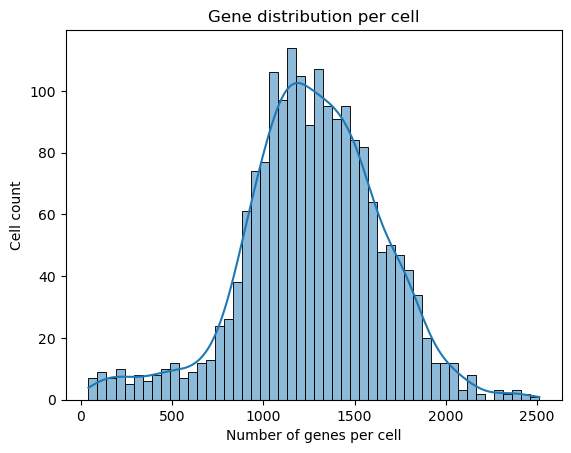

In [132]:
# Plot histogram of number of genes per cell
sns.histplot(adata_glioblastoma_raw.obs['n_genes_by_counts'], bins=50, kde=True)
plt.xlabel('Number of genes per cell')
plt.ylabel('Cell count')
plt.title('Gene distribution per cell')
plt.show()

### 🧬 Unique Molecular Identifiers (UMIs)

```{admonition} What is a UMI?
A **Unique Molecular Identifier (UMI)** is a short **random barcode** added to RNA molecules before sequencing.  
UMIs help correct for **PCR amplification bias** and improve the accuracy of gene expression quantification in single-cell RNA sequencing (**scRNA-seq**).
```

####  Why Are UMIs Important?
1️⃣ **Reduce PCR Bias** → Prevents artificially inflated gene expression caused by PCR duplicates.  
2️⃣ **Improve Quantification** → Counts only **unique UMIs**, not sequencing reads, for accurate expression levels.  
3️⃣ **Remove Technical Noise** → Helps correct sequencing errors and distinguish true biological signals.  

####  How Are UMIs Used in scRNA-seq?
- **Low UMI counts** → Suggests low RNA content, dead cells, or empty droplets.  
- **High UMI counts** → Could indicate doublets (two cells captured together).  
- **UMI filtering** ensures that only high-quality data is used in downstream analysis.  

 **UMIs improve scRNA-seq accuracy by eliminating technical biases.** 


In the histogram of total Unique Molecular Identifiers per cell, we can see that there is an skewness to the rigth and that the mean and median are not distant 

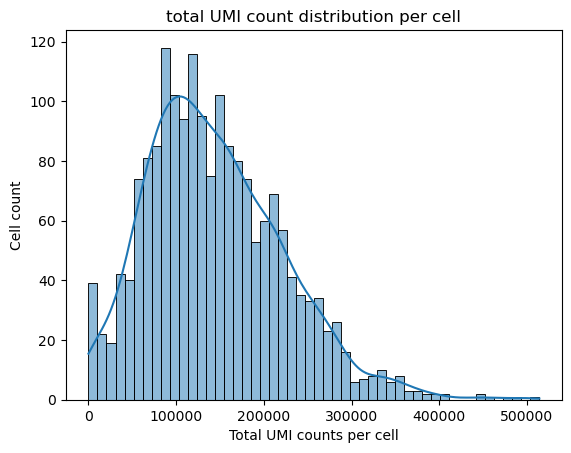

In [133]:
# Plot histogram of total UMI counts per cell
sns.histplot(adata_glioblastoma_raw.obs['total_counts'], bins = 50, kde=True)
plt.xlabel('Total UMI counts per cell')
plt.ylabel('Cell count')
plt.title('total UMI count distribution per cell')
plt.show()

The distribution of the data, as visualized in the violin plot, shows a unimodal pattern with the majority of gene counts per cell concentrated around the middle range, approximately between 500 and 1500. The density decreases symmetrically as the values move toward the extremes, with fewer cells having very low or very high gene counts.

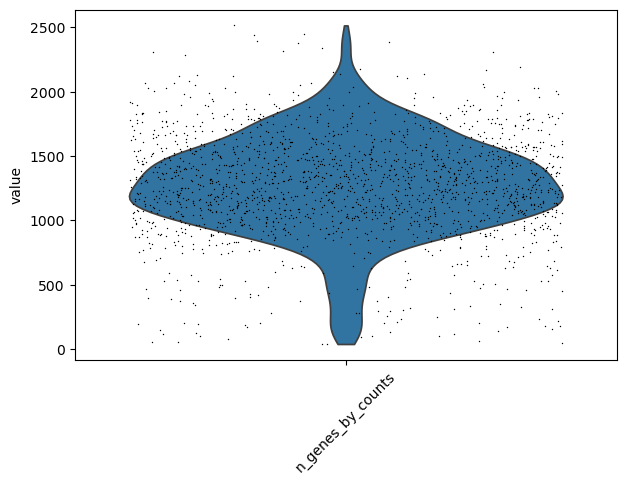

In [134]:
# Violin plot for gene counts per cell
sc.pl.violin(adata_glioblastoma_raw, keys='n_genes_by_counts', jitter=0.4, rotation=45)

In [135]:
# Print a sample of gene names to manually inspect for mitochondrial genes
print(adata_glioblastoma_raw.var_names.to_list()[:7683])  # Show first 7683 gene names

['ENSG00000000005', 'ENSG00000001561', 'ENSG00000001629', 'ENSG00000002587', 'ENSG00000002933', 'ENSG00000003056', 'ENSG00000003137', 'ENSG00000004478', 'ENSG00000004779', 'ENSG00000004799', 'ENSG00000004848', 'ENSG00000005001', 'ENSG00000005022', 'ENSG00000005073', 'ENSG00000005175', 'ENSG00000005243', 'ENSG00000005381', 'ENSG00000005421', 'ENSG00000005513', 'ENSG00000006059', 'ENSG00000006116', 'ENSG00000006194', 'ENSG00000006210', 'ENSG00000006451', 'ENSG00000006530', 'ENSG00000006606', 'ENSG00000006634', 'ENSG00000006831', 'ENSG00000007306', 'ENSG00000007376', 'ENSG00000007520', 'ENSG00000007968', 'ENSG00000008018', 'ENSG00000008118', 'ENSG00000008197', 'ENSG00000008282', 'ENSG00000008438', 'ENSG00000008988', 'ENSG00000010310', 'ENSG00000010319', 'ENSG00000010610', 'ENSG00000010818', 'ENSG00000011083', 'ENSG00000011198', 'ENSG00000011347', 'ENSG00000011376', 'ENSG00000012232', 'ENSG00000012779', 'ENSG00000012963', 'ENSG00000013275', 'ENSG00000013288', 'ENSG00000013293', 'ENSG000000

#### Gene list

In [136]:
mg = mygene.MyGeneInfo()
ensembl_ids = ['ENSG00000000005', 'ENSG00000001561', 'ENSG00000001629', 'ENSG00000002587', 'ENSG00000002933', 'ENSG00000003056', 'ENSG00000003137', 'ENSG00000004478', 'ENSG00000004779', 'ENSG00000004799', 'ENSG00000004848', 'ENSG00000005001', 'ENSG00000005022', 'ENSG00000005073', 'ENSG00000005175', 'ENSG00000005243', 'ENSG00000005381', 'ENSG00000005421', 'ENSG00000005513', 'ENSG00000006059', 'ENSG00000006116', 'ENSG00000006194', 'ENSG00000006210', 'ENSG00000006451', 'ENSG00000006530', 'ENSG00000006606', 'ENSG00000006634', 'ENSG00000006831', 'ENSG00000007306', 'ENSG00000007376', 'ENSG00000007520', 'ENSG00000007968', 'ENSG00000008018', 'ENSG00000008118', 'ENSG00000008197', 'ENSG00000008282', 'ENSG00000008438', 'ENSG00000008988', 'ENSG00000010310', 'ENSG00000010319', 'ENSG00000010610', 'ENSG00000010818', 'ENSG00000011083', 'ENSG00000011198', 'ENSG00000011347', 'ENSG00000011376', 'ENSG00000012232', 'ENSG00000012779', 'ENSG00000012963', 'ENSG00000013275', 'ENSG00000013288', 'ENSG00000013293', 'ENSG00000013392', 'ENSG00000013503', 'ENSG00000013523', 'ENSG00000013583', 'ENSG00000013588', 'ENSG00000014123', 'ENSG00000014138', 'ENSG00000014164', 'ENSG00000015413', 'ENSG00000015479', 'ENSG00000015532', 'ENSG00000016602', 'ENSG00000019186', 'ENSG00000019505', 'ENSG00000019549', 'ENSG00000019995', 'ENSG00000022556', 'ENSG00000022567', 'ENSG00000023191', 'ENSG00000023318', 'ENSG00000023516', 'ENSG00000023572', 'ENSG00000023608', 'ENSG00000023909', 'ENSG00000025772', 'ENSG00000027001', 'ENSG00000027644', 'ENSG00000028839', 'ENSG00000029559', 'ENSG00000031691', 'ENSG00000033050', 'ENSG00000034053', 'ENSG00000034510', 'ENSG00000034713', 'ENSG00000035141', 'ENSG00000035681', 'ENSG00000035687', 'ENSG00000035720', 'ENSG00000036448', 'ENSG00000036473', 'ENSG00000036530', 'ENSG00000037042', 'ENSG00000037241', 'ENSG00000037965', 'ENSG00000038002', 'ENSG00000038210', 'ENSG00000038295', 'ENSG00000039139', 'ENSG00000039987', 'ENSG00000041353', 'ENSG00000042813', 'ENSG00000043039', 'ENSG00000043591', 'ENSG00000044012', 'ENSG00000044090', 'ENSG00000044574', 'ENSG00000046774', 'ENSG00000047597', 'ENSG00000047662', 'ENSG00000048405', 'ENSG00000048544', 'ENSG00000049249', 'ENSG00000049449', 'ENSG00000049656', 'ENSG00000050344', 'ENSG00000051382', 'ENSG00000051596', 'ENSG00000052850', 'ENSG00000053328', 'ENSG00000053372', 'ENSG00000053438', 'ENSG00000053918', 'ENSG00000054282', 'ENSG00000054392', 'ENSG00000054598', 'ENSG00000054803', 'ENSG00000055813', 'ENSG00000056050', 'ENSG00000056736', 'ENSG00000057468', 'ENSG00000057757', 'ENSG00000058056', 'ENSG00000058262', 'ENSG00000059573', 'ENSG00000059588', 'ENSG00000059758', 'ENSG00000060069', 'ENSG00000060140', 'ENSG00000060558', 'ENSG00000061656', 'ENSG00000061936', 'ENSG00000062725', 'ENSG00000063180', 'ENSG00000063241', 'ENSG00000063515', 'ENSG00000063660', 'ENSG00000064195', 'ENSG00000064199', 'ENSG00000064218', 'ENSG00000064300', 'ENSG00000064726', 'ENSG00000064932', 'ENSG00000065057', 'ENSG00000065308', 'ENSG00000065320', 'ENSG00000065491', 'ENSG00000065518', 'ENSG00000065833', 'ENSG00000065923', 'ENSG00000065970', 'ENSG00000066230', 'ENSG00000066379', 'ENSG00000066422', 'ENSG00000066557', 'ENSG00000066777', 'ENSG00000067167', 'ENSG00000067182', 'ENSG00000067248', 'ENSG00000067533', 'ENSG00000067704', 'ENSG00000067900', 'ENSG00000068079', 'ENSG00000068697', 'ENSG00000068985', 'ENSG00000069482', 'ENSG00000069509', 'ENSG00000069696', 'ENSG00000069764', 'ENSG00000069943', 'ENSG00000070018', 'ENSG00000070019', 'ENSG00000070031', 'ENSG00000070047', 'ENSG00000070193', 'ENSG00000070404', 'ENSG00000070601', 'ENSG00000070761', 'ENSG00000070770', 'ENSG00000070915', 'ENSG00000070950', 'ENSG00000071203', 'ENSG00000071677', 'ENSG00000071991', 'ENSG00000072315', 'ENSG00000072415', 'ENSG00000072657', 'ENSG00000072864', 'ENSG00000072954', 'ENSG00000072958', 'ENSG00000073598', 'ENSG00000073734', 'ENSG00000073754', 'ENSG00000073861', 'ENSG00000073969', 'ENSG00000074181', 'ENSG00000074201', 'ENSG00000074695', 'ENSG00000074771', 'ENSG00000074842', 'ENSG00000075035', 'ENSG00000075043', 'ENSG00000075089', 'ENSG00000075131', 'ENSG00000075188', 'ENSG00000075290', 'ENSG00000075388', 'ENSG00000075429', 'ENSG00000075461', 'ENSG00000075643', 'ENSG00000076003', 'ENSG00000076043', 'ENSG00000076258', 'ENSG00000076356', 'ENSG00000076641', 'ENSG00000076650', 'ENSG00000076662', 'ENSG00000076716', 'ENSG00000076826', 'ENSG00000077080', 'ENSG00000077152', 'ENSG00000077274', 'ENSG00000077312', 'ENSG00000077348', 'ENSG00000077498', 'ENSG00000077514', 'ENSG00000077943', 'ENSG00000077984', 'ENSG00000078081', 'ENSG00000078237', 'ENSG00000078401', 'ENSG00000078579', 'ENSG00000078898', 'ENSG00000079112', 'ENSG00000079257', 'ENSG00000079432', 'ENSG00000079435', 'ENSG00000079462', 'ENSG00000079557', 'ENSG00000080007', 'ENSG00000080031', 'ENSG00000080200', 'ENSG00000080293', 'ENSG00000080371', 'ENSG00000080511', 'ENSG00000080573', 'ENSG00000080608', 'ENSG00000080819', 'ENSG00000081041', 'ENSG00000081051', 'ENSG00000081181', 'ENSG00000081237', 'ENSG00000081791', 'ENSG00000081800', 'ENSG00000081818', 'ENSG00000082068', 'ENSG00000082516', 'ENSG00000083093', 'ENSG00000083168', 'ENSG00000083635', 'ENSG00000083782', 'ENSG00000083807', 'ENSG00000083817', 'ENSG00000083845', 'ENSG00000083896', 'ENSG00000083937', 'ENSG00000084073', 'ENSG00000084092', 'ENSG00000084463', 'ENSG00000084628', 'ENSG00000084734', 'ENSG00000085231', 'ENSG00000085721', 'ENSG00000085871', 'ENSG00000086189', 'ENSG00000086506', 'ENSG00000086544', 'ENSG00000086548', 'ENSG00000086827', 'ENSG00000086967', 'ENSG00000087074', 'ENSG00000087076', 'ENSG00000087128', 'ENSG00000087250', 'ENSG00000087301', 'ENSG00000087302', 'ENSG00000087338', 'ENSG00000087448', 'ENSG00000087510', 'ENSG00000088038', 'ENSG00000088053', 'ENSG00000088179', 'ENSG00000088256', 'ENSG00000088320', 'ENSG00000088356', 'ENSG00000088782', 'ENSG00000088882', 'ENSG00000088930', 'ENSG00000089116', 'ENSG00000089163', 'ENSG00000089199', 'ENSG00000089220', 'ENSG00000089248', 'ENSG00000089486', 'ENSG00000089558', 'ENSG00000089692', 'ENSG00000089723', 'ENSG00000089737', 'ENSG00000089902', 'ENSG00000090013', 'ENSG00000090339', 'ENSG00000090382', 'ENSG00000090402', 'ENSG00000090432', 'ENSG00000090530', 'ENSG00000090565', 'ENSG00000090581', 'ENSG00000090776', 'ENSG00000090971', 'ENSG00000091009', 'ENSG00000091010', 'ENSG00000091073', 'ENSG00000091262', 'ENSG00000091317', 'ENSG00000091482', 'ENSG00000091483', 'ENSG00000091542', 'ENSG00000091640', 'ENSG00000091651', 'ENSG00000091664', 'ENSG00000091704', 'ENSG00000091844', 'ENSG00000091947', 'ENSG00000092067', 'ENSG00000092201', 'ENSG00000092531', 'ENSG00000093009', 'ENSG00000093217', 'ENSG00000094661', 'ENSG00000094796', 'ENSG00000094804', 'ENSG00000095015', 'ENSG00000095110', 'ENSG00000095464', 'ENSG00000095587', 'ENSG00000095627', 'ENSG00000095752', 'ENSG00000095932', 'ENSG00000096092', 'ENSG00000096401', 'ENSG00000097096', 'ENSG00000099194', 'ENSG00000099203', 'ENSG00000099282', 'ENSG00000099326', 'ENSG00000099330', 'ENSG00000099337', 'ENSG00000099399', 'ENSG00000099617', 'ENSG00000099624', 'ENSG00000099769', 'ENSG00000099795', 'ENSG00000099800', 'ENSG00000099804', 'ENSG00000099812', 'ENSG00000099822', 'ENSG00000099834', 'ENSG00000099849', 'ENSG00000099860', 'ENSG00000099953', 'ENSG00000099956', 'ENSG00000099974', 'ENSG00000099977', 'ENSG00000099984', 'ENSG00000099985', 'ENSG00000100053', 'ENSG00000100075', 'ENSG00000100078', 'ENSG00000100079', 'ENSG00000100122', 'ENSG00000100170', 'ENSG00000100191', 'ENSG00000100197', 'ENSG00000100206', 'ENSG00000100207', 'ENSG00000100209', 'ENSG00000100216', 'ENSG00000100249', 'ENSG00000100276', 'ENSG00000100285', 'ENSG00000100290', 'ENSG00000100302', 'ENSG00000100314', 'ENSG00000100320', 'ENSG00000100348', 'ENSG00000100365', 'ENSG00000100373', 'ENSG00000100387', 'ENSG00000100410', 'ENSG00000100418', 'ENSG00000100426', 'ENSG00000100441', 'ENSG00000100448', 'ENSG00000100490', 'ENSG00000100522', 'ENSG00000100557', 'ENSG00000100558', 'ENSG00000100564', 'ENSG00000100580', 'ENSG00000100583', 'ENSG00000100591', 'ENSG00000100596', 'ENSG00000100601', 'ENSG00000100625', 'ENSG00000100647', 'ENSG00000100652', 'ENSG00000100749', 'ENSG00000100884', 'ENSG00000100941', 'ENSG00000100983', 'ENSG00000100985', 'ENSG00000101000', 'ENSG00000101003', 'ENSG00000101074', 'ENSG00000101132', 'ENSG00000101161', 'ENSG00000101162', 'ENSG00000101188', 'ENSG00000101189', 'ENSG00000101193', 'ENSG00000101200', 'ENSG00000101213', 'ENSG00000101230', 'ENSG00000101280', 'ENSG00000101282', 'ENSG00000101292', 'ENSG00000101323', 'ENSG00000101327', 'ENSG00000101335', 'ENSG00000101342', 'ENSG00000101347', 'ENSG00000101350', 'ENSG00000101367', 'ENSG00000101400', 'ENSG00000101405', 'ENSG00000101421', 'ENSG00000101435', 'ENSG00000101438', 'ENSG00000101439', 'ENSG00000101440', 'ENSG00000101441', 'ENSG00000101442', 'ENSG00000101445', 'ENSG00000101446', 'ENSG00000101463', 'ENSG00000101470', 'ENSG00000101542', 'ENSG00000101544', 'ENSG00000101577', 'ENSG00000101665', 'ENSG00000101695', 'ENSG00000101825', 'ENSG00000101846', 'ENSG00000101856', 'ENSG00000101882', 'ENSG00000101883', 'ENSG00000101890', 'ENSG00000101935', 'ENSG00000102055', 'ENSG00000102057', 'ENSG00000102076', 'ENSG00000102096', 'ENSG00000102104', 'ENSG00000102109', 'ENSG00000102128', 'ENSG00000102174', 'ENSG00000102195', 'ENSG00000102218', 'ENSG00000102226', 'ENSG00000102239', 'ENSG00000102245', 'ENSG00000102302', 'ENSG00000102313', 'ENSG00000102359', 'ENSG00000102393', 'ENSG00000102409', 'ENSG00000102539', 'ENSG00000102678', 'ENSG00000102683', 'ENSG00000102699', 'ENSG00000102738', 'ENSG00000102753', 'ENSG00000102794', 'ENSG00000102802', 'ENSG00000102837', 'ENSG00000102870', 'ENSG00000102891', 'ENSG00000102897', 'ENSG00000102921', 'ENSG00000102931', 'ENSG00000102934', 'ENSG00000102962', 'ENSG00000102981', 'ENSG00000102996', 'ENSG00000103021', 'ENSG00000103024', 'ENSG00000103042', 'ENSG00000103047', 'ENSG00000103089', 'ENSG00000103121', 'ENSG00000103150', 'ENSG00000103154', 'ENSG00000103187', 'ENSG00000103222', 'ENSG00000103226', 'ENSG00000103241', 'ENSG00000103254', 'ENSG00000103257', 'ENSG00000103260', 'ENSG00000103319', 'ENSG00000103415', 'ENSG00000103429', 'ENSG00000103512', 'ENSG00000103569', 'ENSG00000103671', 'ENSG00000103707', 'ENSG00000103740', 'ENSG00000103769', 'ENSG00000104044', 'ENSG00000104059', 'ENSG00000104067', 'ENSG00000104112', 'ENSG00000104129', 'ENSG00000104140', 'ENSG00000104147', 'ENSG00000104154', 'ENSG00000104237', 'ENSG00000104267', 'ENSG00000104312', 'ENSG00000104325', 'ENSG00000104327', 'ENSG00000104331', 'ENSG00000104361', 'ENSG00000104369', 'ENSG00000104371', 'ENSG00000104408', 'ENSG00000104412', 'ENSG00000104442', 'ENSG00000104472', 'ENSG00000104499', 'ENSG00000104522', 'ENSG00000104529', 'ENSG00000104643', 'ENSG00000104671', 'ENSG00000104689', 'ENSG00000104714', 'ENSG00000104728', 'ENSG00000104755', 'ENSG00000104804', 'ENSG00000104808', 'ENSG00000104823', 'ENSG00000104848', 'ENSG00000104879', 'ENSG00000104883', 'ENSG00000104888', 'ENSG00000104889', 'ENSG00000104897', 'ENSG00000104899', 'ENSG00000104901', 'ENSG00000104903', 'ENSG00000104918', 'ENSG00000104941', 'ENSG00000104967', 'ENSG00000104969', 'ENSG00000104972', 'ENSG00000104974', 'ENSG00000104979', 'ENSG00000104980', 'ENSG00000104983', 'ENSG00000104998', 'ENSG00000105011', 'ENSG00000105072', 'ENSG00000105088', 'ENSG00000105127', 'ENSG00000105131', 'ENSG00000105141', 'ENSG00000105171', 'ENSG00000105193', 'ENSG00000105202', 'ENSG00000105205', 'ENSG00000105219', 'ENSG00000105220', 'ENSG00000105229', 'ENSG00000105245', 'ENSG00000105246', 'ENSG00000105258', 'ENSG00000105261', 'ENSG00000105329', 'ENSG00000105355', 'ENSG00000105369', 'ENSG00000105370', 'ENSG00000105371', 'ENSG00000105372', 'ENSG00000105374', 'ENSG00000105376', 'ENSG00000105379', 'ENSG00000105398', 'ENSG00000105401', 'ENSG00000105402', 'ENSG00000105427', 'ENSG00000105428', 'ENSG00000105438', 'ENSG00000105464', 'ENSG00000105467', 'ENSG00000105497', 'ENSG00000105507', 'ENSG00000105514', 'ENSG00000105523', 'ENSG00000105538', 'ENSG00000105550', 'ENSG00000105583', 'ENSG00000105605', 'ENSG00000105609', 'ENSG00000105610', 'ENSG00000105612', 'ENSG00000105613', 'ENSG00000105617', 'ENSG00000105618', 'ENSG00000105619', 'ENSG00000105641', 'ENSG00000105643', 'ENSG00000105649', 'ENSG00000105668', 'ENSG00000105675', 'ENSG00000105679', 'ENSG00000105696', 'ENSG00000105697', 'ENSG00000105708', 'ENSG00000105722', 'ENSG00000105737', 'ENSG00000105750', 'ENSG00000105755', 'ENSG00000105767', 'ENSG00000105810', 'ENSG00000105849', 'ENSG00000105855', 'ENSG00000105880', 'ENSG00000105954', 'ENSG00000105989', 'ENSG00000105991', 'ENSG00000105996', 'ENSG00000106004', 'ENSG00000106006', 'ENSG00000106025', 'ENSG00000106028', 'ENSG00000106031', 'ENSG00000106049', 'ENSG00000106123', 'ENSG00000106178', 'ENSG00000106211', 'ENSG00000106236', 'ENSG00000106299', 'ENSG00000106302', 'ENSG00000106305', 'ENSG00000106328', 'ENSG00000106344', 'ENSG00000106355', 'ENSG00000106366', 'ENSG00000106436', 'ENSG00000106511', 'ENSG00000106524', 'ENSG00000106537', 'ENSG00000106538', 'ENSG00000106591', 'ENSG00000106615', 'ENSG00000106631', 'ENSG00000106635', 'ENSG00000106636', 'ENSG00000106780', 'ENSG00000106803', 'ENSG00000106804', 'ENSG00000106952', 'ENSG00000107014', 'ENSG00000107018', 'ENSG00000107020', 'ENSG00000107130', 'ENSG00000107185', 'ENSG00000107201', 'ENSG00000107281', 'ENSG00000107282', 'ENSG00000107295', 'ENSG00000107338', 'ENSG00000107341', 'ENSG00000107438', 'ENSG00000107447', 'ENSG00000107719', 'ENSG00000107815', 'ENSG00000107854', 'ENSG00000107859', 'ENSG00000107862', 'ENSG00000107968', 'ENSG00000107984', 'ENSG00000108055', 'ENSG00000108239', 'ENSG00000108244', 'ENSG00000108255', 'ENSG00000108256', 'ENSG00000108298', 'ENSG00000108379', 'ENSG00000108389', 'ENSG00000108405', 'ENSG00000108406', 'ENSG00000108417', 'ENSG00000108424', 'ENSG00000108510', 'ENSG00000108511', 'ENSG00000108518', 'ENSG00000108551', 'ENSG00000108556', 'ENSG00000108561', 'ENSG00000108576', 'ENSG00000108591', 'ENSG00000108639', 'ENSG00000108651', 'ENSG00000108666', 'ENSG00000108671', 'ENSG00000108691', 'ENSG00000108700', 'ENSG00000108702', 'ENSG00000108733', 'ENSG00000108759', 'ENSG00000108784', 'ENSG00000108798', 'ENSG00000108829', 'ENSG00000108830', 'ENSG00000108849', 'ENSG00000108861', 'ENSG00000108878', 'ENSG00000108947', 'ENSG00000108953', 'ENSG00000108960', 'ENSG00000109047', 'ENSG00000109061', 'ENSG00000109079', 'ENSG00000109089', 'ENSG00000109101', 'ENSG00000109132', 'ENSG00000109163', 'ENSG00000109181', 'ENSG00000109208', 'ENSG00000109272', 'ENSG00000109323', 'ENSG00000109424', 'ENSG00000109436', 'ENSG00000109458', 'ENSG00000109471', 'ENSG00000109610', 'ENSG00000109674', 'ENSG00000109705', 'ENSG00000109756', 'ENSG00000109758', 'ENSG00000109805', 'ENSG00000109819', 'ENSG00000109846', 'ENSG00000109851', 'ENSG00000109919', 'ENSG00000109927', 'ENSG00000109929', 'ENSG00000109943', 'ENSG00000109991', 'ENSG00000110042', 'ENSG00000110057', 'ENSG00000110060', 'ENSG00000110063', 'ENSG00000110092', 'ENSG00000110107', 'ENSG00000110108', 'ENSG00000110148', 'ENSG00000110200', 'ENSG00000110203', 'ENSG00000110218', 'ENSG00000110237', 'ENSG00000110244', 'ENSG00000110315', 'ENSG00000110328', 'ENSG00000110330', 'ENSG00000110344', 'ENSG00000110375', 'ENSG00000110395', 'ENSG00000110484', 'ENSG00000110619', 'ENSG00000110628', 'ENSG00000110696', 'ENSG00000110700', 'ENSG00000110711', 'ENSG00000110719', 'ENSG00000110848', 'ENSG00000110852', 'ENSG00000110876', 'ENSG00000110887', 'ENSG00000110917', 'ENSG00000110925', 'ENSG00000110944', 'ENSG00000110955', 'ENSG00000110975', 'ENSG00000110987', 'ENSG00000111012', 'ENSG00000111046', 'ENSG00000111049', 'ENSG00000111052', 'ENSG00000111058', 'ENSG00000111087', 'ENSG00000111144', 'ENSG00000111145', 'ENSG00000111196', 'ENSG00000111215', 'ENSG00000111231', 'ENSG00000111241', 'ENSG00000111254', 'ENSG00000111262', 'ENSG00000111266', 'ENSG00000111269', 'ENSG00000111291', 'ENSG00000111300', 'ENSG00000111328', 'ENSG00000111341', 'ENSG00000111348', 'ENSG00000111404', 'ENSG00000111405', 'ENSG00000111412', 'ENSG00000111432', 'ENSG00000111481', 'ENSG00000111536', 'ENSG00000111537', 'ENSG00000111581', 'ENSG00000111639', 'ENSG00000111644', 'ENSG00000111652', 'ENSG00000111671', 'ENSG00000111674', 'ENSG00000111701', 'ENSG00000111711', 'ENSG00000111713', 'ENSG00000111775', 'ENSG00000111786', 'ENSG00000111796', 'ENSG00000111816', 'ENSG00000111845', 'ENSG00000111875', 'ENSG00000111885', 'ENSG00000111897', 'ENSG00000111911', 'ENSG00000111962', 'ENSG00000111981', 'ENSG00000112029', 'ENSG00000112039', 'ENSG00000112079', 'ENSG00000112110', 'ENSG00000112115', 'ENSG00000112116', 'ENSG00000112149', 'ENSG00000112164', 'ENSG00000112167', 'ENSG00000112175', 'ENSG00000112195', 'ENSG00000112218', 'ENSG00000112232', 'ENSG00000112234', 'ENSG00000112246', 'ENSG00000112273', 'ENSG00000112299', 'ENSG00000112306', 'ENSG00000112312', 'ENSG00000112365', 'ENSG00000112379', 'ENSG00000112406', 'ENSG00000112462', 'ENSG00000112494', 'ENSG00000112511', 'ENSG00000112514', 'ENSG00000112578', 'ENSG00000112584', 'ENSG00000112599', 'ENSG00000112619', 'ENSG00000112658', 'ENSG00000112742', 'ENSG00000112796', 'ENSG00000112799', 'ENSG00000112818', 'ENSG00000112852', 'ENSG00000112874', 'ENSG00000112877', 'ENSG00000112893', 'ENSG00000112981', 'ENSG00000113068', 'ENSG00000113070', 'ENSG00000113088', 'ENSG00000113100', 'ENSG00000113196', 'ENSG00000113205', 'ENSG00000113209', 'ENSG00000113211', 'ENSG00000113212', 'ENSG00000113248', 'ENSG00000113302', 'ENSG00000113318', 'ENSG00000113369', 'ENSG00000113430', 'ENSG00000113504', 'ENSG00000113525', 'ENSG00000113555', 'ENSG00000113575', 'ENSG00000113583', 'ENSG00000113594', 'ENSG00000113597', 'ENSG00000113643', 'ENSG00000113732', 'ENSG00000113749', 'ENSG00000113805', 'ENSG00000113845', 'ENSG00000113905', 'ENSG00000113946', 'ENSG00000113966', 'ENSG00000114107', 'ENSG00000114113', 'ENSG00000114115', 'ENSG00000114124', 'ENSG00000114166', 'ENSG00000114200', 'ENSG00000114248', 'ENSG00000114315', 'ENSG00000114349', 'ENSG00000114383', 'ENSG00000114446', 'ENSG00000114450', 'ENSG00000114487', 'ENSG00000114547', 'ENSG00000114573', 'ENSG00000114638', 'ENSG00000114646', 'ENSG00000114654', 'ENSG00000114656', 'ENSG00000114686', 'ENSG00000114735', 'ENSG00000114744', 'ENSG00000114767', 'ENSG00000114784', 'ENSG00000114790', 'ENSG00000114850', 'ENSG00000114854', 'ENSG00000114999', 'ENSG00000115008', 'ENSG00000115042', 'ENSG00000115073', 'ENSG00000115112', 'ENSG00000115128', 'ENSG00000115145', 'ENSG00000115165', 'ENSG00000115226', 'ENSG00000115267', 'ENSG00000115268', 'ENSG00000115290', 'ENSG00000115361', 'ENSG00000115368', 'ENSG00000115386', 'ENSG00000115457', 'ENSG00000115461', 'ENSG00000115474', 'ENSG00000115488', 'ENSG00000115507', 'ENSG00000115520', 'ENSG00000115596', 'ENSG00000115598', 'ENSG00000115607', 'ENSG00000115616', 'ENSG00000115665', 'ENSG00000115705', 'ENSG00000115738', 'ENSG00000115825', 'ENSG00000115850', 'ENSG00000115942', 'ENSG00000115946', 'ENSG00000115956', 'ENSG00000115998', 'ENSG00000116014', 'ENSG00000116031', 'ENSG00000116032', 'ENSG00000116035', 'ENSG00000116096', 'ENSG00000116120', 'ENSG00000116157', 'ENSG00000116176', 'ENSG00000116251', 'ENSG00000116273', 'ENSG00000116574', 'ENSG00000116649', 'ENSG00000116704', 'ENSG00000116711', 'ENSG00000116721', 'ENSG00000116726', 'ENSG00000116741', 'ENSG00000116745', 'ENSG00000116752', 'ENSG00000116771', 'ENSG00000116819', 'ENSG00000116824', 'ENSG00000116903', 'ENSG00000116954', 'ENSG00000116981', 'ENSG00000116996', 'ENSG00000117000', 'ENSG00000117016', 'ENSG00000117020', 'ENSG00000117091', 'ENSG00000117118', 'ENSG00000117148', 'ENSG00000117228', 'ENSG00000117318', 'ENSG00000117461', 'ENSG00000117472', 'ENSG00000117507', 'ENSG00000117560', 'ENSG00000117592', 'ENSG00000117593', 'ENSG00000117594', 'ENSG00000117614', 'ENSG00000117691', 'ENSG00000117748', 'ENSG00000118017', 'ENSG00000118096', 'ENSG00000118137', 'ENSG00000118217', 'ENSG00000118231', 'ENSG00000118245', 'ENSG00000118271', 'ENSG00000118292', 'ENSG00000118402', 'ENSG00000118434', 'ENSG00000118491', 'ENSG00000118496', 'ENSG00000118508', 'ENSG00000118523', 'ENSG00000118526', 'ENSG00000118620', 'ENSG00000118655', 'ENSG00000118702', 'ENSG00000118707', 'ENSG00000118762', 'ENSG00000118804', 'ENSG00000118816', 'ENSG00000118849', 'ENSG00000118971', 'ENSG00000118972', 'ENSG00000119013', 'ENSG00000119048', 'ENSG00000119138', 'ENSG00000119147', 'ENSG00000119227', 'ENSG00000119242', 'ENSG00000119321', 'ENSG00000119421', 'ENSG00000119431', 'ENSG00000119457', 'ENSG00000119514', 'ENSG00000119523', 'ENSG00000119541', 'ENSG00000119547', 'ENSG00000119614', 'ENSG00000119632', 'ENSG00000119640', 'ENSG00000119669', 'ENSG00000119686', 'ENSG00000119698', 'ENSG00000119699', 'ENSG00000119705', 'ENSG00000119737', 'ENSG00000119865', 'ENSG00000119878', 'ENSG00000119900', 'ENSG00000119913', 'ENSG00000119915', 'ENSG00000119922', 'ENSG00000119938', 'ENSG00000119973', 'ENSG00000119986', 'ENSG00000120055', 'ENSG00000120057', 'ENSG00000120063', 'ENSG00000120068', 'ENSG00000120071', 'ENSG00000120075', 'ENSG00000120088', 'ENSG00000120094', 'ENSG00000120129', 'ENSG00000120137', 'ENSG00000120149', 'ENSG00000120162', 'ENSG00000120210', 'ENSG00000120211', 'ENSG00000120215', 'ENSG00000120235', 'ENSG00000120242', 'ENSG00000120256', 'ENSG00000120262', 'ENSG00000120279', 'ENSG00000120280', 'ENSG00000120306', 'ENSG00000120322', 'ENSG00000120324', 'ENSG00000120327', 'ENSG00000120328', 'ENSG00000120329', 'ENSG00000120333', 'ENSG00000120337', 'ENSG00000120436', 'ENSG00000120437', 'ENSG00000120563', 'ENSG00000120645', 'ENSG00000120647', 'ENSG00000120675', 'ENSG00000120688', 'ENSG00000120696', 'ENSG00000120697', 'ENSG00000120729', 'ENSG00000120738', 'ENSG00000120800', 'ENSG00000120832', 'ENSG00000120837', 'ENSG00000120875', 'ENSG00000120937', 'ENSG00000120952', 'ENSG00000121005', 'ENSG00000121039', 'ENSG00000121053', 'ENSG00000121058', 'ENSG00000121075', 'ENSG00000121104', 'ENSG00000121152', 'ENSG00000121211', 'ENSG00000121297', 'ENSG00000121314', 'ENSG00000121318', 'ENSG00000121351', 'ENSG00000121361', 'ENSG00000121377', 'ENSG00000121381', 'ENSG00000121406', 'ENSG00000121454', 'ENSG00000121552', 'ENSG00000121621', 'ENSG00000121634', 'ENSG00000121691', 'ENSG00000121743', 'ENSG00000121769', 'ENSG00000121797', 'ENSG00000121807', 'ENSG00000121853', 'ENSG00000121864', 'ENSG00000121871', 'ENSG00000121879', 'ENSG00000121895', 'ENSG00000121905', 'ENSG00000121966', 'ENSG00000122035', 'ENSG00000122042', 'ENSG00000122122', 'ENSG00000122180', 'ENSG00000122254', 'ENSG00000122420', 'ENSG00000122435', 'ENSG00000122484', 'ENSG00000122557', 'ENSG00000122585', 'ENSG00000122592', 'ENSG00000122679', 'ENSG00000122692', 'ENSG00000122711', 'ENSG00000122728', 'ENSG00000122778', 'ENSG00000122859', 'ENSG00000122862', 'ENSG00000122863', 'ENSG00000122971', 'ENSG00000123066', 'ENSG00000123091', 'ENSG00000123095', 'ENSG00000123165', 'ENSG00000123171', 'ENSG00000123268', 'ENSG00000123307', 'ENSG00000123353', 'ENSG00000123364', 'ENSG00000123388', 'ENSG00000123407', 'ENSG00000123496', 'ENSG00000123500', 'ENSG00000123545', 'ENSG00000123569', 'ENSG00000123570', 'ENSG00000123575', 'ENSG00000123576', 'ENSG00000123584', 'ENSG00000123594', 'ENSG00000123595', 'ENSG00000123610', 'ENSG00000123685', 'ENSG00000123689', 'ENSG00000123700', 'ENSG00000123728', 'ENSG00000123810', 'ENSG00000123901', 'ENSG00000123975', 'ENSG00000123977', 'ENSG00000123999', 'ENSG00000124019', 'ENSG00000124089', 'ENSG00000124091', 'ENSG00000124098', 'ENSG00000124102', 'ENSG00000124103', 'ENSG00000124107', 'ENSG00000124134', 'ENSG00000124145', 'ENSG00000124157', 'ENSG00000124171', 'ENSG00000124172', 'ENSG00000124196', 'ENSG00000124198', 'ENSG00000124203', 'ENSG00000124209', 'ENSG00000124212', 'ENSG00000124216', 'ENSG00000124217', 'ENSG00000124227', 'ENSG00000124237', 'ENSG00000124249', 'ENSG00000124257', 'ENSG00000124374', 'ENSG00000124383', 'ENSG00000124391', 'ENSG00000124449', 'ENSG00000124466', 'ENSG00000124479', 'ENSG00000124541', 'ENSG00000124562', 'ENSG00000124575', 'ENSG00000124602', 'ENSG00000124608', 'ENSG00000124610', 'ENSG00000124613', 'ENSG00000124635', 'ENSG00000124657', 'ENSG00000124659', 'ENSG00000124701', 'ENSG00000124713', 'ENSG00000124733', 'ENSG00000124743', 'ENSG00000124766', 'ENSG00000124767', 'ENSG00000124784', 'ENSG00000124785', 'ENSG00000124786', 'ENSG00000124827', 'ENSG00000124875', 'ENSG00000124882', 'ENSG00000124935', 'ENSG00000124939', 'ENSG00000125148', 'ENSG00000125207', 'ENSG00000125249', 'ENSG00000125255', 'ENSG00000125266', 'ENSG00000125285', 'ENSG00000125304', 'ENSG00000125352', 'ENSG00000125356', 'ENSG00000125384', 'ENSG00000125398', 'ENSG00000125430', 'ENSG00000125449', 'ENSG00000125458', 'ENSG00000125492', 'ENSG00000125498', 'ENSG00000125505', 'ENSG00000125508', 'ENSG00000125510', 'ENSG00000125522', 'ENSG00000125531', 'ENSG00000125533', 'ENSG00000125534', 'ENSG00000125571', 'ENSG00000125650', 'ENSG00000125652', 'ENSG00000125656', 'ENSG00000125657', 'ENSG00000125741', 'ENSG00000125788', 'ENSG00000125810', 'ENSG00000125815', 'ENSG00000125816', 'ENSG00000125817', 'ENSG00000125820', 'ENSG00000125827', 'ENSG00000125831', 'ENSG00000125845', 'ENSG00000125848', 'ENSG00000125851', 'ENSG00000125869', 'ENSG00000125872', 'ENSG00000125878', 'ENSG00000125879', 'ENSG00000125895', 'ENSG00000125901', 'ENSG00000125903', 'ENSG00000125910', 'ENSG00000125965', 'ENSG00000125966', 'ENSG00000125968', 'ENSG00000125977', 'ENSG00000125998', 'ENSG00000126003', 'ENSG00000126010', 'ENSG00000126062', 'ENSG00000126216', 'ENSG00000126233', 'ENSG00000126243', 'ENSG00000126246', 'ENSG00000126249', 'ENSG00000126251', 'ENSG00000126262', 'ENSG00000126264', 'ENSG00000126266', 'ENSG00000126267', 'ENSG00000126353', 'ENSG00000126368', 'ENSG00000126453', 'ENSG00000126458', 'ENSG00000126500', 'ENSG00000126524', 'ENSG00000126549', 'ENSG00000126550', 'ENSG00000126603', 'ENSG00000126749', 'ENSG00000126752', 'ENSG00000126775', 'ENSG00000126778', 'ENSG00000126803', 'ENSG00000126814', 'ENSG00000126821', 'ENSG00000126838', 'ENSG00000126861', 'ENSG00000126945', 'ENSG00000126950', 'ENSG00000126953', 'ENSG00000127022', 'ENSG00000127080', 'ENSG00000127083', 'ENSG00000127125', 'ENSG00000127129', 'ENSG00000127220', 'ENSG00000127252', 'ENSG00000127311', 'ENSG00000127324', 'ENSG00000127337', 'ENSG00000127362', 'ENSG00000127364', 'ENSG00000127366', 'ENSG00000127377', 'ENSG00000127412', 'ENSG00000127452', 'ENSG00000127511', 'ENSG00000127515', 'ENSG00000127528', 'ENSG00000127529', 'ENSG00000127530', 'ENSG00000127533', 'ENSG00000127578', 'ENSG00000127588', 'ENSG00000127666', 'ENSG00000127720', 'ENSG00000127743', 'ENSG00000127774', 'ENSG00000127780', 'ENSG00000127837', 'ENSG00000127884', 'ENSG00000127920', 'ENSG00000127922', 'ENSG00000127951', 'ENSG00000128011', 'ENSG00000128016', 'ENSG00000128045', 'ENSG00000128050', 'ENSG00000128052', 'ENSG00000128059', 'ENSG00000128165', 'ENSG00000128185', 'ENSG00000128203', 'ENSG00000128218', 'ENSG00000128228', 'ENSG00000128250', 'ENSG00000128262', 'ENSG00000128266', 'ENSG00000128283', 'ENSG00000128285', 'ENSG00000128310', 'ENSG00000128313', 'ENSG00000128322', 'ENSG00000128342', 'ENSG00000128383', 'ENSG00000128408', 'ENSG00000128519', 'ENSG00000128524', 'ENSG00000128534', 'ENSG00000128564', 'ENSG00000128578', 'ENSG00000128590', 'ENSG00000128594', 'ENSG00000128602', 'ENSG00000128617', 'ENSG00000128655', 'ENSG00000128710', 'ENSG00000128714', 'ENSG00000128731', 'ENSG00000128872', 'ENSG00000128917', 'ENSG00000128928', 'ENSG00000129028', 'ENSG00000129048', 'ENSG00000129071', 'ENSG00000129151', 'ENSG00000129152', 'ENSG00000129159', 'ENSG00000129167', 'ENSG00000129170', 'ENSG00000129194', 'ENSG00000129244', 'ENSG00000129295', 'ENSG00000129355', 'ENSG00000129437', 'ENSG00000129450', 'ENSG00000129473', 'ENSG00000129514', 'ENSG00000129518', 'ENSG00000129596', 'ENSG00000129654', 'ENSG00000129673', 'ENSG00000129744', 'ENSG00000129749', 'ENSG00000129757', 'ENSG00000129864', 'ENSG00000129873', 'ENSG00000129910', 'ENSG00000129911', 'ENSG00000129932', 'ENSG00000129951', 'ENSG00000129988', 'ENSG00000130023', 'ENSG00000130035', 'ENSG00000130037', 'ENSG00000130038', 'ENSG00000130054', 'ENSG00000130175', 'ENSG00000130176', 'ENSG00000130182', 'ENSG00000130193', 'ENSG00000130202', 'ENSG00000130203', 'ENSG00000130208', 'ENSG00000130300', 'ENSG00000130312', 'ENSG00000130313', 'ENSG00000130349', 'ENSG00000130368', 'ENSG00000130382', 'ENSG00000130383', 'ENSG00000130385', 'ENSG00000130427', 'ENSG00000130433', 'ENSG00000130449', 'ENSG00000130487', 'ENSG00000130489', 'ENSG00000130513', 'ENSG00000130522', 'ENSG00000130538', 'ENSG00000130560', 'ENSG00000130643', 'ENSG00000130649', 'ENSG00000130656', 'ENSG00000130699', 'ENSG00000130700', 'ENSG00000130701', 'ENSG00000130711', 'ENSG00000130724', 'ENSG00000130725', 'ENSG00000130734', 'ENSG00000130748', 'ENSG00000130749', 'ENSG00000130751', 'ENSG00000130758', 'ENSG00000130764', 'ENSG00000130766', 'ENSG00000130827', 'ENSG00000130921', 'ENSG00000130935', 'ENSG00000130943', 'ENSG00000130948', 'ENSG00000130957', 'ENSG00000131013', 'ENSG00000131015', 'ENSG00000131042', 'ENSG00000131055', 'ENSG00000131068', 'ENSG00000131094', 'ENSG00000131097', 'ENSG00000131143', 'ENSG00000131148', 'ENSG00000131153', 'ENSG00000131174', 'ENSG00000131187', 'ENSG00000131233', 'ENSG00000131264', 'ENSG00000131368', 'ENSG00000131375', 'ENSG00000131379', 'ENSG00000131400', 'ENSG00000131462', 'ENSG00000131471', 'ENSG00000131475', 'ENSG00000131480', 'ENSG00000131482', 'ENSG00000131495', 'ENSG00000131669', 'ENSG00000131721', 'ENSG00000131737', 'ENSG00000131791', 'ENSG00000131844', 'ENSG00000131848', 'ENSG00000131873', 'ENSG00000131910', 'ENSG00000131931', 'ENSG00000131941', 'ENSG00000131944', 'ENSG00000132002', 'ENSG00000132003', 'ENSG00000132005', 'ENSG00000132109', 'ENSG00000132164', 'ENSG00000132323', 'ENSG00000132386', 'ENSG00000132429', 'ENSG00000132434', 'ENSG00000132446', 'ENSG00000132467', 'ENSG00000132478', 'ENSG00000132481', 'ENSG00000132518', 'ENSG00000132581', 'ENSG00000132631', 'ENSG00000132661', 'ENSG00000132671', 'ENSG00000132703', 'ENSG00000132718', 'ENSG00000132740', 'ENSG00000132744', 'ENSG00000132801', 'ENSG00000132825', 'ENSG00000132840', 'ENSG00000132846', 'ENSG00000132855', 'ENSG00000132911', 'ENSG00000132963', 'ENSG00000132965', 'ENSG00000132975', 'ENSG00000133020', 'ENSG00000133055', 'ENSG00000133101', 'ENSG00000133105', 'ENSG00000133111', 'ENSG00000133116', 'ENSG00000133169', 'ENSG00000133195', 'ENSG00000133243', 'ENSG00000133328', 'ENSG00000133392', 'ENSG00000133393', 'ENSG00000133398', 'ENSG00000133433', 'ENSG00000133460', 'ENSG00000133574', 'ENSG00000133639', 'ENSG00000133704', 'ENSG00000133731', 'ENSG00000133800', 'ENSG00000133808', 'ENSG00000133863', 'ENSG00000133874', 'ENSG00000133878', 'ENSG00000133884', 'ENSG00000133935', 'ENSG00000133937', 'ENSG00000133962', 'ENSG00000133980', 'ENSG00000133985', 'ENSG00000134007', 'ENSG00000134020', 'ENSG00000134049', 'ENSG00000134056', 'ENSG00000134058', 'ENSG00000134061', 'ENSG00000134070', 'ENSG00000134086', 'ENSG00000134107', 'ENSG00000134121', 'ENSG00000134153', 'ENSG00000134160', 'ENSG00000134198', 'ENSG00000134200', 'ENSG00000134247', 'ENSG00000134249', 'ENSG00000134253', 'ENSG00000134259', 'ENSG00000134287', 'ENSG00000134297', 'ENSG00000134339', 'ENSG00000134389', 'ENSG00000134438', 'ENSG00000134443', 'ENSG00000134489', 'ENSG00000134531', 'ENSG00000134533', 'ENSG00000134538', 'ENSG00000134548', 'ENSG00000134569', 'ENSG00000134575', 'ENSG00000134594', 'ENSG00000134595', 'ENSG00000134640', 'ENSG00000134716', 'ENSG00000134757', 'ENSG00000134760', 'ENSG00000134765', 'ENSG00000134780', 'ENSG00000134809', 'ENSG00000134812', 'ENSG00000134827', 'ENSG00000134830', 'ENSG00000134873', 'ENSG00000134917', 'ENSG00000134962', 'ENSG00000135045', 'ENSG00000135077', 'ENSG00000135097', 'ENSG00000135116', 'ENSG00000135144', 'ENSG00000135175', 'ENSG00000135211', 'ENSG00000135222', 'ENSG00000135245', 'ENSG00000135249', 'ENSG00000135312', 'ENSG00000135324', 'ENSG00000135334', 'ENSG00000135346', 'ENSG00000135355', 'ENSG00000135372', 'ENSG00000135374', 'ENSG00000135378', 'ENSG00000135413', 'ENSG00000135414', 'ENSG00000135436', 'ENSG00000135437', 'ENSG00000135441', 'ENSG00000135443', 'ENSG00000135452', 'ENSG00000135457', 'ENSG00000135472', 'ENSG00000135482', 'ENSG00000135517', 'ENSG00000135519', 'ENSG00000135521', 'ENSG00000135547', 'ENSG00000135569', 'ENSG00000135577', 'ENSG00000135587', 'ENSG00000135604', 'ENSG00000135617', 'ENSG00000135625', 'ENSG00000135643', 'ENSG00000135697', 'ENSG00000135698', 'ENSG00000135722', 'ENSG00000135736', 'ENSG00000135744', 'ENSG00000135763', 'ENSG00000135766', 'ENSG00000135776', 'ENSG00000135801', 'ENSG00000135845', 'ENSG00000135862', 'ENSG00000135898', 'ENSG00000135900', 'ENSG00000135902', 'ENSG00000135914', 'ENSG00000135925', 'ENSG00000135929', 'ENSG00000135940', 'ENSG00000135945', 'ENSG00000135956', 'ENSG00000135960', 'ENSG00000135972', 'ENSG00000135973', 'ENSG00000135974', 'ENSG00000136040', 'ENSG00000136052', 'ENSG00000136159', 'ENSG00000136206', 'ENSG00000136213', 'ENSG00000136240', 'ENSG00000136274', 'ENSG00000136327', 'ENSG00000136383', 'ENSG00000136444', 'ENSG00000136451', 'ENSG00000136457', 'ENSG00000136463', 'ENSG00000136478', 'ENSG00000136490', 'ENSG00000136492', 'ENSG00000136514', 'ENSG00000136542', 'ENSG00000136634', 'ENSG00000136694', 'ENSG00000136698', 'ENSG00000136710', 'ENSG00000136718', 'ENSG00000136720', 'ENSG00000136783', 'ENSG00000136834', 'ENSG00000136839', 'ENSG00000136859', 'ENSG00000136881', 'ENSG00000136888', 'ENSG00000136897', 'ENSG00000136918', 'ENSG00000136928', 'ENSG00000136931', 'ENSG00000136938', 'ENSG00000136939', 'ENSG00000136982', 'ENSG00000136986', 'ENSG00000136999', 'ENSG00000137038', 'ENSG00000137040', 'ENSG00000137077', 'ENSG00000137078', 'ENSG00000137080', 'ENSG00000137124', 'ENSG00000137142', 'ENSG00000137168', 'ENSG00000137198', 'ENSG00000137252', 'ENSG00000137267', 'ENSG00000137273', 'ENSG00000137285', 'ENSG00000137288', 'ENSG00000137310', 'ENSG00000137312', 'ENSG00000137331', 'ENSG00000137337', 'ENSG00000137338', 'ENSG00000137343', 'ENSG00000137364', 'ENSG00000137392', 'ENSG00000137393', 'ENSG00000137404', 'ENSG00000137411', 'ENSG00000137414', 'ENSG00000137440', 'ENSG00000137441', 'ENSG00000137460', 'ENSG00000137462', 'ENSG00000137463', 'ENSG00000137492', 'ENSG00000137500', 'ENSG00000137502', 'ENSG00000137513', 'ENSG00000137547', 'ENSG00000137558', 'ENSG00000137561', 'ENSG00000137634', 'ENSG00000137673', 'ENSG00000137674', 'ENSG00000137675', 'ENSG00000137700', 'ENSG00000137709', 'ENSG00000137714', 'ENSG00000137720', 'ENSG00000137806', 'ENSG00000137842', 'ENSG00000137875', 'ENSG00000137876', 'ENSG00000137877', 'ENSG00000137880', 'ENSG00000137960', 'ENSG00000137975', 'ENSG00000137976', 'ENSG00000138083', 'ENSG00000138109', 'ENSG00000138131', 'ENSG00000138135', 'ENSG00000138136', 'ENSG00000138152', 'ENSG00000138160', 'ENSG00000138166', 'ENSG00000138175', 'ENSG00000138271', 'ENSG00000138308', 'ENSG00000138336', 'ENSG00000138379', 'ENSG00000138381', 'ENSG00000138442', 'ENSG00000138459', 'ENSG00000138463', 'ENSG00000138483', 'ENSG00000138495', 'ENSG00000138587', 'ENSG00000138593', 'ENSG00000138600', 'ENSG00000138604', 'ENSG00000138615', 'ENSG00000138622', 'ENSG00000138623', 'ENSG00000138646', 'ENSG00000138650', 'ENSG00000138653', 'ENSG00000138663', 'ENSG00000138669', 'ENSG00000138684', 'ENSG00000138686', 'ENSG00000138722', 'ENSG00000138755', 'ENSG00000138760', 'ENSG00000138792', 'ENSG00000138794', 'ENSG00000138795', 'ENSG00000138801', 'ENSG00000138813', 'ENSG00000138944', 'ENSG00000139053', 'ENSG00000139055', 'ENSG00000139133', 'ENSG00000139144', 'ENSG00000139155', 'ENSG00000139168', 'ENSG00000139173', 'ENSG00000139187', 'ENSG00000139193', 'ENSG00000139194', 'ENSG00000139211', 'ENSG00000139223', 'ENSG00000139233', 'ENSG00000139266', 'ENSG00000139269', 'ENSG00000139278', 'ENSG00000139318', 'ENSG00000139329', 'ENSG00000139330', 'ENSG00000139344', 'ENSG00000139352', 'ENSG00000139433', 'ENSG00000139438', 'ENSG00000139515', 'ENSG00000139517', 'ENSG00000139547', 'ENSG00000139549', 'ENSG00000139572', 'ENSG00000139574', 'ENSG00000139610', 'ENSG00000139645', 'ENSG00000139648', 'ENSG00000139656', 'ENSG00000139668', 'ENSG00000139719', 'ENSG00000139722', 'ENSG00000139725', 'ENSG00000139767', 'ENSG00000139780', 'ENSG00000139797', 'ENSG00000139800', 'ENSG00000139826', 'ENSG00000139832', 'ENSG00000139874', 'ENSG00000139890', 'ENSG00000139914', 'ENSG00000139946', 'ENSG00000139985', 'ENSG00000139988', 'ENSG00000140022', 'ENSG00000140030', 'ENSG00000140057', 'ENSG00000140067', 'ENSG00000140093', 'ENSG00000140259', 'ENSG00000140285', 'ENSG00000140323', 'ENSG00000140379', 'ENSG00000140395', 'ENSG00000140406', 'ENSG00000140450', 'ENSG00000140505', 'ENSG00000140548', 'ENSG00000140694', 'ENSG00000140743', 'ENSG00000140749', 'ENSG00000140807', 'ENSG00000140830', 'ENSG00000140832', 'ENSG00000140835', 'ENSG00000140932', 'ENSG00000140986', 'ENSG00000141026', 'ENSG00000141034', 'ENSG00000141076', 'ENSG00000141096', 'ENSG00000141194', 'ENSG00000141200', 'ENSG00000141232', 'ENSG00000141294', 'ENSG00000141349', 'ENSG00000141385', 'ENSG00000141437', 'ENSG00000141448', 'ENSG00000141452', 'ENSG00000141543', 'ENSG00000141556', 'ENSG00000141574', 'ENSG00000141579', 'ENSG00000141642', 'ENSG00000141664', 'ENSG00000141668', 'ENSG00000141744', 'ENSG00000141750', 'ENSG00000141753', 'ENSG00000141854', 'ENSG00000141933', 'ENSG00000141934', 'ENSG00000141946', 'ENSG00000141965', 'ENSG00000141968', 'ENSG00000141977', 'ENSG00000141985', 'ENSG00000142039', 'ENSG00000142149', 'ENSG00000142178', 'ENSG00000142182', 'ENSG00000142188', 'ENSG00000142207', 'ENSG00000142235', 'ENSG00000142319', 'ENSG00000142408', 'ENSG00000142409', 'ENSG00000142444', 'ENSG00000142459', 'ENSG00000142484', 'ENSG00000142507', 'ENSG00000142511', 'ENSG00000142513', 'ENSG00000142534', 'ENSG00000142538', 'ENSG00000142544', 'ENSG00000142549', 'ENSG00000142552', 'ENSG00000142606', 'ENSG00000142615', 'ENSG00000142619', 'ENSG00000142623', 'ENSG00000142677', 'ENSG00000142684', 'ENSG00000142686', 'ENSG00000142694', 'ENSG00000142959', 'ENSG00000143001', 'ENSG00000143006', 'ENSG00000143028', 'ENSG00000143032', 'ENSG00000143067', 'ENSG00000143105', 'ENSG00000143107', 'ENSG00000143125', 'ENSG00000143126', 'ENSG00000143162', 'ENSG00000143184', 'ENSG00000143185', 'ENSG00000143196', 'ENSG00000143217', 'ENSG00000143256', 'ENSG00000143278', 'ENSG00000143315', 'ENSG00000143320', 'ENSG00000143333', 'ENSG00000143340', 'ENSG00000143368', 'ENSG00000143412', 'ENSG00000143443', 'ENSG00000143473', 'ENSG00000143520', 'ENSG00000143536', 'ENSG00000143545', 'ENSG00000143546', 'ENSG00000143552', 'ENSG00000143556', 'ENSG00000143614', 'ENSG00000143627', 'ENSG00000143630', 'ENSG00000143641', 'ENSG00000143653', 'ENSG00000143702', 'ENSG00000143751', 'ENSG00000143772', 'ENSG00000143786', 'ENSG00000143816', 'ENSG00000143862', 'ENSG00000143867', 'ENSG00000143869', 'ENSG00000143878', 'ENSG00000143921', 'ENSG00000143942', 'ENSG00000143971', 'ENSG00000144010', 'ENSG00000144015', 'ENSG00000144021', 'ENSG00000144035', 'ENSG00000144063', 'ENSG00000144119', 'ENSG00000144214', 'ENSG00000144227', 'ENSG00000144228', 'ENSG00000144233', 'ENSG00000144407', 'ENSG00000144410', 'ENSG00000144476', 'ENSG00000144559', 'ENSG00000144579', 'ENSG00000144583', 'ENSG00000144635', 'ENSG00000144647', 'ENSG00000144649', 'ENSG00000144746', 'ENSG00000144771', 'ENSG00000144791', 'ENSG00000144792', 'ENSG00000144820', 'ENSG00000144821', 'ENSG00000144827', 'ENSG00000144837', 'ENSG00000144840', 'ENSG00000144909', 'ENSG00000144959', 'ENSG00000144962', 'ENSG00000145022', 'ENSG00000145040', 'ENSG00000145088', 'ENSG00000145113', 'ENSG00000145248', 'ENSG00000145283', 'ENSG00000145309', 'ENSG00000145337', 'ENSG00000145354', 'ENSG00000145358', 'ENSG00000145375', 'ENSG00000145384', 'ENSG00000145386', 'ENSG00000145414', 'ENSG00000145423', 'ENSG00000145425', 'ENSG00000145506', 'ENSG00000145569', 'ENSG00000145649', 'ENSG00000145700', 'ENSG00000145734', 'ENSG00000145736', 'ENSG00000145779', 'ENSG00000145780', 'ENSG00000145781', 'ENSG00000145808', 'ENSG00000145826', 'ENSG00000145839', 'ENSG00000145850', 'ENSG00000145861', 'ENSG00000145911', 'ENSG00000145912', 'ENSG00000145936', 'ENSG00000145945', 'ENSG00000145949', 'ENSG00000146001', 'ENSG00000146005', 'ENSG00000146006', 'ENSG00000146047', 'ENSG00000146049', 'ENSG00000146066', 'ENSG00000146072', 'ENSG00000146085', 'ENSG00000146109', 'ENSG00000146112', 'ENSG00000146197', 'ENSG00000146221', 'ENSG00000146233', 'ENSG00000146242', 'ENSG00000146250', 'ENSG00000146281', 'ENSG00000146360', 'ENSG00000146378', 'ENSG00000146383', 'ENSG00000146385', 'ENSG00000146386', 'ENSG00000146399', 'ENSG00000146411', 'ENSG00000146433', 'ENSG00000146477', 'ENSG00000146618', 'ENSG00000146670', 'ENSG00000146676', 'ENSG00000146678', 'ENSG00000146700', 'ENSG00000146707', 'ENSG00000146729', 'ENSG00000146830', 'ENSG00000146857', 'ENSG00000146858', 'ENSG00000146859', 'ENSG00000146904', 'ENSG00000146909', 'ENSG00000147003', 'ENSG00000147027', 'ENSG00000147059', 'ENSG00000147117', 'ENSG00000147119', 'ENSG00000147127', 'ENSG00000147138', 'ENSG00000147160', 'ENSG00000147183', 'ENSG00000147223', 'ENSG00000147246', 'ENSG00000147262', 'ENSG00000147400', 'ENSG00000147432', 'ENSG00000147434', 'ENSG00000147437', 'ENSG00000147570', 'ENSG00000147571', 'ENSG00000147586', 'ENSG00000147588', 'ENSG00000147592', 'ENSG00000147596', 'ENSG00000147606', 'ENSG00000147613', 'ENSG00000147614', 'ENSG00000147649', 'ENSG00000147684', 'ENSG00000147697', 'ENSG00000147804', 'ENSG00000147813', 'ENSG00000147869', 'ENSG00000147872', 'ENSG00000147873', 'ENSG00000147885', 'ENSG00000147896', 'ENSG00000147912', 'ENSG00000148082', 'ENSG00000148123', 'ENSG00000148136', 'ENSG00000148154', 'ENSG00000148156', 'ENSG00000148215', 'ENSG00000148248', 'ENSG00000148290', 'ENSG00000148291', 'ENSG00000148296', 'ENSG00000148297', 'ENSG00000148300', 'ENSG00000148303', 'ENSG00000148377', 'ENSG00000148386', 'ENSG00000148400', 'ENSG00000148411', 'ENSG00000148483', 'ENSG00000148602', 'ENSG00000148672', 'ENSG00000148677', 'ENSG00000148730', 'ENSG00000148734', 'ENSG00000148795', 'ENSG00000148826', 'ENSG00000148926', 'ENSG00000148948', 'ENSG00000148950', 'ENSG00000148965', 'ENSG00000149021', 'ENSG00000149050', 'ENSG00000149133', 'ENSG00000149136', 'ENSG00000149150', 'ENSG00000149201', 'ENSG00000149218', 'ENSG00000149269', 'ENSG00000149300', 'ENSG00000149305', 'ENSG00000149357', 'ENSG00000149480', 'ENSG00000149489', 'ENSG00000149507', 'ENSG00000149534', 'ENSG00000149541', 'ENSG00000149573', 'ENSG00000149575', 'ENSG00000149596', 'ENSG00000149609', 'ENSG00000149634', 'ENSG00000149635', 'ENSG00000149651', 'ENSG00000149654', 'ENSG00000149735', 'ENSG00000149742', 'ENSG00000149761', 'ENSG00000149792', 'ENSG00000149798', 'ENSG00000149823', 'ENSG00000150261', 'ENSG00000150269', 'ENSG00000150281', 'ENSG00000150433', 'ENSG00000150457', 'ENSG00000150594', 'ENSG00000150628', 'ENSG00000150630', 'ENSG00000150637', 'ENSG00000150667', 'ENSG00000150681', 'ENSG00000150750', 'ENSG00000150783', 'ENSG00000150787', 'ENSG00000150907', 'ENSG00000150938', 'ENSG00000150990', 'ENSG00000151005', 'ENSG00000151006', 'ENSG00000151014', 'ENSG00000151025', 'ENSG00000151033', 'ENSG00000151093', 'ENSG00000151117', 'ENSG00000151135', 'ENSG00000151151', 'ENSG00000151176', 'ENSG00000151304', 'ENSG00000151360', 'ENSG00000151365', 'ENSG00000151379', 'ENSG00000151388', 'ENSG00000151475', 'ENSG00000151572', 'ENSG00000151615', 'ENSG00000151650', 'ENSG00000151715', 'ENSG00000151790', 'ENSG00000151846', 'ENSG00000151929', 'ENSG00000151962', 'ENSG00000151967', 'ENSG00000152049', 'ENSG00000152078', 'ENSG00000152086', 'ENSG00000152093', 'ENSG00000152127', 'ENSG00000152137', 'ENSG00000152192', 'ENSG00000152193', 'ENSG00000152207', 'ENSG00000152213', 'ENSG00000152219', 'ENSG00000152253', 'ENSG00000152254', 'ENSG00000152266', 'ENSG00000152270', 'ENSG00000152284', 'ENSG00000152315', 'ENSG00000152380', 'ENSG00000152382', 'ENSG00000152409', 'ENSG00000152454', 'ENSG00000152467', 'ENSG00000152475', 'ENSG00000152503', 'ENSG00000152518', 'ENSG00000152580', 'ENSG00000152661', 'ENSG00000152669', 'ENSG00000152672', 'ENSG00000152705', 'ENSG00000152749', 'ENSG00000152760', 'ENSG00000152766', 'ENSG00000152778', 'ENSG00000152785', 'ENSG00000152894', 'ENSG00000152932', 'ENSG00000152939', 'ENSG00000152942', 'ENSG00000152944', 'ENSG00000152977', 'ENSG00000153044', 'ENSG00000153060', 'ENSG00000153140', 'ENSG00000153147', 'ENSG00000153162', 'ENSG00000153214', 'ENSG00000153347', 'ENSG00000153395', 'ENSG00000153406', 'ENSG00000153485', 'ENSG00000153498', 'ENSG00000153574', 'ENSG00000153714', 'ENSG00000153767', 'ENSG00000153774', 'ENSG00000153879', 'ENSG00000153933', 'ENSG00000153975', 'ENSG00000153976', 'ENSG00000153989', 'ENSG00000154007', 'ENSG00000154059', 'ENSG00000154079', 'ENSG00000154124', 'ENSG00000154127', 'ENSG00000154143', 'ENSG00000154165', 'ENSG00000154174', 'ENSG00000154188', 'ENSG00000154252', 'ENSG00000154309', 'ENSG00000154342', 'ENSG00000154415', 'ENSG00000154438', 'ENSG00000154478', 'ENSG00000154485', 'ENSG00000154518', 'ENSG00000154548', 'ENSG00000154589', 'ENSG00000154620', 'ENSG00000154640', 'ENSG00000154646', 'ENSG00000154710', 'ENSG00000154736', 'ENSG00000154764', 'ENSG00000154813', 'ENSG00000154839', 'ENSG00000154945', 'ENSG00000154997', 'ENSG00000155011', 'ENSG00000155087', 'ENSG00000155093', 'ENSG00000155099', 'ENSG00000155115', 'ENSG00000155249', 'ENSG00000155304', 'ENSG00000155324', 'ENSG00000155330', 'ENSG00000155495', 'ENSG00000155530', 'ENSG00000155622', 'ENSG00000155744', 'ENSG00000155760', 'ENSG00000155792', 'ENSG00000155850', 'ENSG00000155858', 'ENSG00000155868', 'ENSG00000155876', 'ENSG00000155890', 'ENSG00000155897', 'ENSG00000155918', 'ENSG00000155961', 'ENSG00000155975', 'ENSG00000156006', 'ENSG00000156009', 'ENSG00000156049', 'ENSG00000156050', 'ENSG00000156076', 'ENSG00000156127', 'ENSG00000156136', 'ENSG00000156140', 'ENSG00000156150', 'ENSG00000156172', 'ENSG00000156232', 'ENSG00000156234', 'ENSG00000156253', 'ENSG00000156269', 'ENSG00000156282', 'ENSG00000156284', 'ENSG00000156381', 'ENSG00000156411', 'ENSG00000156427', 'ENSG00000156466', 'ENSG00000156467', 'ENSG00000156469', 'ENSG00000156486', 'ENSG00000156564', 'ENSG00000156574', 'ENSG00000156575', 'ENSG00000156689', 'ENSG00000156795', 'ENSG00000156804', 'ENSG00000156831', 'ENSG00000156876', 'ENSG00000156885', 'ENSG00000156928', 'ENSG00000156959', 'ENSG00000156966', 'ENSG00000156968', 'ENSG00000157005', 'ENSG00000157045', 'ENSG00000157093', 'ENSG00000157150', 'ENSG00000157184', 'ENSG00000157219', 'ENSG00000157240', 'ENSG00000157259', 'ENSG00000157315', 'ENSG00000157330', 'ENSG00000157343', 'ENSG00000157456', 'ENSG00000157483', 'ENSG00000157542', 'ENSG00000157778', 'ENSG00000157782', 'ENSG00000157870', 'ENSG00000157873', 'ENSG00000157881', 'ENSG00000157890', 'ENSG00000157911', 'ENSG00000157933', 'ENSG00000157999', 'ENSG00000158008', 'ENSG00000158022', 'ENSG00000158023', 'ENSG00000158042', 'ENSG00000158050', 'ENSG00000158077', 'ENSG00000158092', 'ENSG00000158125', 'ENSG00000158156', 'ENSG00000158164', 'ENSG00000158201', 'ENSG00000158246', 'ENSG00000158292', 'ENSG00000158373', 'ENSG00000158406', 'ENSG00000158427', 'ENSG00000158428', 'ENSG00000158435', 'ENSG00000158445', 'ENSG00000158457', 'ENSG00000158470', 'ENSG00000158473', 'ENSG00000158477', 'ENSG00000158497', 'ENSG00000158526', 'ENSG00000158553', 'ENSG00000158615', 'ENSG00000158683', 'ENSG00000158715', 'ENSG00000158716', 'ENSG00000158748', 'ENSG00000158764', 'ENSG00000158786', 'ENSG00000158825', 'ENSG00000158828', 'ENSG00000158859', 'ENSG00000159055', 'ENSG00000159086', 'ENSG00000159128', 'ENSG00000159131', 'ENSG00000159164', 'ENSG00000159182', 'ENSG00000159184', 'ENSG00000159197', 'ENSG00000159210', 'ENSG00000159217', 'ENSG00000159224', 'ENSG00000159231', 'ENSG00000159248', 'ENSG00000159251', 'ENSG00000159259', 'ENSG00000159289', 'ENSG00000159314', 'ENSG00000159337', 'ENSG00000159387', 'ENSG00000159388', 'ENSG00000159398', 'ENSG00000159399', 'ENSG00000159455', 'ENSG00000159495', 'ENSG00000159516', 'ENSG00000159527', 'ENSG00000159556', 'ENSG00000159596', 'ENSG00000159650', 'ENSG00000159723', 'ENSG00000159763', 'ENSG00000159792', 'ENSG00000159842', 'ENSG00000159873', 'ENSG00000159958', 'ENSG00000159961', 'ENSG00000160013', 'ENSG00000160113', 'ENSG00000160124', 'ENSG00000160161', 'ENSG00000160181', 'ENSG00000160182', 'ENSG00000160188', 'ENSG00000160202', 'ENSG00000160207', 'ENSG00000160213', 'ENSG00000160233', 'ENSG00000160282', 'ENSG00000160285', 'ENSG00000160307', 'ENSG00000160318', 'ENSG00000160323', 'ENSG00000160325', 'ENSG00000160349', 'ENSG00000160396', 'ENSG00000160439', 'ENSG00000160447', 'ENSG00000160472', 'ENSG00000160539', 'ENSG00000160588', 'ENSG00000160654', 'ENSG00000160683', 'ENSG00000160714', 'ENSG00000160716', 'ENSG00000160767', 'ENSG00000160803', 'ENSG00000160808', 'ENSG00000160813', 'ENSG00000160877', 'ENSG00000160888', 'ENSG00000160932', 'ENSG00000160951', 'ENSG00000160959', 'ENSG00000160972', 'ENSG00000160973', 'ENSG00000160993', 'ENSG00000160994', 'ENSG00000161021', 'ENSG00000161048', 'ENSG00000161055', 'ENSG00000161243', 'ENSG00000161267', 'ENSG00000161328', 'ENSG00000161544', 'ENSG00000161594', 'ENSG00000161609', 'ENSG00000161610', 'ENSG00000161618', 'ENSG00000161654', 'ENSG00000161664', 'ENSG00000161798', 'ENSG00000161807', 'ENSG00000161849', 'ENSG00000161850', 'ENSG00000161860', 'ENSG00000161914', 'ENSG00000161920', 'ENSG00000161980', 'ENSG00000161992', 'ENSG00000162009', 'ENSG00000162040', 'ENSG00000162068', 'ENSG00000162104', 'ENSG00000162139', 'ENSG00000162144', 'ENSG00000162188', 'ENSG00000162227', 'ENSG00000162344', 'ENSG00000162366', 'ENSG00000162377', 'ENSG00000162396', 'ENSG00000162399', 'ENSG00000162407', 'ENSG00000162415', 'ENSG00000162456', 'ENSG00000162460', 'ENSG00000162461', 'ENSG00000162482', 'ENSG00000162490', 'ENSG00000162494', 'ENSG00000162496', 'ENSG00000162510', 'ENSG00000162511', 'ENSG00000162526', 'ENSG00000162543', 'ENSG00000162545', 'ENSG00000162592', 'ENSG00000162595', 'ENSG00000162601', 'ENSG00000162616', 'ENSG00000162621', 'ENSG00000162630', 'ENSG00000162654', 'ENSG00000162702', 'ENSG00000162722', 'ENSG00000162723', 'ENSG00000162727', 'ENSG00000162728', 'ENSG00000162738', 'ENSG00000162747', 'ENSG00000162757', 'ENSG00000162763', 'ENSG00000162771', 'ENSG00000162817', 'ENSG00000162849', 'ENSG00000162851', 'ENSG00000162881', 'ENSG00000162896', 'ENSG00000162928', 'ENSG00000162975', 'ENSG00000162989', 'ENSG00000162992', 'ENSG00000162998', 'ENSG00000163012', 'ENSG00000163016', 'ENSG00000163041', 'ENSG00000163060', 'ENSG00000163064', 'ENSG00000163072', 'ENSG00000163081', 'ENSG00000163082', 'ENSG00000163083', 'ENSG00000163098', 'ENSG00000163114', 'ENSG00000163116', 'ENSG00000163121', 'ENSG00000163132', 'ENSG00000163154', 'ENSG00000163162', 'ENSG00000163171', 'ENSG00000163191', 'ENSG00000163202', 'ENSG00000163206', 'ENSG00000163207', 'ENSG00000163216', 'ENSG00000163217', 'ENSG00000163221', 'ENSG00000163251', 'ENSG00000163254', 'ENSG00000163263', 'ENSG00000163273', 'ENSG00000163283', 'ENSG00000163285', 'ENSG00000163286', 'ENSG00000163295', 'ENSG00000163344', 'ENSG00000163347', 'ENSG00000163348', 'ENSG00000163352', 'ENSG00000163394', 'ENSG00000163421', 'ENSG00000163424', 'ENSG00000163428', 'ENSG00000163464', 'ENSG00000163481', 'ENSG00000163497', 'ENSG00000163501', 'ENSG00000163515', 'ENSG00000163527', 'ENSG00000163530', 'ENSG00000163545', 'ENSG00000163563', 'ENSG00000163577', 'ENSG00000163586', 'ENSG00000163623', 'ENSG00000163624', 'ENSG00000163661', 'ENSG00000163666', 'ENSG00000163673', 'ENSG00000163710', 'ENSG00000163734', 'ENSG00000163735', 'ENSG00000163736', 'ENSG00000163737', 'ENSG00000163739', 'ENSG00000163751', 'ENSG00000163755', 'ENSG00000163762', 'ENSG00000163792', 'ENSG00000163794', 'ENSG00000163807', 'ENSG00000163814', 'ENSG00000163815', 'ENSG00000163823', 'ENSG00000163825', 'ENSG00000163833', 'ENSG00000163840', 'ENSG00000163866', 'ENSG00000163873', 'ENSG00000163882', 'ENSG00000163884', 'ENSG00000163888', 'ENSG00000163898', 'ENSG00000163909', 'ENSG00000163914', 'ENSG00000163923', 'ENSG00000163930', 'ENSG00000163933', 'ENSG00000163959', 'ENSG00000163961', 'ENSG00000163982', 'ENSG00000163993', 'ENSG00000164035', 'ENSG00000164047', 'ENSG00000164061', 'ENSG00000164086', 'ENSG00000164087', 'ENSG00000164089', 'ENSG00000164099', 'ENSG00000164100', 'ENSG00000164105', 'ENSG00000164106', 'ENSG00000164107', 'ENSG00000164122', 'ENSG00000164123', 'ENSG00000164128', 'ENSG00000164161', 'ENSG00000164168', 'ENSG00000164175', 'ENSG00000164185', 'ENSG00000164187', 'ENSG00000164188', 'ENSG00000164219', 'ENSG00000164220', 'ENSG00000164237', 'ENSG00000164251', 'ENSG00000164265', 'ENSG00000164296', 'ENSG00000164299', 'ENSG00000164325', 'ENSG00000164326', 'ENSG00000164331', 'ENSG00000164332', 'ENSG00000164338', 'ENSG00000164346', 'ENSG00000164363', 'ENSG00000164366', 'ENSG00000164379', 'ENSG00000164393', 'ENSG00000164399', 'ENSG00000164400', 'ENSG00000164404', 'ENSG00000164406', 'ENSG00000164438', 'ENSG00000164442', 'ENSG00000164458', 'ENSG00000164500', 'ENSG00000164508', 'ENSG00000164543', 'ENSG00000164556', 'ENSG00000164588', 'ENSG00000164597', 'ENSG00000164600', 'ENSG00000164609', 'ENSG00000164610', 'ENSG00000164615', 'ENSG00000164619', 'ENSG00000164620', 'ENSG00000164626', 'ENSG00000164645', 'ENSG00000164647', 'ENSG00000164690', 'ENSG00000164695', 'ENSG00000164708', 'ENSG00000164713', 'ENSG00000164715', 'ENSG00000164729', 'ENSG00000164736', 'ENSG00000164743', 'ENSG00000164758', 'ENSG00000164761', 'ENSG00000164776', 'ENSG00000164778', 'ENSG00000164794', 'ENSG00000164816', 'ENSG00000164821', 'ENSG00000164822', 'ENSG00000164823', 'ENSG00000164825', 'ENSG00000164841', 'ENSG00000164849', 'ENSG00000164853', 'ENSG00000164871', 'ENSG00000164879', 'ENSG00000164893', 'ENSG00000164900', 'ENSG00000164920', 'ENSG00000164935', 'ENSG00000164949', 'ENSG00000164967', 'ENSG00000164976', 'ENSG00000164983', 'ENSG00000165023', 'ENSG00000165030', 'ENSG00000165059', 'ENSG00000165072', 'ENSG00000165105', 'ENSG00000165120', 'ENSG00000165125', 'ENSG00000165131', 'ENSG00000165140', 'ENSG00000165152', 'ENSG00000165168', 'ENSG00000165178', 'ENSG00000165197', 'ENSG00000165202', 'ENSG00000165204', 'ENSG00000165215', 'ENSG00000165244', 'ENSG00000165275', 'ENSG00000165300', 'ENSG00000165304', 'ENSG00000165312', 'ENSG00000165355', 'ENSG00000165370', 'ENSG00000165389', 'ENSG00000165392', 'ENSG00000165406', 'ENSG00000165424', 'ENSG00000165434', 'ENSG00000165462', 'ENSG00000165471', 'ENSG00000165474', 'ENSG00000165478', 'ENSG00000165496', 'ENSG00000165502', 'ENSG00000165507', 'ENSG00000165512', 'ENSG00000165526', 'ENSG00000165527', 'ENSG00000165553', 'ENSG00000165555', 'ENSG00000165556', 'ENSG00000165572', 'ENSG00000165591', 'ENSG00000165606', 'ENSG00000165621', 'ENSG00000165623', 'ENSG00000165632', 'ENSG00000165660', 'ENSG00000165672', 'ENSG00000165684', 'ENSG00000165685', 'ENSG00000165694', 'ENSG00000165695', 'ENSG00000165724', 'ENSG00000165733', 'ENSG00000165757', 'ENSG00000165762', 'ENSG00000165794', 'ENSG00000165799', 'ENSG00000165801', 'ENSG00000165805', 'ENSG00000165807', 'ENSG00000165832', 'ENSG00000165841', 'ENSG00000165879', 'ENSG00000165886', 'ENSG00000165916', 'ENSG00000165917', 'ENSG00000165929', 'ENSG00000165935', 'ENSG00000165943', 'ENSG00000165949', 'ENSG00000165953', 'ENSG00000165985', 'ENSG00000165997', 'ENSG00000166002', 'ENSG00000166016', 'ENSG00000166090', 'ENSG00000166106', 'ENSG00000166111', 'ENSG00000166118', 'ENSG00000166143', 'ENSG00000166148', 'ENSG00000166152', 'ENSG00000166160', 'ENSG00000166170', 'ENSG00000166188', 'ENSG00000166189', 'ENSG00000166211', 'ENSG00000166225', 'ENSG00000166228', 'ENSG00000166257', 'ENSG00000166278', 'ENSG00000166289', 'ENSG00000166295', 'ENSG00000166311', 'ENSG00000166326', 'ENSG00000166329', 'ENSG00000166337', 'ENSG00000166341', 'ENSG00000166343', 'ENSG00000166349', 'ENSG00000166363', 'ENSG00000166368', 'ENSG00000166377', 'ENSG00000166398', 'ENSG00000166402', 'ENSG00000166426', 'ENSG00000166439', 'ENSG00000166454', 'ENSG00000166478', 'ENSG00000166479', 'ENSG00000166503', 'ENSG00000166507', 'ENSG00000166523', 'ENSG00000166527', 'ENSG00000166562', 'ENSG00000166569', 'ENSG00000166573', 'ENSG00000166578', 'ENSG00000166582', 'ENSG00000166603', 'ENSG00000166634', 'ENSG00000166664', 'ENSG00000166670', 'ENSG00000166716', 'ENSG00000166741', 'ENSG00000166743', 'ENSG00000166750', 'ENSG00000166780', 'ENSG00000166783', 'ENSG00000166787', 'ENSG00000166788', 'ENSG00000166794', 'ENSG00000166800', 'ENSG00000166821', 'ENSG00000166823', 'ENSG00000166828', 'ENSG00000166831', 'ENSG00000166847', 'ENSG00000166848', 'ENSG00000166855', 'ENSG00000166856', 'ENSG00000166860', 'ENSG00000166862', 'ENSG00000166869', 'ENSG00000166881', 'ENSG00000166884', 'ENSG00000166896', 'ENSG00000166902', 'ENSG00000166912', 'ENSG00000166922', 'ENSG00000166923', 'ENSG00000166924', 'ENSG00000166925', 'ENSG00000166926', 'ENSG00000166930', 'ENSG00000166948', 'ENSG00000166959', 'ENSG00000166997', 'ENSG00000167011', 'ENSG00000167034', 'ENSG00000167080', 'ENSG00000167083', 'ENSG00000167105', 'ENSG00000167112', 'ENSG00000167131', 'ENSG00000167136', 'ENSG00000167139', 'ENSG00000167183', 'ENSG00000167193', 'ENSG00000167194', 'ENSG00000167195', 'ENSG00000167283', 'ENSG00000167286', 'ENSG00000167332', 'ENSG00000167346', 'ENSG00000167359', 'ENSG00000167360', 'ENSG00000167378', 'ENSG00000167393', 'ENSG00000167414', 'ENSG00000167434', 'ENSG00000167513', 'ENSG00000167531', 'ENSG00000167535', 'ENSG00000167580', 'ENSG00000167608', 'ENSG00000167613', 'ENSG00000167614', 'ENSG00000167615', 'ENSG00000167617', 'ENSG00000167618', 'ENSG00000167633', 'ENSG00000167634', 'ENSG00000167653', 'ENSG00000167656', 'ENSG00000167664', 'ENSG00000167676', 'ENSG00000167693', 'ENSG00000167700', 'ENSG00000167703', 'ENSG00000167711', 'ENSG00000167716', 'ENSG00000167740', 'ENSG00000167768', 'ENSG00000167769', 'ENSG00000167771', 'ENSG00000167778', 'ENSG00000167779', 'ENSG00000167785', 'ENSG00000167797', 'ENSG00000167799', 'ENSG00000167800', 'ENSG00000167822', 'ENSG00000167825', 'ENSG00000167850', 'ENSG00000167862', 'ENSG00000167874', 'ENSG00000167880', 'ENSG00000167910', 'ENSG00000167916', 'ENSG00000167920', 'ENSG00000167930', 'ENSG00000167941', 'ENSG00000167977', 'ENSG00000167981', 'ENSG00000167985', 'ENSG00000168004', 'ENSG00000168005', 'ENSG00000168032', 'ENSG00000168040', 'ENSG00000168062', 'ENSG00000168078', 'ENSG00000168081', 'ENSG00000168090', 'ENSG00000168124', 'ENSG00000168131', 'ENSG00000168135', 'ENSG00000168140', 'ENSG00000168143', 'ENSG00000168148', 'ENSG00000168158', 'ENSG00000168172', 'ENSG00000168209', 'ENSG00000168229', 'ENSG00000168246', 'ENSG00000168263', 'ENSG00000168267', 'ENSG00000168269', 'ENSG00000168273', 'ENSG00000168280', 'ENSG00000168282', 'ENSG00000168286', 'ENSG00000168298', 'ENSG00000168303', 'ENSG00000168334', 'ENSG00000168348', 'ENSG00000168350', 'ENSG00000168394', 'ENSG00000168398', 'ENSG00000168412', 'ENSG00000168418', 'ENSG00000168427', 'ENSG00000168477', 'ENSG00000168481', 'ENSG00000168491', 'ENSG00000168496', 'ENSG00000168497', 'ENSG00000168505', 'ENSG00000168515', 'ENSG00000168539', 'ENSG00000168556', 'ENSG00000168564', 'ENSG00000168569', 'ENSG00000168575', 'ENSG00000168582', 'ENSG00000168612', 'ENSG00000168615', 'ENSG00000168619', 'ENSG00000168631', 'ENSG00000168634', 'ENSG00000168671', 'ENSG00000168672', 'ENSG00000168703', 'ENSG00000168785', 'ENSG00000168792', 'ENSG00000168795', 'ENSG00000168806', 'ENSG00000168807', 'ENSG00000168811', 'ENSG00000168818', 'ENSG00000168828', 'ENSG00000168830', 'ENSG00000168875', 'ENSG00000168876', 'ENSG00000168894', 'ENSG00000168899', 'ENSG00000168903', 'ENSG00000168913', 'ENSG00000168917', 'ENSG00000168938', 'ENSG00000168955', 'ENSG00000169006', 'ENSG00000169018', 'ENSG00000169020', 'ENSG00000169021', 'ENSG00000169032', 'ENSG00000169040', 'ENSG00000169047', 'ENSG00000169067', 'ENSG00000169105', 'ENSG00000169154', 'ENSG00000169155', 'ENSG00000169164', 'ENSG00000169184', 'ENSG00000169188', 'ENSG00000169194', 'ENSG00000169208', 'ENSG00000169213', 'ENSG00000169214', 'ENSG00000169217', 'ENSG00000169230', 'ENSG00000169245', 'ENSG00000169252', 'ENSG00000169258', 'ENSG00000169271', 'ENSG00000169291', 'ENSG00000169297', 'ENSG00000169306', 'ENSG00000169313', 'ENSG00000169314', 'ENSG00000169327', 'ENSG00000169330', 'ENSG00000169340', 'ENSG00000169385', 'ENSG00000169393', 'ENSG00000169397', 'ENSG00000169410', 'ENSG00000169413', 'ENSG00000169418', 'ENSG00000169427', 'ENSG00000169442', 'ENSG00000169446', 'ENSG00000169469', 'ENSG00000169474', 'ENSG00000169484', 'ENSG00000169488', 'ENSG00000169495', 'ENSG00000169507', 'ENSG00000169508', 'ENSG00000169509', 'ENSG00000169515', 'ENSG00000169548', 'ENSG00000169562', 'ENSG00000169564', 'ENSG00000169570', 'ENSG00000169575', 'ENSG00000169605', 'ENSG00000169612', 'ENSG00000169621', 'ENSG00000169627', 'ENSG00000169635', 'ENSG00000169676', 'ENSG00000169683', 'ENSG00000169704', 'ENSG00000169710', 'ENSG00000169717', 'ENSG00000169738', 'ENSG00000169750', 'ENSG00000169777', 'ENSG00000169826', 'ENSG00000169836', 'ENSG00000169840', 'ENSG00000169856', 'ENSG00000169857', 'ENSG00000169860', 'ENSG00000169877', 'ENSG00000169885', 'ENSG00000169895', 'ENSG00000169900', 'ENSG00000169903', 'ENSG00000169906', 'ENSG00000169914', 'ENSG00000169918', 'ENSG00000169926', 'ENSG00000169951', 'ENSG00000169955', 'ENSG00000169957', 'ENSG00000169962', 'ENSG00000169964', 'ENSG00000169976', 'ENSG00000169989', 'ENSG00000169992', 'ENSG00000170027', 'ENSG00000170044', 'ENSG00000170049', 'ENSG00000170075', 'ENSG00000170099', 'ENSG00000170122', 'ENSG00000170128', 'ENSG00000170145', 'ENSG00000170166', 'ENSG00000170178', 'ENSG00000170185', 'ENSG00000170191', 'ENSG00000170209', 'ENSG00000170214', 'ENSG00000170255', 'ENSG00000170260', 'ENSG00000170270', 'ENSG00000170276', 'ENSG00000170279', 'ENSG00000170290', 'ENSG00000170293', 'ENSG00000170296', 'ENSG00000170323', 'ENSG00000170345', 'ENSG00000170348', 'ENSG00000170356', 'ENSG00000170365', 'ENSG00000170367', 'ENSG00000170369', 'ENSG00000170373', 'ENSG00000170374', 'ENSG00000170385', 'ENSG00000170396', 'ENSG00000170425', 'ENSG00000170426', 'ENSG00000170430', 'ENSG00000170439', 'ENSG00000170454', 'ENSG00000170464', 'ENSG00000170465', 'ENSG00000170468', 'ENSG00000170484', 'ENSG00000170498', 'ENSG00000170522', 'ENSG00000170523', 'ENSG00000170542', 'ENSG00000170549', 'ENSG00000170558', 'ENSG00000170577', 'ENSG00000170604', 'ENSG00000170605', 'ENSG00000170608', 'ENSG00000170613', 'ENSG00000170619', 'ENSG00000170629', 'ENSG00000170632', 'ENSG00000170638', 'ENSG00000170647', 'ENSG00000170677', 'ENSG00000170681', 'ENSG00000170683', 'ENSG00000170684', 'ENSG00000170689', 'ENSG00000170748', 'ENSG00000170775', 'ENSG00000170782', 'ENSG00000170790', 'ENSG00000170801', 'ENSG00000170819', 'ENSG00000170827', 'ENSG00000170837', 'ENSG00000170855', 'ENSG00000170858', 'ENSG00000170860', 'ENSG00000170876', 'ENSG00000170881', 'ENSG00000170889', 'ENSG00000170892', 'ENSG00000170893', 'ENSG00000170906', 'ENSG00000170909', 'ENSG00000170915', 'ENSG00000170920', 'ENSG00000170923', 'ENSG00000170925', 'ENSG00000170929', 'ENSG00000170935', 'ENSG00000170948', 'ENSG00000170950', 'ENSG00000170953', 'ENSG00000170955', 'ENSG00000170961', 'ENSG00000170965', 'ENSG00000170967', 'ENSG00000170989', 'ENSG00000171014', 'ENSG00000171049', 'ENSG00000171051', 'ENSG00000171053', 'ENSG00000171054', 'ENSG00000171056', 'ENSG00000171102', 'ENSG00000171115', 'ENSG00000171116', 'ENSG00000171119', 'ENSG00000171126', 'ENSG00000171133', 'ENSG00000171136', 'ENSG00000171150', 'ENSG00000171155', 'ENSG00000171159', 'ENSG00000171169', 'ENSG00000171180', 'ENSG00000171202', 'ENSG00000171208', 'ENSG00000171209', 'ENSG00000171217', 'ENSG00000171219', 'ENSG00000171223', 'ENSG00000171224', 'ENSG00000171227', 'ENSG00000171236', 'ENSG00000171241', 'ENSG00000171243', 'ENSG00000171246', 'ENSG00000171291', 'ENSG00000171303', 'ENSG00000171314', 'ENSG00000171357', 'ENSG00000171360', 'ENSG00000171385', 'ENSG00000171403', 'ENSG00000171425', 'ENSG00000171431', 'ENSG00000171443', 'ENSG00000171446', 'ENSG00000171448', 'ENSG00000171450', 'ENSG00000171451', 'ENSG00000171459', 'ENSG00000171466', 'ENSG00000171478', 'ENSG00000171481', 'ENSG00000171496', 'ENSG00000171497', 'ENSG00000171501', 'ENSG00000171505', 'ENSG00000171517', 'ENSG00000171522', 'ENSG00000171532', 'ENSG00000171540', 'ENSG00000171561', 'ENSG00000171596', 'ENSG00000171611', 'ENSG00000171612', 'ENSG00000171657', 'ENSG00000171658', 'ENSG00000171711', 'ENSG00000171720', 'ENSG00000171724', 'ENSG00000171747', 'ENSG00000171759', 'ENSG00000171773', 'ENSG00000171786', 'ENSG00000171794', 'ENSG00000171815', 'ENSG00000171819', 'ENSG00000171823', 'ENSG00000171853', 'ENSG00000171855', 'ENSG00000171860', 'ENSG00000171864', 'ENSG00000171865', 'ENSG00000171872', 'ENSG00000171873', 'ENSG00000171936', 'ENSG00000171942', 'ENSG00000171944', 'ENSG00000171951', 'ENSG00000171956', 'ENSG00000171987', 'ENSG00000171989', 'ENSG00000172000', 'ENSG00000172007', 'ENSG00000172023', 'ENSG00000172031', 'ENSG00000172057', 'ENSG00000172058', 'ENSG00000172061', 'ENSG00000172062', 'ENSG00000172073', 'ENSG00000172086', 'ENSG00000172113', 'ENSG00000172115', 'ENSG00000172146', 'ENSG00000172150', 'ENSG00000172155', 'ENSG00000172156', 'ENSG00000172167', 'ENSG00000172172', 'ENSG00000172188', 'ENSG00000172199', 'ENSG00000172208', 'ENSG00000172209', 'ENSG00000172215', 'ENSG00000172216', 'ENSG00000172232', 'ENSG00000172238', 'ENSG00000172244', 'ENSG00000172247', 'ENSG00000172288', 'ENSG00000172289', 'ENSG00000172315', 'ENSG00000172318', 'ENSG00000172320', 'ENSG00000172324', 'ENSG00000172336', 'ENSG00000172339', 'ENSG00000172350', 'ENSG00000172352', 'ENSG00000172354', 'ENSG00000172361', 'ENSG00000172362', 'ENSG00000172365', 'ENSG00000172377', 'ENSG00000172380', 'ENSG00000172382', 'ENSG00000172399', 'ENSG00000172404', 'ENSG00000172409', 'ENSG00000172410', 'ENSG00000172421', 'ENSG00000172457', 'ENSG00000172458', 'ENSG00000172459', 'ENSG00000172460', 'ENSG00000172464', 'ENSG00000172476', 'ENSG00000172482', 'ENSG00000172487', 'ENSG00000172489', 'ENSG00000172497', 'ENSG00000172519', 'ENSG00000172538', 'ENSG00000172543', 'ENSG00000172554', 'ENSG00000172568', 'ENSG00000172572', 'ENSG00000172586', 'ENSG00000172602', 'ENSG00000172613', 'ENSG00000172640', 'ENSG00000172663', 'ENSG00000172673', 'ENSG00000172680', 'ENSG00000172689', 'ENSG00000172742', 'ENSG00000172769', 'ENSG00000172772', 'ENSG00000172789', 'ENSG00000172817', 'ENSG00000172818', 'ENSG00000172840', 'ENSG00000172867', 'ENSG00000172922', 'ENSG00000172927', 'ENSG00000172935', 'ENSG00000172938', 'ENSG00000172939', 'ENSG00000172967', 'ENSG00000172969', 'ENSG00000173013', 'ENSG00000173080', 'ENSG00000173110', 'ENSG00000173113', 'ENSG00000173141', 'ENSG00000173156', 'ENSG00000173198', 'ENSG00000173208', 'ENSG00000173212', 'ENSG00000173214', 'ENSG00000173237', 'ENSG00000173250', 'ENSG00000173261', 'ENSG00000173281', 'ENSG00000173285', 'ENSG00000173295', 'ENSG00000173302', 'ENSG00000173327', 'ENSG00000173334', 'ENSG00000173335', 'ENSG00000173349', 'ENSG00000173391', 'ENSG00000173401', 'ENSG00000173404', 'ENSG00000173431', 'ENSG00000173451', 'ENSG00000173456', 'ENSG00000173465', 'ENSG00000173467', 'ENSG00000173511', 'ENSG00000173530', 'ENSG00000173542', 'ENSG00000173545', 'ENSG00000173546', 'ENSG00000173548', 'ENSG00000173578', 'ENSG00000173581', 'ENSG00000173597', 'ENSG00000173612', 'ENSG00000173621', 'ENSG00000173626', 'ENSG00000173627', 'ENSG00000173653', 'ENSG00000173673', 'ENSG00000173679', 'ENSG00000173702', 'ENSG00000173705', 'ENSG00000173714', 'ENSG00000173757', 'ENSG00000173762', 'ENSG00000173769', 'ENSG00000173825', 'ENSG00000173905', 'ENSG00000173908', 'ENSG00000173926', 'ENSG00000173928', 'ENSG00000173930', 'ENSG00000173991', 'ENSG00000173992', 'ENSG00000174004', 'ENSG00000174007', 'ENSG00000174010', 'ENSG00000174013', 'ENSG00000174015', 'ENSG00000174106', 'ENSG00000174109', 'ENSG00000174125', 'ENSG00000174132', 'ENSG00000174145', 'ENSG00000174165', 'ENSG00000174173', 'ENSG00000174226', 'ENSG00000174231', 'ENSG00000174236', 'ENSG00000174243', 'ENSG00000174255', 'ENSG00000174276', 'ENSG00000174279', 'ENSG00000174307', 'ENSG00000174325', 'ENSG00000174327', 'ENSG00000174332', 'ENSG00000174339', 'ENSG00000174343', 'ENSG00000174370', 'ENSG00000174417', 'ENSG00000174429', 'ENSG00000174448', 'ENSG00000174453', 'ENSG00000174460', 'ENSG00000174469', 'ENSG00000174521', 'ENSG00000174527', 'ENSG00000174529', 'ENSG00000174567', 'ENSG00000174576', 'ENSG00000174579', 'ENSG00000174599', 'ENSG00000174667', 'ENSG00000174684', 'ENSG00000174695', 'ENSG00000174697', 'ENSG00000174721', 'ENSG00000174740', 'ENSG00000174749', 'ENSG00000174788', 'ENSG00000174804', 'ENSG00000174807', 'ENSG00000174840', 'ENSG00000174914', 'ENSG00000174915', 'ENSG00000174917', 'ENSG00000174937', 'ENSG00000174943', 'ENSG00000174944', 'ENSG00000174946', 'ENSG00000174948', 'ENSG00000174953', 'ENSG00000174957', 'ENSG00000174970', 'ENSG00000174982', 'ENSG00000174990', 'ENSG00000174992', 'ENSG00000175040', 'ENSG00000175073', 'ENSG00000175077', 'ENSG00000175087', 'ENSG00000175093', 'ENSG00000175097', 'ENSG00000175105', 'ENSG00000175130', 'ENSG00000175143', 'ENSG00000175155', 'ENSG00000175164', 'ENSG00000175175', 'ENSG00000175183', 'ENSG00000175189', 'ENSG00000175202', 'ENSG00000175213', 'ENSG00000175221', 'ENSG00000175229', 'ENSG00000175264', 'ENSG00000175267', 'ENSG00000175283', 'ENSG00000175294', 'ENSG00000175311', 'ENSG00000175315', 'ENSG00000175324', 'ENSG00000175325', 'ENSG00000175334', 'ENSG00000175336', 'ENSG00000175344', 'ENSG00000175376', 'ENSG00000175398', 'ENSG00000175414', 'ENSG00000175482', 'ENSG00000175485', 'ENSG00000175489', 'ENSG00000175513', 'ENSG00000175514', 'ENSG00000175518', 'ENSG00000175520', 'ENSG00000175535', 'ENSG00000175536', 'ENSG00000175548', 'ENSG00000175550', 'ENSG00000175567', 'ENSG00000175573', 'ENSG00000175592', 'ENSG00000175602', 'ENSG00000175619', 'ENSG00000175643', 'ENSG00000175646', 'ENSG00000175664', 'ENSG00000175676', 'ENSG00000175691', 'ENSG00000175707', 'ENSG00000175711', 'ENSG00000175718', 'ENSG00000175782', 'ENSG00000175809', 'ENSG00000175820', 'ENSG00000175857', 'ENSG00000175874', 'ENSG00000175877', 'ENSG00000175879', 'ENSG00000175895', 'ENSG00000175906', 'ENSG00000175928', 'ENSG00000175938', 'ENSG00000175946', 'ENSG00000175985', 'ENSG00000176009', 'ENSG00000176020', 'ENSG00000176022', 'ENSG00000176046', 'ENSG00000176055', 'ENSG00000176076', 'ENSG00000176108', 'ENSG00000176125', 'ENSG00000176136', 'ENSG00000176177', 'ENSG00000176182', 'ENSG00000176198', 'ENSG00000176200', 'ENSG00000176208', 'ENSG00000176219', 'ENSG00000176222', 'ENSG00000176230', 'ENSG00000176231', 'ENSG00000176239', 'ENSG00000176244', 'ENSG00000176246', 'ENSG00000176248', 'ENSG00000176253', 'ENSG00000176269', 'ENSG00000176281', 'ENSG00000176294', 'ENSG00000176299', 'ENSG00000176340', 'ENSG00000176381', 'ENSG00000176383', 'ENSG00000176386', 'ENSG00000176387', 'ENSG00000176399', 'ENSG00000176401', 'ENSG00000176402', 'ENSG00000176410', 'ENSG00000176428', 'ENSG00000176435', 'ENSG00000176476', 'ENSG00000176490', 'ENSG00000176495', 'ENSG00000176532', 'ENSG00000176540', 'ENSG00000176542', 'ENSG00000176547', 'ENSG00000176555', 'ENSG00000176563', 'ENSG00000176566', 'ENSG00000176567', 'ENSG00000176595', 'ENSG00000176605', 'ENSG00000176678', 'ENSG00000176679', 'ENSG00000176681', 'ENSG00000176692', 'ENSG00000176695', 'ENSG00000176714', 'ENSG00000176720', 'ENSG00000176723', 'ENSG00000176732', 'ENSG00000176742', 'ENSG00000176746', 'ENSG00000176748', 'ENSG00000176749', 'ENSG00000176769', 'ENSG00000176774', 'ENSG00000176782', 'ENSG00000176783', 'ENSG00000176787', 'ENSG00000176788', 'ENSG00000176798', 'ENSG00000176845', 'ENSG00000176871', 'ENSG00000176887', 'ENSG00000176893', 'ENSG00000176894', 'ENSG00000176895', 'ENSG00000176896', 'ENSG00000176900', 'ENSG00000176903', 'ENSG00000176904', 'ENSG00000176907', 'ENSG00000176922', 'ENSG00000176925', 'ENSG00000176928', 'ENSG00000176945', 'ENSG00000176971', 'ENSG00000176973', 'ENSG00000176988', 'ENSG00000177025', 'ENSG00000177030', 'ENSG00000177045', 'ENSG00000177047', 'ENSG00000177051', 'ENSG00000177076', 'ENSG00000177096', 'ENSG00000177098', 'ENSG00000177105', 'ENSG00000177108', 'ENSG00000177125', 'ENSG00000177143', 'ENSG00000177151', 'ENSG00000177169', 'ENSG00000177174', 'ENSG00000177186', 'ENSG00000177191', 'ENSG00000177201', 'ENSG00000177202', 'ENSG00000177212', 'ENSG00000177243', 'ENSG00000177257', 'ENSG00000177272', 'ENSG00000177283', 'ENSG00000177291', 'ENSG00000177294', 'ENSG00000177300', 'ENSG00000177303', 'ENSG00000177350', 'ENSG00000177352', 'ENSG00000177359', 'ENSG00000177363', 'ENSG00000177370', 'ENSG00000177383', 'ENSG00000177432', 'ENSG00000177453', 'ENSG00000177462', 'ENSG00000177464', 'ENSG00000177465', 'ENSG00000177468', 'ENSG00000177476', 'ENSG00000177485', 'ENSG00000177489', 'ENSG00000177494', 'ENSG00000177511', 'ENSG00000177519', 'ENSG00000177535', 'ENSG00000177551', 'ENSG00000177558', 'ENSG00000177600', 'ENSG00000177602', 'ENSG00000177606', 'ENSG00000177613', 'ENSG00000177627', 'ENSG00000177628', 'ENSG00000177669', 'ENSG00000177673', 'ENSG00000177675', 'ENSG00000177684', 'ENSG00000177688', 'ENSG00000177693', 'ENSG00000177700', 'ENSG00000177706', 'ENSG00000177710', 'ENSG00000177721', 'ENSG00000177732', 'ENSG00000177733', 'ENSG00000177807', 'ENSG00000177839', 'ENSG00000177854', 'ENSG00000177875', 'ENSG00000177888', 'ENSG00000177889', 'ENSG00000177932', 'ENSG00000177938', 'ENSG00000177946', 'ENSG00000177971', 'ENSG00000177984', 'ENSG00000177992', 'ENSG00000178015', 'ENSG00000178033', 'ENSG00000178074', 'ENSG00000178084', 'ENSG00000178096', 'ENSG00000178104', 'ENSG00000178105', 'ENSG00000178150', 'ENSG00000178163', 'ENSG00000178172', 'ENSG00000178187', 'ENSG00000178201', 'ENSG00000178229', 'ENSG00000178235', 'ENSG00000178257', 'ENSG00000178279', 'ENSG00000178301', 'ENSG00000178307', 'ENSG00000178342', 'ENSG00000178343', 'ENSG00000178358', 'ENSG00000178363', 'ENSG00000178372', 'ENSG00000178394', 'ENSG00000178395', 'ENSG00000178403', 'ENSG00000178404', 'ENSG00000178445', 'ENSG00000178449', 'ENSG00000178473', 'ENSG00000178502', 'ENSG00000178531', 'ENSG00000178537', 'ENSG00000178538', 'ENSG00000178567', 'ENSG00000178573', 'ENSG00000178586', 'ENSG00000178591', 'ENSG00000178597', 'ENSG00000178602', 'ENSG00000178690', 'ENSG00000178694', 'ENSG00000178695', 'ENSG00000178700', 'ENSG00000178718', 'ENSG00000178726', 'ENSG00000178732', 'ENSG00000178750', 'ENSG00000178764', 'ENSG00000178772', 'ENSG00000178776', 'ENSG00000178789', 'ENSG00000178795', 'ENSG00000178804', 'ENSG00000178828', 'ENSG00000178836', 'ENSG00000178860', 'ENSG00000178896', 'ENSG00000178913', 'ENSG00000178919', 'ENSG00000178928', 'ENSG00000178934', 'ENSG00000178935', 'ENSG00000178947', 'ENSG00000178951', 'ENSG00000178974', 'ENSG00000178982', 'ENSG00000179002', 'ENSG00000179008', 'ENSG00000179021', 'ENSG00000179023', 'ENSG00000179041', 'ENSG00000179046', 'ENSG00000179055', 'ENSG00000179058', 'ENSG00000179059', 'ENSG00000179071', 'ENSG00000179073', 'ENSG00000179083', 'ENSG00000179085', 'ENSG00000179091', 'ENSG00000179097', 'ENSG00000179104', 'ENSG00000179111', 'ENSG00000179142', 'ENSG00000179144', 'ENSG00000179148', 'ENSG00000179172', 'ENSG00000179240', 'ENSG00000179242', 'ENSG00000179256', 'ENSG00000179262', 'ENSG00000179270', 'ENSG00000179271', 'ENSG00000179284', 'ENSG00000179292', 'ENSG00000179300', 'ENSG00000179331', 'ENSG00000179344', 'ENSG00000179363', 'ENSG00000179387', 'ENSG00000179388', 'ENSG00000179407', 'ENSG00000179431', 'ENSG00000179455', 'ENSG00000179468', 'ENSG00000179476', 'ENSG00000179477', 'ENSG00000179546', 'ENSG00000179562', 'ENSG00000179564', 'ENSG00000179580', 'ENSG00000179588', 'ENSG00000179598', 'ENSG00000179600', 'ENSG00000179604', 'ENSG00000179615', 'ENSG00000179626', 'ENSG00000179627', 'ENSG00000179632', 'ENSG00000179673', 'ENSG00000179674', 'ENSG00000179695', 'ENSG00000179709', 'ENSG00000179751', 'ENSG00000179772', 'ENSG00000179774', 'ENSG00000179813', 'ENSG00000179817', 'ENSG00000179826', 'ENSG00000179833', 'ENSG00000179841', 'ENSG00000179846', 'ENSG00000179855', 'ENSG00000179859', 'ENSG00000179862', 'ENSG00000179886', 'ENSG00000179889', 'ENSG00000179914', 'ENSG00000179919', 'ENSG00000179922', 'ENSG00000179930', 'ENSG00000179933', 'ENSG00000179934', 'ENSG00000179938', 'ENSG00000179941', 'ENSG00000179943', 'ENSG00000179950', 'ENSG00000179958', 'ENSG00000179981', 'ENSG00000180008', 'ENSG00000180011', 'ENSG00000180016', 'ENSG00000180044', 'ENSG00000180053', 'ENSG00000180061', 'ENSG00000180068', 'ENSG00000180089', 'ENSG00000180090', 'ENSG00000180098', 'ENSG00000180138', 'ENSG00000180155', 'ENSG00000180205', 'ENSG00000180219', 'ENSG00000180245', 'ENSG00000180251', 'ENSG00000180269', 'ENSG00000180305', 'ENSG00000180318', 'ENSG00000180332', 'ENSG00000180340', 'ENSG00000180346', 'ENSG00000180357', 'ENSG00000180383', 'ENSG00000180386', 'ENSG00000180389', 'ENSG00000180423', 'ENSG00000180424', 'ENSG00000180432', 'ENSG00000180433', 'ENSG00000180440', 'ENSG00000180447', 'ENSG00000180475', 'ENSG00000180483', 'ENSG00000180535', 'ENSG00000180543', 'ENSG00000180549', 'ENSG00000180573', 'ENSG00000180596', 'ENSG00000180611', 'ENSG00000180616', 'ENSG00000180626', 'ENSG00000180644', 'ENSG00000180658', 'ENSG00000180660', 'ENSG00000180697', 'ENSG00000180708', 'ENSG00000180720', 'ENSG00000180730', 'ENSG00000180745', 'ENSG00000180767', 'ENSG00000180772', 'ENSG00000180785', 'ENSG00000180787', 'ENSG00000180806', 'ENSG00000180818', 'ENSG00000180828', 'ENSG00000180834', 'ENSG00000180871', 'ENSG00000180872', 'ENSG00000180875', 'ENSG00000180878', 'ENSG00000180884', 'ENSG00000180917', 'ENSG00000180919', 'ENSG00000180921', 'ENSG00000180929', 'ENSG00000180934', 'ENSG00000180938', 'ENSG00000180974', 'ENSG00000180979', 'ENSG00000180988', 'ENSG00000180992', 'ENSG00000181001', 'ENSG00000181004', 'ENSG00000181007', 'ENSG00000181009', 'ENSG00000181013', 'ENSG00000181016', 'ENSG00000181023', 'ENSG00000181029', 'ENSG00000181031', 'ENSG00000181074', 'ENSG00000181085', 'ENSG00000181092', 'ENSG00000181104', 'ENSG00000181218', 'ENSG00000181234', 'ENSG00000181264', 'ENSG00000181273', 'ENSG00000181274', 'ENSG00000181284', 'ENSG00000181291', 'ENSG00000181323', 'ENSG00000181358', 'ENSG00000181371', 'ENSG00000181374', 'ENSG00000181408', 'ENSG00000181418', 'ENSG00000181433', 'ENSG00000181449', 'ENSG00000181467', 'ENSG00000181472', 'ENSG00000181499', 'ENSG00000181518', 'ENSG00000181541', 'ENSG00000181552', 'ENSG00000181562', 'ENSG00000181585', 'ENSG00000181609', 'ENSG00000181616', 'ENSG00000181617', 'ENSG00000181631', 'ENSG00000181634', 'ENSG00000181649', 'ENSG00000181656', 'ENSG00000181690', 'ENSG00000181693', 'ENSG00000181698', 'ENSG00000181718', 'ENSG00000181733', 'ENSG00000181744', 'ENSG00000181751', 'ENSG00000181752', 'ENSG00000181754', 'ENSG00000181761', 'ENSG00000181767', 'ENSG00000181773', 'ENSG00000181778', 'ENSG00000181781', 'ENSG00000181785', 'ENSG00000181786', 'ENSG00000181788', 'ENSG00000181803', 'ENSG00000181817', 'ENSG00000181826', 'ENSG00000181830', 'ENSG00000181867', 'ENSG00000181903', 'ENSG00000181904', 'ENSG00000181915', 'ENSG00000181924', 'ENSG00000181927', 'ENSG00000181939', 'ENSG00000181958', 'ENSG00000181961', 'ENSG00000181963', 'ENSG00000181965', 'ENSG00000182040', 'ENSG00000182054', 'ENSG00000182070', 'ENSG00000182077', 'ENSG00000182083', 'ENSG00000182103', 'ENSG00000182107', 'ENSG00000182108', 'ENSG00000182111', 'ENSG00000182117', 'ENSG00000182118', 'ENSG00000182154', 'ENSG00000182156', 'ENSG00000182170', 'ENSG00000182187', 'ENSG00000182195', 'ENSG00000182218', 'ENSG00000182223', 'ENSG00000182247', 'ENSG00000182255', 'ENSG00000182257', 'ENSG00000182261', 'ENSG00000182264', 'ENSG00000182308', 'ENSG00000182315', 'ENSG00000182318', 'ENSG00000182324', 'ENSG00000182327', 'ENSG00000182330', 'ENSG00000182334', 'ENSG00000182348', 'ENSG00000182372', 'ENSG00000182379', 'ENSG00000182393', 'ENSG00000182405', 'ENSG00000182415', 'ENSG00000182447', 'ENSG00000182459', 'ENSG00000182472', 'ENSG00000182481', 'ENSG00000182489', 'ENSG00000182512', 'ENSG00000182521', 'ENSG00000182533', 'ENSG00000182544', 'ENSG00000182545', 'ENSG00000182551', 'ENSG00000182557', 'ENSG00000182575', 'ENSG00000182580', 'ENSG00000182584', 'ENSG00000182585', 'ENSG00000182591', 'ENSG00000182600', 'ENSG00000182601', 'ENSG00000182613', 'ENSG00000182631', 'ENSG00000182634', 'ENSG00000182636', 'ENSG00000182645', 'ENSG00000182652', 'ENSG00000182674', 'ENSG00000182676', 'ENSG00000182685', 'ENSG00000182687', 'ENSG00000182700', 'ENSG00000182704', 'ENSG00000182742', 'ENSG00000182747', 'ENSG00000182749', 'ENSG00000182752', 'ENSG00000182759', 'ENSG00000182768', 'ENSG00000182774', 'ENSG00000182782', 'ENSG00000182783', 'ENSG00000182791', 'ENSG00000182810', 'ENSG00000182816', 'ENSG00000182827', 'ENSG00000182836', 'ENSG00000182854', 'ENSG00000182890', 'ENSG00000182898', 'ENSG00000182916', 'ENSG00000182931', 'ENSG00000182938', 'ENSG00000182950', 'ENSG00000182952', 'ENSG00000182957', 'ENSG00000182963', 'ENSG00000182968', 'ENSG00000182993', 'ENSG00000183018', 'ENSG00000183019', 'ENSG00000183020', 'ENSG00000183024', 'ENSG00000183067', 'ENSG00000183072', 'ENSG00000183090', 'ENSG00000183114', 'ENSG00000183128', 'ENSG00000183134', 'ENSG00000183145', 'ENSG00000183146', 'ENSG00000183148', 'ENSG00000183150', 'ENSG00000183153', 'ENSG00000183155', 'ENSG00000183160', 'ENSG00000183161', 'ENSG00000183172', 'ENSG00000183185', 'ENSG00000183186', 'ENSG00000183196', 'ENSG00000183246', 'ENSG00000183251', 'ENSG00000183260', 'ENSG00000183269', 'ENSG00000183273', 'ENSG00000183303', 'ENSG00000183307', 'ENSG00000183309', 'ENSG00000183310', 'ENSG00000183313', 'ENSG00000183323', 'ENSG00000183336', 'ENSG00000183340', 'ENSG00000183346', 'ENSG00000183379', 'ENSG00000183386', 'ENSG00000183389', 'ENSG00000183395', 'ENSG00000183396', 'ENSG00000183397', 'ENSG00000183426', 'ENSG00000183434', 'ENSG00000183439', 'ENSG00000183463', 'ENSG00000183496', 'ENSG00000183508', 'ENSG00000183513', 'ENSG00000183542', 'ENSG00000183560', 'ENSG00000183578', 'ENSG00000183580', 'ENSG00000183598', 'ENSG00000183607', 'ENSG00000183615', 'ENSG00000183617', 'ENSG00000183629', 'ENSG00000183631', 'ENSG00000183638', 'ENSG00000183640', 'ENSG00000183648', 'ENSG00000183654', 'ENSG00000183665', 'ENSG00000183682', 'ENSG00000183684', 'ENSG00000183688', 'ENSG00000183691', 'ENSG00000183695', 'ENSG00000183706', 'ENSG00000183709', 'ENSG00000183718', 'ENSG00000183722', 'ENSG00000183729', 'ENSG00000183733', 'ENSG00000183734', 'ENSG00000183735', 'ENSG00000183763', 'ENSG00000183770', 'ENSG00000183779', 'ENSG00000183783', 'ENSG00000183784', 'ENSG00000183791', 'ENSG00000183793', 'ENSG00000183795', 'ENSG00000183798', 'ENSG00000183801', 'ENSG00000183807', 'ENSG00000183813', 'ENSG00000183831', 'ENSG00000183837', 'ENSG00000183840', 'ENSG00000183862', 'ENSG00000183864', 'ENSG00000183876', 'ENSG00000183888', 'ENSG00000183891', 'ENSG00000183908', 'ENSG00000183935', 'ENSG00000183943', 'ENSG00000183960', 'ENSG00000183971', 'ENSG00000183978', 'ENSG00000183979', 'ENSG00000184009', 'ENSG00000184014', 'ENSG00000184022', 'ENSG00000184032', 'ENSG00000184106', 'ENSG00000184108', 'ENSG00000184113', 'ENSG00000184140', 'ENSG00000184148', 'ENSG00000184155', 'ENSG00000184160', 'ENSG00000184163', 'ENSG00000184166', 'ENSG00000184185', 'ENSG00000184194', 'ENSG00000184203', 'ENSG00000184207', 'ENSG00000184210', 'ENSG00000184227', 'ENSG00000184232', 'ENSG00000184258', 'ENSG00000184260', 'ENSG00000184261', 'ENSG00000184270', 'ENSG00000184276', 'ENSG00000184292', 'ENSG00000184293', 'ENSG00000184302', 'ENSG00000184321', 'ENSG00000184344', 'ENSG00000184345', 'ENSG00000184350', 'ENSG00000184351', 'ENSG00000184357', 'ENSG00000184363', 'ENSG00000184374', 'ENSG00000184378', 'ENSG00000184388', 'ENSG00000184389', 'ENSG00000184394', 'ENSG00000184408', 'ENSG00000184432', 'ENSG00000184434', 'ENSG00000184451', 'ENSG00000184454', 'ENSG00000184459', 'ENSG00000184471', 'ENSG00000184478', 'ENSG00000184486', 'ENSG00000184489', 'ENSG00000184492', 'ENSG00000184497', 'ENSG00000184502', 'ENSG00000184524', 'ENSG00000184530', 'ENSG00000184545', 'ENSG00000184557', 'ENSG00000184560', 'ENSG00000184564', 'ENSG00000184574', 'ENSG00000184602', 'ENSG00000184619', 'ENSG00000184640', 'ENSG00000184659', 'ENSG00000184669', 'ENSG00000184675', 'ENSG00000184697', 'ENSG00000184698', 'ENSG00000184709', 'ENSG00000184724', 'ENSG00000184731', 'ENSG00000184735', 'ENSG00000184774', 'ENSG00000184785', 'ENSG00000184786', 'ENSG00000184811', 'ENSG00000184814', 'ENSG00000184828', 'ENSG00000184845', 'ENSG00000184857', 'ENSG00000184860', 'ENSG00000184895', 'ENSG00000184897', 'ENSG00000184898', 'ENSG00000184903', 'ENSG00000184905', 'ENSG00000184916', 'ENSG00000184924', 'ENSG00000184933', 'ENSG00000184954', 'ENSG00000184956', 'ENSG00000184967', 'ENSG00000184979', 'ENSG00000184983', 'ENSG00000184984', 'ENSG00000184988', 'ENSG00000184995', 'ENSG00000185002', 'ENSG00000185015', 'ENSG00000185028', 'ENSG00000185037', 'ENSG00000185040', 'ENSG00000185056', 'ENSG00000185069', 'ENSG00000185085', 'ENSG00000185105', 'ENSG00000185112', 'ENSG00000185115', 'ENSG00000185127', 'ENSG00000185129', 'ENSG00000185130', 'ENSG00000185149', 'ENSG00000185156', 'ENSG00000185163', 'ENSG00000185182', 'ENSG00000185215', 'ENSG00000185222', 'ENSG00000185231', 'ENSG00000185245', 'ENSG00000185262', 'ENSG00000185267', 'ENSG00000185271', 'ENSG00000185290', 'ENSG00000185294', 'ENSG00000185313', 'ENSG00000185332', 'ENSG00000185338', 'ENSG00000185339', 'ENSG00000185352', 'ENSG00000185361', 'ENSG00000185372', 'ENSG00000185385', 'ENSG00000185467', 'ENSG00000185477', 'ENSG00000185479', 'ENSG00000185482', 'ENSG00000185507', 'ENSG00000185519', 'ENSG00000185522', 'ENSG00000185523', 'ENSG00000185561', 'ENSG00000185567', 'ENSG00000185591', 'ENSG00000185594', 'ENSG00000185608', 'ENSG00000185610', 'ENSG00000185614', 'ENSG00000185640', 'ENSG00000185650', 'ENSG00000185662', 'ENSG00000185668', 'ENSG00000185669', 'ENSG00000185670', 'ENSG00000185674', 'ENSG00000185686', 'ENSG00000185730', 'ENSG00000185742', 'ENSG00000185745', 'ENSG00000185758', 'ENSG00000185774', 'ENSG00000185775', 'ENSG00000185792', 'ENSG00000185798', 'ENSG00000185803', 'ENSG00000185818', 'ENSG00000185821', 'ENSG00000185823', 'ENSG00000185829', 'ENSG00000185862', 'ENSG00000185863', 'ENSG00000185873', 'ENSG00000185880', 'ENSG00000185888', 'ENSG00000185897', 'ENSG00000185899', 'ENSG00000185900', 'ENSG00000185905', 'ENSG00000185915', 'ENSG00000185924', 'ENSG00000185926', 'ENSG00000185933', 'ENSG00000185940', 'ENSG00000185950', 'ENSG00000185955', 'ENSG00000185958', 'ENSG00000185962', 'ENSG00000185966', 'ENSG00000185972', 'ENSG00000185974', 'ENSG00000185982', 'ENSG00000185985', 'ENSG00000186007', 'ENSG00000186009', 'ENSG00000186026', 'ENSG00000186038', 'ENSG00000186047', 'ENSG00000186049', 'ENSG00000186051', 'ENSG00000186092', 'ENSG00000186103', 'ENSG00000186105', 'ENSG00000186111', 'ENSG00000186113', 'ENSG00000186118', 'ENSG00000186119', 'ENSG00000186130', 'ENSG00000186136', 'ENSG00000186141', 'ENSG00000186146', 'ENSG00000186150', 'ENSG00000186160', 'ENSG00000186163', 'ENSG00000186166', 'ENSG00000186190', 'ENSG00000186191', 'ENSG00000186193', 'ENSG00000186198', 'ENSG00000186207', 'ENSG00000186212', 'ENSG00000186222', 'ENSG00000186226', 'ENSG00000186230', 'ENSG00000186265', 'ENSG00000186280', 'ENSG00000186288', 'ENSG00000186306', 'ENSG00000186310', 'ENSG00000186326', 'ENSG00000186329', 'ENSG00000186334', 'ENSG00000186335', 'ENSG00000186350', 'ENSG00000186352', 'ENSG00000186367', 'ENSG00000186377', 'ENSG00000186393', 'ENSG00000186395', 'ENSG00000186407', 'ENSG00000186431', 'ENSG00000186432', 'ENSG00000186440', 'ENSG00000186442', 'ENSG00000186451', 'ENSG00000186458', 'ENSG00000186462', 'ENSG00000186469', 'ENSG00000186479', 'ENSG00000186509', 'ENSG00000186513', 'ENSG00000186562', 'ENSG00000186564', 'ENSG00000186572', 'ENSG00000186579', 'ENSG00000186599', 'ENSG00000186603', 'ENSG00000186652', 'ENSG00000186665', 'ENSG00000186666', 'ENSG00000186675', 'ENSG00000186723', 'ENSG00000186766', 'ENSG00000186767', 'ENSG00000186787', 'ENSG00000186790', 'ENSG00000186795', 'ENSG00000186803', 'ENSG00000186806', 'ENSG00000186810', 'ENSG00000186818', 'ENSG00000186832', 'ENSG00000186834', 'ENSG00000186844', 'ENSG00000186847', 'ENSG00000186860', 'ENSG00000186868', 'ENSG00000186871', 'ENSG00000186881', 'ENSG00000186889', 'ENSG00000186895', 'ENSG00000186897', 'ENSG00000186907', 'ENSG00000186910', 'ENSG00000186912', 'ENSG00000186924', 'ENSG00000186925', 'ENSG00000186930', 'ENSG00000186943', 'ENSG00000186965', 'ENSG00000186967', 'ENSG00000186970', 'ENSG00000186971', 'ENSG00000186977', 'ENSG00000186980', 'ENSG00000187003', 'ENSG00000187005', 'ENSG00000187026', 'ENSG00000187033', 'ENSG00000187037', 'ENSG00000187049', 'ENSG00000187051', 'ENSG00000187066', 'ENSG00000187068', 'ENSG00000187080', 'ENSG00000187082', 'ENSG00000187105', 'ENSG00000187116', 'ENSG00000187135', 'ENSG00000187140', 'ENSG00000187151', 'ENSG00000187166', 'ENSG00000187170', 'ENSG00000187173', 'ENSG00000187175', 'ENSG00000187180', 'ENSG00000187193', 'ENSG00000187223', 'ENSG00000187238', 'ENSG00000187242', 'ENSG00000187272', 'ENSG00000187325', 'ENSG00000187474', 'ENSG00000187475', 'ENSG00000187479', 'ENSG00000187483', 'ENSG00000187486', 'ENSG00000187492', 'ENSG00000187510', 'ENSG00000187513', 'ENSG00000187516', 'ENSG00000187545', 'ENSG00000187550', 'ENSG00000187553', 'ENSG00000187556', 'ENSG00000187559', 'ENSG00000187566', 'ENSG00000187569', 'ENSG00000187581', 'ENSG00000187595', 'ENSG00000187601', 'ENSG00000187608', 'ENSG00000187612', 'ENSG00000187616', 'ENSG00000187624', 'ENSG00000187626', 'ENSG00000187642', 'ENSG00000187650', 'ENSG00000187658', 'ENSG00000187664', 'ENSG00000187676', 'ENSG00000187678', 'ENSG00000187682', 'ENSG00000187689', 'ENSG00000187690', 'ENSG00000187701', 'ENSG00000187713', 'ENSG00000187714', 'ENSG00000187726', 'ENSG00000187730', 'ENSG00000187733', 'ENSG00000187747', 'ENSG00000187754', 'ENSG00000187758', 'ENSG00000187766', 'ENSG00000187772', 'ENSG00000187773', 'ENSG00000187792', 'ENSG00000187806', 'ENSG00000187808', 'ENSG00000187815', 'ENSG00000187821', 'ENSG00000187823', 'ENSG00000187824', 'ENSG00000187833', 'ENSG00000187837', 'ENSG00000187840', 'ENSG00000187855', 'ENSG00000187857', 'ENSG00000187866', 'ENSG00000187867', 'ENSG00000187871', 'ENSG00000187918', 'ENSG00000187944', 'ENSG00000187950', 'ENSG00000187951', 'ENSG00000187957', 'ENSG00000187959', 'ENSG00000187969', 'ENSG00000187980', 'ENSG00000187987', 'ENSG00000188000', 'ENSG00000188001', 'ENSG00000188004', 'ENSG00000188011', 'ENSG00000188015', 'ENSG00000188021', 'ENSG00000188029', 'ENSG00000188032', 'ENSG00000188033', 'ENSG00000188038', 'ENSG00000188042', 'ENSG00000188050', 'ENSG00000188051', 'ENSG00000188060', 'ENSG00000188064', 'ENSG00000188070', 'ENSG00000188076', 'ENSG00000188095', 'ENSG00000188100', 'ENSG00000188112', 'ENSG00000188124', 'ENSG00000188133', 'ENSG00000188163', 'ENSG00000188167', 'ENSG00000188175', 'ENSG00000188211', 'ENSG00000188215', 'ENSG00000188229', 'ENSG00000188269', 'ENSG00000188277', 'ENSG00000188293', 'ENSG00000188305', 'ENSG00000188306', 'ENSG00000188315', 'ENSG00000188322', 'ENSG00000188324', 'ENSG00000188334', 'ENSG00000188340', 'ENSG00000188368', 'ENSG00000188373', 'ENSG00000188375', 'ENSG00000188379', 'ENSG00000188386', 'ENSG00000188389', 'ENSG00000188393', 'ENSG00000188396', 'ENSG00000188404', 'ENSG00000188408', 'ENSG00000188425', 'ENSG00000188483', 'ENSG00000188486', 'ENSG00000188505', 'ENSG00000188523', 'ENSG00000188542', 'ENSG00000188558', 'ENSG00000188581', 'ENSG00000188582', 'ENSG00000188585', 'ENSG00000188603', 'ENSG00000188613', 'ENSG00000188620', 'ENSG00000188624', 'ENSG00000188626', 'ENSG00000188636', 'ENSG00000188659', 'ENSG00000188691', 'ENSG00000188694', 'ENSG00000188707', 'ENSG00000188710', 'ENSG00000188716', 'ENSG00000188725', 'ENSG00000188729', 'ENSG00000188730', 'ENSG00000188747', 'ENSG00000188755', 'ENSG00000188763', 'ENSG00000188770', 'ENSG00000188771', 'ENSG00000188778', 'ENSG00000188782', 'ENSG00000188783', 'ENSG00000188784', 'ENSG00000188786', 'ENSG00000188800', 'ENSG00000188816', 'ENSG00000188817', 'ENSG00000188822', 'ENSG00000188833', 'ENSG00000188859', 'ENSG00000188883', 'ENSG00000188886', 'ENSG00000188897', 'ENSG00000188909', 'ENSG00000188910', 'ENSG00000188916', 'ENSG00000188931', 'ENSG00000188937', 'ENSG00000188958', 'ENSG00000188959', 'ENSG00000188986', 'ENSG00000188991', 'ENSG00000188993', 'ENSG00000188996', 'ENSG00000188997', 'ENSG00000189013', 'ENSG00000189014', 'ENSG00000189030', 'ENSG00000189037', 'ENSG00000189043', 'ENSG00000189051', 'ENSG00000189052', 'ENSG00000189058', 'ENSG00000189060', 'ENSG00000189064', 'ENSG00000189068', 'ENSG00000189090', 'ENSG00000189114', 'ENSG00000189120', 'ENSG00000189127', 'ENSG00000189132', 'ENSG00000189134', 'ENSG00000189136', 'ENSG00000189139', 'ENSG00000189143', 'ENSG00000189169', 'ENSG00000189181', 'ENSG00000189182', 'ENSG00000189190', 'ENSG00000189221', 'ENSG00000189227', 'ENSG00000189241', 'ENSG00000189252', 'ENSG00000189253', 'ENSG00000189280', 'ENSG00000189283', 'ENSG00000189299', 'ENSG00000189320', 'ENSG00000189325', 'ENSG00000189326', 'ENSG00000189332', 'ENSG00000189334', 'ENSG00000189348', 'ENSG00000189357', 'ENSG00000189366', 'ENSG00000189369', 'ENSG00000189377', 'ENSG00000189398', 'ENSG00000189401', 'ENSG00000189420', 'ENSG00000189430', 'ENSG00000189431', 'ENSG00000189433', 'ENSG00000196071', 'ENSG00000196083', 'ENSG00000196098', 'ENSG00000196099', 'ENSG00000196109', 'ENSG00000196110', 'ENSG00000196116', 'ENSG00000196119', 'ENSG00000196126', 'ENSG00000196131', 'ENSG00000196132', 'ENSG00000196156', 'ENSG00000196166', 'ENSG00000196171', 'ENSG00000196172', 'ENSG00000196184', 'ENSG00000196196', 'ENSG00000196224', 'ENSG00000196228', 'ENSG00000196240', 'ENSG00000196242', 'ENSG00000196248', 'ENSG00000196260', 'ENSG00000196263', 'ENSG00000196266', 'ENSG00000196289', 'ENSG00000196341', 'ENSG00000196350', 'ENSG00000196361', 'ENSG00000196363', 'ENSG00000196368', 'ENSG00000196371', 'ENSG00000196383', 'ENSG00000196387', 'ENSG00000196388', 'ENSG00000196396', 'ENSG00000196406', 'ENSG00000196411', 'ENSG00000196415', 'ENSG00000196420', 'ENSG00000196421', 'ENSG00000196431', 'ENSG00000196436', 'ENSG00000196449', 'ENSG00000196453', 'ENSG00000196455', 'ENSG00000196468', 'ENSG00000196475', 'ENSG00000196503', 'ENSG00000196539', 'ENSG00000196542', 'ENSG00000196544', 'ENSG00000196570', 'ENSG00000196578', 'ENSG00000196584', 'ENSG00000196589', 'ENSG00000196605', 'ENSG00000196611', 'ENSG00000196620', 'ENSG00000196636', 'ENSG00000196639', 'ENSG00000196659', 'ENSG00000196664', 'ENSG00000196666', 'ENSG00000196700', 'ENSG00000196705', 'ENSG00000196711', 'ENSG00000196715', 'ENSG00000196734', 'ENSG00000196735', 'ENSG00000196743', 'ENSG00000196747', 'ENSG00000196748', 'ENSG00000196757', 'ENSG00000196767', 'ENSG00000196772', 'ENSG00000196778', 'ENSG00000196787', 'ENSG00000196800', 'ENSG00000196805', 'ENSG00000196812', 'ENSG00000196821', 'ENSG00000196832', 'ENSG00000196844', 'ENSG00000196850', 'ENSG00000196859', 'ENSG00000196860', 'ENSG00000196862', 'ENSG00000196865', 'ENSG00000196866', 'ENSG00000196867', 'ENSG00000196890', 'ENSG00000196900', 'ENSG00000196914', 'ENSG00000196917', 'ENSG00000196935', 'ENSG00000196944', 'ENSG00000196970', 'ENSG00000196972', 'ENSG00000196976', 'ENSG00000196981', 'ENSG00000196990', 'ENSG00000196993', 'ENSG00000197006', 'ENSG00000197008', 'ENSG00000197013', 'ENSG00000197019', 'ENSG00000197020', 'ENSG00000197021', 'ENSG00000197024', 'ENSG00000197056', 'ENSG00000197057', 'ENSG00000197061', 'ENSG00000197079', 'ENSG00000197084', 'ENSG00000197106', 'ENSG00000197110', 'ENSG00000197123', 'ENSG00000197125', 'ENSG00000197136', 'ENSG00000197140', 'ENSG00000197153', 'ENSG00000197162', 'ENSG00000197170', 'ENSG00000197171', 'ENSG00000197191', 'ENSG00000197208', 'ENSG00000197213', 'ENSG00000197233', 'ENSG00000197238', 'ENSG00000197241', 'ENSG00000197245', 'ENSG00000197249', 'ENSG00000197265', 'ENSG00000197272', 'ENSG00000197273', 'ENSG00000197275', 'ENSG00000197279', 'ENSG00000197283', 'ENSG00000197296', 'ENSG00000197324', 'ENSG00000197353', 'ENSG00000197360', 'ENSG00000197361', 'ENSG00000197363', 'ENSG00000197364', 'ENSG00000197372', 'ENSG00000197385', 'ENSG00000197403', 'ENSG00000197405', 'ENSG00000197406', 'ENSG00000197408', 'ENSG00000197409', 'ENSG00000197416', 'ENSG00000197417', 'ENSG00000197421', 'ENSG00000197428', 'ENSG00000197437', 'ENSG00000197442', 'ENSG00000197444', 'ENSG00000197446', 'ENSG00000197454', 'ENSG00000197457', 'ENSG00000197479', 'ENSG00000197483', 'ENSG00000197487', 'ENSG00000197496', 'ENSG00000197506', 'ENSG00000197532', 'ENSG00000197540', 'ENSG00000197549', 'ENSG00000197555', 'ENSG00000197557', 'ENSG00000197561', 'ENSG00000197562', 'ENSG00000197566', 'ENSG00000197579', 'ENSG00000197588', 'ENSG00000197591', 'ENSG00000197617', 'ENSG00000197629', 'ENSG00000197632', 'ENSG00000197635', 'ENSG00000197646', 'ENSG00000197651', 'ENSG00000197653', 'ENSG00000197658', 'ENSG00000197683', 'ENSG00000197696', 'ENSG00000197705', 'ENSG00000197706', 'ENSG00000197714', 'ENSG00000197728', 'ENSG00000197734', 'ENSG00000197745', 'ENSG00000197747', 'ENSG00000197753', 'ENSG00000197756', 'ENSG00000197757', 'ENSG00000197766', 'ENSG00000197769', 'ENSG00000197776', 'ENSG00000197780', 'ENSG00000197786', 'ENSG00000197790', 'ENSG00000197798', 'ENSG00000197822', 'ENSG00000197837', 'ENSG00000197838', 'ENSG00000197849', 'ENSG00000197852', 'ENSG00000197859', 'ENSG00000197860', 'ENSG00000197863', 'ENSG00000197870', 'ENSG00000197887', 'ENSG00000197888', 'ENSG00000197889', 'ENSG00000197903', 'ENSG00000197905', 'ENSG00000197915', 'ENSG00000197919', 'ENSG00000197921', 'ENSG00000197935', 'ENSG00000197938', 'ENSG00000197943', 'ENSG00000197951', 'ENSG00000197953', 'ENSG00000197956', 'ENSG00000197977', 'ENSG00000197978', 'ENSG00000197991', 'ENSG00000197992', 'ENSG00000197993', 'ENSG00000198010', 'ENSG00000198018', 'ENSG00000198021', 'ENSG00000198026', 'ENSG00000198028', 'ENSG00000198049', 'ENSG00000198060', 'ENSG00000198074', 'ENSG00000198075', 'ENSG00000198083', 'ENSG00000198087', 'ENSG00000198090', 'ENSG00000198092', 'ENSG00000198099', 'ENSG00000198104', 'ENSG00000198108', 'ENSG00000198113', 'ENSG00000198128', 'ENSG00000198133', 'ENSG00000198142', 'ENSG00000198146', 'ENSG00000198155', 'ENSG00000198168', 'ENSG00000198169', 'ENSG00000198173', 'ENSG00000198203', 'ENSG00000198205', 'ENSG00000198246', 'ENSG00000198271', 'ENSG00000198283', 'ENSG00000198284', 'ENSG00000198286', 'ENSG00000198326', 'ENSG00000198336', 'ENSG00000198342', 'ENSG00000198353', 'ENSG00000198354', 'ENSG00000198355', 'ENSG00000198369', 'ENSG00000198382', 'ENSG00000198390', 'ENSG00000198393', 'ENSG00000198398', 'ENSG00000198417', 'ENSG00000198420', 'ENSG00000198429', 'ENSG00000198435', 'ENSG00000198440', 'ENSG00000198443', 'ENSG00000198445', 'ENSG00000198455', 'ENSG00000198471', 'ENSG00000198478', 'ENSG00000198498', 'ENSG00000198502', 'ENSG00000198517', 'ENSG00000198521', 'ENSG00000198523', 'ENSG00000198535', 'ENSG00000198551', 'ENSG00000198553', 'ENSG00000198569', 'ENSG00000198570', 'ENSG00000198573', 'ENSG00000198574', 'ENSG00000198576', 'ENSG00000198597', 'ENSG00000198598', 'ENSG00000198601', 'ENSG00000198642', 'ENSG00000198643', 'ENSG00000198680', 'ENSG00000198681', 'ENSG00000198690', 'ENSG00000198692', 'ENSG00000198695', 'ENSG00000198700', 'ENSG00000198704', 'ENSG00000198712', 'ENSG00000198719', 'ENSG00000198727', 'ENSG00000198729', 'ENSG00000198730', 'ENSG00000198740', 'ENSG00000198742', 'ENSG00000198743', 'ENSG00000198754', 'ENSG00000198763', 'ENSG00000198774', 'ENSG00000198783', 'ENSG00000198785', 'ENSG00000198786', 'ENSG00000198796', 'ENSG00000198797', 'ENSG00000198798', 'ENSG00000198804', 'ENSG00000198812', 'ENSG00000198815', 'ENSG00000198816', 'ENSG00000198818', 'ENSG00000198824', 'ENSG00000198826', 'ENSG00000198829', 'ENSG00000198833', 'ENSG00000198835', 'ENSG00000198836', 'ENSG00000198837', 'ENSG00000198839', 'ENSG00000198840', 'ENSG00000198841', 'ENSG00000198842', 'ENSG00000198846', 'ENSG00000198848', 'ENSG00000198851', 'ENSG00000198854', 'ENSG00000198855', 'ENSG00000198858', 'ENSG00000198863', 'ENSG00000198865', 'ENSG00000198870', 'ENSG00000198881', 'ENSG00000198885', 'ENSG00000198886', 'ENSG00000198887', 'ENSG00000198888', 'ENSG00000198889', 'ENSG00000198890', 'ENSG00000198892', 'ENSG00000198894', 'ENSG00000198899', 'ENSG00000198900', 'ENSG00000198909', 'ENSG00000198914', 'ENSG00000198918', 'ENSG00000198920', 'ENSG00000198924', 'ENSG00000198933', 'ENSG00000198934', 'ENSG00000198937', 'ENSG00000198938', 'ENSG00000198939', 'ENSG00000198944', 'ENSG00000198945', 'ENSG00000198952', 'ENSG00000198954', 'ENSG00000198961', 'ENSG00000198965', 'ENSG00000198967', 'ENSG00000203581', 'ENSG00000203618', 'ENSG00000203661', 'ENSG00000203663', 'ENSG00000203667', 'ENSG00000203668', 'ENSG00000203685', 'ENSG00000203722', 'ENSG00000203727', 'ENSG00000203730', 'ENSG00000203737', 'ENSG00000203740', 'ENSG00000203756', 'ENSG00000203757', 'ENSG00000203760', 'ENSG00000203772', 'ENSG00000203778', 'ENSG00000203782', 'ENSG00000203783', 'ENSG00000203784', 'ENSG00000203785', 'ENSG00000203786', 'ENSG00000203795', 'ENSG00000203797', 'ENSG00000203811', 'ENSG00000203812', 'ENSG00000203814', 'ENSG00000203819', 'ENSG00000203837', 'ENSG00000203857', 'ENSG00000203859', 'ENSG00000203867', 'ENSG00000203870', 'ENSG00000203872', 'ENSG00000203877', 'ENSG00000203880', 'ENSG00000203883', 'ENSG00000203896', 'ENSG00000203907', 'ENSG00000203908', 'ENSG00000203909', 'ENSG00000203910', 'ENSG00000203923', 'ENSG00000203933', 'ENSG00000203942', 'ENSG00000203943', 'ENSG00000203950', 'ENSG00000203952', 'ENSG00000203970', 'ENSG00000203972', 'ENSG00000203989', 'ENSG00000203995', 'ENSG00000204001', 'ENSG00000204006', 'ENSG00000204007', 'ENSG00000204010', 'ENSG00000204019', 'ENSG00000204020', 'ENSG00000204021', 'ENSG00000204022', 'ENSG00000204025', 'ENSG00000204033', 'ENSG00000204052', 'ENSG00000204065', 'ENSG00000204070', 'ENSG00000204086', 'ENSG00000204099', 'ENSG00000204103', 'ENSG00000204118', 'ENSG00000204128', 'ENSG00000204131', 'ENSG00000204140', 'ENSG00000204147', 'ENSG00000204165', 'ENSG00000204174', 'ENSG00000204175', 'ENSG00000204178', 'ENSG00000204186', 'ENSG00000204188', 'ENSG00000204195', 'ENSG00000204209', 'ENSG00000204219', 'ENSG00000204220', 'ENSG00000204227', 'ENSG00000204228', 'ENSG00000204231', 'ENSG00000204237', 'ENSG00000204246', 'ENSG00000204248', 'ENSG00000204256', 'ENSG00000204257', 'ENSG00000204264', 'ENSG00000204267', 'ENSG00000204279', 'ENSG00000204287', 'ENSG00000204290', 'ENSG00000204296', 'ENSG00000204300', 'ENSG00000204301', 'ENSG00000204304', 'ENSG00000204305', 'ENSG00000204308', 'ENSG00000204310', 'ENSG00000204314', 'ENSG00000204315', 'ENSG00000204323', 'ENSG00000204334', 'ENSG00000204335', 'ENSG00000204338', 'ENSG00000204344', 'ENSG00000204345', 'ENSG00000204347', 'ENSG00000204348', 'ENSG00000204351', 'ENSG00000204356', 'ENSG00000204361', 'ENSG00000204363', 'ENSG00000204366', 'ENSG00000204370', 'ENSG00000204371', 'ENSG00000204385', 'ENSG00000204386', 'ENSG00000204387', 'ENSG00000204388', 'ENSG00000204389', 'ENSG00000204390', 'ENSG00000204392', 'ENSG00000204394', 'ENSG00000204396', 'ENSG00000204397', 'ENSG00000204403', 'ENSG00000204410', 'ENSG00000204420', 'ENSG00000204421', 'ENSG00000204424', 'ENSG00000204427', 'ENSG00000204428', 'ENSG00000204435', 'ENSG00000204438', 'ENSG00000204439', 'ENSG00000204442', 'ENSG00000204444', 'ENSG00000204449', 'ENSG00000204450', 'ENSG00000204469', 'ENSG00000204472', 'ENSG00000204475', 'ENSG00000204478', 'ENSG00000204479', 'ENSG00000204480', 'ENSG00000204481', 'ENSG00000204482', 'ENSG00000204498', 'ENSG00000204501', 'ENSG00000204505', 'ENSG00000204510', 'ENSG00000204511', 'ENSG00000204514', 'ENSG00000204516', 'ENSG00000204518', 'ENSG00000204520', 'ENSG00000204524', 'ENSG00000204525', 'ENSG00000204531', 'ENSG00000204536', 'ENSG00000204538', 'ENSG00000204539', 'ENSG00000204540', 'ENSG00000204542', 'ENSG00000204544', 'ENSG00000204547', 'ENSG00000204548', 'ENSG00000204560', 'ENSG00000204564', 'ENSG00000204568', 'ENSG00000204569', 'ENSG00000204571', 'ENSG00000204572', 'ENSG00000204574', 'ENSG00000204577', 'ENSG00000204580', 'ENSG00000204583', 'ENSG00000204590', 'ENSG00000204592', 'ENSG00000204595', 'ENSG00000204604', 'ENSG00000204610', 'ENSG00000204611', 'ENSG00000204612', 'ENSG00000204613', 'ENSG00000204614', 'ENSG00000204616', 'ENSG00000204618', 'ENSG00000204619', 'ENSG00000204623', 'ENSG00000204624', 'ENSG00000204632', 'ENSG00000204640', 'ENSG00000204644', 'ENSG00000204650', 'ENSG00000204653', 'ENSG00000204655', 'ENSG00000204657', 'ENSG00000204659', 'ENSG00000204661', 'ENSG00000204663', 'ENSG00000204669', 'ENSG00000204671', 'ENSG00000204681', 'ENSG00000204682', 'ENSG00000204687', 'ENSG00000204688', 'ENSG00000204694', 'ENSG00000204695', 'ENSG00000204700', 'ENSG00000204701', 'ENSG00000204703', 'ENSG00000204704', 'ENSG00000204710', 'ENSG00000204711', 'ENSG00000204713', 'ENSG00000204767', 'ENSG00000204779', 'ENSG00000204815', 'ENSG00000204822', 'ENSG00000204839', 'ENSG00000204849', 'ENSG00000204851', 'ENSG00000204866', 'ENSG00000204869', 'ENSG00000204872', 'ENSG00000204873', 'ENSG00000204880', 'ENSG00000204882', 'ENSG00000204887', 'ENSG00000204897', 'ENSG00000204899', 'ENSG00000204909', 'ENSG00000204913', 'ENSG00000204922', 'ENSG00000204923', 'ENSG00000204928', 'ENSG00000204930', 'ENSG00000204936', 'ENSG00000204946', 'ENSG00000204947', 'ENSG00000204950', 'ENSG00000204952', 'ENSG00000204954', 'ENSG00000204956', 'ENSG00000204961', 'ENSG00000204962', 'ENSG00000204963', 'ENSG00000204965', 'ENSG00000204969', 'ENSG00000204970', 'ENSG00000204977', 'ENSG00000204978', 'ENSG00000204979', 'ENSG00000204983', 'ENSG00000205002', 'ENSG00000205022', 'ENSG00000205029', 'ENSG00000205030', 'ENSG00000205035', 'ENSG00000205045', 'ENSG00000205057', 'ENSG00000205076', 'ENSG00000205078', 'ENSG00000205086', 'ENSG00000205089', 'ENSG00000205090', 'ENSG00000205097', 'ENSG00000205108', 'ENSG00000205111', 'ENSG00000205116', 'ENSG00000205126', 'ENSG00000205129', 'ENSG00000205138', 'ENSG00000205143', 'ENSG00000205155', 'ENSG00000205176', 'ENSG00000205177', 'ENSG00000205186', 'ENSG00000205208', 'ENSG00000205209', 'ENSG00000205212', 'ENSG00000205238', 'ENSG00000205250', 'ENSG00000205269', 'ENSG00000205277', 'ENSG00000205279', 'ENSG00000205302', 'ENSG00000205323', 'ENSG00000205327', 'ENSG00000205328', 'ENSG00000205329', 'ENSG00000205330', 'ENSG00000205339', 'ENSG00000205356', 'ENSG00000205358', 'ENSG00000205359', 'ENSG00000205363', 'ENSG00000205364', 'ENSG00000205409', 'ENSG00000205413', 'ENSG00000205436', 'ENSG00000205445', 'ENSG00000205456', 'ENSG00000205476', 'ENSG00000205485', 'ENSG00000205495', 'ENSG00000205496', 'ENSG00000205497', 'ENSG00000205502', 'ENSG00000205531', 'ENSG00000205544', 'ENSG00000205549', 'ENSG00000205572', 'ENSG00000205642', 'ENSG00000205649', 'ENSG00000205667', 'ENSG00000205669', 'ENSG00000205678', 'ENSG00000205693', 'ENSG00000205702', 'ENSG00000205704', 'ENSG00000205710', 'ENSG00000205718', 'ENSG00000205730', 'ENSG00000205744', 'ENSG00000205765', 'ENSG00000205771', 'ENSG00000205784', 'ENSG00000205794', 'ENSG00000205795', 'ENSG00000205808', 'ENSG00000205809', 'ENSG00000205810', 'ENSG00000205832', 'ENSG00000205835', 'ENSG00000205846', 'ENSG00000205847', 'ENSG00000205856', 'ENSG00000205857', 'ENSG00000205858', 'ENSG00000205864', 'ENSG00000205867', 'ENSG00000205869', 'ENSG00000205882', 'ENSG00000205883', 'ENSG00000205884', 'ENSG00000205899', 'ENSG00000205903', 'ENSG00000205922', 'ENSG00000205923', 'ENSG00000205927', 'ENSG00000205946', 'ENSG00000205978', 'ENSG00000205981', 'ENSG00000206013', 'ENSG00000206026', 'ENSG00000206043', 'ENSG00000206047', 'ENSG00000206069', 'ENSG00000206102', 'ENSG00000206104', 'ENSG00000206105', 'ENSG00000206106', 'ENSG00000206107', 'ENSG00000206127', 'ENSG00000206149', 'ENSG00000206150', 'ENSG00000206172', 'ENSG00000206177', 'ENSG00000206181', 'ENSG00000206203', 'ENSG00000206260', 'ENSG00000206262', 'ENSG00000206418', 'ENSG00000206422', 'ENSG00000206432', 'ENSG00000206448', 'ENSG00000206474', 'ENSG00000206503', 'ENSG00000206527', 'ENSG00000206535', 'ENSG00000206536', 'ENSG00000206538', 'ENSG00000206557', 'ENSG00000206559', 'ENSG00000206579', 'ENSG00000211450', 'ENSG00000211455', 'ENSG00000211689', 'ENSG00000212122', 'ENSG00000212123', 'ENSG00000212124', 'ENSG00000212126', 'ENSG00000212127', 'ENSG00000212128', 'ENSG00000212657', 'ENSG00000212658', 'ENSG00000212659', 'ENSG00000212710', 'ENSG00000212721', 'ENSG00000212722', 'ENSG00000212724', 'ENSG00000212725', 'ENSG00000212747', 'ENSG00000212807', 'ENSG00000212864', 'ENSG00000212899', 'ENSG00000212900', 'ENSG00000212901', 'ENSG00000212907', 'ENSG00000212916', 'ENSG00000212933', 'ENSG00000212935', 'ENSG00000212938', 'ENSG00000212993', 'ENSG00000213005', 'ENSG00000213015', 'ENSG00000213020', 'ENSG00000213022', 'ENSG00000213029', 'ENSG00000213030', 'ENSG00000213064', 'ENSG00000213073', 'ENSG00000213075', 'ENSG00000213079', 'ENSG00000213085', 'ENSG00000213088', 'ENSG00000213139', 'ENSG00000213145', 'ENSG00000213160', 'ENSG00000213171', 'ENSG00000213185', 'ENSG00000213186', 'ENSG00000213190', 'ENSG00000213199', 'ENSG00000213203', 'ENSG00000213214', 'ENSG00000213215', 'ENSG00000213221', 'ENSG00000213246', 'ENSG00000213265', 'ENSG00000213281', 'ENSG00000213316', 'ENSG00000213337', 'ENSG00000213339', 'ENSG00000213398', 'ENSG00000213401', 'ENSG00000213402', 'ENSG00000213412', 'ENSG00000213413', 'ENSG00000213416', 'ENSG00000213417', 'ENSG00000213420', 'ENSG00000213424', 'ENSG00000213445', 'ENSG00000213462', 'ENSG00000213463', 'ENSG00000213465', 'ENSG00000213512', 'ENSG00000213516', 'ENSG00000213538', 'ENSG00000213551', 'ENSG00000213563', 'ENSG00000213578', 'ENSG00000213588', 'ENSG00000213593', 'ENSG00000213614', 'ENSG00000213619', 'ENSG00000213625', 'ENSG00000213638', 'ENSG00000213639', 'ENSG00000213654', 'ENSG00000213672', 'ENSG00000213676', 'ENSG00000213693', 'ENSG00000213694', 'ENSG00000213699', 'ENSG00000213714', 'ENSG00000213719', 'ENSG00000213722', 'ENSG00000213741', 'ENSG00000213759', 'ENSG00000213760', 'ENSG00000213782', 'ENSG00000213793', 'ENSG00000213801', 'ENSG00000213809', 'ENSG00000213822', 'ENSG00000213853', 'ENSG00000213859', 'ENSG00000213865', 'ENSG00000213886', 'ENSG00000213903', 'ENSG00000213906', 'ENSG00000213920', 'ENSG00000213921', 'ENSG00000213927', 'ENSG00000213928', 'ENSG00000213931', 'ENSG00000213934', 'ENSG00000213937', 'ENSG00000213949', 'ENSG00000213965', 'ENSG00000213973', 'ENSG00000213977', 'ENSG00000214013', 'ENSG00000214029', 'ENSG00000214042', 'ENSG00000214046', 'ENSG00000214050', 'ENSG00000214081', 'ENSG00000214087', 'ENSG00000214097', 'ENSG00000214100', 'ENSG00000214102', 'ENSG00000214107', 'ENSG00000214114', 'ENSG00000214135', 'ENSG00000214160', 'ENSG00000214174', 'ENSG00000214189', 'ENSG00000214194', 'ENSG00000214198', 'ENSG00000214212', 'ENSG00000214215', 'ENSG00000214223', 'ENSG00000214226', 'ENSG00000214249', 'ENSG00000214253', 'ENSG00000214262', 'ENSG00000214274', 'ENSG00000214285', 'ENSG00000214290', 'ENSG00000214300', 'ENSG00000214309', 'ENSG00000214313', 'ENSG00000214324', 'ENSG00000214331', 'ENSG00000214336', 'ENSG00000214344', 'ENSG00000214357', 'ENSG00000214360', 'ENSG00000214367', 'ENSG00000214376', 'ENSG00000214402', 'ENSG00000214413', 'ENSG00000214414', 'ENSG00000214415', 'ENSG00000214435', 'ENSG00000214456', 'ENSG00000214491', 'ENSG00000214510', 'ENSG00000214511', 'ENSG00000214513', 'ENSG00000214514', 'ENSG00000214517', 'ENSG00000214518', 'ENSG00000214530', 'ENSG00000214534', 'ENSG00000214553', 'ENSG00000214575', 'ENSG00000214617', 'ENSG00000214642', 'ENSG00000214643', 'ENSG00000214652', 'ENSG00000214681', 'ENSG00000214686', 'ENSG00000214688', 'ENSG00000214700', 'ENSG00000214711', 'ENSG00000214725', 'ENSG00000214736', 'ENSG00000214753', 'ENSG00000214756', 'ENSG00000214765', 'ENSG00000214782', 'ENSG00000214787', 'ENSG00000214814', 'ENSG00000214819', 'ENSG00000214822', 'ENSG00000214827', 'ENSG00000214837', 'ENSG00000214842', 'ENSG00000214855', 'ENSG00000214860', 'ENSG00000214866', 'ENSG00000214872', 'ENSG00000214891', 'ENSG00000214897', 'ENSG00000214929', 'ENSG00000214940', 'ENSG00000214941', 'ENSG00000214943', 'ENSG00000214944', 'ENSG00000214954', 'ENSG00000214960', 'ENSG00000214967', 'ENSG00000214978', 'ENSG00000215009', 'ENSG00000215012', 'ENSG00000215018', 'ENSG00000215021', 'ENSG00000215029', 'ENSG00000215041', 'ENSG00000215045', 'ENSG00000215114', 'ENSG00000215115', 'ENSG00000215146', 'ENSG00000215148', 'ENSG00000215154', 'ENSG00000215174', 'ENSG00000215182', 'ENSG00000215183', 'ENSG00000215186', 'ENSG00000215190', 'ENSG00000215203', 'ENSG00000215217', 'ENSG00000215218', 'ENSG00000215251', 'ENSG00000215262', 'ENSG00000215271', 'ENSG00000215274', 'ENSG00000215277', 'ENSG00000215301', 'ENSG00000215305', 'ENSG00000215343', 'ENSG00000215356', 'ENSG00000215372', 'ENSG00000215375', 'ENSG00000215378', 'ENSG00000215397', 'ENSG00000215421', 'ENSG00000215454', 'ENSG00000215455', 'ENSG00000215474', 'ENSG00000215475', 'ENSG00000215512', 'ENSG00000215545', 'ENSG00000215547', 'ENSG00000215559', 'ENSG00000215568', 'ENSG00000215595', 'ENSG00000215612', 'ENSG00000215644', 'ENSG00000215695', 'ENSG00000215704', 'ENSG00000215717', 'ENSG00000215784', 'ENSG00000215788', 'ENSG00000215790', 'ENSG00000215817', 'ENSG00000215838', 'ENSG00000215853', 'ENSG00000215869', 'ENSG00000215906', 'ENSG00000215910', 'ENSG00000215912', 'ENSG00000215914', 'ENSG00000215915', 'ENSG00000216306', 'ENSG00000216490', 'ENSG00000216588', 'ENSG00000216621', 'ENSG00000216649', 'ENSG00000216775', 'ENSG00000216921', 'ENSG00000217236', 'ENSG00000217442', 'ENSG00000217801', 'ENSG00000217930', 'ENSG00000218336', 'ENSG00000218358', 'ENSG00000218510', 'ENSG00000218739', 'ENSG00000218819', 'ENSG00000218823', 'ENSG00000218891', 'ENSG00000219073', 'ENSG00000219435', 'ENSG00000219438', 'ENSG00000219451', 'ENSG00000219607', 'ENSG00000219626', 'ENSG00000220008', 'ENSG00000220201', 'ENSG00000220205', 'ENSG00000220749', 'ENSG00000221813', 'ENSG00000221818', 'ENSG00000221821', 'ENSG00000221826', 'ENSG00000221829', 'ENSG00000221836', 'ENSG00000221837', 'ENSG00000221838', 'ENSG00000221840', 'ENSG00000221843', 'ENSG00000221852', 'ENSG00000221855', 'ENSG00000221858', 'ENSG00000221859', 'ENSG00000221864', 'ENSG00000221866', 'ENSG00000221867', 'ENSG00000221869', 'ENSG00000221874', 'ENSG00000221880', 'ENSG00000221882', 'ENSG00000221883', 'ENSG00000221886', 'ENSG00000221887', 'ENSG00000221888', 'ENSG00000221890', 'ENSG00000221900', 'ENSG00000221909', 'ENSG00000221910', 'ENSG00000221914', 'ENSG00000221916', 'ENSG00000221923', 'ENSG00000221931', 'ENSG00000221932', 'ENSG00000221933', 'ENSG00000221937', 'ENSG00000221938', 'ENSG00000221944', 'ENSG00000221946', 'ENSG00000221947', 'ENSG00000221954', 'ENSG00000221957', 'ENSG00000221962', 'ENSG00000221963', 'ENSG00000221968', 'ENSG00000221970', 'ENSG00000221972', 'ENSG00000221977', 'ENSG00000221983', 'ENSG00000221986', 'ENSG00000221988', 'ENSG00000221989', 'ENSG00000221995', 'ENSG00000221996', 'ENSG00000222009', 'ENSG00000222011', 'ENSG00000222014', 'ENSG00000222018', 'ENSG00000222019', 'ENSG00000222028', 'ENSG00000222036', 'ENSG00000222038', 'ENSG00000222046', 'ENSG00000222047', 'ENSG00000223417', 'ENSG00000223443', 'ENSG00000223496', 'ENSG00000223501', 'ENSG00000223510', 'ENSG00000223535', 'ENSG00000223547', 'ENSG00000223569', 'ENSG00000223572', 'ENSG00000223573', 'ENSG00000223601', 'ENSG00000223609', 'ENSG00000223614', 'ENSG00000223629', 'ENSG00000223637', 'ENSG00000223638', 'ENSG00000223658', 'ENSG00000223705', 'ENSG00000223756', 'ENSG00000223760', 'ENSG00000223773', 'ENSG00000223802', 'ENSG00000223820', 'ENSG00000223953', 'ENSG00000223959', 'ENSG00000223972', 'ENSG00000224051', 'ENSG00000224081', 'ENSG00000224097', 'ENSG00000224107', 'ENSG00000224227', 'ENSG00000224287', 'ENSG00000224383', 'ENSG00000224389', 'ENSG00000224420', 'ENSG00000224440', 'ENSG00000224470', 'ENSG00000224531', 'ENSG00000224557', 'ENSG00000224586', 'ENSG00000224659', 'ENSG00000224712', 'ENSG00000224792', 'ENSG00000224877', 'ENSG00000224902', 'ENSG00000224940', 'ENSG00000224960', 'ENSG00000224982', 'ENSG00000225110', 'ENSG00000225180', 'ENSG00000225190', 'ENSG00000225210', 'ENSG00000225327', 'ENSG00000225362', 'ENSG00000225366', 'ENSG00000225396', 'ENSG00000225449', 'ENSG00000225492', 'ENSG00000225526', 'ENSG00000225556', 'ENSG00000225560', 'ENSG00000225581', 'ENSG00000225614', 'ENSG00000225648', 'ENSG00000225663', 'ENSG00000225781', 'ENSG00000225805', 'ENSG00000225828', 'ENSG00000225849', 'ENSG00000225868', 'ENSG00000225872', 'ENSG00000225873', 'ENSG00000225899', 'ENSG00000225921', 'ENSG00000225932', 'ENSG00000225940', 'ENSG00000225950', 'ENSG00000225968', 'ENSG00000225973', 'ENSG00000226023', 'ENSG00000226025', 'ENSG00000226124', 'ENSG00000226174', 'ENSG00000226210', 'ENSG00000226287', 'ENSG00000226288', 'ENSG00000226306', 'ENSG00000226314', 'ENSG00000226321', 'ENSG00000226372', 'ENSG00000226430', 'ENSG00000226435', 'ENSG00000226479', 'ENSG00000226650', 'ENSG00000226685', 'ENSG00000226690', 'ENSG00000226742', 'ENSG00000226752', 'ENSG00000226761', 'ENSG00000226763', 'ENSG00000226784', 'ENSG00000226792', 'ENSG00000226807', 'ENSG00000226864', 'ENSG00000226887', 'ENSG00000226929', 'ENSG00000226931', 'ENSG00000226941', 'ENSG00000226979', 'ENSG00000227051', 'ENSG00000227057', 'ENSG00000227059', 'ENSG00000227124', 'ENSG00000227140', 'ENSG00000227179', 'ENSG00000227232', 'ENSG00000227234', 'ENSG00000227268', 'ENSG00000227345', 'ENSG00000227357', 'ENSG00000227449', 'ENSG00000227471', 'ENSG00000227488', 'ENSG00000227500', 'ENSG00000227507', 'ENSG00000227551', 'ENSG00000227729', 'ENSG00000227825', 'ENSG00000227855', 'ENSG00000227868', 'ENSG00000227877', 'ENSG00000227942', 'ENSG00000228075', 'ENSG00000228083', 'ENSG00000228141', 'ENSG00000228146', 'ENSG00000228198', 'ENSG00000228224', 'ENSG00000228253', 'ENSG00000228278', 'ENSG00000228294', 'ENSG00000228314', 'ENSG00000228376', 'ENSG00000228439', 'ENSG00000228451', 'ENSG00000228474', 'ENSG00000228517', 'ENSG00000228567', 'ENSG00000228594', 'ENSG00000228607', 'ENSG00000228623', 'ENSG00000228672', 'ENSG00000228695', 'ENSG00000228696', 'ENSG00000228716', 'ENSG00000228727', 'ENSG00000228789', 'ENSG00000228836', 'ENSG00000228856', 'ENSG00000229009', 'ENSG00000229015', 'ENSG00000229027', 'ENSG00000229117', 'ENSG00000229180', 'ENSG00000229183', 'ENSG00000229212', 'ENSG00000229292', 'ENSG00000229314', 'ENSG00000229359', 'ENSG00000229391', 'ENSG00000229415', 'ENSG00000229419', 'ENSG00000229453', 'ENSG00000229474', 'ENSG00000229544', 'ENSG00000229547', 'ENSG00000229549', 'ENSG00000229571', 'ENSG00000229637', 'ENSG00000229676', 'ENSG00000229809', 'ENSG00000229833', 'ENSG00000229859', 'ENSG00000229894', 'ENSG00000229937', 'ENSG00000229972', 'ENSG00000230006', 'ENSG00000230021', 'ENSG00000230062', 'ENSG00000230066', 'ENSG00000230124', 'ENSG00000230178', 'ENSG00000230219', 'ENSG00000230257', 'ENSG00000230301', 'ENSG00000230359', 'ENSG00000230373', 'ENSG00000230445', 'ENSG00000230453', 'ENSG00000230510', 'ENSG00000230522', 'ENSG00000230524', 'ENSG00000230549', 'ENSG00000230561', 'ENSG00000230583', 'ENSG00000230601', 'ENSG00000230657', 'ENSG00000230666', 'ENSG00000230667', 'ENSG00000230701', 'ENSG00000230778', 'ENSG00000230797', 'ENSG00000230873', 'ENSG00000230927', 'ENSG00000230989', 'ENSG00000231068', 'ENSG00000231192', 'ENSG00000231213', 'ENSG00000231256', 'ENSG00000231274', 'ENSG00000231322', 'ENSG00000231389', 'ENSG00000231396', 'ENSG00000231431', 'ENSG00000231500', 'ENSG00000231584', 'ENSG00000231679', 'ENSG00000231752', 'ENSG00000231784', 'ENSG00000231824', 'ENSG00000231827', 'ENSG00000231852', 'ENSG00000231861', 'ENSG00000231887', 'ENSG00000231924', 'ENSG00000231925', 'ENSG00000231989', 'ENSG00000232039', 'ENSG00000232040', 'ENSG00000232070', 'ENSG00000232112', 'ENSG00000232113', 'ENSG00000232119', 'ENSG00000232125', 'ENSG00000232159', 'ENSG00000232196', 'ENSG00000232237', 'ENSG00000232258', 'ENSG00000232263', 'ENSG00000232264', 'ENSG00000232268', 'ENSG00000232382', 'ENSG00000232388', 'ENSG00000232399', 'ENSG00000232423', 'ENSG00000232431', 'ENSG00000232434', 'ENSG00000232528', 'ENSG00000232629', 'ENSG00000232653', 'ENSG00000232765', 'ENSG00000232775', 'ENSG00000232810', 'ENSG00000232818', 'ENSG00000232838', 'ENSG00000232859', 'ENSG00000232871', 'ENSG00000232938', 'ENSG00000232948', 'ENSG00000233041', 'ENSG00000233080', 'ENSG00000233087', 'ENSG00000233122', 'ENSG00000233136', 'ENSG00000233198', 'ENSG00000233238', 'ENSG00000233261', 'ENSG00000233276', 'ENSG00000233312', 'ENSG00000233369', 'ENSG00000233382', 'ENSG00000233412', 'ENSG00000233436', 'ENSG00000233437', 'ENSG00000233491', 'ENSG00000233493', 'ENSG00000233531', 'ENSG00000233608', 'ENSG00000233614', 'ENSG00000233622', 'ENSG00000233670', 'ENSG00000233673', 'ENSG00000233701', 'ENSG00000233780', 'ENSG00000233802', 'ENSG00000233803', 'ENSG00000233816', 'ENSG00000233822', 'ENSG00000233917', 'ENSG00000233927', 'ENSG00000233932', 'ENSG00000233954', 'ENSG00000234068', 'ENSG00000234118', 'ENSG00000234124', 'ENSG00000234127', 'ENSG00000234178', 'ENSG00000234224', 'ENSG00000234278', 'ENSG00000234284', 'ENSG00000234409', 'ENSG00000234414', 'ENSG00000234420', 'ENSG00000234438', 'ENSG00000234444', 'ENSG00000234469', 'ENSG00000234479', 'ENSG00000234493', 'ENSG00000234498', 'ENSG00000234511', 'ENSG00000234545', 'ENSG00000234560', 'ENSG00000234585', 'ENSG00000234602', 'ENSG00000234616', 'ENSG00000234745', 'ENSG00000234776', 'ENSG00000234803', 'ENSG00000234828', 'ENSG00000234829', 'ENSG00000234830', 'ENSG00000234857', 'ENSG00000234906', 'ENSG00000234965', 'ENSG00000234996', 'ENSG00000235034', 'ENSG00000235098', 'ENSG00000235106', 'ENSG00000235109', 'ENSG00000235118', 'ENSG00000235156', 'ENSG00000235162', 'ENSG00000235169', 'ENSG00000235173', 'ENSG00000235194', 'ENSG00000235217', 'ENSG00000235268', 'ENSG00000235374', 'ENSG00000235376', 'ENSG00000235387', 'ENSG00000235438', 'ENSG00000235453', 'ENSG00000235505', 'ENSG00000235568', 'ENSG00000235602', 'ENSG00000235608', 'ENSG00000235618', 'ENSG00000235631', 'ENSG00000235687', 'ENSG00000235699', 'ENSG00000235700', 'ENSG00000235711', 'ENSG00000235718', 'ENSG00000235750', 'ENSG00000235812', 'ENSG00000235863', 'ENSG00000235942', 'ENSG00000235961', 'ENSG00000236027', 'ENSG00000236032', 'ENSG00000236104', 'ENSG00000236125', 'ENSG00000236155', 'ENSG00000236252', 'ENSG00000236253', 'ENSG00000236279', 'ENSG00000236287', 'ENSG00000236296', 'ENSG00000236320', 'ENSG00000236334', 'ENSG00000236362', 'ENSG00000236371', 'ENSG00000236383', 'ENSG00000236396', 'ENSG00000236398', 'ENSG00000236424', 'ENSG00000236446', 'ENSG00000236543', 'ENSG00000236552', 'ENSG00000236609', 'ENSG00000236637', 'ENSG00000236699', 'ENSG00000236761', 'ENSG00000236829', 'ENSG00000236957', 'ENSG00000236980', 'ENSG00000236981', 'ENSG00000237038', 'ENSG00000237064', 'ENSG00000237110', 'ENSG00000237136', 'ENSG00000237172', 'ENSG00000237190', 'ENSG00000237223', 'ENSG00000237247', 'ENSG00000237265', 'ENSG00000237289', 'ENSG00000237296', 'ENSG00000237330', 'ENSG00000237353', 'ENSG00000237388', 'ENSG00000237412', 'ENSG00000237438', 'ENSG00000237440', 'ENSG00000237441', 'ENSG00000237452', 'ENSG00000237515', 'ENSG00000237521', 'ENSG00000237524', 'ENSG00000237541', 'ENSG00000237575', 'ENSG00000237624', 'ENSG00000237649', 'ENSG00000237651', 'ENSG00000237693', 'ENSG00000237700', 'ENSG00000237732', 'ENSG00000237763', 'ENSG00000237765', 'ENSG00000237802', 'ENSG00000237872', 'ENSG00000237984', 'ENSG00000238083', 'ENSG00000238098', 'ENSG00000238105', 'ENSG00000238166', 'ENSG00000238205', 'ENSG00000238227', 'ENSG00000238243', 'ENSG00000238269', 'ENSG00000239264', 'ENSG00000239282', 'ENSG00000239305', 'ENSG00000239306', 'ENSG00000239388', 'ENSG00000239389', 'ENSG00000239402', 'ENSG00000239474', 'ENSG00000239521', 'ENSG00000239533', 'ENSG00000239590', 'ENSG00000239605', 'ENSG00000239642', 'ENSG00000239649', 'ENSG00000239672', 'ENSG00000239713', 'ENSG00000239732', 'ENSG00000239779', 'ENSG00000239789', 'ENSG00000239810', 'ENSG00000239827', 'ENSG00000239839', 'ENSG00000239857', 'ENSG00000239886', 'ENSG00000239887', 'ENSG00000239961', 'ENSG00000239998', 'ENSG00000240021', 'ENSG00000240024', 'ENSG00000240038', 'ENSG00000240045', 'ENSG00000240053', 'ENSG00000240065', 'ENSG00000240108', 'ENSG00000240184', 'ENSG00000240194', 'ENSG00000240204', 'ENSG00000240224', 'ENSG00000240230', 'ENSG00000240247', 'ENSG00000240268', 'ENSG00000240280', 'ENSG00000240303', 'ENSG00000240344', 'ENSG00000240370', 'ENSG00000240386', 'ENSG00000240403', 'ENSG00000240432', 'ENSG00000240480', 'ENSG00000240505', 'ENSG00000240542', 'ENSG00000240563', 'ENSG00000240602', 'ENSG00000240632', 'ENSG00000240654', 'ENSG00000240682', 'ENSG00000240694', 'ENSG00000240720', 'ENSG00000240747', 'ENSG00000240764', 'ENSG00000240771', 'ENSG00000240857', 'ENSG00000240871', 'ENSG00000240891', 'ENSG00000240935', 'ENSG00000240972', 'ENSG00000241015', 'ENSG00000241058', 'ENSG00000241104', 'ENSG00000241106', 'ENSG00000241119', 'ENSG00000241123', 'ENSG00000241127', 'ENSG00000241186', 'ENSG00000241224', 'ENSG00000241233', 'ENSG00000241258', 'ENSG00000241343', 'ENSG00000241360', 'ENSG00000241370', 'ENSG00000241399', 'ENSG00000241404', 'ENSG00000241468', 'ENSG00000241476', 'ENSG00000241484', 'ENSG00000241549', 'ENSG00000241563', 'ENSG00000241595', 'ENSG00000241635', 'ENSG00000241644', 'ENSG00000241685', 'ENSG00000241697', 'ENSG00000241735', 'ENSG00000241749', 'ENSG00000241794', 'ENSG00000241837', 'ENSG00000241839', 'ENSG00000241852', 'ENSG00000241935', 'ENSG00000241945', 'ENSG00000241978', 'ENSG00000242019', 'ENSG00000242028', 'ENSG00000242110', 'ENSG00000242114', 'ENSG00000242120', 'ENSG00000242153', 'ENSG00000242173', 'ENSG00000242180', 'ENSG00000242220', 'ENSG00000242221', 'ENSG00000242252', 'ENSG00000242259', 'ENSG00000242265', 'ENSG00000242294', 'ENSG00000242362', 'ENSG00000242366', 'ENSG00000242372', 'ENSG00000242389', 'ENSG00000242412', 'ENSG00000242419', 'ENSG00000242441', 'ENSG00000242485', 'ENSG00000242498', 'ENSG00000242515', 'ENSG00000242550', 'ENSG00000242574', 'ENSG00000242599', 'ENSG00000242600', 'ENSG00000242612', 'ENSG00000242616', 'ENSG00000242689', 'ENSG00000242715', 'ENSG00000242732', 'ENSG00000242779', 'ENSG00000242802', 'ENSG00000242852', 'ENSG00000242866', 'ENSG00000242875', 'ENSG00000242950', 'ENSG00000243040', 'ENSG00000243056', 'ENSG00000243064', 'ENSG00000243073', 'ENSG00000243130', 'ENSG00000243135', 'ENSG00000243137', 'ENSG00000243147', 'ENSG00000243156', 'ENSG00000243207', 'ENSG00000243232', 'ENSG00000243244', 'ENSG00000243279', 'ENSG00000243284', 'ENSG00000243316', 'ENSG00000243317', 'ENSG00000243323', 'ENSG00000243335', 'ENSG00000243364', 'ENSG00000243406', 'ENSG00000243414', 'ENSG00000243440', 'ENSG00000243444', 'ENSG00000243449', 'ENSG00000243468', 'ENSG00000243477', 'ENSG00000243480', 'ENSG00000243489', 'ENSG00000243509', 'ENSG00000243543', 'ENSG00000243566', 'ENSG00000243627', 'ENSG00000243646', 'ENSG00000243649', 'ENSG00000243667', 'ENSG00000243709', 'ENSG00000243710', 'ENSG00000243725', 'ENSG00000243729', 'ENSG00000243742', 'ENSG00000243749', 'ENSG00000243753', 'ENSG00000243772', 'ENSG00000243775', 'ENSG00000243811', 'ENSG00000243896', 'ENSG00000243910', 'ENSG00000243927', 'ENSG00000243943', 'ENSG00000243955', 'ENSG00000243978', 'ENSG00000243989', 'ENSG00000244020', 'ENSG00000244025', 'ENSG00000244026', 'ENSG00000244038', 'ENSG00000244057', 'ENSG00000244067', 'ENSG00000244094', 'ENSG00000244115', 'ENSG00000244122', 'ENSG00000244165', 'ENSG00000244187', 'ENSG00000244219', 'ENSG00000244227', 'ENSG00000244242', 'ENSG00000244274', 'ENSG00000244280', 'ENSG00000244355', 'ENSG00000244362', 'ENSG00000244395', 'ENSG00000244405', 'ENSG00000244411', 'ENSG00000244414', 'ENSG00000244462', 'ENSG00000244474', 'ENSG00000244476', 'ENSG00000244482', 'ENSG00000244486', 'ENSG00000244509', 'ENSG00000244537', 'ENSG00000244560', 'ENSG00000244588', 'ENSG00000244607', 'ENSG00000244617', 'ENSG00000244623', 'ENSG00000244624', 'ENSG00000244681', 'ENSG00000244693', 'ENSG00000244694', 'ENSG00000244731', 'ENSG00000244734', 'ENSG00000244752', 'ENSG00000244754', 'ENSG00000245680', 'ENSG00000245848', 'ENSG00000245958', 'ENSG00000246082', 'ENSG00000246705', 'ENSG00000246922', 'ENSG00000247077', 'ENSG00000247315', 'ENSG00000247595', 'ENSG00000247596', 'ENSG00000247626', 'ENSG00000247746', 'ENSG00000248099', 'ENSG00000248109', 'ENSG00000248144', 'ENSG00000248167', 'ENSG00000248278', 'ENSG00000248329', 'ENSG00000248333', 'ENSG00000248383', 'ENSG00000248385', 'ENSG00000248449', 'ENSG00000248472', 'ENSG00000248483', 'ENSG00000248485', 'ENSG00000248487', 'ENSG00000248498', 'ENSG00000248522', 'ENSG00000248592', 'ENSG00000248593', 'ENSG00000248643', 'ENSG00000248672', 'ENSG00000248698', 'ENSG00000248712', 'ENSG00000248713', 'ENSG00000248746', 'ENSG00000248767', 'ENSG00000248771', 'ENSG00000248848', 'ENSG00000248871', 'ENSG00000248905', 'ENSG00000248919', 'ENSG00000248920', 'ENSG00000248933', 'ENSG00000249104', 'ENSG00000249115', 'ENSG00000249138', 'ENSG00000249139', 'ENSG00000249158', 'ENSG00000249222', 'ENSG00000249242', 'ENSG00000249437', 'ENSG00000249459', 'ENSG00000249471', 'ENSG00000249481', 'ENSG00000249581', 'ENSG00000249693', 'ENSG00000249709', 'ENSG00000249751', 'ENSG00000249811', 'ENSG00000249853', 'ENSG00000249860', 'ENSG00000249861', 'ENSG00000249884', 'ENSG00000249915', 'ENSG00000249931', 'ENSG00000249948', 'ENSG00000249961', 'ENSG00000249992', 'ENSG00000250021', 'ENSG00000250026', 'ENSG00000250120', 'ENSG00000250151', 'ENSG00000250204', 'ENSG00000250254', 'ENSG00000250298', 'ENSG00000250305', 'ENSG00000250312', 'ENSG00000250317', 'ENSG00000250361', 'ENSG00000250366', 'ENSG00000250420', 'ENSG00000250423', 'ENSG00000250426', 'ENSG00000250479', 'ENSG00000250486', 'ENSG00000250506', 'ENSG00000250510', 'ENSG00000250565', 'ENSG00000250571', 'ENSG00000250654', 'ENSG00000250673', 'ENSG00000250709', 'ENSG00000250719', 'ENSG00000250722', 'ENSG00000250741', 'ENSG00000250745', 'ENSG00000250771', 'ENSG00000250799', 'ENSG00000250821', 'ENSG00000250844', 'ENSG00000250878', 'ENSG00000250959', 'ENSG00000251192', 'ENSG00000251201', 'ENSG00000251258', 'ENSG00000251287', 'ENSG00000251322', 'ENSG00000251369', 'ENSG00000251380', 'ENSG00000251402', 'ENSG00000251474', 'ENSG00000251493', 'ENSG00000251503', 'ENSG00000251557', 'ENSG00000251595', 'ENSG00000251655', 'ENSG00000251664', 'ENSG00000251669', 'ENSG00000251692', 'ENSG00000251694', 'ENSG00000253117', 'ENSG00000253148', 'ENSG00000253159', 'ENSG00000253203', 'ENSG00000253250', 'ENSG00000253276', 'ENSG00000253293', 'ENSG00000253304', 'ENSG00000253305', 'ENSG00000253309', 'ENSG00000253313', 'ENSG00000253368', 'ENSG00000253457', 'ENSG00000253485', 'ENSG00000253506', 'ENSG00000253537', 'ENSG00000253542', 'ENSG00000253548', 'ENSG00000253598', 'ENSG00000253626', 'ENSG00000253696', 'ENSG00000253710', 'ENSG00000253719', 'ENSG00000253729', 'ENSG00000253731', 'ENSG00000253767', 'ENSG00000253797', 'ENSG00000253831', 'ENSG00000253846', 'ENSG00000253873', 'ENSG00000253882', 'ENSG00000253910', 'ENSG00000253953', 'ENSG00000253958', 'ENSG00000254004', 'ENSG00000254087', 'ENSG00000254093', 'ENSG00000254122', 'ENSG00000254206', 'ENSG00000254221', 'ENSG00000254245', 'ENSG00000254402', 'ENSG00000254413', 'ENSG00000254415', 'ENSG00000254440', 'ENSG00000254445', 'ENSG00000254466', 'ENSG00000254470', 'ENSG00000254505', 'ENSG00000254521', 'ENSG00000254535', 'ENSG00000254550', 'ENSG00000254585', 'ENSG00000254598', 'ENSG00000254634', 'ENSG00000254636', 'ENSG00000254647', 'ENSG00000254656', 'ENSG00000254685', 'ENSG00000254709', 'ENSG00000254726', 'ENSG00000254737', 'ENSG00000254772', 'ENSG00000254788', 'ENSG00000254806', 'ENSG00000254811', 'ENSG00000254827', 'ENSG00000254834', 'ENSG00000254838', 'ENSG00000254852', 'ENSG00000254858', 'ENSG00000254870', 'ENSG00000254901', 'ENSG00000254923', 'ENSG00000254959', 'ENSG00000254986', 'ENSG00000254995', 'ENSG00000254996', 'ENSG00000254997', 'ENSG00000254999', 'ENSG00000255009', 'ENSG00000255012', 'ENSG00000255042', 'ENSG00000255071', 'ENSG00000255072', 'ENSG00000255112', 'ENSG00000255150', 'ENSG00000255152', 'ENSG00000255154', 'ENSG00000255181', 'ENSG00000255203', 'ENSG00000255221', 'ENSG00000255223', 'ENSG00000255245', 'ENSG00000255274', 'ENSG00000255277', 'ENSG00000255282', 'ENSG00000255298', 'ENSG00000255302', 'ENSG00000255307', 'ENSG00000255330', 'ENSG00000255346', 'ENSG00000255359', 'ENSG00000255374', 'ENSG00000255378', 'ENSG00000255398', 'ENSG00000255408', 'ENSG00000255423', 'ENSG00000255501', 'ENSG00000255524', 'ENSG00000255526', 'ENSG00000255529', 'ENSG00000255538', 'ENSG00000255561', 'ENSG00000255582', 'ENSG00000255585', 'ENSG00000255587', 'ENSG00000255622', 'ENSG00000255669', 'ENSG00000255690', 'ENSG00000255713', 'ENSG00000255804', 'ENSG00000255823', 'ENSG00000255833', 'ENSG00000255837', 'ENSG00000255974', 'ENSG00000255986', 'ENSG00000256043', 'ENSG00000256045', 'ENSG00000256053', 'ENSG00000256060', 'ENSG00000256061', 'ENSG00000256069', 'ENSG00000256087', 'ENSG00000256162', 'ENSG00000256188', 'ENSG00000256222', 'ENSG00000256223', 'ENSG00000256229', 'ENSG00000256235', 'ENSG00000256269', 'ENSG00000256294', 'ENSG00000256340', 'ENSG00000256374', 'ENSG00000256394', 'ENSG00000256436', 'ENSG00000256453', 'ENSG00000256463', 'ENSG00000256525', 'ENSG00000256537', 'ENSG00000256574', 'ENSG00000256594', 'ENSG00000256612', 'ENSG00000256618', 'ENSG00000256660', 'ENSG00000256671', 'ENSG00000256683', 'ENSG00000256713', 'ENSG00000256762', 'ENSG00000256771', 'ENSG00000256797', 'ENSG00000256806', 'ENSG00000256812', 'ENSG00000256870', 'ENSG00000256892', 'ENSG00000256980', 'ENSG00000257008', 'ENSG00000257017', 'ENSG00000257057', 'ENSG00000257093', 'ENSG00000257103', 'ENSG00000257108', 'ENSG00000257115', 'ENSG00000257138', 'ENSG00000257150', 'ENSG00000257218', 'ENSG00000257267', 'ENSG00000257315', 'ENSG00000257335', 'ENSG00000257365', 'ENSG00000257446', 'ENSG00000257501', 'ENSG00000257542', 'ENSG00000257591', 'ENSG00000257594', 'ENSG00000257704', 'ENSG00000257727', 'ENSG00000257743', 'ENSG00000257780', 'ENSG00000257838', 'ENSG00000257923', 'ENSG00000257949', 'ENSG00000257950', 'ENSG00000257987', 'ENSG00000258083', 'ENSG00000258102', 'ENSG00000258130', 'ENSG00000258150', 'ENSG00000258223', 'ENSG00000258227', 'ENSG00000258289', 'ENSG00000258315', 'ENSG00000258366', 'ENSG00000258388', 'ENSG00000258405', 'ENSG00000258429', 'ENSG00000258436', 'ENSG00000258453', 'ENSG00000258484', 'ENSG00000258555', 'ENSG00000258588', 'ENSG00000258597', 'ENSG00000258643', 'ENSG00000258644', 'ENSG00000258659', 'ENSG00000258713', 'ENSG00000258806', 'ENSG00000258817', 'ENSG00000258818', 'ENSG00000258839', 'ENSG00000258873', 'ENSG00000258890', 'ENSG00000258947', 'ENSG00000258984', 'ENSG00000258986', 'ENSG00000258992', 'ENSG00000259024', 'ENSG00000259030', 'ENSG00000259040', 'ENSG00000259075', 'ENSG00000259112', 'ENSG00000259120', 'ENSG00000259156', 'ENSG00000259158', 'ENSG00000259207', 'ENSG00000259224', 'ENSG00000259288', 'ENSG00000259295', 'ENSG00000259305', 'ENSG00000259315', 'ENSG00000259330', 'ENSG00000259332', 'ENSG00000259384', 'ENSG00000259399', 'ENSG00000259417', 'ENSG00000259429', 'ENSG00000259431', 'ENSG00000259435', 'ENSG00000259479', 'ENSG00000259494', 'ENSG00000259511', 'ENSG00000259516', 'ENSG00000259571', 'ENSG00000259706', 'ENSG00000259728', 'ENSG00000259803', 'ENSG00000259823', 'ENSG00000259848', 'ENSG00000259916', 'ENSG00000259956', 'ENSG00000260001', 'ENSG00000260027', 'ENSG00000260097', 'ENSG00000260103', 'ENSG00000260105', 'ENSG00000260128', 'ENSG00000260220', 'ENSG00000260230', 'ENSG00000260238', 'ENSG00000260266', 'ENSG00000260286', 'ENSG00000260287', 'ENSG00000260314', 'ENSG00000260325', 'ENSG00000260386', 'ENSG00000260389', 'ENSG00000260428', 'ENSG00000260456', 'ENSG00000260458', 'ENSG00000260549', 'ENSG00000260596', 'ENSG00000260691', 'ENSG00000260802', 'ENSG00000260811', 'ENSG00000260903', 'ENSG00000260916', 'ENSG00000261024', 'ENSG00000261052', 'ENSG00000261115', 'ENSG00000261150', 'ENSG00000261192', 'ENSG00000261210', 'ENSG00000261221', 'ENSG00000261236', 'ENSG00000261272', 'ENSG00000261279', 'ENSG00000261308', 'ENSG00000261341', 'ENSG00000261371', 'ENSG00000261408', 'ENSG00000261456', 'ENSG00000261509', 'ENSG00000261522', 'ENSG00000261556', 'ENSG00000261587', 'ENSG00000261594', 'ENSG00000261603', 'ENSG00000261609', 'ENSG00000261649', 'ENSG00000261652', 'ENSG00000261667', 'ENSG00000261678', 'ENSG00000261701', 'ENSG00000261740', 'ENSG00000261741', 'ENSG00000261760', 'ENSG00000261787', 'ENSG00000261794', 'ENSG00000261796', 'ENSG00000261857', 'ENSG00000261934', 'ENSG00000261949', 'ENSG00000262179', 'ENSG00000262180', 'ENSG00000262191', 'ENSG00000262209', 'ENSG00000262246', 'ENSG00000262315', 'ENSG00000262406', 'ENSG00000262484', 'ENSG00000262576', 'ENSG00000262587', 'ENSG00000262628', 'ENSG00000262655', 'ENSG00000262664', 'ENSG00000262748', 'ENSG00000262814', 'ENSG00000262874', 'ENSG00000262919', 'ENSG00000262943', 'ENSG00000263001', 'ENSG00000263002', 'ENSG00000263006', 'ENSG00000263155', 'ENSG00000263201', 'ENSG00000263353', 'ENSG00000263429', 'ENSG00000263464', 'ENSG00000263465', 'ENSG00000263513', 'ENSG00000263528', 'ENSG00000263563', 'ENSG00000263639', 'ENSG00000263715', 'ENSG00000263761', 'ENSG00000263818', 'ENSG00000263874', 'ENSG00000263956', 'ENSG00000263961', 'ENSG00000264006', 'ENSG00000264230', 'ENSG00000264343', 'ENSG00000264364', 'ENSG00000264424', 'ENSG00000264522', 'ENSG00000264717', 'ENSG00000264743', 'ENSG00000264845', 'ENSG00000265018', 'ENSG00000265060', 'ENSG00000265107', 'ENSG00000265190', 'ENSG00000265203', 'ENSG00000265241', 'ENSG00000265298', 'ENSG00000265354', 'ENSG00000265366', 'ENSG00000265480', 'ENSG00000265491', 'ENSG00000265531', 'ENSG00000265681', 'ENSG00000265763', 'ENSG00000265766', 'ENSG00000265787', 'ENSG00000265808', 'ENSG00000265972', 'ENSG00000266028', 'ENSG00000266074', 'ENSG00000266094', 'ENSG00000266173', 'ENSG00000266200', 'ENSG00000266265', 'ENSG00000266286', 'ENSG00000266338', 'ENSG00000266405', 'ENSG00000266412', 'ENSG00000266433', 'ENSG00000266472', 'ENSG00000266524', 'ENSG00000266714', 'ENSG00000266733', 'ENSG00000266964', 'ENSG00000266967', 'ENSG00000267041', 'ENSG00000267060', 'ENSG00000267206', 'ENSG00000267368', 'ENSG00000267467', 'ENSG00000267508', 'ENSG00000267534', 'ENSG00000267631', 'ENSG00000267645', 'ENSG00000267673', 'ENSG00000267680', 'ENSG00000267697', 'ENSG00000267795', 'ENSG00000267796', 'ENSG00000267855', 'ENSG00000267909', 'ENSG00000267978', 'ENSG00000268009', 'ENSG00000268041', 'ENSG00000268043', 'ENSG00000268089', 'ENSG00000268104', 'ENSG00000268153', 'ENSG00000268182', 'ENSG00000268221', 'ENSG00000268223', 'ENSG00000268235', 'ENSG00000268320', 'ENSG00000268350', 'ENSG00000268442', 'ENSG00000268447', 'ENSG00000268606', 'ENSG00000268629', 'ENSG00000268651', 'ENSG00000268655', 'ENSG00000268674', 'ENSG00000268738', 'ENSG00000268758', 'ENSG00000268864', 'ENSG00000268869', 'ENSG00000268902', 'ENSG00000268916', 'ENSG00000268940', 'ENSG00000268964', 'ENSG00000268988', 'ENSG00000268994', 'ENSG00000269028', 'ENSG00000269058', 'ENSG00000269067', 'ENSG00000269096', 'ENSG00000269113', 'ENSG00000269190', 'ENSG00000269313', 'ENSG00000269332', 'ENSG00000269335', 'ENSG00000269343', 'ENSG00000269404', 'ENSG00000269405', 'ENSG00000269433', 'ENSG00000269437', 'ENSG00000269502', 'ENSG00000269526', 'ENSG00000269556', 'ENSG00000269586', 'ENSG00000269699', 'ENSG00000269713', 'ENSG00000269720', 'ENSG00000269743', 'ENSG00000269845', 'ENSG00000269855', 'ENSG00000269858', 'ENSG00000269891', 'ENSG00000269896', 'ENSG00000269897', 'ENSG00000269904', 'ENSG00000269955', 'ENSG00000269964', 'ENSG00000270011', 'ENSG00000270024', 'ENSG00000270106', 'ENSG00000270136', 'ENSG00000270181', 'ENSG00000270231', 'ENSG00000270276', 'ENSG00000270339', 'ENSG00000270379', 'ENSG00000270392', 'ENSG00000270601', 'ENSG00000270617', 'ENSG00000270629', 'ENSG00000270647', 'ENSG00000270672', 'ENSG00000270757', 'ENSG00000270765', 'ENSG00000270800', 'ENSG00000270806', 'ENSG00000270882', 'ENSG00000270885', 'ENSG00000270898', 'ENSG00000270946', 'ENSG00000271079', 'ENSG00000271092', 'ENSG00000271209', 'ENSG00000271254', 'ENSG00000271271', 'ENSG00000271303', 'ENSG00000271321', 'ENSG00000271383', 'ENSG00000271425', 'ENSG00000271447', 'ENSG00000271449', 'ENSG00000271503', 'ENSG00000271567', 'ENSG00000271601', 'ENSG00000271605', 'ENSG00000271723', 'ENSG00000271824', 'ENSG00000271968', 'ENSG00000272031', 'ENSG00000272047', 'ENSG00000272150', 'ENSG00000272196', 'ENSG00000272325', 'ENSG00000272333', 'ENSG00000272391', 'ENSG00000272395', 'ENSG00000272398', 'ENSG00000272414', 'ENSG00000272419', 'ENSG00000272514', 'ENSG00000272573', 'ENSG00000272602', 'ENSG00000272617', 'ENSG00000272636', 'ENSG00000272674', 'ENSG00000272804', 'ENSG00000272886', 'ENSG00000272899', 'ENSG00000272968', 'ENSG00000273003', 'ENSG00000273024', 'ENSG00000273045', 'ENSG00000273079', 'ENSG00000273111', 'ENSG00000273136', 'ENSG00000273173', 'ENSG00000273274', 'ENSG00000273294', 'ENSG00000273513', 'ENSG00000273514', 'ENSG00000273540', 'ENSG00000273542', 'ENSG00000273559', 'ENSG00000273590', 'ENSG00000273604', 'ENSG00000273611', 'ENSG00000273696', 'ENSG00000273703', 'ENSG00000273706', 'ENSG00000273749', 'ENSG00000273777', 'ENSG00000273802', 'ENSG00000273820', 'ENSG00000273841', 'ENSG00000273899', 'ENSG00000273976', 'ENSG00000273983', 'ENSG00000274026', 'ENSG00000274049', 'ENSG00000274070', 'ENSG00000274102', 'ENSG00000274180', 'ENSG00000274183', 'ENSG00000274209', 'ENSG00000274211', 'ENSG00000274226', 'ENSG00000274267', 'ENSG00000274274', 'ENSG00000274276', 'ENSG00000274283', 'ENSG00000274286', 'ENSG00000274290', 'ENSG00000274349', 'ENSG00000274376', 'ENSG00000274386', 'ENSG00000274391', 'ENSG00000274419', 'ENSG00000274443', 'ENSG00000274487', 'ENSG00000274512', 'ENSG00000274516', 'ENSG00000274523', 'ENSG00000274529', 'ENSG00000274559', 'ENSG00000274583', 'ENSG00000274588', 'ENSG00000274600', 'ENSG00000274602', 'ENSG00000274611', 'ENSG00000274618', 'ENSG00000274641', 'ENSG00000274675', 'ENSG00000274736', 'ENSG00000274739', 'ENSG00000274744', 'ENSG00000274749', 'ENSG00000274750', 'ENSG00000274764', 'ENSG00000274791', 'ENSG00000274792', 'ENSG00000274808', 'ENSG00000274810', 'ENSG00000274897', 'ENSG00000274933', 'ENSG00000274997', 'ENSG00000275004', 'ENSG00000275023', 'ENSG00000275034', 'ENSG00000275052', 'ENSG00000275066', 'ENSG00000275074', 'ENSG00000275111', 'ENSG00000275113', 'ENSG00000275126', 'ENSG00000275152', 'ENSG00000275183', 'ENSG00000275221', 'ENSG00000275302', 'ENSG00000275340', 'ENSG00000275342', 'ENSG00000275356', 'ENSG00000275379', 'ENSG00000275385', 'ENSG00000275395', 'ENSG00000275410', 'ENSG00000275436', 'ENSG00000275464', 'ENSG00000275489', 'ENSG00000275520', 'ENSG00000275546', 'ENSG00000275553', 'ENSG00000275572', 'ENSG00000275585', 'ENSG00000275591', 'ENSG00000275628', 'ENSG00000275663', 'ENSG00000275700', 'ENSG00000275713', 'ENSG00000275714', 'ENSG00000275718', 'ENSG00000275722', 'ENSG00000275756', 'ENSG00000275774', 'ENSG00000275778', 'ENSG00000275793', 'ENSG00000275832', 'ENSG00000275835', 'ENSG00000275895', 'ENSG00000275896', 'ENSG00000275949', 'ENSG00000275954', 'ENSG00000275969', 'ENSG00000275993', 'ENSG00000276023', 'ENSG00000276040', 'ENSG00000276043', 'ENSG00000276070', 'ENSG00000276076', 'ENSG00000276085', 'ENSG00000276119', 'ENSG00000276139', 'ENSG00000276180', 'ENSG00000276203', 'ENSG00000276231', 'ENSG00000276234', 'ENSG00000276240', 'ENSG00000276256', 'ENSG00000276289', 'ENSG00000276291', 'ENSG00000276293', 'ENSG00000276345', 'ENSG00000276368', 'ENSG00000276380', 'ENSG00000276409', 'ENSG00000276410', 'ENSG00000276430', 'ENSG00000276547', 'ENSG00000276550', 'ENSG00000276581', 'ENSG00000276600', 'ENSG00000276644', 'ENSG00000276686', 'ENSG00000276715', 'ENSG00000276747', 'ENSG00000276756', 'ENSG00000276760', 'ENSG00000276903', 'ENSG00000276950', 'ENSG00000276966', 'ENSG00000277053', 'ENSG00000277058', 'ENSG00000277075', 'ENSG00000277117', 'ENSG00000277149', 'ENSG00000277150', 'ENSG00000277157', 'ENSG00000277161', 'ENSG00000277196', 'ENSG00000277203', 'ENSG00000277224', 'ENSG00000277258', 'ENSG00000277277', 'ENSG00000277288', 'ENSG00000277322', 'ENSG00000277336', 'ENSG00000277363', 'ENSG00000277399', 'ENSG00000277400', 'ENSG00000277422', 'ENSG00000277443', 'ENSG00000277462', 'ENSG00000277481', 'ENSG00000277494', 'ENSG00000277556', 'ENSG00000277561', 'ENSG00000277586', 'ENSG00000277630', 'ENSG00000277632', 'ENSG00000277639', 'ENSG00000277654', 'ENSG00000277656', 'ENSG00000277657', 'ENSG00000277745', 'ENSG00000277758', 'ENSG00000277775', 'ENSG00000277778', 'ENSG00000277791', 'ENSG00000277858', 'ENSG00000277865', 'ENSG00000277893', 'ENSG00000277972', 'ENSG00000278023', 'ENSG00000278046', 'ENSG00000278053', 'ENSG00000278057', 'ENSG00000278085', 'ENSG00000278129', 'ENSG00000278195', 'ENSG00000278224', 'ENSG00000278247', 'ENSG00000278259', 'ENSG00000278272', 'ENSG00000278289', 'ENSG00000278299', 'ENSG00000278304', 'ENSG00000278311', 'ENSG00000278318', 'ENSG00000278463', 'ENSG00000278499', 'ENSG00000278505', 'ENSG00000278522', 'ENSG00000278530', 'ENSG00000278535', 'ENSG00000278540', 'ENSG00000278558', 'ENSG00000278570', 'ENSG00000278588', 'ENSG00000278599', 'ENSG00000278615', 'ENSG00000278619', 'ENSG00000278620', 'ENSG00000278633', 'ENSG00000278637', 'ENSG00000278662', 'ENSG00000278674', 'ENSG00000278677', 'ENSG00000278685', 'ENSG00000278705', 'ENSG00000278817', 'ENSG00000278828', 'ENSG00000278845', 'ENSG00000278870', 'ENSG00000278889', 'ENSG00000279000', 'ENSG00000279012', 'ENSG00000279051', 'ENSG00000279111', 'ENSG00000279116', 'ENSG00000279169', 'ENSG00000279208', 'ENSG00000279263', 'ENSG00000279270', 'ENSG00000279301', 'ENSG00000279395', 'ENSG00000279408', 'ENSG00000279457', 'ENSG00000279486', 'ENSG00000279514', 'ENSG00000279761', 'ENSG00000279782', 'ENSG00000279804', 'ENSG00000279961', 'ENSG00000279968', 'ENSG00000280021', 'ENSG00000280071', 'ENSG00000280090', 'ENSG00000280094', 'ENSG00000280204', 'ENSG00000280236', 'ENSG00000280263', 'ENSG00000280267', 'ENSG00000280314', 'ENSG00000280433', 'ENSG00000280670', 'ENSG00000280789', 'ENSG00000280852', 'ENSG00000280913', 'ENSG00000280969', 'ENSG00000281106', 'ENSG00000281347', 'ENSG00000281887', 'ENSG00000281991', 'ENSG00000282301', 'ENSG00000282458', 'ENSG00000282608', 'ENSG00000282757', 'ENSG00000282815', 'ENSG00000282826', 'ENSG00000283050', 'ENSG00000283071', 'ENSG00000283093', 'ENSG00000283199', 'ENSG00000283268', 'ENSG00000283297', 'ENSG00000283307', 'ENSG00000283374', 'ENSG00000283378', 'ENSG00000283439', 'ENSG00000283463', 'ENSG00000283473', 'ENSG00000283486', 'ENSG00000283516', 'ENSG00000283526', 'ENSG00000283542', 'ENSG00000283597', 'ENSG00000283599', 'ENSG00000283632', 'ENSG00000283697', 'ENSG00000283709', 'ENSG00000283758', 'ENSG00000283900', 'ENSG00000283945', 'ENSG00000283980', 'ENSG00000284308', 'ENSG00000284337', 'ENSG00000284395', 'ENSG00000284413', 'ENSG00000284516', 'ENSG00000284573', 'ENSG00000284609', 'ENSG00000284680', 'ENSG00000284690', 'ENSG00000284701', 'ENSG00000284723']


#### Gene maping

As in the data we have Index or identifiers for the genes but not their real names and we want to reach the conentration of mitochondrial cells and to find out the proportion of mitochondrial cells, we mapp the genes using a python library `mygene` that lead us to define and set the original name of the gene.

In [137]:
# Initialize MyGeneInfo
mg = mygene.MyGeneInfo()

In this step, we mapped the gene identifiers (Ensembl IDs) to their corresponding gene symbols using the `mygene` library. This mapping help us for interpreting the biological significance of the genes and identifying specific subsets, such as mitochondrial genes.

#### Process:
1. **Gene Mapping**:  
    - We queried the Ensembl IDs from the dataset against the MyGeneInfo database to retrieve their corresponding gene symbols.
    - A dictionary was created to map Ensembl IDs to gene symbols.

2. **Mitochondrial Gene Identification**:  
    - A predefined list of mitochondrial gene symbols was used to identify mitochondrial genes in the dataset.
    - The gene symbols were converted to lowercase for case-insensitive matching.
    - A new column, `Is_Mitochondrial`, was added to the dataset to indicate whether a gene is mitochondrial.

In [138]:
# List of Ensembl IDs
ensembl_ids = list(adata_glioblastoma_raw.var.index)  # Use actual index from AnnData

# Query MyGeneInfo for gene symbols
gene_info = mg.querymany(ensembl_ids, scopes="ensembl.gene", fields="symbol", species="human")

# Create a dictionary to map Ensembl IDs to gene symbols
gene_mappings = {gene["query"]: gene.get("symbol", None) for gene in gene_info if "symbol" in gene}
print("Sample gene mappings:", list(gene_mappings.items())[:10])

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found dup hits:	[('ENSG00000268674', 3)]
58 input query terms found no hit:	['ENSG00000130489', 'ENSG00000133808', 'ENSG00000139656', 'ENSG00000168078', 'ENSG00000170647', 'ENS


Sample gene mappings: [('ENSG00000000005', 'TNMD'), ('ENSG00000001561', 'ENPP4'), ('ENSG00000001629', 'ANKIB1'), ('ENSG00000002587', 'HS3ST1'), ('ENSG00000002933', 'TMEM176A'), ('ENSG00000003056', 'M6PR'), ('ENSG00000003137', 'CYP26B1'), ('ENSG00000004478', 'FKBP4'), ('ENSG00000004779', 'NDUFAB1'), ('ENSG00000004799', 'PDK4')]


In [139]:
# Map the gene names using gene_mappings dictionary
adata_glioblastoma_raw.var["Mapped_Gene"] = adata_glioblastoma_raw.var.index.map(gene_mappings)

# Convert mitochondrial genes list to lowercase set for faster lookup
mitochondrial_genes_set = {gene.lower() for gene in [
    "MTFP1", "CKMT1A", "CKMT1B", "MTCP1", "MTF1", "TRMT10C", "MTERF3", 
    "MTERF2", "MTCH2", "MTFMT", "MT3"
]}

# Convert Mapped_Gene to lowercase and check if it's mitochondrial
adata_glioblastoma_raw.var["Is_Mitochondrial"] = adata_glioblastoma_raw.var["Mapped_Gene"].astype(str).str.lower().isin(mitochondrial_genes_set)
mito_count = adata_glioblastoma_raw.var["Is_Mitochondrial"].sum()
print(f"Number of mitochondrial genes: {mito_count}")

Number of mitochondrial genes: 11


In [140]:
mitochondrial_genes_df = adata_glioblastoma_raw.var[adata_glioblastoma_raw.var["Is_Mitochondrial"]]
print(mitochondrial_genes_df[["Mapped_Gene"]])

                Mapped_Gene
index                      
ENSG00000087250         MT3
ENSG00000103707       MTFMT
ENSG00000109919       MTCH2
ENSG00000120832      MTERF2
ENSG00000156469      MTERF3
ENSG00000174173     TRMT10C
ENSG00000188786        MTF1
ENSG00000214827       MTCP1
ENSG00000223572      CKMT1A
ENSG00000237289      CKMT1B
ENSG00000242114       MTFP1


- The mapping process successfully retrieved gene symbols for most of the Ensembl IDs.
- A subset of genes was identified as mitochondrial genes based on the predefined list.
- The number of mitochondrial genes detected in the dataset was **`11`**.
- These mitochondrial genes were used to calculate the mitochondrial RNA expression percentage for each cell, which is a key quality control metric in single-cell RNA sequencing analysis.

In [141]:
# Show the first few rows
adata_glioblastoma_raw.var[["Mapped_Gene", "Is_Mitochondrial"]].head()

Mapped_Gene  Is_Mitochondrial
index                                        
ENSG00000000005        TNMD             False
ENSG00000001561       ENPP4             False
ENSG00000001629      ANKIB1             False
ENSG00000002587      HS3ST1             False
ENSG00000002933    TMEM176A             False

In [142]:
# Calculate the Sum of UMIs in mitochondrial genes per cells
adata_glioblastoma_raw.obs["mito_UMI_counts"] = adata_glioblastoma_raw[:, adata_glioblastoma_raw.var["Is_Mitochondrial"]].X.sum(axis=1)

In [143]:
# Calculate the percentage of mitochondrial expression 
adata_glioblastoma_raw.obs["pct_mito"] = (
    adata_glioblastoma_raw.obs["mito_UMI_counts"] / adata_glioblastoma_raw.obs["total_counts"]
) * 100

In [144]:
adata_glioblastoma_raw.obs[["total_counts", "mito_UMI_counts", "pct_mito"]].head()

total_counts  mito_UMI_counts  pct_mito
index                                              
GSM2243439        159262       129.850235  0.081532
GSM2243444        326321      2255.449219  0.691175
GSM2243445        196996      1588.646240  0.806436
GSM2243447         90933         0.000000  0.000000
GSM2243452        208278       615.426880  0.295483

The dataset contains 1,853 observations and the following statistics: `total_counts`, `mito_UMI_counts`, and `pct_mito`. The `total_counts` variable, representing the total number of counts per cell, has a mean of 144,683.83 and a standard deviation of 78,055.96, with values ranging from 48 to 514,206. The `mito_UMI_counts`, indicating mitochondrial UMI counts, has a mean of 489.12 and a standard deviation of 828.28, with a minimum of 0 and a maximum of 8,995. The `pct_mito`, representing the percentage of mitochondrial counts, has a mean of 0.29 (29%) and a standard deviation of 0.39, with values ranging from 0 to 3.96. The interquartile range (IQR) for `total_counts` is 88,120 to 192,708, for `mito_UMI_counts` is 8.80 to 604, and for `pct_mito` is 0.009 to 0.423, indicating variability in the data across cells.

In [145]:
# Verify summary statistics
print(adata_glioblastoma_raw.obs[["total_counts", "mito_UMI_counts", "pct_mito"]].describe())

        total_counts  mito_UMI_counts     pct_mito
count    1853.000000      1853.000000  1853.000000
mean   144683.833783       489.119263     0.290660
std     78055.957761       828.284058     0.391548
min        48.000000         0.000000     0.000000
25%     88120.000000         8.800528     0.009227
50%    133640.000000       160.000000     0.145850
75%    192708.000000       604.000000     0.423109
max    514206.000000      8995.002930     3.961021


#### Distribution of Quality Control Metrics in scRNA-seq  

The three histograms represent key quality control metrics for the glioblastoma single-cell RNA sequencing (scRNA-seq) dataset:  

1. **Number of Genes Detected per Cell**  
   The distribution of genes detected per cell is approximately normal, with a peak around 1200 genes. It shows a right skew, indicating some cells have a significantly higher number of detected genes. This metric is useful for filtering out low-complexity cells and potential doublets with abnormally high gene counts.  

2. **Total UMI Counts per Cell**  
   The total UMI count distribution follows a similar pattern to the gene count distribution, but with a longer right tail. The peak occurs around 100,000–150,000 UMIs per cell. Cells with extremely high counts could be doublets or highly active cells, while very low-count cells may be of low quality.  

3. **Percentage of Mitochondrial Expression per Cell**  
   The mitochondrial gene expression percentage is highly skewed, with most cells having low mitochondrial content (<1%). A few outliers exhibit higher mitochondrial percentages (>2%), which might indicate dying or stressed cells. Cells with excessively high mitochondrial expression are typically filtered out during quality control to ensure high-quality data.  

These visualizations are crucial for identifying outliers, setting quality control thresholds, and ensuring the reliability of downstream analyses in scRNA-seq.  


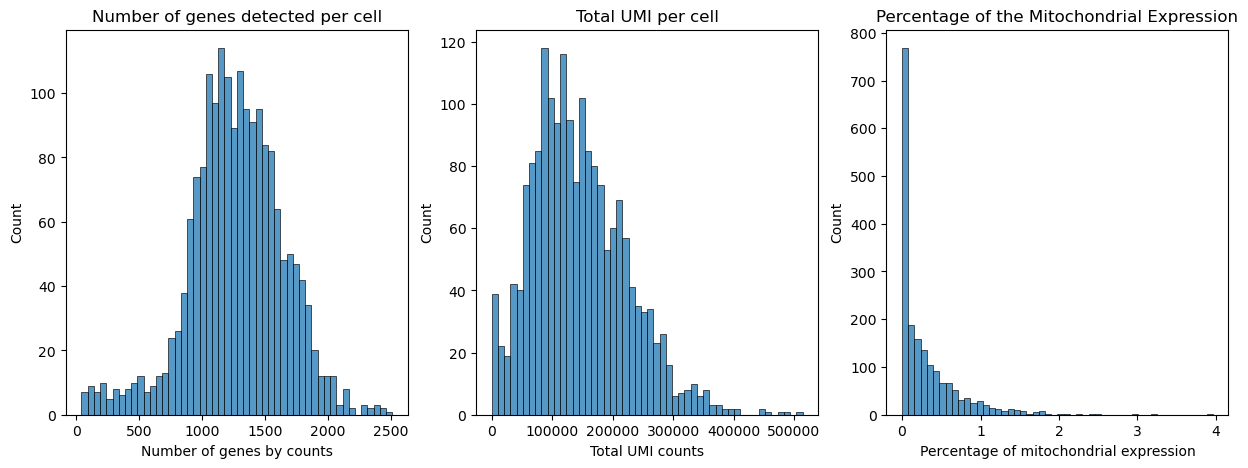

In [146]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(adata_glioblastoma_raw.obs["n_genes_by_counts"], bins=50, ax=axes[0])
axes[0].set_title("Number of genes detected per cell")
axes[0].set_xlabel("Number of genes by counts")
axes[0].set_ylabel("Count")

sns.histplot(adata_glioblastoma_raw.obs["total_counts"], bins=50, ax=axes[1])
axes[1].set_title("Total UMI per cell")
axes[1].set_xlabel("Total UMI counts")
axes[1].set_ylabel("Count")

sns.histplot(adata_glioblastoma_raw.obs["pct_mito"], bins=50, ax=axes[2])
axes[2].set_title("Percentage of the Mitochondrial Expression")
axes[2].set_xlabel("Percentage of mitochondrial expression")
axes[2].set_ylabel("Count")

plt.show()

In [147]:
# Display the first few rows of the .obs attribute as an HTML table
display(HTML(adata_glioblastoma_raw.obs.head().to_html()))

#### Correlation between number of genes by cell and total UMI counts

There is a clear positive correlation between the number of genes per cell and the total UMI counts. Cells with higher total UMI counts tend to have a greater number of detected genes, which is expected since higher sequencing depth or cellular activity often results in more genes being captured. The color gradient shows that cells with higher mitochondrial percentages (redder points) are scattered across the plot but tend to cluster in regions with lower total UMI counts and fewer detected genes. This suggests that cells with high mitochondrial activity may have lower overall transcriptional activity, potentially indicating stressed or dying cells.



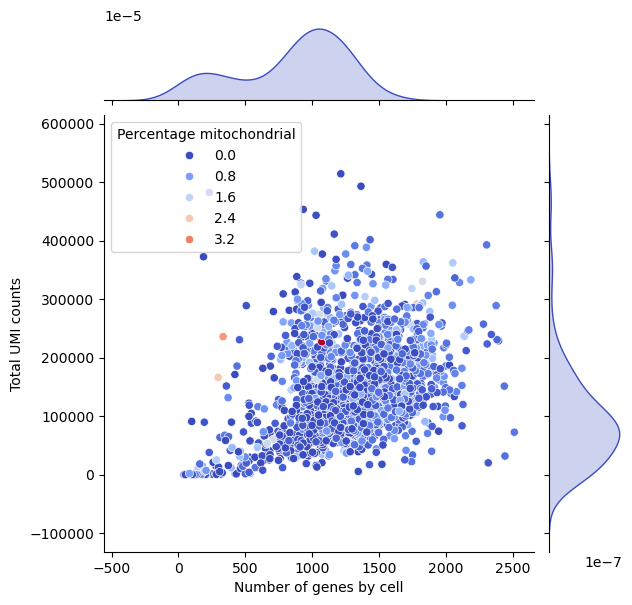

In [148]:
df = adata_glioblastoma_raw.obs[["n_genes_by_counts", "total_counts", "pct_mito"]].copy()
df.rename(columns={"n_genes_by_counts": "Number of genes by cell", 
                   "total_counts": "Total UMI counts", 
                   "pct_mito": "Percentage mitochondrial"}, inplace=True)

sns.jointplot(
    data=df,
    x="Number of genes by cell",
    y="Total UMI counts",
    hue="Percentage mitochondrial",
    palette="coolwarm",
    kind="scatter"
)

## Cell Filtering

`````{admonition} Why Do We Filter Cells?
:class: tip
We remove cells that are:  
1️⃣ **Low-quality or dead** → Few detected genes or low UMI counts.  
2️⃣ **Potential doublets** → Abnormally high UMI counts (two cells captured together).  
3️⃣ **Stressed or apoptotic** → High percentage of mitochondrial RNA.  
`````

#### Why These Thresholds?

1. **Minimum Genes per Cell (`min_genes = 200`)**:
   - This threshold ensures that only cells with at least 200 detected genes are retained. Cells with fewer genes are likely low-quality or empty droplets, which do not represent viable or biologically meaningful cells. This cutoff is commonly used in single-cell RNA-seq preprocessing to remove noise and artifacts from the dataset.  

2. **Maximum Genes per Cell (`max_genes = 5000`)**:
   - The upper limit of 5,000 genes per cell is set to exclude potential doublets or multiplets, where two or more cells are captured together, artificially inflating the number of detected genes. This threshold is adjusted to accommodate the complexity of tumor cells, which often exhibit higher transcriptional activity compared to normal cells.
3. **Minimum UMIs per Cell (`min_counts = 1000`)**:
   - A minimum of 1,000 total UMI counts per cell ensures sufficient sequencing depth to capture meaningful biological information. Cells with fewer counts are likely to be of low quality or insufficiently sequenced.
4. **Maximum Mitochondrial Percentage (`max_mito = 20`)**:
   - A maximum mitochondrial percentage of 20% is used to filter out cells with excessive mitochondrial gene expression, which is often indicative of stressed or dying cells. However, this threshold is set higher for cancer datasets, as tumor cells can exhibit elevated mitochondrial activity due to their altered metabolism and stress response.

In [149]:
# Filtering thresholds (adjusted for your dataset size)
min_genes = 200       # Minimum genes per cell (removes low-quality cells)
max_genes = 5000      # Upper limit (captures tumor cell complexity while excluding doublets)
min_counts = 1000     # Minimum UMIs/cell (ensures sufficient sequencing depth)
max_mito = 20         # Max mitochondrial % (higher tolerance for cancer cells)

# Apply filters
filtered_cells = (
    (adata_glioblastoma_raw.obs["n_genes_by_counts"] > min_genes) &
    (adata_glioblastoma_raw.obs["n_genes_by_counts"] < max_genes) &
    (adata_glioblastoma_raw.obs["total_counts"] > min_counts) &
    (adata_glioblastoma_raw.obs["pct_mito"] < max_mito)
)

adata_filtered = adata_glioblastoma_raw[filtered_cells].copy()

In [150]:
# Check retained cells/genes
print(f"Cells pre-filter: {adata_glioblastoma_raw.n_obs}, post-filter: {adata_filtered.n_obs}")
print(f"Genes pre-filter: {adata_glioblastoma_raw.n_vars}, post-filter: {adata_filtered.n_vars}")

Cells pre-filter: 1853, post-filter: 1823
Genes pre-filter: 7683, post-filter: 7683


#### Distribution of Cell Types Across Variables

1. **Number of Genes by Cell (`n_genes_by_cell`)**:
   - The violin plot for `n_genes_by_cell` shows variability across cell types:
     - **Astrocytes**, **immune cells**, and **vascular cells** have relatively lower median values and narrower distributions, indicating fewer detected genes per cell and less variability within these cell types.
     - **Neoplastic cells** exhibit the widest distribution and the highest median number of genes, reflecting their transcriptional complexity and heterogeneity, which is characteristic of tumor cells.
     - **Neurons** and **oligodendrocytes** show intermediate distributions, with neurons having slightly higher median values than oligodendrocytes.
     - **OPCs (oligodendrocyte precursor cells)** have a narrower distribution, suggesting a more uniform transcriptional profile compared to other cell types.
   - **Insights**: The high number of genes in neoplastic cells suggests their diverse transcriptional activity, while the lower values in astrocytes and vascular cells may reflect their more specialized roles.

2. **Total UMI Counts (`total_UMI_counts`)**:
   - The distribution of total UMI counts follows a similar pattern to `n_genes_by_cell`:
     - **Neoplastic cells** again show the highest median and widest distribution, consistent with their high transcriptional activity.
     - **Astrocytes**, **immune cells**, and **vascular cells** have lower median UMI counts and narrower distributions, indicating lower overall transcriptional activity.
     - **Neurons** and **oligodendrocytes** have intermediate UMI counts, with neurons showing slightly higher values.
     - **OPCs** have a relatively narrow distribution, similar to their pattern in `n_genes_by_cell`.
   - **Insights**: The high UMI counts in neoplastic cells further support their transcriptional heterogeneity, while the lower counts in astrocytes and vascular cells suggest more specialized and less active transcriptional states.

3. **Percentage of Mitochondrial Counts (`pct_mito`)**:
   - The mitochondrial percentage varies significantly across cell types:
     - **Astrocytes** and **immune cells** have the highest median mitochondrial percentages, with astrocytes showing a particularly wide distribution. This may indicate higher mitochondrial activity or stress in these cell types.
     - **Neoplastic cells** have a moderate mitochondrial percentage, with a relatively wide distribution, reflecting their metabolic diversity.
     - **Neurons**, **OPCs**, **oligodendrocytes**, and **vascular cells** have lower mitochondrial percentages, with vascular cells showing the narrowest distribution and lowest median values.
   - **Insights**: The high mitochondrial percentages in astrocytes and immune cells may reflect their active roles in maintaining homeostasis and responding to stress. The moderate mitochondrial activity in neoplastic cells could be linked to their altered metabolism, while the low percentages in neurons and vascular cells suggest less mitochondrial involvement in their transcriptional profiles.

C:\Users\henry\AppData\Local\Temp\ipykernel_10808\2847459098.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\henry\AppData\Local\Temp\ipykernel_10808\2847459098.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\henry\AppData\Local\Temp\ipykernel_10808\2847459098.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


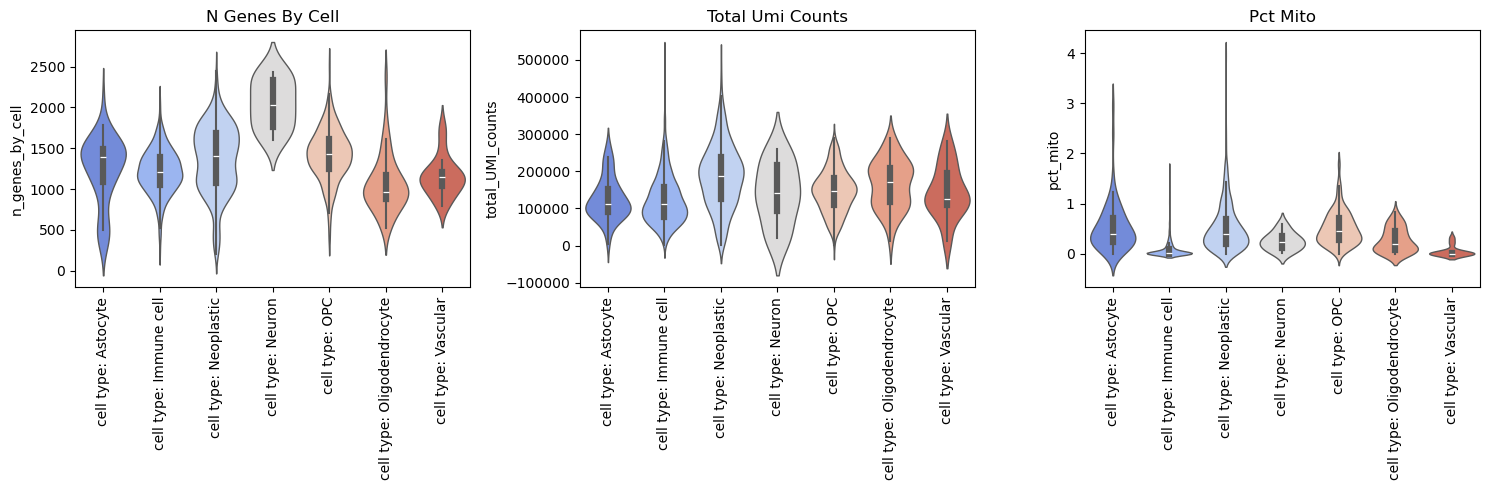

In [151]:
# Convert relevant data from adata_filtered to DataFrame
df = pd.DataFrame({
    'n_genes_by_cell': adata_filtered.obs['n_genes_by_counts'],  # Corrected column name
    'total_UMI_counts': adata_filtered.obs['total_counts'],      # Corrected column name
    'pct_mito': adata_filtered.obs['pct_mito'],
    'cell_type': adata_filtered.obs['cell_type']
})
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each metric 
for ax, metric in zip(axes, ['n_genes_by_cell', 'total_UMI_counts', 'pct_mito']):
    sns.violinplot(
        data=df,
        x='cell_type',
        y=metric,
        hue='cell_type',  # Needed for palette
        palette='coolwarm',
        legend=False,     # Disables legend
        ax=ax,
        density_norm='width',  # Replaces deprecated 'scale'
        linewidth=1       # Makes violin borders more visible
    )
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

## Doublets and Singlets in Single-Cell RNA-Seq (scRNA-Seq)

```{} What are the singlet and doublets?

In single-cell RNA sequencing (scRNA-Seq), the terms **"doublet"** and **"singlet"** refer to the nature of the captured cells in the experiment:

- **Singlet** → A single individual cell encapsulated in a droplet or captured in a well.
- **Doublet** → Two cells encapsulated together in the same droplet, which can lead to contaminated or mixed data in the analysis.
```

### 🔬 Why is it important to detect doublets?
Doublets can lead to **false interpretations** in the analysis, as they may appear to be a new cell type with a combined expression profile of two real cells. This affects:

- **Cell type identification** (they may seem like new cell types that do not actually exist).
- **Analysis of cellular subpopulations**.
- **Inference of cell relationships and trajectories**.

In [152]:
# Extract counts matrix (assuming adata_filtered.X contains raw counts)
counts_matrix = adata_filtered.X

In [153]:
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.015) # Question for achim abut this range

Expected Doublet Rate Calculation

For droplet-based single-cell RNA sequencing (e.g., 10x Genomics), the expected doublet rate follows a linear relationship with cell loading density:**Recommended Doublet Detection Threshold for Your Data**, Where:
- **0.0008** is the empirical coefficient representing ~0.8% doublets per 1,000 cells
- This value comes from controlled experimental measurements

**1. Expected Doublet Rate Calculation**  

For **1,853 cells**, the estimated doublet rate is:  

$$\text{Expected Doublet Rate} = 1,853 \times 0.008 = 1.5\% $$

In [154]:
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.16
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 15.4%
Overall doublet rate:
	Expected   = 1.5%
	Estimated  = 0.0%
Elapsed time: 2.1 seconds


In [155]:
adata_filtered.obs['doublet_score'] = doublet_scores
adata_filtered.obs['predicted_doublet'] = predicted_doublets

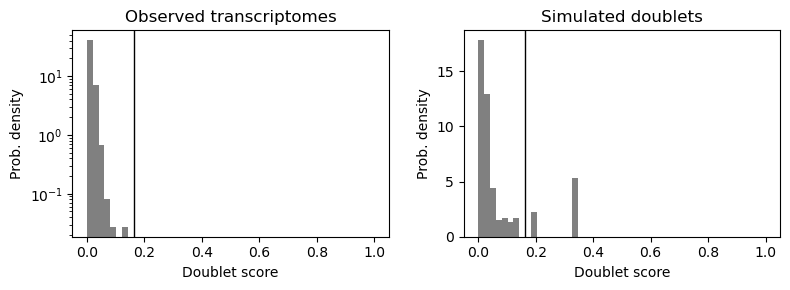

In [156]:
scrub.plot_histogram()
plt.show()


In [157]:
print(f"Detected doublet rate: {100*predicted_doublets.mean():.1f}%")
print(f"Number of predicted doublets: {predicted_doublets.sum()}")

Detected doublet rate: 0.0%
Number of predicted doublets: 0


**Visual inspection of scores vs. QC metrics**

A few cells exhibit slightly higher doublet scores (up to ~0.14), but these are sparse and do not form a significant cluster, suggesting that potential doublets are rare in this dataset. The expected doublet rate (based on experimental design) is **1.5%** and the estimated doublet rate (based on Scrublet's analysis) is **0.0%**, indicating that no doublets were identified in the dataset.

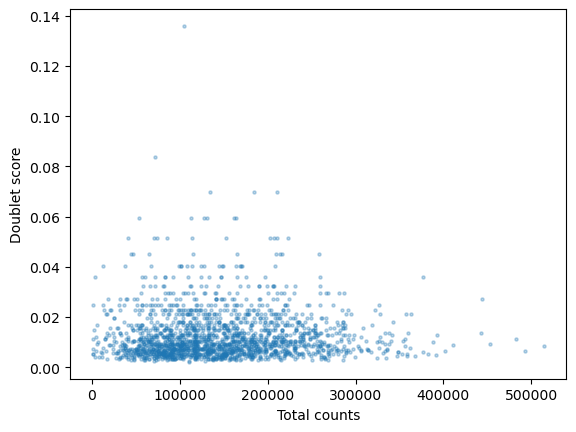

In [158]:
plt.scatter(adata_filtered.obs['total_counts'], adata_filtered.obs['doublet_score'], s=5, alpha=0.3)
plt.xlabel('Total counts')
plt.ylabel('Doublet score')
plt.show()

In [159]:
# Filtering and visualization
print(f"Before filtering doublets: {adata_filtered.n_obs} cells")
adata_filtered = adata_filtered[~adata_filtered.obs['predicted_doublet'], :].copy()
print(f"After filtering doublets: {adata_filtered.n_obs} cells")

Before filtering doublets: 1823 cells
After filtering doublets: 1823 cells


#### Umap distribution for doublets

This UMAP plot visualizes the distribution of cells in a reduced-dimensional space, with each point representing a cell. The color gradient corresponds to the **doublet scores** assigned to each cell, ranging from low (blue) to high (red).

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\scanpy\tools\_utils.py:41: UserWarning: You’re trying to run this on 7683 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


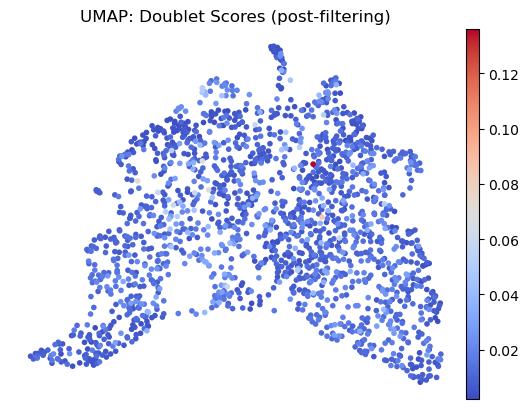

In [160]:
# Visualize remaining cells in UMAP
sc.pp.neighbors(adata_filtered)
sc.tl.umap(adata_filtered)

sc.pl.umap(adata_filtered, 
           color='doublet_score', 
           color_map='coolwarm', 
           title='UMAP: Doublet Scores (post-filtering)',
           frameon=False)

In [161]:
# adata_filtered.write('your_cleaned_data.h5ad')

## Data Normalization, Transformation and Standarization

  In this step we have to normalize the **total UMI counts per cell**. This means each cell's total count is rescaled to **10,000**, ensuring comparability across cells.  To get that we apply a **log transformation** to all gene expression values in `adata_glioblastoma_filtered.X`.  

***Variables normalized*** 
- The **gene expression values** (UMI counts) were normalized.  
- Other metadata variables (such as `n_counts_by_cell`, `total_counts`, or `pct_mito`) were **not modified**—these remain in `adata_filtered.obs`.  



In [162]:
# Normalize to median total counts (CPM-like normalization)
sc.pp.normalize_total(adata_filtered, target_sum=1e4)

### **Transformation**

***Log Transformation Formula*** 

The log transformation used is:  

$$ \text{log1p}(x) = \log(1 + x) $$  

This helps stabilize variance and make the data more normally distributed.

In [163]:
# Log-transform the normalized data (log1p = log(1+x))
sc.pp.log1p(adata_filtered)

### **Select the most highly variable genes**

Uses the Seurat v3 method to find highly variable genes. It selects the top 2,000 most variable genes for further analysis.

In [164]:
# Identify highly variable genes (HVGs)
sc.pp.highly_variable_genes(
    adata_filtered,
    n_top_genes=2000,          # Keep top 2.500 variable genes
    flavor='seurat',           # Method used by Seurat (mean-variance relationship)
    subset=True                # Keep only HVGs for downstream analysis
)


### **Standarization**

```{admonition} Why Standardize?
Standardization transforms gene expression values to:

- Center and scale features: Each gene has mean = 0 and variance = 1

- Prevents highly expressed genes from dominating analysis:

- Improve PCA performance: Ensures all genes contribute equally to principal components

- Enable distance-based methods: Clustering (e.g., Leiden) and visualization (UMAP/t-SNE) require comparable feature scales
```

For each gene g:

$$\text{Scaled Expression} = \frac{X_{g} - \mu_{g}}{\sigma_{g}}$$

Where:
$$X_{g}: \text{Log-normalized expression}$$ 
$$\mu_{g}: \text{Mean expression across cells}$$  
$$\sigma_{g}: \text{Standard deviation}$$

In [165]:
# Scale to unit variance and zero mean (z-score)
sc.pp.scale(adata_filtered, max_value=10)

In [166]:
# Verify results
print(adata_filtered)
print(f"Number of HVGs selected: {adata_filtered.n_vars}")

AnnData object with n_obs × n_vars = 1823 × 2000
    obs: 'disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'mito_UMI_counts', 'pct_mito', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'Mapped_Gene', 'Is_Mitochondrial', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
Number of HVGs selected: 2000


A clear trend is visible: genes with higher mean expression tend to have higher dispersion. This is expected, as technical noise and biological variability both increase with expression levels.

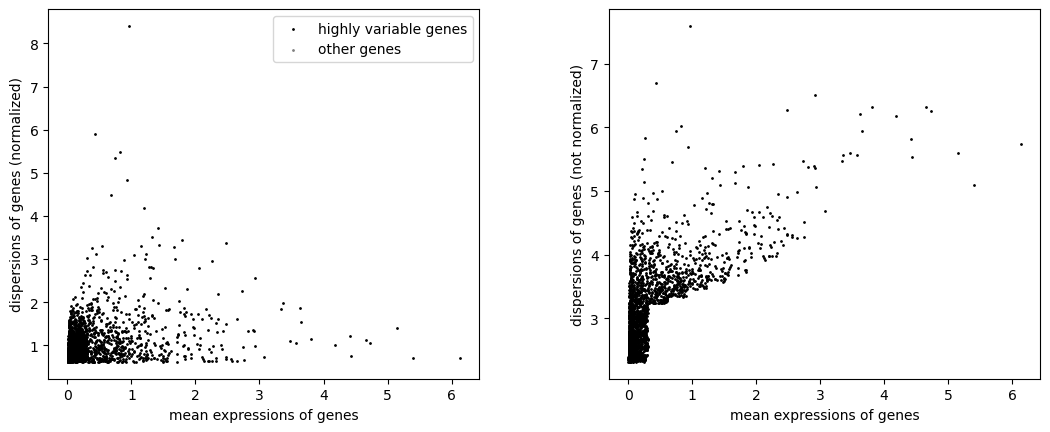

In [167]:
sc.pl.highly_variable_genes(adata_filtered)


A smaller number of genes have higher mean expression values, extending toward the right side of the plot. These genes are likely housekeeping genes or highly expressed genes with consistent expression across cells. The color gradient highlights the normalized dispersion values, with yellow points representing genes with the highest variability

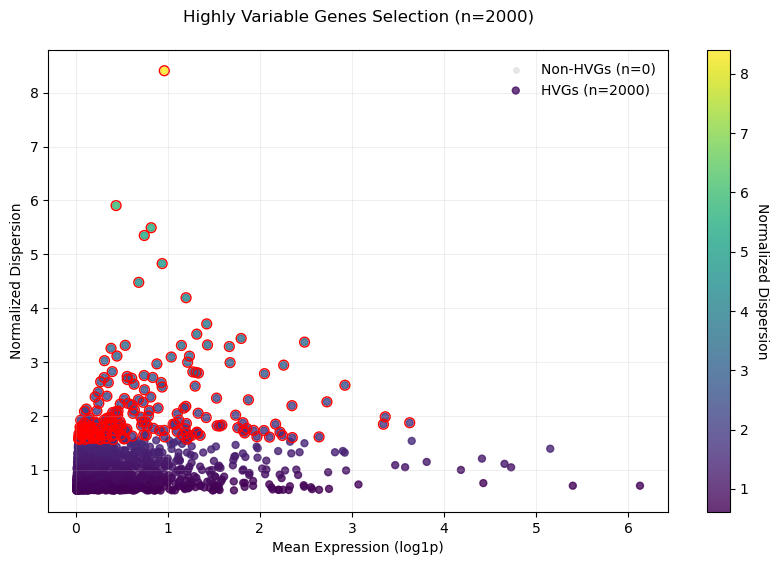

In [168]:
# Create a publication-quality HVG plot
plt.figure(figsize=(10, 6))

# Plot non-HVGs in light gray
plt.scatter(
    x=adata_filtered.var[~adata_filtered.var['highly_variable']]['means'],
    y=adata_filtered.var[~adata_filtered.var['highly_variable']]['dispersions_norm'],
    c='lightgray',
    s=15,
    alpha=0.5,
    label='Non-HVGs (n={})'.format(adata_filtered.n_vars - 2000)
)

# Plot HVGs with dispersion-based coloring
hvg_subset = adata_filtered.var[adata_filtered.var['highly_variable']]
scatter = plt.scatter(
    x=hvg_subset['means'],
    y=hvg_subset['dispersions_norm'],
    c=hvg_subset['dispersions_norm'],  # Color by dispersion value
    cmap='viridis',
    s=25,
    alpha=0.8,
    label='HVGs (n=2000)'
)

# Add colorbar for dispersion values
cbar = plt.colorbar(scatter)
cbar.set_label('Normalized Dispersion', rotation=270, labelpad=15)

# Formatting
plt.title('Highly Variable Genes Selection (n=2000)', pad=20)
plt.xlabel('Mean Expression (log1p)')
plt.ylabel('Normalized Dispersion')
plt.legend(frameon=False)
plt.grid(True, alpha=0.2)

# Highlight the top 10% most dispersed genes
top_10_pct = hvg_subset.nlargest(200, 'dispersions_norm')
plt.scatter(
    x=top_10_pct['means'],
    y=top_10_pct['dispersions_norm'],
    edgecolors='red',
    facecolors='none',
    s=50,
    linewidths=1,
    label='Top 10% HVGs'
)

plt.show()

## Batch Correction

In [169]:
adata_original = adata_filtered.copy()

# Remove zero-variance genes
gene_variances = np.var(
    adata_filtered.X.toarray() if hasattr(adata_filtered.X, "toarray") else adata_filtered.X,
    axis=0
)
genes_to_keep = gene_variances > 0
adata_filtered = adata_filtered[:, genes_to_keep]

In [170]:
sc.pp.pca(adata_filtered, n_comps=50)

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\scanpy\preprocessing\_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [171]:
print("Running Harmony batch correction...")
harmony_out = hp.run_harmony(
    adata_filtered.obsm['X_pca'],
    adata_filtered.obs,
    ['plate_id']
)
adata_filtered.obsm['X_harmony'] = harmony_out.Z_corr.T
print("Harmony correction complete.")

2025-04-30 09:05:29,439 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony batch correction...


2025-04-30 09:05:31,908 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-30 09:05:31,924 - harmonypy - INFO - Iteration 1 of 10
2025-04-30 09:05:34,144 - harmonypy - INFO - Iteration 2 of 10
2025-04-30 09:05:35,063 - harmonypy - INFO - Iteration 3 of 10
2025-04-30 09:05:36,249 - harmonypy - INFO - Iteration 4 of 10
2025-04-30 09:05:37,457 - harmonypy - INFO - Iteration 5 of 10
2025-04-30 09:05:40,437 - harmonypy - INFO - Iteration 6 of 10
2025-04-30 09:05:42,919 - harmonypy - INFO - Iteration 7 of 10
2025-04-30 09:05:43,486 - harmonypy - INFO - Iteration 8 of 10
2025-04-30 09:05:45,727 - harmonypy - INFO - Iteration 9 of 10
2025-04-30 09:05:47,469 - harmonypy - INFO - Iteration 10 of 10
2025-04-30 09:05:49,355 - harmonypy - INFO - Stopped before convergence


Harmony correction complete.


In [172]:
# Compute neighbors and UMAP using Harmony embedding
sc.pp.neighbors(adata_filtered, use_rep='X_harmony')
sc.tl.umap(adata_filtered)

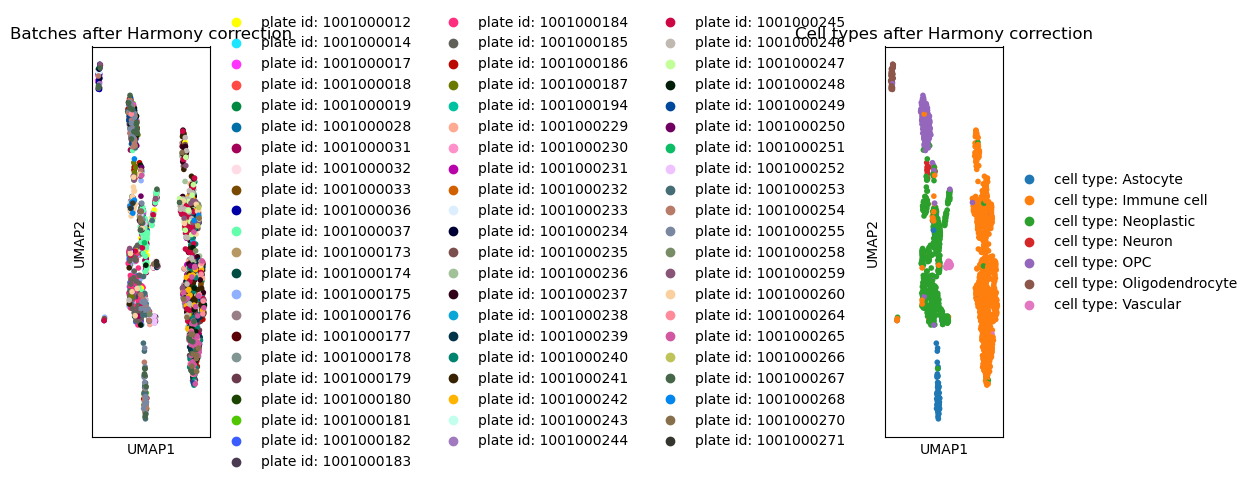

In [173]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(
    adata_filtered,
    color='plate_id',
    ax=ax1,
    title='Batches after Harmony correction',
    show=False
)
sc.pl.umap(
    adata_filtered,
    color='cell_type',
    ax=ax2,
    title='Cell types after Harmony correction',
    show=False
)

plt.tight_layout()
plt.show()

In [174]:
# Print summary statistics
print("\nShape of data after Harmony correction:", adata_filtered.shape)
print("Number of batches:", len(adata_filtered.obs['plate_id'].unique()))


Shape of data after Harmony correction: (1823, 2000)
Number of batches: 64


## Dimensionality reduction

````{admonition} What is dimensionality reduction?
Dimensionality reduction is the process of transforming high-dimensional data into a lower-dimensional space while preserving the most important features or patterns. In the context of single-cell RNA sequencing (scRNA-seq), where each cell is represented by thousands of gene expression values, dimensionality reduction is crucial for simplifying the data, reducing noise, and enabling meaningful visualization and analysis.
```

### Using PCA

- The first few PCs (e.g., PC1, PC2, PC3) explain the largest proportion of variance, with a steep drop-off in variance explained as the ranking increases.
- After approximately the 10th PC, the variance explained by each additional PC becomes minimal, indicating diminishing returns in terms of information captured.

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\scanpy\preprocessing\_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


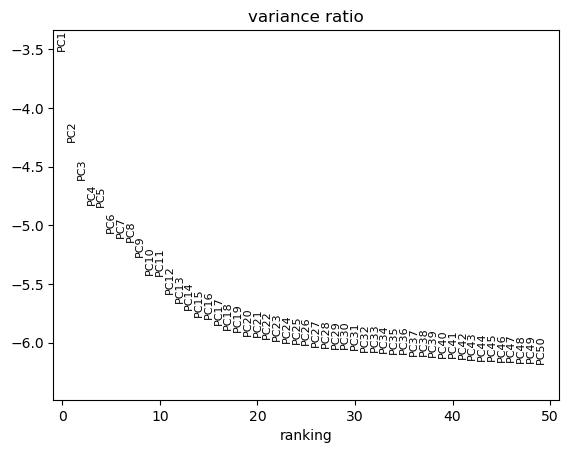

In [175]:
# Run PCA (using ARPACK for reproducibility)
sc.tl.pca(adata_filtered, 
          n_comps=50, 
          svd_solver='arpack',  # Best for reproducibility
          use_highly_variable=True)  # Use the 2000 HVGs

# Plot variance explained
sc.pl.pca_variance_ratio(adata_filtered, n_pcs=50, log=True)

In [176]:
np.cumsum(adata_filtered.uns['pca']['variance_ratio'])

array([0.02982847, 0.04353569, 0.0534675 , 0.06150168, 0.06939694,
       0.07571189, 0.08177835, 0.08763348, 0.09276243, 0.097189  ,
       0.10155126, 0.10531369, 0.10880657, 0.11208757, 0.11517075,
       0.11819483, 0.12108765, 0.12385833, 0.12657326, 0.12920351,
       0.13181002, 0.13437727, 0.13689186, 0.1393744 , 0.14182699,
       0.14426738, 0.14666459, 0.14902763, 0.15138672, 0.15372702,
       0.15605642, 0.15835232, 0.16064428, 0.16291155, 0.16516817,
       0.16741067, 0.16963257, 0.1718447 , 0.17403933, 0.17621431,
       0.17838238, 0.1805329 , 0.18266787, 0.18479817, 0.18692064,
       0.18902254, 0.19111815, 0.1932109 , 0.19529845, 0.19737189],
      dtype=float32)

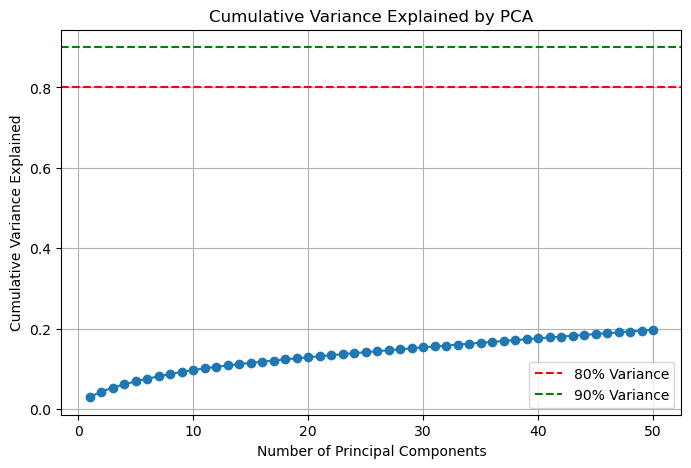

In [177]:
cumulative_variance = np.cumsum(adata_filtered.uns['pca']['variance_ratio'])

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

# Labels and title
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by PCA')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance')  # Mark 80% threshold
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Variance')  # Mark 90% threshold
plt.legend()
plt.grid()

# Show plot
plt.show()

#### Caclulate performance metrics

In [178]:
# Helper: get embedding from AnnData
def get_embedding(adata, key):
    if key == 'X_pca':
        return adata.obsm['X_pca']
    elif key == 'X_harmony':
        return adata.obsm['X_harmony']
    else:
        raise ValueError("Unknown embedding key")

In [179]:
# Helper: calculate batch entropy mixing
def batch_entropy(adata, embedding_key, batch_key, n_neighbors=30):
    from sklearn.neighbors import NearestNeighbors
    X = adata.obsm[embedding_key]
    batches = adata.obs[batch_key].values
    le = LabelEncoder()
    batch_labels = le.fit_transform(batches)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1).fit(X)
    _, indices = nbrs.kneighbors(X)
    entropies = []
    for i, neighbors in enumerate(indices):
        neighbor_batches = batch_labels[neighbors[1:]]  # exclude self
        probs = np.bincount(neighbor_batches, minlength=len(le.classes_)) / n_neighbors
        entropy = -np.sum([p * np.log2(p) for p in probs if p > 0])
        entropies.append(entropy)
    return np.mean(entropies)

In [180]:
# Calculate metrics for PCA
pca_embedding = get_embedding(adata_filtered, 'X_pca')
cell_types = adata_filtered.obs['cell_type'].values
batches = adata_filtered.obs['plate_id'].values

silhouette_pca = silhouette_score(pca_embedding, cell_types)
batch_entropy_pca = batch_entropy(adata_filtered, 'X_pca', 'plate_id')

In [181]:
# Calculate metrics for Harmony
harmony_embedding = get_embedding(adata_filtered, 'X_harmony')
silhouette_harmony = silhouette_score(harmony_embedding, cell_types)
batch_entropy_harmony = batch_entropy(adata_filtered, 'X_harmony', 'plate_id')

In [182]:
# Helper: calculate ARI and NMI
def clustering_metrics(embedding, true_labels, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embedding)
    pred_labels = kmeans.labels_
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    return ari, nmi

In [183]:
# Helper: variance explained (for PCA)
def variance_explained(adata):
    if 'pca' in adata.uns and 'variance_ratio' in adata.uns['pca']:
        return np.sum(adata.uns['pca']['variance_ratio'])
    else:
        return np.nan

In [184]:
results = pd.DataFrame({
    'Method': ['PCA', 'Harmony'],
    'Silhouette Score (cell type)': [silhouette_pca, silhouette_harmony],
    'Batch Entropy Mixing': [batch_entropy_pca, batch_entropy_harmony]
})

In [185]:
methods = {
    'PCA': 'X_pca',
    'Harmony': 'X_harmony',
}

In [186]:
results = []

# Encode cell types for metrics
cell_types = LabelEncoder().fit_transform(adata_filtered.obs['cell_type'])
n_cell_types = len(np.unique(cell_types))

In [187]:
for method, emb_key in methods.items():
    embedding = get_embedding(adata_filtered, emb_key)
    # Silhouette Score
    silhouette = silhouette_score(embedding, cell_types)
    # Batch Entropy
    batch_entropy_val = batch_entropy(adata_filtered, emb_key, 'plate_id')
    # ARI & NMI (using KMeans, number of clusters = number of cell types)
    ari, nmi = clustering_metrics(embedding, cell_types, n_cell_types)
    # Variance explained (only for PCA)
    var_exp = variance_explained(adata_filtered) if method == 'PCA' else np.nan
    # Append to results
    results.append({
        'Method': method,
        'Silhouette Score (cell type)': silhouette,
        'Batch Entropy Mixing': batch_entropy_val,
        'ARI': ari,
        'NMI': nmi,
        'Variance Explained': var_exp
    })

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [188]:
results_df = pd.DataFrame(results)
results_df

Method  Silhouette Score (cell type)  Batch Entropy Mixing       ARI  \
0      PCA                      0.189582              2.895963  0.537578   
1  Harmony                      0.218689              3.488787  0.550414   

        NMI  Variance Explained  
0  0.649484            0.197372  
1  0.674881                 NaN

**Selecting the best numbers of neighbors**

In [189]:
for k in [10, 15, 20, 30]:
    sc.pp.neighbors(adata_filtered, n_pcs=30, n_neighbors=k)
    sc.tl.leiden(adata_filtered, resolution=0.6, key_added=f'clust_k{k}')
    
    # Calculate silhouette score
    from sklearn.metrics import silhouette_score
    score = silhouette_score(adata_filtered.obsm['X_pca'][:,:30], 
                            adata_filtered.obs[f'clust_k{k}'])
    print(f"k={k}: Silhouette = {score:.3f}")

k=10: Silhouette = 0.191
k=15: Silhouette = 0.182
k=20: Silhouette = 0.180
k=30: Silhouette = 0.160


#### Neighbourhood Graph and Umap

```{admonition} What is UMAP?
UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique commonly used in single-cell RNA sequencing (scRNA-seq) analysis. It reduces high-dimensional data (like thousands of gene expression values per cell) into a 2D or 3D representation while preserving the local structure of the data. This allows us to visualize relationships between cells in a lower-dimensional space.
```

In [190]:
# Build graph with optimal k=10
sc.pp.neighbors(
    adata_filtered,
    n_pcs=30,       # From variance plot
    n_neighbors=10,  # From silhouette
    metric='euclidean'
)

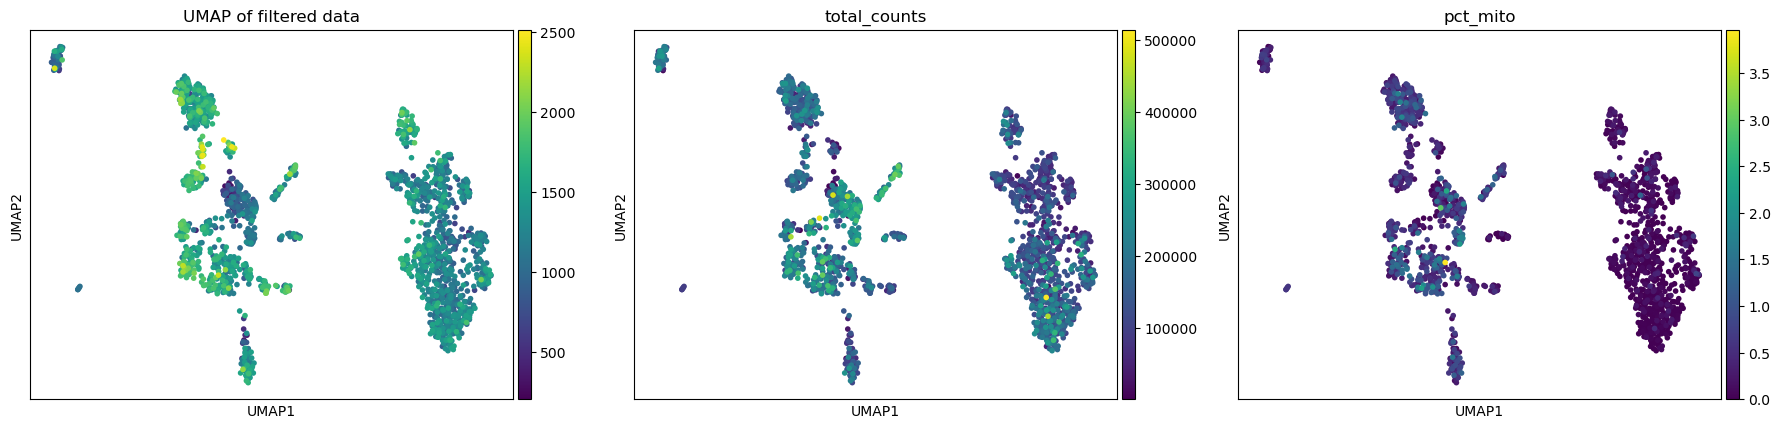

In [191]:
sc.pl.umap(adata_filtered, color=["n_genes_by_counts", "total_counts", "pct_mito"], ncols=3, title="UMAP of filtered data")

```{admonition} What is granularity in clusters?
In clustering algorithms like **Leiden** and **Louvain**, the **resolution parameter** controls the granularity of the clusters. It determines how finely or coarsely the data is partitioned into clusters. A higher resolution results in more, smaller clusters, while a lower resolution produces fewer, larger clusters.
```

### Clustering techniques

#### Using Leidein

The resolution parameter in Leiden clustering controls how granular your clusters will be:

- 0.4	Fewer, broader clusters	Identifying major cell types
- 0.6	Moderate clustering (default)	Balancing specificity/size
- 0.8	More, finer clusters	Detecting rare subtypes

In [ ]:
# Cluster at multiple resolutions
for res in [0.4, 0.6, 0.8]:
    sc.tl.leiden(
        adata_filtered,
        resolution=res,
        key_added=f'leiden_r{res}'
    )

In [ ]:
  
# Get cluster counts for each resolution
cluster_counts_r06 = adata_filtered.obs['leiden_r0.4'].value_counts().sort_index(ascending=True)
cluster_counts_r04 = adata_filtered.obs['leiden_r0.6'].value_counts().sort_index(ascending=True)
cluster_counts_r08 = adata_filtered.obs['leiden_r0.8'].value_counts().sort_index(ascending=True)


# Create a DataFrame
df_clusters = pd.DataFrame({
    'Leiden (r=0.4)': cluster_counts_r04,
    'Leiden (r=0.6)': cluster_counts_r06,
    'Leiden (r=0.8)': cluster_counts_r08
}).fillna(0).astype(int)  # Fill missing values with 0 and convert to integer

# Display table
print(df_clusters)

    Leiden (r=0.4)  Leiden (r=0.6)  Leiden (r=0.8)
0              315             324             237
1              296             323             223
10              42              11              56
11              22               5              47
12              11               0              42
13               5               0              27
14               0               0              22
15               0               0              11
16               0               0               5
2              238             315             220
3              223             259             215
4              220             220             186
5              191             190             165
6               76              56             136
7               72              56              99
8               56              42              76
9               56              22              56


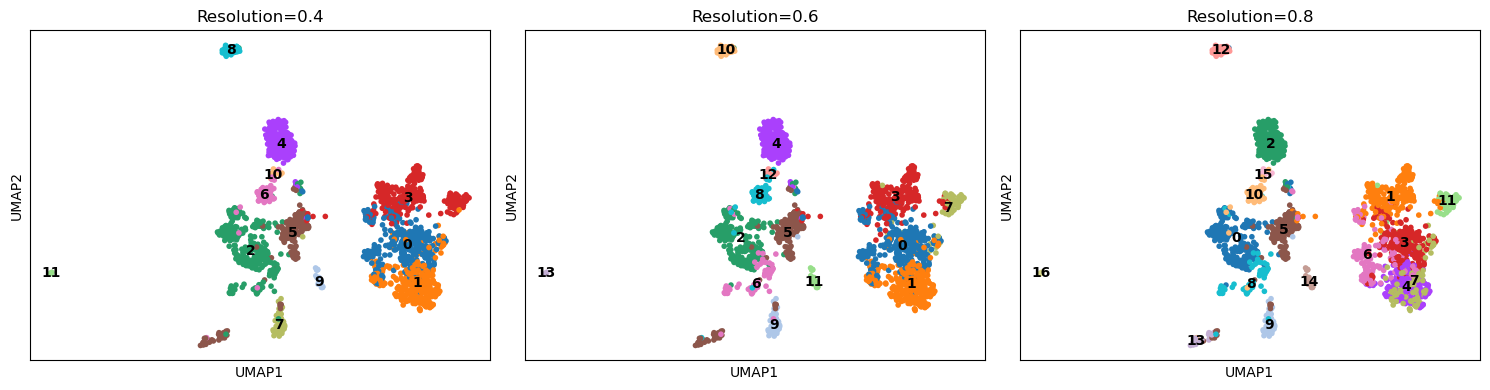

In [ ]:
# Create a 3-panel plot comparing resolutions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, res in zip(axes, [0.4, 0.6, 0.8]):
    sc.pl.umap(
        adata_filtered,
        color=f'leiden_r{res}',
        title=f'Resolution={res}',
        ax=ax,
        legend_loc='on data',
        show=False
    )
plt.tight_layout()
plt.show()

```{admonition} What is silhoutte score?
The **silhouette score** is a metric used to evaluate the quality of clustering. It measures how similar a cell is to other cells in its own cluster compared to cells in other clusters. The score ranges from -1 to 1:
- A score close to **1** indicates that cells are well-matched to their own cluster and poorly matched to other clusters (good clustering).
- A score close to **0** indicates that cells are on the boundary between clusters.
- A score close to **-1** indicates that cells may be assigned to the wrong cluster.
```

The Leiden clustering results show that **resolution 0.6** provides the best-defined clusters based on the silhouette score. Lower resolutions (e.g., 0.4) result in broader clusters, while higher resolutions (e.g., 0.8) lead to finer granularity but less well-defined clusters.

In [ ]:
from sklearn.metrics import silhouette_score

for res in [0.4, 0.6, 0.8]:
    score = silhouette_score(
        adata_filtered.obsm['X_pca'][:,:30], 
        adata_filtered.obs[f'leiden_r{res}']
    )
    print(f"Resolution {res}: Silhouette = {score:.3f}")

Resolution 0.4: Silhouette = 0.177
Resolution 0.6: Silhouette = 0.191
Resolution 0.8: Silhouette = 0.159


#### Clustering with louvain

In [ ]:
for res in [0.4, 0.6, 0.8]:
    sc.tl.louvain(
        adata_filtered,
        resolution=res,
        key_added=f'louvain_r{res}',
        random_state=42
    )

In [ ]:
# Get cluster counts for each resolution
louvain_counts_r04 = adata_filtered.obs['louvain_r0.4'].value_counts().sort_index(ascending=True)
louvain_counts_r06 = adata_filtered.obs['louvain_r0.6'].value_counts().sort_index(ascending=True)
louvain_counts_r08 = adata_filtered.obs['louvain_r0.8'].value_counts().sort_index(ascending=True)

# Create a DataFrame
df_louvain = pd.DataFrame({
    'Louvain (r=0.4)': louvain_counts_r04,
    'Louvain (r=0.6)': louvain_counts_r06,
    'Louvain (r=0.8)': louvain_counts_r08
}).fillna(0).astype(int)  # Fill missing values with 0 and convert to integer

# Display table
print(df_louvain)

    Louvain (r=0.4)  Louvain (r=0.6)  Louvain (r=0.8)
0               348              350              350
1               285              320              291
10                0               23               42
11                0               11               23
12                0                0               11
2               270              268              230
3               241              235              223
4               220              220              220
5               215              192              192
6               135               56               79
7                67               56               56
8                42               50               56
9                 0               42               50


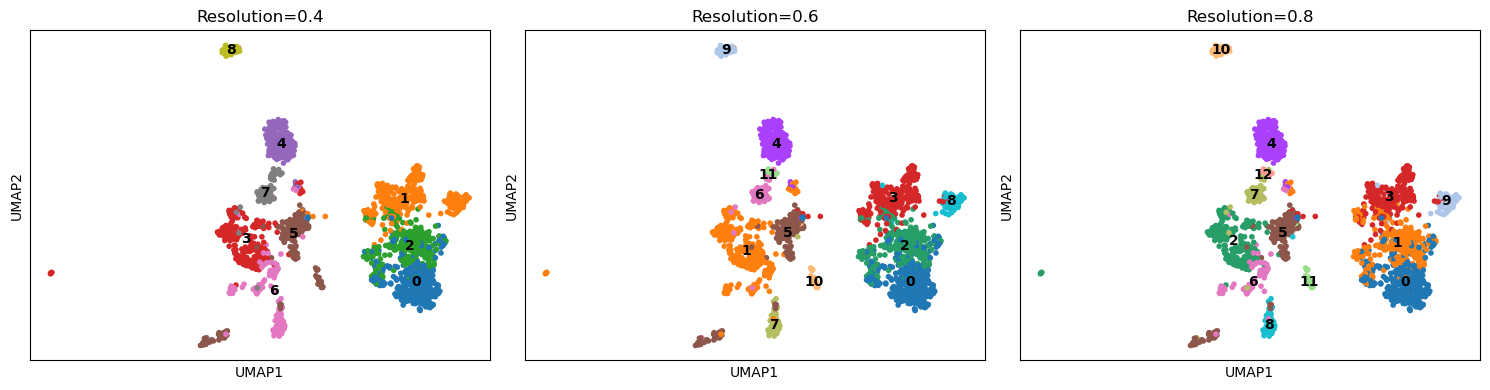

In [ ]:
# Create a 3-panel plot comparing resolutions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, res in zip(axes, [0.4, 0.6, 0.8]):
    sc.pl.umap(
        adata_filtered,
        color=f'louvain_r{res}',
        title=f'Resolution={res}',
        ax=ax,
        legend_loc='on data',
        show=False
    )
plt.tight_layout()
plt.show()

The Louvain clustering results show that higher resolutions lead to more clusters with smaller sizes, similar to the Leiden algorithm. However, Louvain tends to produce fewer, larger clusters compared to Leiden. The silhouette scores indicate that the clusters become more well-defined at higher resolutions, with the best score observed at **resolution 0.8**.

In [ ]:
for res in [0.4, 0.6, 0.8]:
    score = silhouette_score(
        adata_filtered.obsm['X_pca'][:,:30], 
        adata_filtered.obs[f'louvain_r{res}']
    )
    print(f"Resolution {res}: Silhouette = {score:.3f}")

Resolution 0.4: Silhouette = 0.157
Resolution 0.6: Silhouette = 0.176
Resolution 0.8: Silhouette = 0.197


#### Comparation between clusters

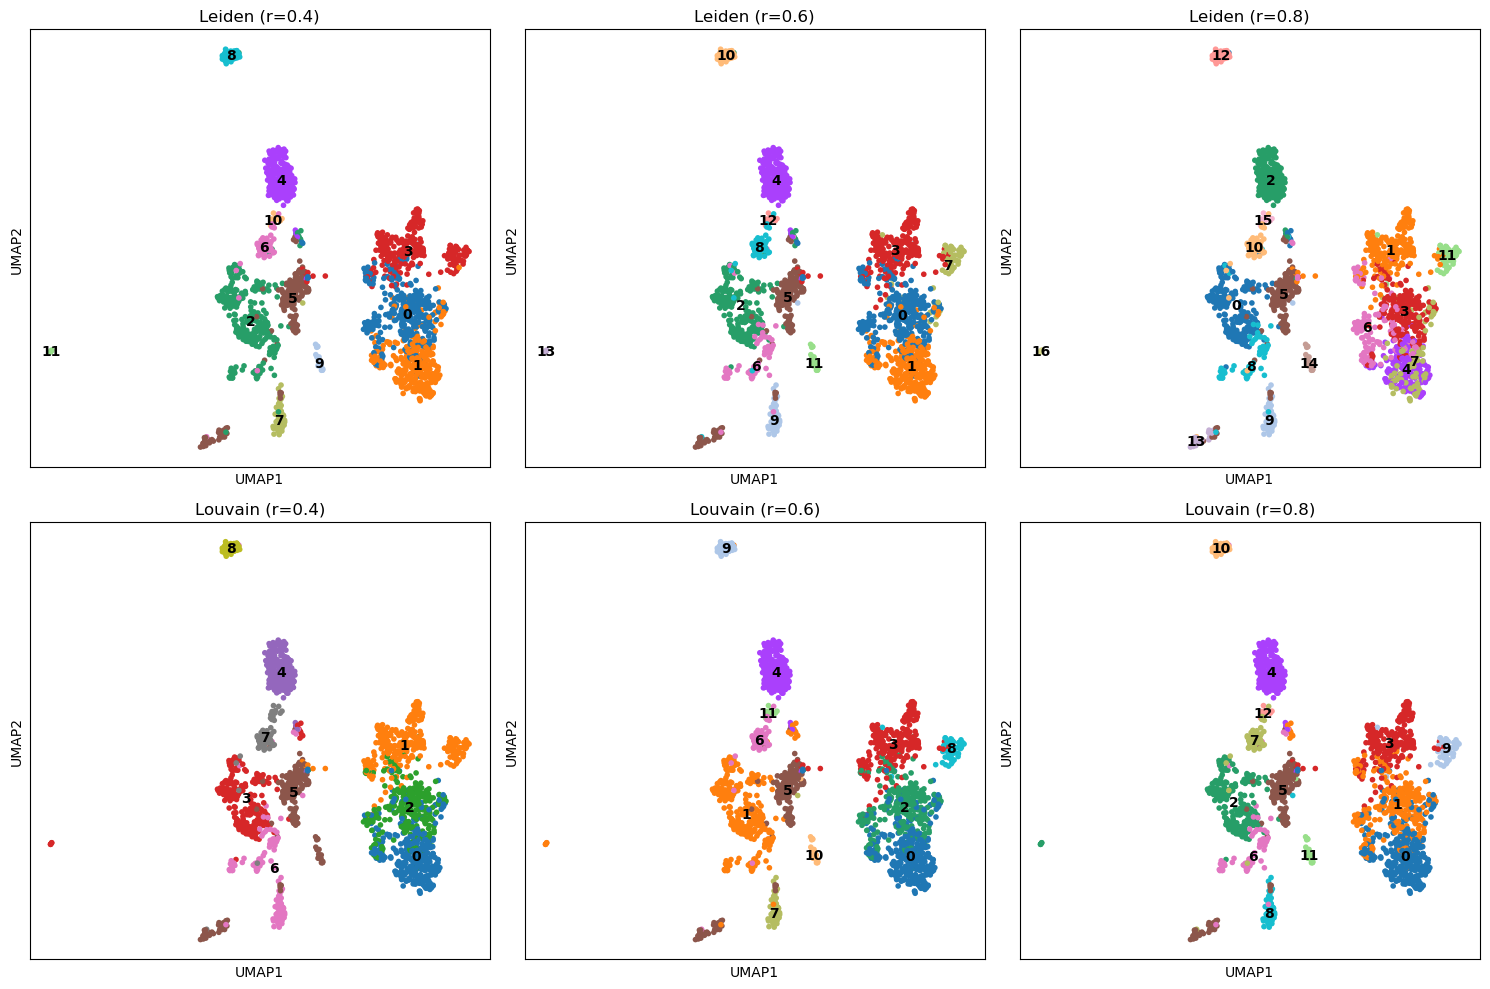

In [ ]:
import matplotlib.pyplot as plt

# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Leiden results
for i, res in enumerate([0.4, 0.6, 0.8]):
    sc.pl.umap(
        adata_filtered,
        color=f'leiden_r{res}',
        title=f'Leiden (r={res})',
        ax=axes[0,i],
        legend_loc='on data',
        show=False
    )

# Louvain results
for i, res in enumerate([0.4, 0.6, 0.8]):
    sc.pl.umap(
        adata_filtered,
        color=f'louvain_r{res}',
        title=f'Louvain (r={res})',
        ax=axes[1,i],
        legend_loc='on data',
        show=False
    )

plt.tight_layout()
plt.show()

**Cluster size comparison**
 Leiden clustering (blue) generally produces a larger number of smaller clusters compared to Louvain (orange), which results in slightly larger clusters. As the resolution increases, both methods detect more fine-grained structures, but Leiden retains a greater diversity in cluster sizes. This suggests that Leiden might be more sensitive to capturing smaller subpopulations, while Louvain tends to favor more balanced partitions.

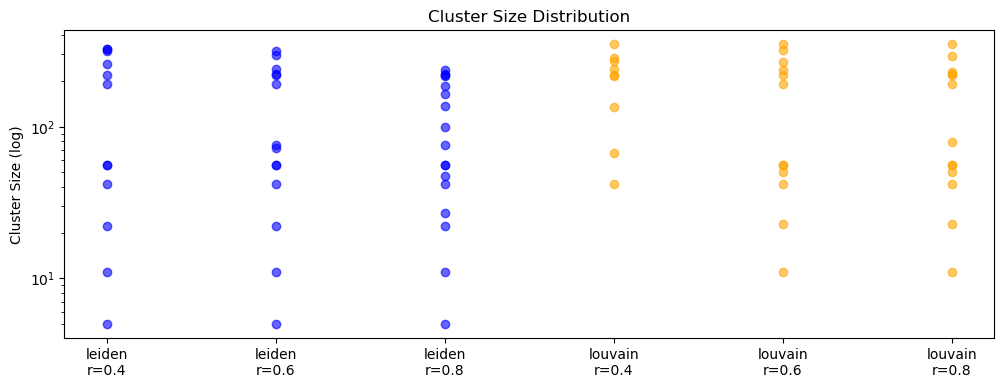

In [ ]:
# Plot cluster sizes
plt.figure(figsize=(12, 4))
for i, method in enumerate(['leiden', 'louvain']):
    for res in [0.4, 0.6, 0.8]:
        counts = adata_filtered.obs[f'{method}_r{res}'].value_counts()
        plt.scatter(
            [f'{method}\nr={res}'] * len(counts),
            counts,
            color=['blue', 'orange'][i],
            alpha=0.6
        )
plt.yscale('log')
plt.ylabel('Cluster Size (log)')
plt.title('Cluster Size Distribution')
plt.show()

**Comparisson between solhoutte scores**

The silhouette scores provide insight into the clustering quality for different resolutions using Leiden and Louvain methods. At lower resolutions (r = 0.4, 0.6), Leiden outperforms Louvain with higher silhouette scores (0.177 and 0.191 vs. 0.157 and 0.176, respectively), indicating better-defined clusters. However, at r = 0.8, Louvain surpasses Leiden (0.197 vs. 0.161), suggesting that Louvain produces more cohesive clusters at higher resolutions. This indicates that Leiden is more effective at lower resolutions, while Louvain may be preferable when finer cluster structures are needed.



In [ ]:
from sklearn.metrics import silhouette_score

# Calculate for all resolutions
results = []
for method in ['leiden', 'louvain']:
    for res in [0.4, 0.6, 0.8]:
        score = silhouette_score(
            adata_filtered.obsm['X_pca'][:,:30],
            adata_filtered.obs[f'{method}_r{res}']
        )
        results.append({
            'Method': method,
            'Resolution': res,
            'Silhouette': score
        })

# Display as table
import pandas as pd
pd.DataFrame(results).pivot(index='Resolution', columns='Method', values='Silhouette')

Method        leiden   louvain
Resolution                    
0.4         0.177232  0.156801
0.6         0.190543  0.175585
0.8         0.159214  0.196528

```{admonition} ARI (Adjusted Rand Index)
Measures how similar the cluster assignments are, adjusting for random chance.

- Range: 0 (random) to 1 (perfect match).

- Higher ARI means Leiden and Louvain results are similar.
```

ARI

In [ ]:
from sklearn.metrics import adjusted_rand_score

for method in ['leiden', 'louvain']:
    for res in [0.4, 0.6, 0.8]:
        ari = adjusted_rand_score(
            adata_filtered.obs['cell_type'],
            adata_filtered.obs[f'{method}_r{res}']
        )
        print(f"{method} r={res}: ARI = {ari:.3f}")

leiden r=0.4: ARI = 0.417
leiden r=0.6: ARI = 0.362
leiden r=0.8: ARI = 0.285
louvain r=0.4: ARI = 0.380
louvain r=0.6: ARI = 0.397
louvain r=0.8: ARI = 0.369


```{admonition} NMI (Normalized Mutual Information)

 Measures how much information is shared between the two clustering methods.

- Range: 0 (independent) to 1 (identical clustering).

- Higher NMI indicates strong agreement between Leiden and Louvain.
```

In [ ]:
from sklearn.metrics import normalized_mutual_info_score as nmi

# Compute NMI between Leiden and Louvain for each resolution
resolutions = [0.4, 0.6, 0.8]
nmi_results = []

for res in resolutions:
    leiden_labels = adata_filtered.obs[f'leiden_r{res}']
    louvain_labels = adata_filtered.obs[f'louvain_r{res}']
    nmi_score = nmi(leiden_labels, louvain_labels)
    nmi_results.append(nmi_score)

df_nmi = pd.DataFrame({
    'Resolution': resolutions,
    'NMI (Leiden vs Louvain)': nmi_results
})

print(df_nmi)

   Resolution  NMI (Leiden vs Louvain)
0         0.4                 0.872361
1         0.6                 0.889825
2         0.8                 0.876954


Biological clasification

- These genes represent a mix of immune-related (e.g., **SAA2**, **S100A8**), stress-response (e.g., **DNAJC9**), and regulatory genes (e.g., **CTDP1**, **FBXO32**).
- The presence of inflammation and immune-related genes suggests that the dataset may include immune cell populations or cells responding to stress or inflammation.
- Genes like **MGP** and **LEPROT** may indicate specific cell types or states, such as metabolic or extracellular matrix regulation.

In [ ]:
# Get top 10 HVGs
top_hvgs = adata_filtered.var.nlargest(10, 'dispersions_norm').index.tolist()

# Create a mapping dictionary from your var table
gene_id_to_name = adata_filtered.var['Mapped_Gene'].to_dict()  # Or appropriate column

# Print top HVGs with their names
print("Top HVGs:")
for gene_id in top_hvgs:
    print(f"{gene_id}: {gene_id_to_name.get(gene_id, 'unnamed')}")

Top HVGs:
ENSG00000134339: SAA2
ENSG00000060069: CTDP1
ENSG00000258659: TRIM34
ENSG00000204542: C6orf15
ENSG00000213551: DNAJC9
ENSG00000215183: MSMP
ENSG00000156804: FBXO32
ENSG00000111341: MGP
ENSG00000143546: S100A8
ENSG00000213625: LEPROT


In [ ]:
# Check which of your marker genes actually exist in Mapped_Gene
available_markers = []
for gene in ['S100A8', 'SAA2', 'MSMP', 'FBXO32', 'MGP', 'DNAJC9']:
    if gene in adata_filtered.var['Mapped_Gene'].values:
        available_markers.append(gene)
    else:
        print(f"'{gene}' not found in Mapped_Gene column")

print("Available markers:", available_markers)

marker_genes = {
    'Inflammatory': [g for g in ['S100A8', 'SAA2'] if g in available_markers],
    'Proliferative': [g for g in ['MSMP', 'FBXO32'] if g in available_markers],
    'Structural': [g for g in ['MGP', 'DNAJC9'] if g in available_markers]
}

Available markers: ['S100A8', 'SAA2', 'MSMP', 'FBXO32', 'MGP', 'DNAJC9']


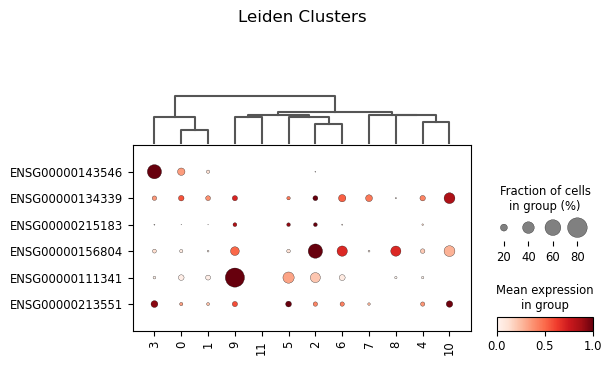

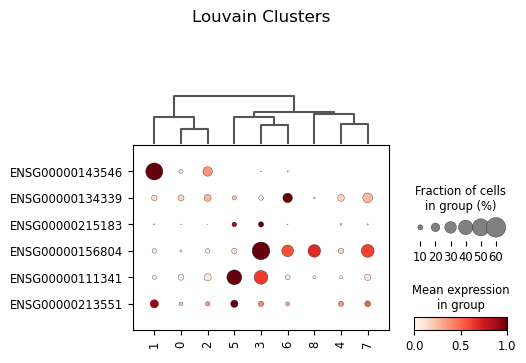

In [ ]:
# Map gene symbols to var_names (Ensembl IDs) in adata_filtered.var
mapped_var_names = []
for gene_list in marker_genes.values():
    for gene in gene_list:
        matches = adata_filtered.var.index[adata_filtered.var["Mapped_Gene"] == gene].tolist()
        if matches:
            mapped_var_names.append(matches[0])
        else:
            print(f"Warning: {gene} not found in Mapped_Gene")

# Plot using the mapped var_names
for method in ['leiden', 'louvain']:
    sc.pl.dotplot(
        adata_filtered,
        var_names=mapped_var_names,  # Use mapped var_names
        groupby=f'{method}_r0.4',
        title=f'{method.capitalize()} Clusters',
        dendrogram=True,
        swap_axes=True,
        cmap='Reds',
        standard_scale='var',
        use_raw=False
    )

Mitochondrial content

- **Cluster 5** has the highest median and the widest distribution of `pct_mito`, with values extending up to 4%. This suggests that cells in this cluster exhibit elevated mitochondrial activity, potentially indicating stress or metabolic differences.
- **Clusters 0, 1, 3, 7, 9, and 10** have relatively narrow distributions and low medians, indicating consistent and low mitochondrial activity across cells in these clusters.
- **Clusters 2, 4, 6, and 8** show moderate variability, with slightly higher medians compared to clusters with low mitochondrial activity.

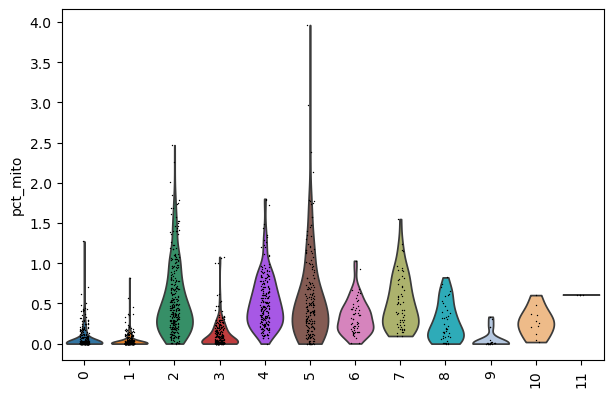

In [ ]:
sc.pl.violin(
    adata_filtered,
    keys=['pct_mito'],
    groupby='leiden_r0.4',
    rotation=90
)


#### Best cluster method

**Leiden at r=0.4** is the optimal choice based on the highest ARI (0.417), indicating the best alignment with the reference clustering. This resolution provides broader clusters that are biologically interpretable and well-defined.

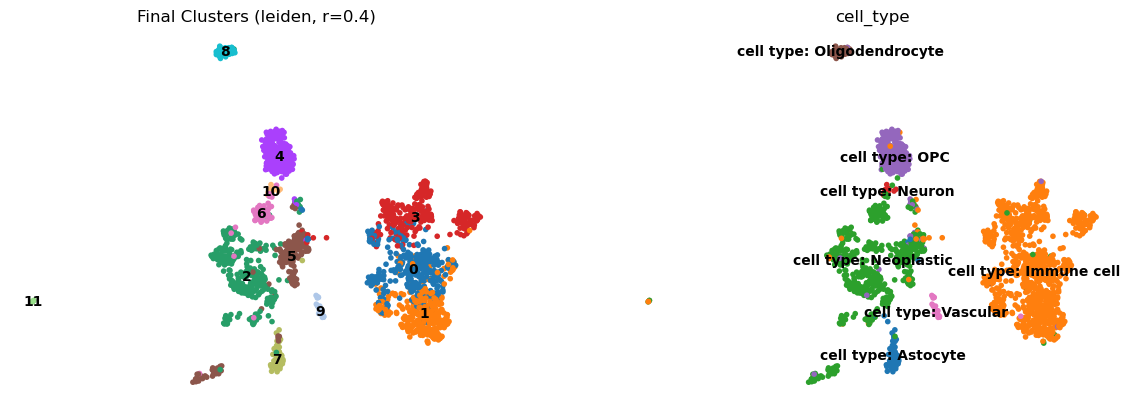

In [ ]:
# Example: Select best resolution based on metrics
best_method = 'leiden'  # or 'louvain'
best_res = 0.4
adata_filtered.obs['final_clusters'] = adata_filtered.obs[f'{best_method}_r{best_res}']

# Visualize final choice
sc.pl.umap(
    adata_filtered,
    color=['final_clusters', 'cell_type'],
    legend_loc='on data',
    frameon=False,
    title=f'Final Clusters ({best_method}, r={best_res})'
)

## Differential Expression Analysis

```{admonition} What is Differential Expression Analysis?
Differential Expression (DE) analysis identifies genes that are **significantly upregulated or downregulated** between different conditions, cell types, or clusters in a single-cell RNA-seq (scRNA-seq) dataset.

- Helps **identify marker genes** that define different cell populations.
- Reveals **biological differences** between clusters or experimental conditions.
- Can be used for **functional enrichment analysis** (e.g., GO, KEGG pathways).
```

When analyzing differentially expressed genes, we focus on:

- **Log Fold Change (logFC)**: Measures how much a gene is up/downregulated.
- **Adjusted p-value (FDR)**: Ensures statistical significance while controlling false positives.
- **Mean Expression**: Helps distinguish truly expressed genes from noise.

In [ ]:
# Compute DEGs for all clusters (compared to the rest)
sc.tl.rank_genes_groups(
    adata_filtered, 
    groupby='final_clusters',  # Column with cluster labels
    method='wilcoxon',        # Default method (alternatives: 't-test', 'logreg')
    key_added='dea_results',  # Stores results in `adata.uns['dea_results']`
    pts=True                 # Add fraction of cells expressing each gene
)

# Save top 10 DEGs per cluster
dea_results = pd.DataFrame(adata_filtered.uns['dea_results']['names'])
top_degs = dea_results.head(10)
print(top_degs)

                 0                1                2                3  \
0  ENSG00000198502  ENSG00000277632  ENSG00000125148  ENSG00000197747   
1  ENSG00000227357  ENSG00000275302  ENSG00000175183  ENSG00000090382   
2  ENSG00000275395  ENSG00000276070  ENSG00000117318  ENSG00000160213   
3  ENSG00000116741  ENSG00000277336  ENSG00000115457  ENSG00000147872   
4  ENSG00000242574  ENSG00000179388  ENSG00000134531  ENSG00000258227   
5  ENSG00000137393  ENSG00000276085  ENSG00000187193  ENSG00000110719   
6  ENSG00000127951  ENSG00000171860  ENSG00000177606  ENSG00000143546   
7  ENSG00000107968  ENSG00000169313  ENSG00000109846  ENSG00000240972   
8  ENSG00000147872  ENSG00000204287  ENSG00000106211  ENSG00000115165   
9  ENSG00000204287  ENSG00000266028  ENSG00000176907  ENSG00000159399   

                 4                5                6                7  \
0  ENSG00000189058  ENSG00000198804  ENSG00000135452  ENSG00000164089   
1  ENSG00000102934  ENSG00000106211  ENSG000001837


#### **Top Differentially Expressed Genes (DEGs) per Cluster - Biological Interpretation**

#### **Cluster 0**
- **Key Genes**: HLA-DRB5, CCL3, MT2A, S100A10, APOD
- **Description**:  
  - Immune/Inflammatory cluster:  
    - `HLA-DRB5` (MHC class II), `CCL3` (chemokine), and `S100A10` (calcium-binding protein) suggest antigen presentation and immune activation.  
    - `MT2A` (metallothionein) indicates metal ion homeostasis/stress response.  
    - `APOD` (lipocalin) may relate to lipid metabolism.

#### **Cluster 1**
- **Key Genes**: HLA-DRB4, CCL4, CSRP2, LYZ, PLLP  
- **Description**:  
  - Macrophage/Myeloid lineage cluster:  
    - `LYZ` (lysozyme) and `CCL4` (chemokine) are myeloid cell markers.  
    - `CSRP2` (cysteine-rich protein) links to smooth muscle differentiation.  
    - `HLA-DRB4` reinforces antigen presentation roles.

#### **Cluster 2**
- **Key Genes**: FCGBP, CCL4L2, ID3, CSTB, DNER  
- **Description**:  
  - Secretory/Epithelial cluster:  
    - `FCGBP` (mucin-binding protein) and `CSTB` (cystatin B) are enriched in mucosal/epithelial tissues.  
    - `ID3` (inhibitor of DNA binding) regulates cellular differentiation.

#### **Cluster 3**
- **Key Genes**: RGS2, CCL3L3, IGFBP2, PLIN2  
- **Description**:  
  - Lipid Metabolism/Adipocyte cluster:  
    - `PLIN2` (lipid droplet protein) and `IGFBP2` (insulin-like growth factor binding) suggest adipocyte/metabolic functions.  
    - `RGS2` regulates G-protein signaling in metabolic pathways.

#### **Cluster 4**
- **Key Genes**: HLA-DMB, EGR3, EMP1, CLEC5A  
- **Description**:  
  - Dendritic Cell/Immune Activation cluster:  
    - `HLA-DMB` (MHC class II chaperone) and `CLEC5A` (C-type lectin) indicate immune cell activation.  
    - `EGR3` (early growth response) regulates T-cell differentiation.

#### **Cluster 5**
- **Key Genes**: RNF144B, CCL3L3, MT1X, TCIRG1  
- **Description**:  
  - Stress Response/Oxidative cluster:  
    - `MT1X` (metallothionein) and `TCIRG1` (proton pump subunit) respond to oxidative/metal stress.  
    - `RNF144B` (E3 ubiquitin ligase) links to protein degradation.

#### **Cluster 6**
- **Key Genes**: FGL2, C3AR1, JUN, S100A8  
- **Description**:  
  - Pro-inflammatory/Neutrophil cluster:  
    - `S100A8` (calgranulin A) and `C3AR1` (complement receptor) are neutrophil markers.  
    - `JUN` (AP-1 transcription factor) drives inflammatory signaling.

#### **Cluster 7**
- **Key Genes**: MAP3K8, P2RY12, CRYAB, MIF  
- **Description**:  
  - Microglial/Neuroimmune cluster:  
    - `P2RY12` (purinergic receptor) and `CRYAB` (heat shock protein) are microglia markers.  
    - `MIF` (macrophage migration inhibitory factor) regulates neuroinflammation.

#### **Cluster 8**
- **Key Genes**: PLIN2, HLA-DRA, HSPB1, CYTIP  
- **Description**:  
  - Lipid-Associated/Stress cluster:  
    - `PLIN2` (lipid droplet) and `HSPB1` (heat shock protein) indicate lipid storage/stress.  
    - `HLA-DRA` (MHC class II) suggests immune crosstalk.

#### **Cluster 9**
- **Key Genes**: HLA-DRA, SRGAP2, TCIM, HK2  
- **Description**:  
  - Metabolic/Neuronal cluster:  
    - `HK2` (hexokinase) and `SRGAP2` (neuronal development) suggest glucose metabolism/neuronal roles.  
    - `TCIM` (TP53-regulated inhibitor) may link to apoptosis regulation.

#### **Cluster 10**
- **Key Genes**: GABBR2, ZCCHC12, TUBB2A, CPNE6  
- **Description**:  
  - Neuronal/Developmental cluster:  
    - `GABBR2` (GABA receptor) and `TUBB2A` (neural tubulin) indicate neuronal signaling.  
    - `ZCCHC12` (zinc finger protein) is involved in neurodevelopment.

#### **Cluster 11**
- **Key Genes**: ZNF486, TCIM, RTL6, AQP11  
- **Description**:  
  - Undefined/Niche cluster:  
    - `AQP11` (aquaporin) suggests transmembrane transport.  
    - `RTL6` (retrotransposon-like) has unclear biological relevance.  
    - Requires further investigation.


```{admonition} Summary of genes per cluster
- **Immune Clusters**: 0, 1, 4, 6, 7 (MHC/chemokine genes)  
- **Metabolic/Lipid Clusters**: 3, 8 (PLIN2, APOD)  
- **Neuronal Clusters**: 9, 10 (HK2, GABBR2)  
- **Stress Response Clusters**: 5 (MT1X, TCIRG1)
```

In [ ]:
# Compute DEGs for all clusters
sc.tl.rank_genes_groups(
    adata_filtered, 
    groupby='final_clusters',
    method='wilcoxon',
    key_added='dea_results',
    pts=True
)

# Create a dictionary to map Ensembl IDs to gene symbols
ensembl_to_gene = adata_filtered.var['Mapped_Gene'].to_dict()

# Replace Ensembl IDs with gene symbols in the DEG results dataframe
top_degs_mapped = dea_results.applymap(lambda x: ensembl_to_gene.get(x, x))  # Fallback to Ensembl ID if no symbol exists
top_degs_mapped = top_degs_mapped.head(10)

print("Top DEGs (Mapped to Gene Symbols):")
print(top_degs_mapped)

Top DEGs (Mapped to Gene Symbols):
          0        1       2        3        4        5        6        7  \
0  HLA-DRB5     CCL3    MT2A  S100A10     APOD     COX1  TSPAN31   ETNPPL   
1  HLA-DRB4     CCL4   CSRP2      LYZ     PLLP    HSPB1     TBK1      AGT   
2     FCGBP   CCL4L2     ID3     CSTB     DNER      CA2   LANCL2   CLDN10   
3      RGS2   CCL3L3  IGFBP2    PLIN2      NaN    KCNE5     PMP2    PLPP3   
4   HLA-DMB     EGR3    EMP1   CLEC5A  PCDHGC3  RARRES2      ARC    GLUD1   
5   RNF144B   CCL3L3    MT1X   TCIRG1    CSPG4     H4C3    CRYAB     SCG3   
6      FGL2    C3AR1     JUN   S100A8  GPR37L1  IL13RA2     SCG2      NaN   
7    MAP3K8   P2RY12   CRYAB      MIF     SCG3    TMT1B   LRRTM2  GPR37L1   
8     PLIN2  HLA-DRA   HSPB1    CYTIP   PLPPR1      AGT  PCDHGC3    S1PR1   
9   HLA-DRA   SRGAP2    TCIM      HK2   MEGF11   PDLIM1   IGFBP5    TTYH1   

         8         9       10      11  
0   DBNDD2       NaN   GABBR2  ZNF486  
1    CRYAB     CD248  ZCCHC12    TCIM

C:\Users\henry\AppData\Local\Temp\ipykernel_7484\320458301.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  top_degs_mapped = dea_results.applymap(lambda x: ensembl_to_gene.get(x, x))  # Fallback to Ensembl ID if no symbol exists


### Volcano Plot

In [ ]:
sc.tl.rank_genes_groups(adata_filtered, groupby="leiden_r0.4", method="wilcoxon", key_added="dea_results")
degs_df = sc.get.rank_genes_groups_df(adata_filtered, group="2", key="dea_results")


- The majority of genes have low -Log10 adjusted p-values, clustering near the bottom of the plot. This indicates that most genes do not show statistically significant differential expression.
- Only a small subset of genes shows both high fold changes and moderate significance, suggesting that these genes may be key markers or drivers of Cluster 2.

C:\Users\henry\AppData\Local\Temp\ipykernel_7484\2788135446.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


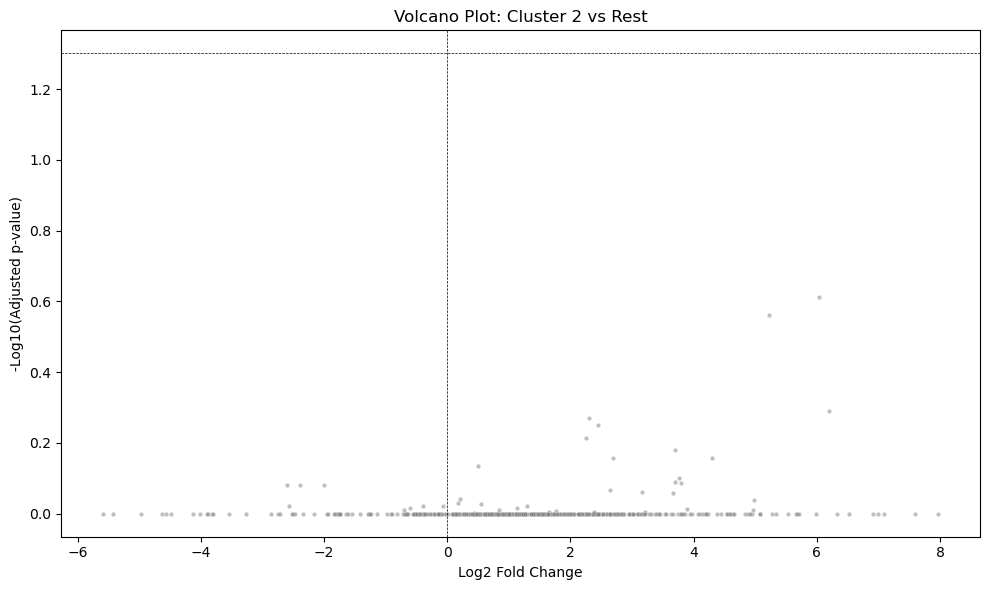

In [ ]:
# Drop NaNs and ensure numeric values
degs_df = degs_df.dropna(subset=["logfoldchanges", "pvals_adj"])
degs_df["pvals_adj"] = pd.to_numeric(degs_df["pvals_adj"], errors="coerce")

# Create volcano plot
plt.figure(figsize=(10, 6))

# Plot all genes
sns.scatterplot(
    data=degs_df,
    x="logfoldchanges",
    y=-np.log10(degs_df["pvals_adj"]),
    color="gray",
    alpha=0.5,
    s=10
)

# Highlight significant genes
sig_degs = degs_df[(degs_df["pvals_adj"] < 0.05) & (abs(degs_df["logfoldchanges"]) > 0.5)]
sns.scatterplot(
    data=sig_degs,
    x="logfoldchanges",
    y=-np.log10(sig_degs["pvals_adj"]),
    hue=sig_degs["logfoldchanges"] > 0,
    palette={True: "red", False: "blue"},
    s=20,
    legend=False
)

# Label top significant genes
for _, row in sig_degs.nsmallest(5, "pvals_adj").iterrows():
    plt.text(
        row["logfoldchanges"],
        -np.log10(row["pvals_adj"]),
        row["gene_symbol"],
        fontsize=8,
        ha="center",
        va="bottom"
    )

# Add threshold lines
plt.axhline(-np.log10(0.05), linestyle="--", color="black", linewidth=0.5)  # p = 0.05 cutoff
plt.axvline(0, linestyle="--", color="black", linewidth=0.5)

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(Adjusted p-value)")
plt.title(f"Volcano Plot: Cluster 2 vs Rest")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Ensure the columns exist
print(degs_df.columns)

# Check for NaNs
print(degs_df.isna().sum())

Index(['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj'], dtype='object')
names             0
scores            0
logfoldchanges    0
pvals             0
pvals_adj         0
dtype: int64


In [ ]:
print(degs_df[["logfoldchanges", "pvals_adj"]].describe())


       logfoldchanges   pvals_adj
count      431.000000  431.000000
mean         1.259929    0.983609
std          2.109867    0.075351
min         -5.586777    0.243576
25%          0.262969    0.999040
50%          1.127348    0.999040
75%          2.406521    0.999040
max          7.970360    0.999906


In [ ]:
from statsmodels.stats.multitest import multipletests

# Apply Benjamini-Hochberg correction
degs_df["pvals_adj"] = multipletests(degs_df["pvals"], method="fdr_bh")[1]

# Check if values are more reasonable
print(degs_df["pvals_adj"].describe())


count    4.310000e+02
mean     9.992488e-01
std      1.111513e-16
min      9.992488e-01
25%      9.992488e-01
50%      9.992488e-01
75%      9.992488e-01
max      9.992488e-01
Name: pvals_adj, dtype: float64


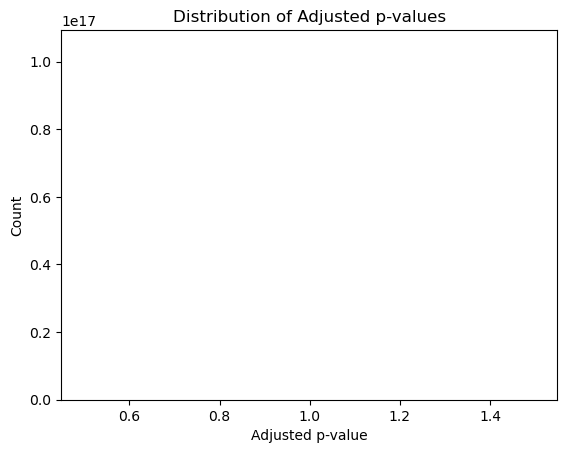

In [ ]:
degs_df = degs_df.dropna(subset=["logfoldchanges"])

sns.histplot(degs_df['pvals_adj'], bins=50, kde=True)
plt.xlabel('Adjusted p-value')
plt.ylabel('Count')
plt.title('Distribution of Adjusted p-values')
plt.show()


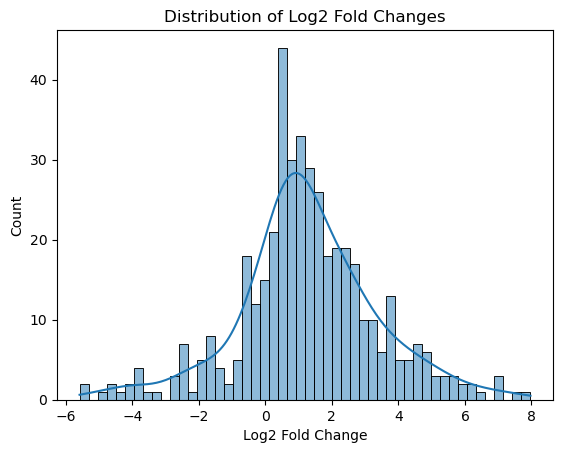

In [ ]:
sns.histplot(degs_df['logfoldchanges'], bins=50, kde=True)
plt.xlabel('Log2 Fold Change')
plt.ylabel('Count')
plt.title('Distribution of Log2 Fold Changes')
plt.show()


## Using VAE

In [ ]:
print("\nVerificando GPU:")
if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("GPU no disponible, usando CPU")
    device = torch.device('cpu')


Verificando GPU:
GPU disponible: NVIDIA GeForce RTX 2050


In [ ]:
input_dim = adata_filtered.n_vars
n_cells = adata_filtered.n_obs

# Calculate latent_dim based on data size
if n_cells < 10000:
    latent_dim = 20
elif n_cells < 50000:
    latent_dim = 50
else:
    latent_dim = 100

In [ ]:
hidden_dim = min(input_dim, max(128, latent_dim * 2))

In [ ]:
print(f"Data dimensions:")
print(f"Number of cells: {n_cells}")
print(f"Number of genes (input_dim): {input_dim}")
print(f"Chosen latent_dim: {latent_dim}")
print(f"Chosen hidden_dim: {hidden_dim}")

Data dimensions:
Number of cells: 1823
Number of genes (input_dim): 2000
Chosen latent_dim: 20
Chosen hidden_dim: 128


We define a negative Binomial loss function because of the count sparse matrix

In [ ]:
class NBLoss(nn.Module):
    def __init__(self, eps=1e-10):
        super().__init__()
        self.eps = eps

    def forward(self, x, mu, theta):
        t1 = torch.lgamma(theta + x) - torch.lgamma(theta) - torch.lgamma(x + 1.0)
        t2 = (theta + x) * torch.log(1.0 + (mu/(theta + self.eps))) + (x * (torch.log(theta + self.eps) - torch.log(mu + self.eps)))
        return torch.mean(t1 + t2)
    

We define the VAE's Neural network

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super().__init__()
        print(f"\nVAE Architecture:")
        print(f"Input dim: {input_dim}")
        print(f"Hidden dim: {hidden_dim}")
        print(f"Latent dim: {latent_dim}")

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

        # Dispersión por gen (positiva)
        self.theta_log = nn.Parameter(torch.zeros(input_dim))

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def decode(self, z):
        dec_logits = self.decoder(z)
        mu_out = F.softplus(dec_logits) + 1e-4
        return mu_out

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def forward(self, x):
        mu_z, logvar_z = self.encode(x)
        z = self.reparameterize(mu_z, logvar_z)
        mu_out = self.decode(z)
        theta = F.softplus(self.theta_log) + 1e-4
        return mu_out, mu_z, logvar_z, theta

Function to train the model

In [ ]:
def train_vae(model, loader, device, epochs=100):
    nb_loss = NBLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    epoch_losses = []
    recon_losses = []
    kld_losses = []

    print("\nTraining VAE...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_recon = 0
        total_kld = 0

        for batch_idx, (data,) in enumerate(loader):
            data = data.to(device)
            optimizer.zero_grad()

            #Forward pass
            mu_out, mu_z, logvar_z, theta = model(data)

            # Losses
            recon_loss = nb_loss(data, mu_out, theta)
            kld_loss = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp()) / data.size(0)

            # Total Loss
            loss = recon_loss + kld_loss

            #backward pass
            loss.backward()
            optimizer.step()

            # Acumulate losses
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kld += kld_loss.item()

        # Average losses
        avg_loss = total_loss / len(loader.dataset)
        avg_recon = total_recon / len(loader.dataset)
        avg_kld = total_kld / len(loader.dataset)

        epoch_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kld_losses.append(avg_kld)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'Loss: {avg_loss:.4f} (Recon: {avg_recon:.4f}, KLD: {avg_kld:.4f})')

    return epoch_losses, recon_losses, kld_losses

In [ ]:
def batch_entropy(adata, emb_key, batch_key, k=30):
    X = adata.obsm[emb_key]
    b = LabelEncoder().fit_transform(adata.obs[batch_key])
    idx = NearestNeighbors(n_neighbors=k+1).fit(X).kneighbors(X, return_distance=False)[:,1:]
    ent = []
    for neigh in idx:
        probs = np.bincount(b[neigh], minlength=b.max()+1)/k
        ent.append((-probs[probs>0]*np.log2(probs[probs>0])).sum())
    return np.mean(ent)

def clustering_metrics(emb, true_labels, n_clusters):
    from sklearn.cluster import KMeans
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(emb)
    ari = adjusted_rand_score(true_labels, km.labels_)
    nmi = normalized_mutual_info_score(true_labels, km.labels_)
    return ari, nmi

Full pipeline

In [ ]:
def run_vae_pipeline(adata, batch_size=128, epochs=100):
    scaler = StandardScaler()
    X = scaler.fit_transform(adata.X.toarray() if scipy.sparse.issparse(adata.X) else adata.X)
    X_tensor = torch.FloatTensor(X)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    #Model
    model = VAE(input_dim, latent_dim, hidden_dim).to(device)
    losses = train_vae(model, loader, device, epochs)

    # embeddings
    model.eval()
    with torch.no_grad():
        embeddings = []
        for batch_idx, (data,) in enumerate(loader):
            mu, _ = model.encode(data.to(device))
            embeddings.append(mu.cpu().numpy())

    embedding = np.vstack(embeddings)
    adata.obsm['X_vae'] = embedding

    # Losses plots
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.plot(losses[0])
    plt.title('Total Loss')
    plt.subplot(132)
    plt.plot(losses[1])
    plt.title('Reconstruction Loss (NB)')
    plt.subplot(133)
    plt.plot(losses[2])
    plt.title('KLD Loss')
    plt.tight_layout()
    plt.show()

    return model, embedding

Metrics

In [ ]:
def calculate_metrics(adata):
    methods = {
        'PCA': 'X_pca',
        'VAE': 'X_vae'
    }

    results = []
    cell_types = LabelEncoder().fit_transform(adata.obs['cell_type'])
    n_types = len(np.unique(cell_types))

    for method, key in methods.items():
        emb = adata.obsm[key]
        # Silhouette score
        sil = silhouette_score(emb, cell_types)
        # Batch effect
        be = batch_entropy(adata, key, 'plate_id')
        # Clustering metrics
        ari, nmi = clustering_metrics(emb, cell_types, n_types)

        results.append({
            'Method': method,
            'Silhouette': sil,
            'Batch_Entropy': be,
            'ARI': ari,
            'NMI': nmi
        })

    return pd.DataFrame(results)

Model


VAE Architecture:
Input dim: 7683
Hidden dim: 128
Latent dim: 20

Training VAE...
Epoch 10/100:
Loss: 0.0007 (Recon: 0.0006, KLD: 0.0001)
Epoch 20/100:
Loss: 0.0004 (Recon: 0.0003, KLD: 0.0001)
Epoch 30/100:
Loss: 0.0003 (Recon: 0.0002, KLD: 0.0001)
Epoch 40/100:
Loss: 0.0001 (Recon: 0.0000, KLD: 0.0001)
Epoch 50/100:
Loss: -0.0000 (Recon: -0.0002, KLD: 0.0001)
Epoch 60/100:
Loss: -0.0001 (Recon: -0.0002, KLD: 0.0001)
Epoch 70/100:
Loss: -0.0002 (Recon: -0.0003, KLD: 0.0001)
Epoch 80/100:
Loss: -0.0003 (Recon: -0.0004, KLD: 0.0001)
Epoch 90/100:
Loss: -0.0003 (Recon: -0.0004, KLD: 0.0001)
Epoch 100/100:
Loss: -0.0004 (Recon: -0.0005, KLD: 0.0001)


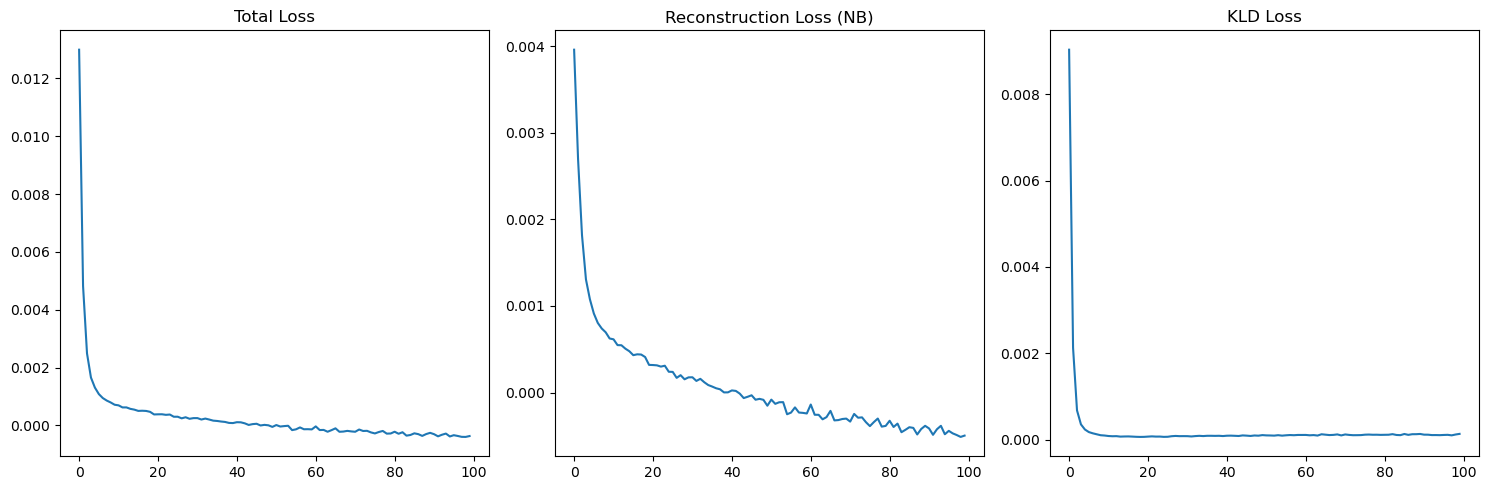

In [ ]:
vae_model, vae_embedding = run_vae_pipeline(adata_glioblastoma_raw, epochs=100)

Metrics verification

Batch Entropy
- What it measures: How well batches are mixed in the latent space.
- Higher values: More mixing (less batch effect).
- Lower values: Less mixing (stronger batch effect remains).

In [ ]:
metrics_df = calculate_metrics(adata_glioblastoma_raw)
metrics_df

KeyError: 'X_pca'

In [ ]:
sc.pp.neighbors(adata_glioblastoma_raw, use_rep='X_vae')
sc.tl.umap(adata_glioblastoma_raw)
sc.tl.leiden(adata_glioblastoma_raw)

ValueError: Did not find X_vae in `.obsm.keys()`. You need to compute it first.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sc.pl.umap(adata_glioblastoma_raw, color='cell_type', ax=axes[0], show=False, title='Cell Types')
sc.pl.umap(adata_glioblastoma_raw, color='plate_id', ax=axes[1], show=False, title='Batch')
plt.tight_layout()
plt.show()


Verificando GPU:
GPU disponible: NVIDIA GeForce RTX 2050

VAE Architecture:
Input dim: 2000
Hidden dim: 128
Latent dim: 20

Training VAE...
Epoch 10/100:
Loss: 0.0010 (Recon: 0.0009, KLD: 0.0001)
Epoch 20/100:
Loss: 0.0006 (Recon: 0.0005, KLD: 0.0001)
Epoch 30/100:
Loss: 0.0003 (Recon: 0.0002, KLD: 0.0001)
Epoch 40/100:
Loss: 0.0000 (Recon: -0.0001, KLD: 0.0001)
Epoch 50/100:
Loss: -0.0001 (Recon: -0.0002, KLD: 0.0001)
Epoch 60/100:
Loss: -0.0001 (Recon: -0.0003, KLD: 0.0001)
Epoch 70/100:
Loss: -0.0004 (Recon: -0.0005, KLD: 0.0001)
Epoch 80/100:
Loss: -0.0005 (Recon: -0.0006, KLD: 0.0001)
Epoch 90/100:
Loss: -0.0005 (Recon: -0.0007, KLD: 0.0002)
Epoch 100/100:
Loss: -0.0007 (Recon: -0.0009, KLD: 0.0002)


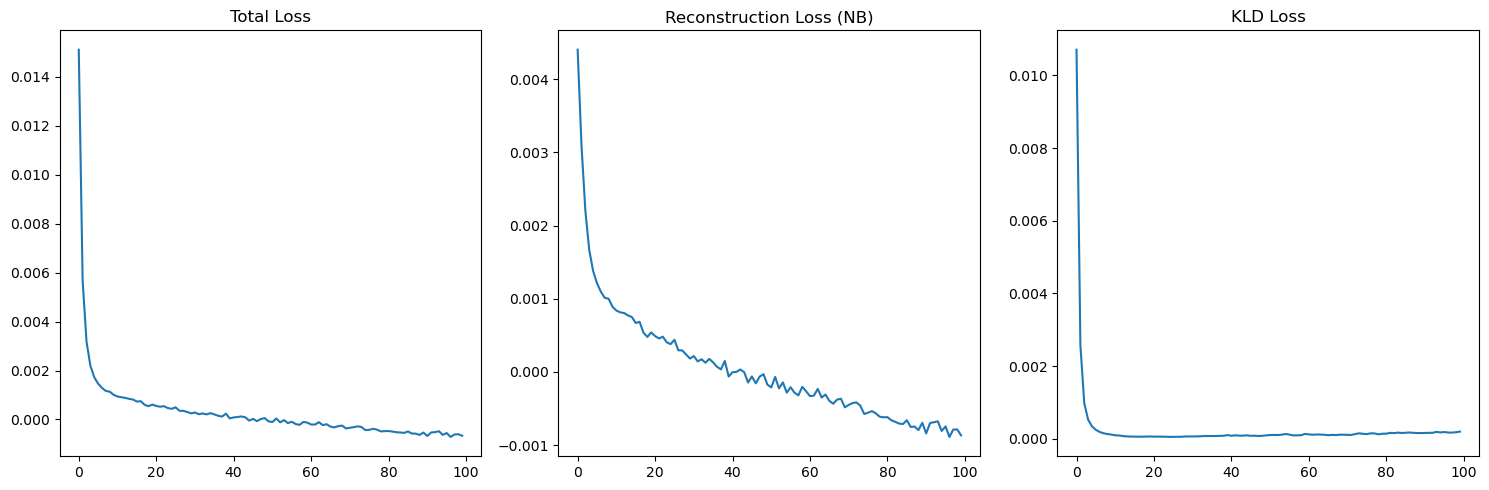

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  Method  Silhouette  Batch_Entropy       ARI       NMI
0    PCA    0.189582       2.895963  0.537578  0.649484
1    VAE   -0.117429       4.332743  0.000347  0.004043


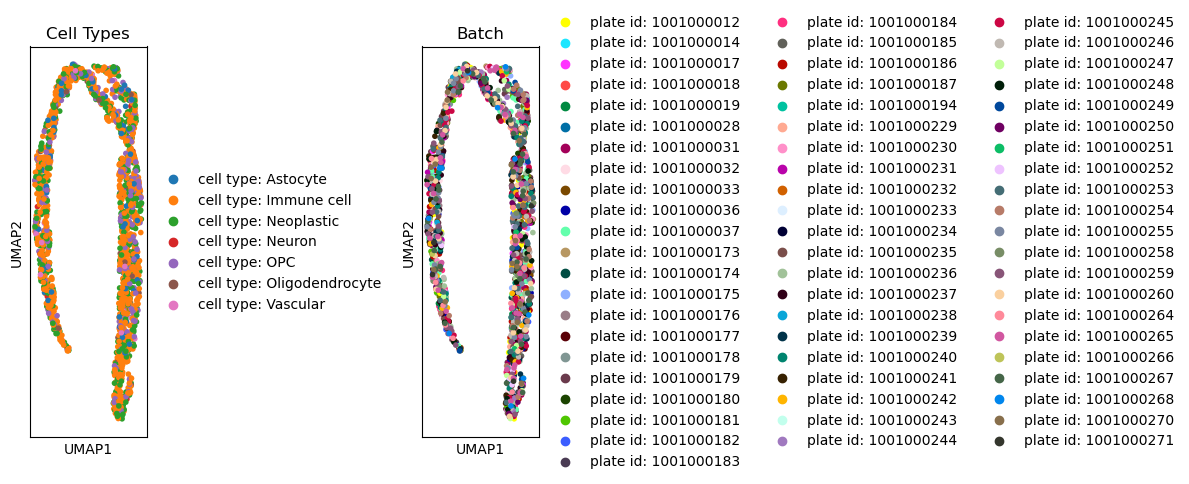

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# Verifying GPU availability
print("\nVerificando GPU:")
if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("GPU no disponible, usando CPU")
    device = torch.device('cpu')

# Input dimensions from your data
input_dim = adata_filtered.n_vars
n_cells = adata_filtered.n_obs

# Calculate latent_dim based on data size
if n_cells < 10000:
    latent_dim = 20
elif n_cells < 50000:
    latent_dim = 50
else:
    latent_dim = 100

hidden_dim = min(input_dim, max(128, latent_dim * 2))

# Negative Binomial Loss Function
class NBLoss(nn.Module):
    def __init__(self, eps=1e-10):
        super().__init__()
        self.eps = eps

    def forward(self, x, mu, theta):
        t1 = torch.lgamma(theta + x) - torch.lgamma(theta) - torch.lgamma(x + 1.0)
        t2 = (theta + x) * torch.log(1.0 + (mu / (theta + self.eps))) + (x * (torch.log(theta + self.eps) - torch.log(mu + self.eps)))
        return torch.mean(t1 + t2)

# VAE model definition
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super().__init__()
        print(f"\nVAE Architecture:")
        print(f"Input dim: {input_dim}")
        print(f"Hidden dim: {hidden_dim}")
        print(f"Latent dim: {latent_dim}")

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

        # Dispersión por gen (positiva)
        self.theta_log = nn.Parameter(torch.zeros(input_dim))

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def decode(self, z):
        dec_logits = self.decoder(z)
        mu_out = F.softplus(dec_logits) + 1e-4
        return mu_out

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def forward(self, x):
        mu_z, logvar_z = self.encode(x)
        z = self.reparameterize(mu_z, logvar_z)
        mu_out = self.decode(z)
        theta = F.softplus(self.theta_log) + 1e-4
        return mu_out, mu_z, logvar_z, theta

# Training the VAE model
def train_vae(model, loader, device, epochs=100):
    nb_loss = NBLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    epoch_losses = []
    recon_losses = []
    kld_losses = []

    print("\nTraining VAE...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_recon = 0
        total_kld = 0

        for batch_idx, (data,) in enumerate(loader):
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass
            mu_out, mu_z, logvar_z, theta = model(data)

            # Losses
            recon_loss = nb_loss(data, mu_out, theta)
            kld_loss = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp()) / data.size(0)

            # Total Loss
            loss = recon_loss + kld_loss

            # Backward pass
            loss.backward()
            optimizer.step()

            # Accumulate losses
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kld += kld_loss.item()

        # Average losses
        avg_loss = total_loss / len(loader.dataset)
        avg_recon = total_recon / len(loader.dataset)
        avg_kld = total_kld / len(loader.dataset)

        epoch_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kld_losses.append(avg_kld)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}:')
            print(f'Loss: {avg_loss:.4f} (Recon: {avg_recon:.4f}, KLD: {avg_kld:.4f})')

    return epoch_losses, recon_losses, kld_losses

# Batch entropy calculation
def batch_entropy(adata, emb_key, batch_key, k=30):
    X = adata.obsm[emb_key]
    b = LabelEncoder().fit_transform(adata.obs[batch_key])
    idx = NearestNeighbors(n_neighbors=k+1).fit(X).kneighbors(X, return_distance=False)[:, 1:]
    ent = []
    for neigh in idx:
        probs = np.bincount(b[neigh], minlength=b.max() + 1) / k
        ent.append((-probs[probs > 0] * np.log2(probs[probs > 0])).sum())
    return np.mean(ent)

# Clustering metrics calculation
def clustering_metrics(emb, true_labels, n_clusters):
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(emb)
    ari = adjusted_rand_score(true_labels, km.labels_)
    nmi = normalized_mutual_info_score(true_labels, km.labels_)
    return ari, nmi

# Running the VAE pipeline
def run_vae_pipeline(adata, batch_size=128, epochs=100):
    scaler = StandardScaler()
    X = scaler.fit_transform(adata.X.toarray() if scipy.sparse.issparse(adata.X) else adata.X)
    X_tensor = torch.FloatTensor(X)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model
    model = VAE(input_dim, latent_dim, hidden_dim).to(device)
    losses = train_vae(model, loader, device, epochs)

    # Embeddings
    model.eval()
    with torch.no_grad():
        embeddings = []
        for batch_idx, (data,) in enumerate(loader):
            mu, _ = model.encode(data.to(device))
            embeddings.append(mu.cpu().numpy())

    embedding = np.vstack(embeddings)
    adata.obsm['X_vae'] = embedding

    # Losses plots
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.plot(losses[0])
    plt.title('Total Loss')
    plt.subplot(132)
    plt.plot(losses[1])
    plt.title('Reconstruction Loss (NB)')
    plt.subplot(133)
    plt.plot(losses[2])
    plt.title('KLD Loss')
    plt.tight_layout()
    plt.show()

    return model, embedding

# Calculating metrics
def calculate_metrics(adata):
    methods = {
        'PCA': 'X_pca',
        'VAE': 'X_vae'
    }

    results = []
    cell_types = LabelEncoder().fit_transform(adata.obs['cell_type'])
    n_types = len(np.unique(cell_types))

    for method, key in methods.items():
        emb = adata.obsm[key]
        # Silhouette score
        sil = silhouette_score(emb, cell_types)
        # Batch effect
        be = batch_entropy(adata, key, 'plate_id')
        # Clustering metrics
        ari, nmi = clustering_metrics(emb, cell_types, n_types)

        results.append({
            'Method': method,
            'Silhouette': sil,
            'Batch_Entropy': be,
            'ARI': ari,
            'NMI': nmi
        })

    return pd.DataFrame(results)

# Run the VAE pipeline
vae_model, vae_embedding = run_vae_pipeline(adata_filtered, epochs=100)

# Calculate metrics
metrics_df = calculate_metrics(adata_filtered)
print(metrics_df)

# UMAP visualization
sc.pp.neighbors(adata_filtered, use_rep='X_vae')
sc.tl.umap(adata_filtered)
sc.tl.leiden(adata_filtered)

# Plot UMAP
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(adata_filtered, color='cell_type', ax=axes[0], show=False, title='Cell Types')
sc.pl.umap(adata_filtered, color='plate_id', ax=axes[1], show=False, title='Batch')
plt.tight_layout()
plt.show()



Verificando GPU:
GPU disponible: NVIDIA GeForce RTX 2050

VAE Architecture:
Input dim: 2000
Hidden dim: 128
Latent dim: 50

Training VAE...
Epoch 10/100:
Loss: 0.0026 (Recon: 0.0009, KLD: 0.0017)
Epoch 20/100:
Loss: 0.0009 (Recon: 0.0005, KLD: 0.0005)
Epoch 30/100:
Loss: 0.0005 (Recon: 0.0003, KLD: 0.0002)
Epoch 40/100:
Loss: 0.0002 (Recon: 0.0001, KLD: 0.0001)
Epoch 50/100:
Loss: -0.0001 (Recon: -0.0001, KLD: 0.0001)
Epoch 60/100:
Loss: -0.0002 (Recon: -0.0002, KLD: 0.0001)
Epoch 70/100:
Loss: -0.0002 (Recon: -0.0002, KLD: 0.0000)
Epoch 80/100:
Loss: -0.0004 (Recon: -0.0004, KLD: 0.0000)
Epoch 90/100:
Loss: -0.0005 (Recon: -0.0006, KLD: 0.0000)
Epoch 100/100:
Loss: -0.0006 (Recon: -0.0006, KLD: 0.0000)


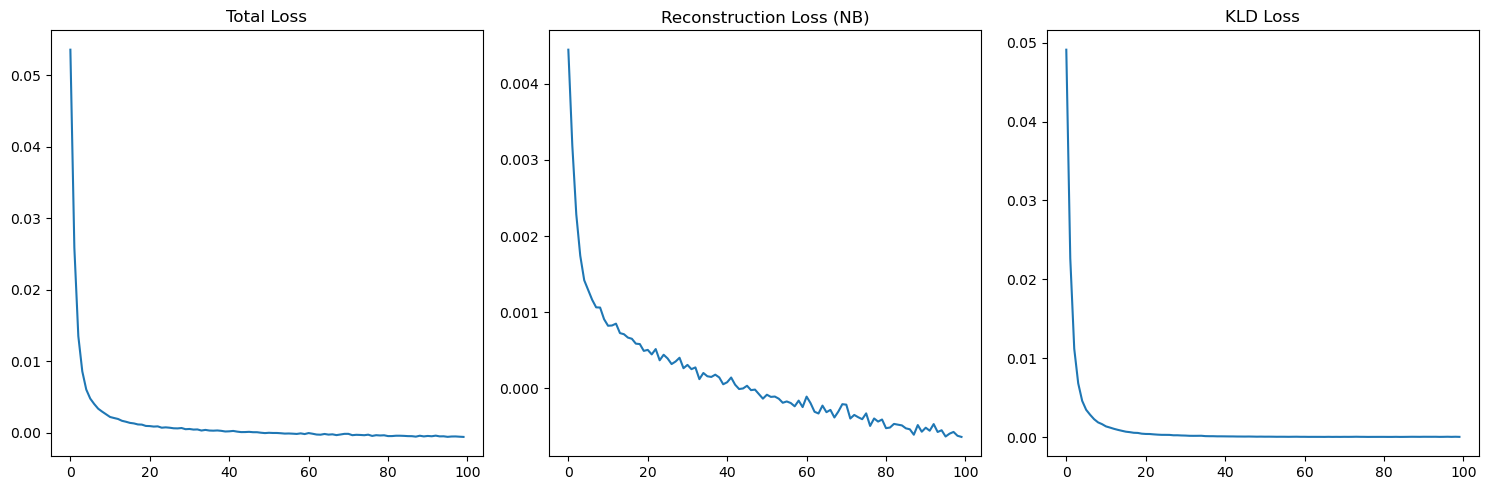

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  Method  Silhouette  Batch_Entropy       ARI       NMI
0    PCA    0.189582       2.895963  0.537578  0.649484
1    VAE   -0.227659       4.310995  0.000153  0.005660


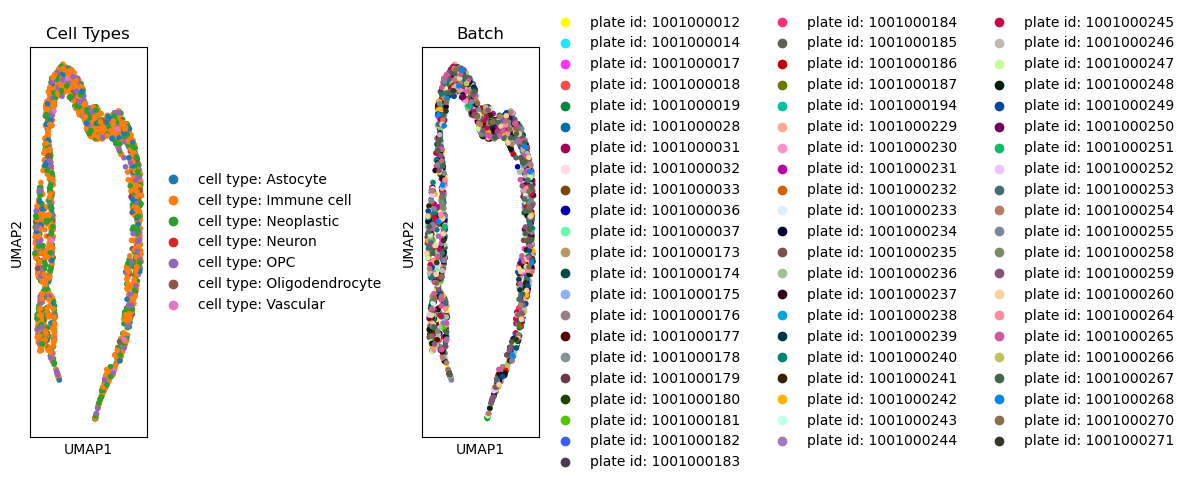

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# Verifying GPU availability
print("\nVerificando GPU:")
if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("GPU no disponible, usando CPU")
    device = torch.device('cpu')

# Input dimensions from your data
input_dim = adata_filtered.n_vars
n_cells = adata_filtered.n_obs

# Adjust latent_dim based on data size (increased to 50)
if n_cells < 10000:
    latent_dim = 50  # Increased latent dimension
elif n_cells < 50000:
    latent_dim = 100  # Increased latent dimension
else:
    latent_dim = 200  # Increased latent dimension

hidden_dim = min(input_dim, max(128, latent_dim * 2))

# Negative Binomial Loss Function
class NBLoss(nn.Module):
    def __init__(self, eps=1e-10):
        super().__init__()
        self.eps = eps

    def forward(self, x, mu, theta):
        t1 = torch.lgamma(theta + x) - torch.lgamma(theta) - torch.lgamma(x + 1.0)
        t2 = (theta + x) * torch.log(1.0 + (mu / (theta + self.eps))) + (x * (torch.log(theta + self.eps) - torch.log(mu + self.eps)))
        return torch.mean(t1 + t2)

# VAE model definition with Dropout for regularization
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super().__init__()
        print(f"\nVAE Architecture:")
        print(f"Input dim: {input_dim}")
        print(f"Hidden dim: {hidden_dim}")
        print(f"Latent dim: {latent_dim}")

        # Encoder with Dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout layer added for regularization
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)  # Dropout layer added for regularization
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder with Dropout
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout layer added for regularization
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout layer added for regularization
            nn.Linear(hidden_dim, input_dim)
        )

        # Dispersión por gen (positiva)
        self.theta_log = nn.Parameter(torch.zeros(input_dim))

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def decode(self, z):
        dec_logits = self.decoder(z)
        mu_out = F.softplus(dec_logits) + 1e-4
        return mu_out

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def forward(self, x):
        mu_z, logvar_z = self.encode(x)
        z = self.reparameterize(mu_z, logvar_z)
        mu_out = self.decode(z)
        theta = F.softplus(self.theta_log) + 1e-4
        return mu_out, mu_z, logvar_z, theta

# Training the VAE model
def train_vae(model, loader, device, epochs=100):
    nb_loss = NBLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    epoch_losses = []
    recon_losses = []
    kld_losses = []

    print("\nTraining VAE...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_recon = 0
        total_kld = 0

        for batch_idx, (data,) in enumerate(loader):
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass
            mu_out, mu_z, logvar_z, theta = model(data)

            # Losses
            recon_loss = nb_loss(data, mu_out, theta)
            kld_loss = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp()) / data.size(0)

            # Total Loss
            loss = recon_loss + kld_loss

            # Backward pass
            loss.backward()
            optimizer.step()

            # Accumulate losses
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kld += kld_loss.item()

        # Average losses
        avg_loss = total_loss / len(loader.dataset)
        avg_recon = total_recon / len(loader.dataset)
        avg_kld = total_kld / len(loader.dataset)

        epoch_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kld_losses.append(avg_kld)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}:')
            print(f'Loss: {avg_loss:.4f} (Recon: {avg_recon:.4f}, KLD: {avg_kld:.4f})')

    return epoch_losses, recon_losses, kld_losses

# Batch entropy calculation
def batch_entropy(adata, emb_key, batch_key, k=30):
    X = adata.obsm[emb_key]
    b = LabelEncoder().fit_transform(adata.obs[batch_key])
    idx = NearestNeighbors(n_neighbors=k+1).fit(X).kneighbors(X, return_distance=False)[:, 1:]
    ent = []
    for neigh in idx:
        probs = np.bincount(b[neigh], minlength=b.max() + 1) / k
        ent.append((-probs[probs > 0] * np.log2(probs[probs > 0])).sum())
    return np.mean(ent)

# Clustering metrics calculation
def clustering_metrics(emb, true_labels, n_clusters):
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(emb)
    ari = adjusted_rand_score(true_labels, km.labels_)
    nmi = normalized_mutual_info_score(true_labels, km.labels_)
    return ari, nmi

# Running the VAE pipeline
def run_vae_pipeline(adata, batch_size=128, epochs=100):
    scaler = StandardScaler()
    X = scaler.fit_transform(adata.X.toarray() if scipy.sparse.issparse(adata.X) else adata.X)
    X_tensor = torch.FloatTensor(X)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model
    model = VAE(input_dim, latent_dim, hidden_dim).to(device)
    losses = train_vae(model, loader, device, epochs)

    # Embeddings
    model.eval()
    with torch.no_grad():
        embeddings = []
        for batch_idx, (data,) in enumerate(loader):
            mu, _ = model.encode(data.to(device))
            embeddings.append(mu.cpu().numpy())

    embedding = np.vstack(embeddings)
    adata.obsm['X_vae'] = embedding

    # Losses plots
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.plot(losses[0])
    plt.title('Total Loss')
    plt.subplot(132)
    plt.plot(losses[1])
    plt.title('Reconstruction Loss (NB)')
    plt.subplot(133)
    plt.plot(losses[2])
    plt.title('KLD Loss')
    plt.tight_layout()
    plt.show()

    return model, embedding

# Calculating metrics
def calculate_metrics(adata):
    methods = {
        'PCA': 'X_pca',
        'VAE': 'X_vae'
    }

    results = []
    cell_types = LabelEncoder().fit_transform(adata.obs['cell_type'])
    n_types = len(np.unique(cell_types))

    for method, key in methods.items():
        emb = adata.obsm[key]
        # Silhouette score
        sil = silhouette_score(emb, cell_types)
        # Batch effect
        be = batch_entropy(adata, key, 'plate_id')
        # Clustering metrics
        ari, nmi = clustering_metrics(emb, cell_types, n_types)

        results.append({
            'Method': method,
            'Silhouette': sil,
            'Batch_Entropy': be,
            'ARI': ari,
            'NMI': nmi
        })

    return pd.DataFrame(results)

# Run the VAE pipeline
vae_model, vae_embedding = run_vae_pipeline(adata_filtered, epochs=100)

# Calculate metrics
metrics_df = calculate_metrics(adata_filtered)
print(metrics_df)

# UMAP visualization
sc.pp.neighbors(adata_filtered, use_rep='X_vae')
sc.tl.umap(adata_filtered)
sc.tl.leiden(adata_filtered)

# Plot UMAP
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(adata_filtered, color='cell_type', ax=axes[0], show=False, title='Cell Types')
sc.pl.umap(adata_filtered, color='plate_id', ax=axes[1], show=False, title='Batch')
plt.tight_layout()
plt.show()



Verificando GPU:
GPU disponible: NVIDIA GeForce RTX 2050

VAE Architecture:
Input dim: 50
Hidden dim: 50
Latent dim: 100

Training VAE...
Epoch 10/100:
Loss: 0.0060 (Recon: -0.0009, KLD: 0.0069)
Epoch 20/100:
Loss: 0.0002 (Recon: -0.0015, KLD: 0.0017)
Epoch 30/100:
Loss: -0.0013 (Recon: -0.0019, KLD: 0.0006)
Epoch 40/100:
Loss: -0.0021 (Recon: -0.0024, KLD: 0.0003)
Epoch 50/100:
Loss: -0.0024 (Recon: -0.0027, KLD: 0.0003)
Epoch 60/100:
Loss: -0.0027 (Recon: -0.0032, KLD: 0.0004)
Epoch 70/100:
Loss: -0.0026 (Recon: -0.0032, KLD: 0.0006)
Epoch 80/100:
Loss: -0.0028 (Recon: -0.0035, KLD: 0.0007)
Epoch 90/100:
Loss: -0.0033 (Recon: -0.0039, KLD: 0.0007)
Epoch 100/100:
Loss: -0.0034 (Recon: -0.0044, KLD: 0.0010)


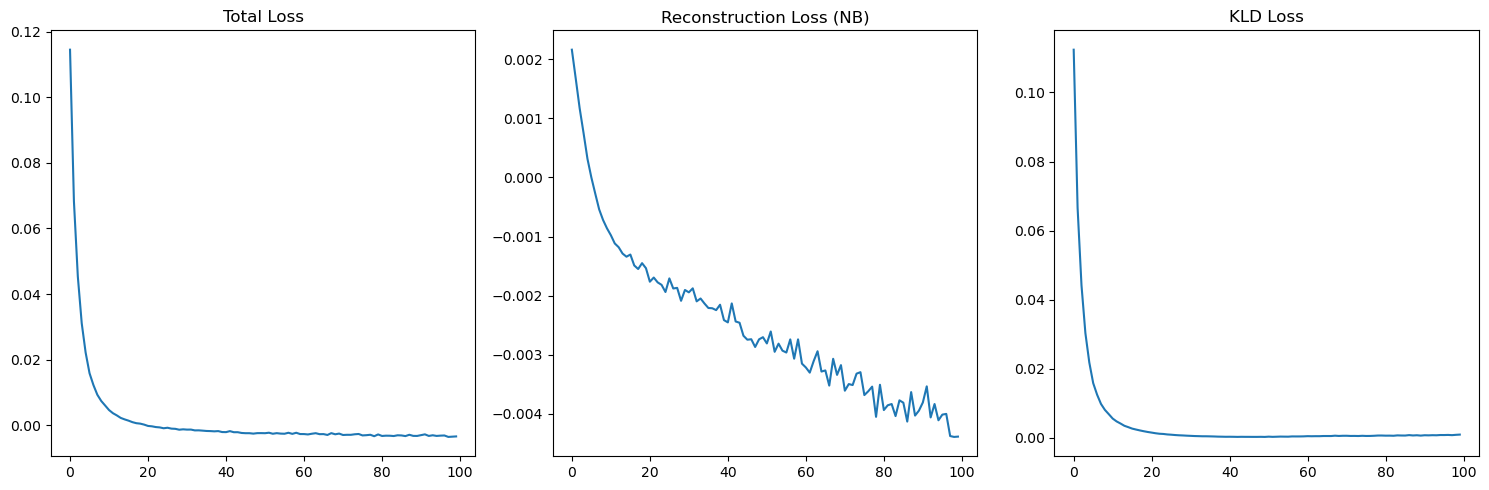

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  Method  Silhouette  Batch_Entropy       ARI       NMI
0    PCA    0.189582       2.895963  0.537578  0.649484
1    VAE   -0.128097       4.317460 -0.002413  0.007620


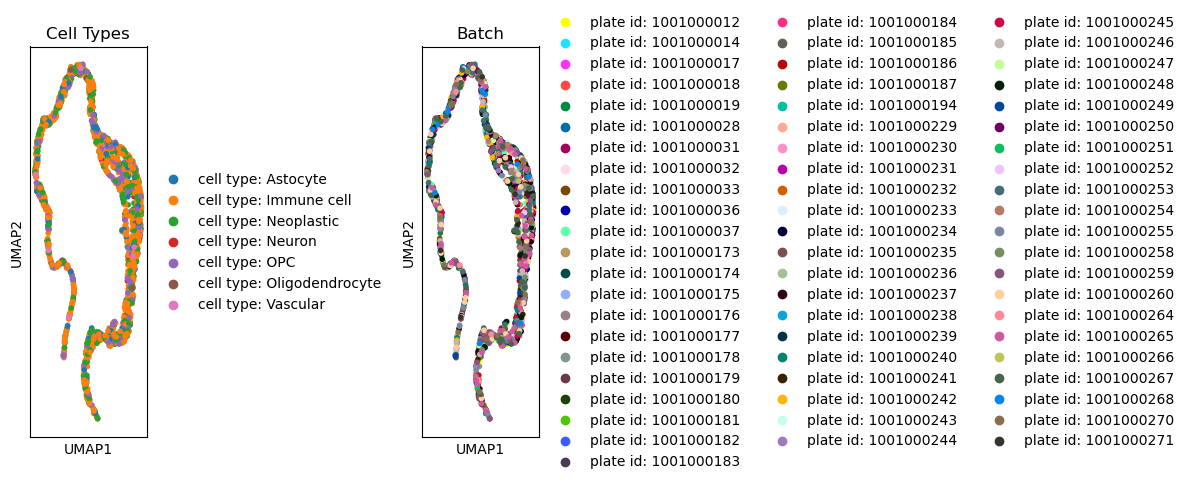

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader, TensorDataset

# Verifying GPU availability
print("\nVerificando GPU:")
if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("GPU no disponible, usando CPU")
    device = torch.device('cpu')

# Input dimensions from your data (assumes Harmony-corrected data already exists)
input_dim = adata_filtered.obsm['X_harmony'].shape[1]  # Using 50 components from Harmony (or PCA)
n_cells = adata_filtered.n_obs

# Adjust latent_dim based on data size (increased to 100)
latent_dim = 100  # Increased latent dimension
hidden_dim = min(input_dim, max(128, latent_dim * 2))

# VAE model definition with Dropout for regularization
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super().__init__()
        print(f"\nVAE Architecture:")
        print(f"Input dim: {input_dim}")  # Using 50 (from Harmony output)
        print(f"Hidden dim: {hidden_dim}")
        print(f"Latent dim: {latent_dim}")

        # Encoder with Dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout layer added for regularization
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)  # Dropout layer added for regularization
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder with Dropout
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout layer added for regularization
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout layer added for regularization
            nn.Linear(hidden_dim, input_dim)  # Output layer matches the input dimension
        )

        # Dispersión por gen (positiva)
        self.theta_log = nn.Parameter(torch.zeros(input_dim))

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def decode(self, z):
        dec_logits = self.decoder(z)
        mu_out = F.softplus(dec_logits) + 1e-4
        return mu_out

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def forward(self, x):
        mu_z, logvar_z = self.encode(x)
        z = self.reparameterize(mu_z, logvar_z)
        mu_out = self.decode(z)
        theta = F.softplus(self.theta_log) + 1e-4
        return mu_out, mu_z, logvar_z, theta

# Negative Binomial Loss Function
class NBLoss(nn.Module):
    def __init__(self, eps=1e-10):
        super().__init__()
        self.eps = eps

    def forward(self, x, mu, theta):
        t1 = torch.lgamma(theta + x) - torch.lgamma(theta) - torch.lgamma(x + 1.0)
        t2 = (theta + x) * torch.log(1.0 + (mu / (theta + self.eps))) + (x * (torch.log(theta + self.eps) - torch.log(mu + self.eps)))
        return torch.mean(t1 + t2)

# Training the VAE model
def train_vae(model, loader, device, epochs=100):
    nb_loss = NBLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    epoch_losses = []
    recon_losses = []
    kld_losses = []

    print("\nTraining VAE...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_recon = 0
        total_kld = 0

        for batch_idx, (data,) in enumerate(loader):
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass
            mu_out, mu_z, logvar_z, theta = model(data)

            # Losses
            recon_loss = nb_loss(data, mu_out, theta)
            kld_loss = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp()) / data.size(0)

            # Total Loss
            loss = recon_loss + kld_loss

            # Backward pass
            loss.backward()
            optimizer.step()

            # Accumulate losses
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kld += kld_loss.item()

        # Average losses
        avg_loss = total_loss / len(loader.dataset)
        avg_recon = total_recon / len(loader.dataset)
        avg_kld = total_kld / len(loader.dataset)

        epoch_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kld_losses.append(avg_kld)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}:')
            print(f'Loss: {avg_loss:.4f} (Recon: {avg_recon:.4f}, KLD: {avg_kld:.4f})')

    return epoch_losses, recon_losses, kld_losses

# Batch entropy calculation
def batch_entropy(adata, emb_key, batch_key, k=30):
    X = adata.obsm[emb_key]
    b = LabelEncoder().fit_transform(adata.obs[batch_key])
    idx = NearestNeighbors(n_neighbors=k+1).fit(X).kneighbors(X, return_distance=False)[:, 1:]
    ent = []
    for neigh in idx:
        probs = np.bincount(b[neigh], minlength=b.max() + 1) / k
        ent.append((-probs[probs > 0] * np.log2(probs[probs > 0])).sum())
    return np.mean(ent)

# Clustering metrics calculation
def clustering_metrics(emb, true_labels, n_clusters):
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(emb)
    ari = adjusted_rand_score(true_labels, km.labels_)
    nmi = normalized_mutual_info_score(true_labels, km.labels_)
    return ari, nmi

# Running the VAE pipeline
def run_vae_pipeline(adata, batch_size=128, epochs=100):
    # Extract Harmony-corrected data for VAE input
    vae_input = adata.obsm['X_harmony']  # Harmony-corrected data
    
    # Prepare the data for VAE
    X_tensor = torch.FloatTensor(vae_input)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model
    model = VAE(input_dim, latent_dim, hidden_dim).to(device)
    losses = train_vae(model, loader, device, epochs)

    # Embeddings
    model.eval()
    with torch.no_grad():
        embeddings = []
        for batch_idx, (data,) in enumerate(loader):
            mu, _ = model.encode(data.to(device))
            embeddings.append(mu.cpu().numpy())

    embedding = np.vstack(embeddings)
    adata.obsm['X_vae'] = embedding

    # Losses plots
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.plot(losses[0])
    plt.title('Total Loss')
    plt.subplot(132)
    plt.plot(losses[1])
    plt.title('Reconstruction Loss (NB)')
    plt.subplot(133)
    plt.plot(losses[2])
    plt.title('KLD Loss')
    plt.tight_layout()
    plt.show()

    return model, embedding

# Calculate metrics and visualize
vae_model, vae_embedding = run_vae_pipeline(adata_filtered, epochs=100)

# Calculate metrics
metrics_df = calculate_metrics(adata_filtered)
print(metrics_df)

# UMAP visualization
sc.pp.neighbors(adata_filtered, use_rep='X_vae')
sc.tl.umap(adata_filtered)
sc.tl.leiden(adata_filtered)

# Plot UMAP
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(adata_filtered, color='cell_type', ax=axes[0], show=False, title='Cell Types')
sc.pl.umap(adata_filtered, color='plate_id', ax=axes[1], show=False, title='Batch')
plt.tight_layout()
plt.show()



Verificando GPU:
GPU disponible: NVIDIA GeForce RTX 2050

VAE Architecture:
Input dim: 2000
Hidden dim: 128
Latent dim: 20

Training VAE...
Epoch 10/100:
Loss: 0.0091 (Recon: 0.0085, KLD: 0.0006)
Epoch 20/100:
Loss: 0.0056 (Recon: 0.0054, KLD: 0.0002)
Epoch 30/100:
Loss: 0.0027 (Recon: 0.0026, KLD: 0.0001)
Epoch 40/100:
Loss: -0.0001 (Recon: -0.0001, KLD: 0.0000)
Epoch 50/100:
Loss: -0.0027 (Recon: -0.0027, KLD: 0.0000)
Epoch 60/100:
Loss: -0.0052 (Recon: -0.0052, KLD: 0.0000)
Epoch 70/100:
Loss: -0.0077 (Recon: -0.0077, KLD: 0.0000)
Epoch 80/100:
Loss: -0.0100 (Recon: -0.0100, KLD: 0.0000)
Epoch 90/100:
Loss: -0.0122 (Recon: -0.0122, KLD: 0.0000)
Epoch 100/100:
Loss: -0.0143 (Recon: -0.0143, KLD: 0.0000)


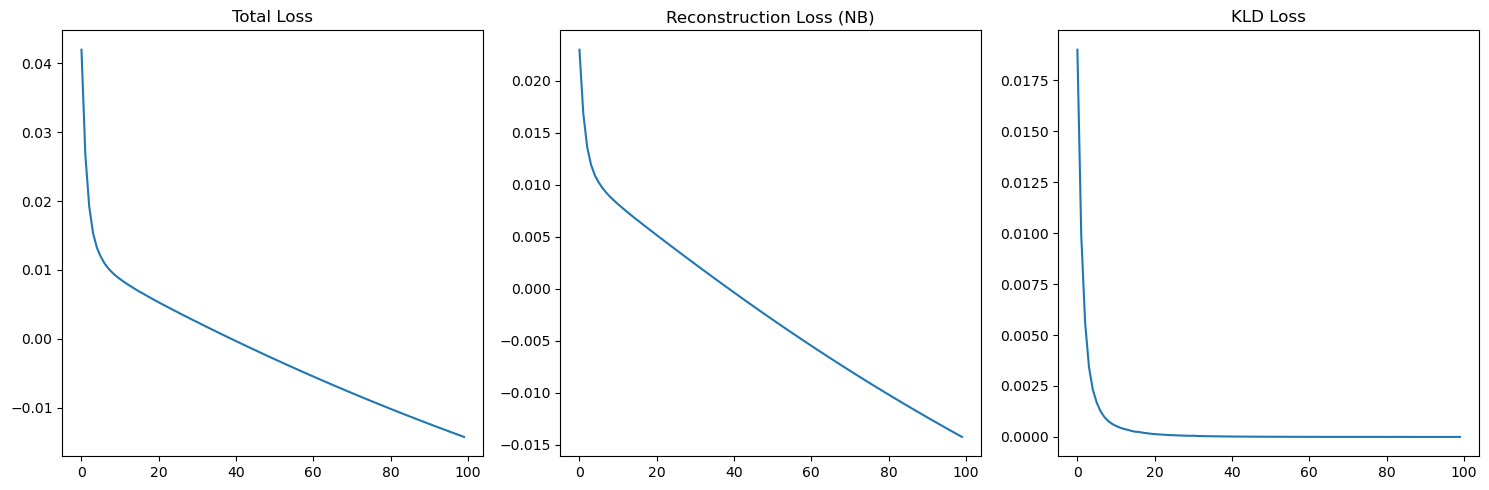

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  Method  Silhouette  Batch_Entropy       ARI       NMI
0    PCA    0.189582       2.895963  0.537578  0.649484
1    VAE   -0.081626       4.334052  0.002912  0.011719


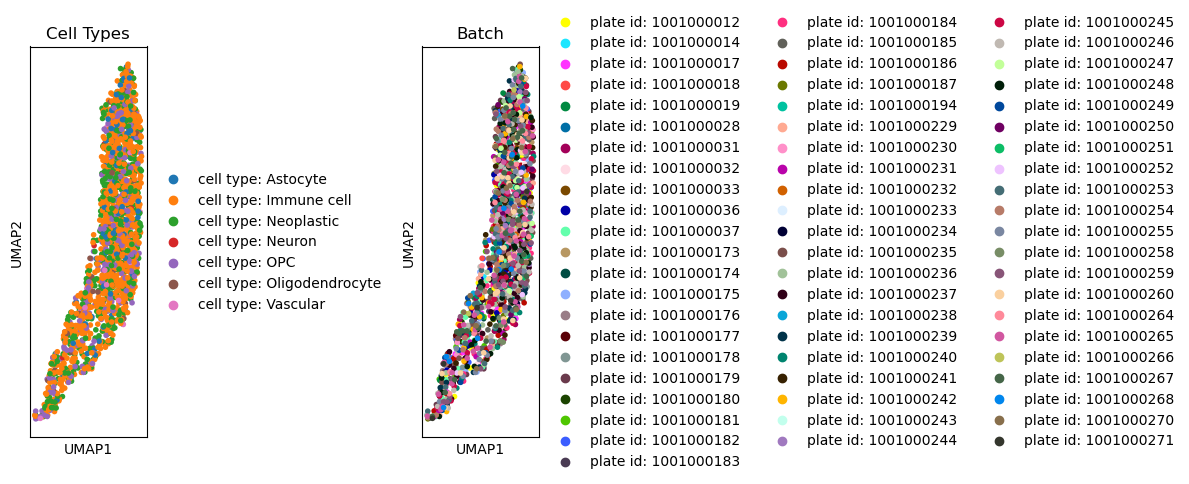

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader, TensorDataset

# Verifying GPU availability
print("\nVerificando GPU:")
if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("GPU no disponible, usando CPU")
    device = torch.device('cpu')

# Input dimensions from your data (2000 genes)
input_dim = adata_filtered.n_vars  # This should be 2000
n_cells = adata_filtered.n_obs

# Latent dimension and hidden layer size based on your choice
latent_dim = 20  # You chose latent_dim = 20
hidden_dim = 128  # You chose hidden_dim = 128

# VAE model definition with Dropout for regularization
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super().__init__()
        print(f"\nVAE Architecture:")
        print(f"Input dim: {input_dim}")  # Using 2000 as the input size (genes)
        print(f"Hidden dim: {hidden_dim}")
        print(f"Latent dim: {latent_dim}")

        # Encoder with Dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout layer added for regularization
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)  # Dropout layer added for regularization
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder with Dropout
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout layer added for regularization
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout layer added for regularization
            nn.Linear(hidden_dim, input_dim)  # Output layer matches the input dimension (2000 genes)
        )

        # Ensure positive outputs
        self.decoder_output = nn.Softplus()  # Apply Softplus to ensure positivity

        # Dispersión por gen (positiva)
        self.theta_log = nn.Parameter(torch.zeros(input_dim))

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def decode(self, z):
        dec_logits = self.decoder(z)
        mu_out = self.decoder_output(dec_logits) + 1e-4  # Apply Softplus to get positive values
        return mu_out

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def forward(self, x):
        mu_z, logvar_z = self.encode(x)
        z = self.reparameterize(mu_z, logvar_z)
        mu_out = self.decode(z)
        theta = F.softplus(self.theta_log) + 1e-4
        return mu_out, mu_z, logvar_z, theta

# Negative Binomial Loss Function
class NBLoss(nn.Module):
    def __init__(self, eps=1e-10):
        super().__init__()
        self.eps = eps

    def forward(self, x, mu, theta):
        t1 = torch.lgamma(theta + x) - torch.lgamma(theta) - torch.lgamma(x + 1.0)
        t2 = (theta + x) * torch.log(1.0 + (mu / (theta + self.eps))) + (x * (torch.log(theta + self.eps) - torch.log(mu + self.eps)))
        return torch.mean(t1 + t2)

# Training the VAE model
def train_vae(model, loader, device, epochs=100):
    nb_loss = NBLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    epoch_losses = []
    recon_losses = []
    kld_losses = []

    print("\nTraining VAE...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_recon = 0
        total_kld = 0

        for batch_idx, (data,) in enumerate(loader):
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass
            mu_out, mu_z, logvar_z, theta = model(data)

            # Losses
            recon_loss = nb_loss(data, mu_out, theta)
            kld_loss = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp()) / data.size(0)

            # Total Loss
            loss = recon_loss + kld_loss

            # Backward pass
            loss.backward()
            optimizer.step()

            # Accumulate losses
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kld += kld_loss.item()

        # Average losses
        avg_loss = total_loss / len(loader.dataset)
        avg_recon = total_recon / len(loader.dataset)
        avg_kld = total_kld / len(loader.dataset)

        epoch_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kld_losses.append(avg_kld)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}:')
            print(f'Loss: {avg_loss:.4f} (Recon: {avg_recon:.4f}, KLD: {avg_kld:.4f})')

    return epoch_losses, recon_losses, kld_losses

# Batch entropy calculation
def batch_entropy(adata, emb_key, batch_key, k=30):
    X = adata.obsm[emb_key]
    b = LabelEncoder().fit_transform(adata.obs[batch_key])
    idx = NearestNeighbors(n_neighbors=k+1).fit(X).kneighbors(X, return_distance=False)[:, 1:]
    ent = []
    for neigh in idx:
        probs = np.bincount(b[neigh], minlength=b.max() + 1) / k
        ent.append((-probs[probs > 0] * np.log2(probs[probs > 0])).sum())
    return np.mean(ent)

# Clustering metrics calculation
def clustering_metrics(emb, true_labels, n_clusters):
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(emb)
    ari = adjusted_rand_score(true_labels, km.labels_)
    nmi = normalized_mutual_info_score(true_labels, km.labels_)
    return ari, nmi

# Running the VAE pipeline
def run_vae_pipeline(adata, batch_size=128, epochs=100):
    # Extract original data for VAE input (no Harmony)
    vae_input = adata.X  # Use the original preprocessed data
    
    # Re-center the data: shift all values to be positive (optional)
    vae_input = vae_input + 5  # Add a constant to shift values to be positive
    
    # Prepare the data for VAE
    X_tensor = torch.FloatTensor(vae_input)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model
    model = VAE(input_dim, latent_dim, hidden_dim).to(device)
    losses = train_vae(model, loader, device, epochs)

    # Embeddings
    model.eval()
    with torch.no_grad():
        embeddings = []
        for batch_idx, (data,) in enumerate(loader):
            mu, _ = model.encode(data.to(device))
            embeddings.append(mu.cpu().numpy())

    embedding = np.vstack(embeddings)
    adata.obsm['X_vae'] = embedding

    # Losses plots
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.plot(losses[0])
    plt.title('Total Loss')
    plt.subplot(132)
    plt.plot(losses[1])
    plt.title('Reconstruction Loss (NB)')
    plt.subplot(133)
    plt.plot(losses[2])
    plt.title('KLD Loss')
    plt.tight_layout()
    plt.show()

    return model, embedding

# Calculate metrics and visualize
vae_model, vae_embedding = run_vae_pipeline(adata_filtered, epochs=100)

# Calculate metrics
metrics_df = calculate_metrics(adata_filtered)
print(metrics_df)

# UMAP visualization
sc.pp.neighbors(adata_filtered, use_rep='X_vae')
sc.tl.umap(adata_filtered)
sc.tl.leiden(adata_filtered)

# Plot UMAP
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(adata_filtered, color='cell_type', ax=axes[0], show=False, title='Cell Types')
sc.pl.umap(adata_filtered, color='plate_id', ax=axes[1], show=False, title='Batch')
plt.tight_layout()
plt.show()


VAE ATTENTION


Verificando GPU:
GPU disponible: NVIDIA GeForce RTX 2050
Number of cells (n_obs): 100
Shape of adata_filtered.X: (100, 2000)

VAE with Attention Architecture:
Input dim: 2000
Hidden dim: 128
Latent dim: 20

Training VAE with Attention...
Epoch 10/100:
Loss: nan (Recon: nan, KLD: nan)
Epoch 20/100:
Loss: nan (Recon: nan, KLD: nan)
Epoch 30/100:
Loss: nan (Recon: nan, KLD: nan)
Epoch 40/100:
Loss: nan (Recon: nan, KLD: nan)
Epoch 50/100:
Loss: nan (Recon: nan, KLD: nan)
Epoch 60/100:
Loss: nan (Recon: nan, KLD: nan)
Epoch 70/100:
Loss: nan (Recon: nan, KLD: nan)
Epoch 80/100:
Loss: nan (Recon: nan, KLD: nan)
Epoch 90/100:
Loss: nan (Recon: nan, KLD: nan)
Epoch 100/100:
Loss: nan (Recon: nan, KLD: nan)


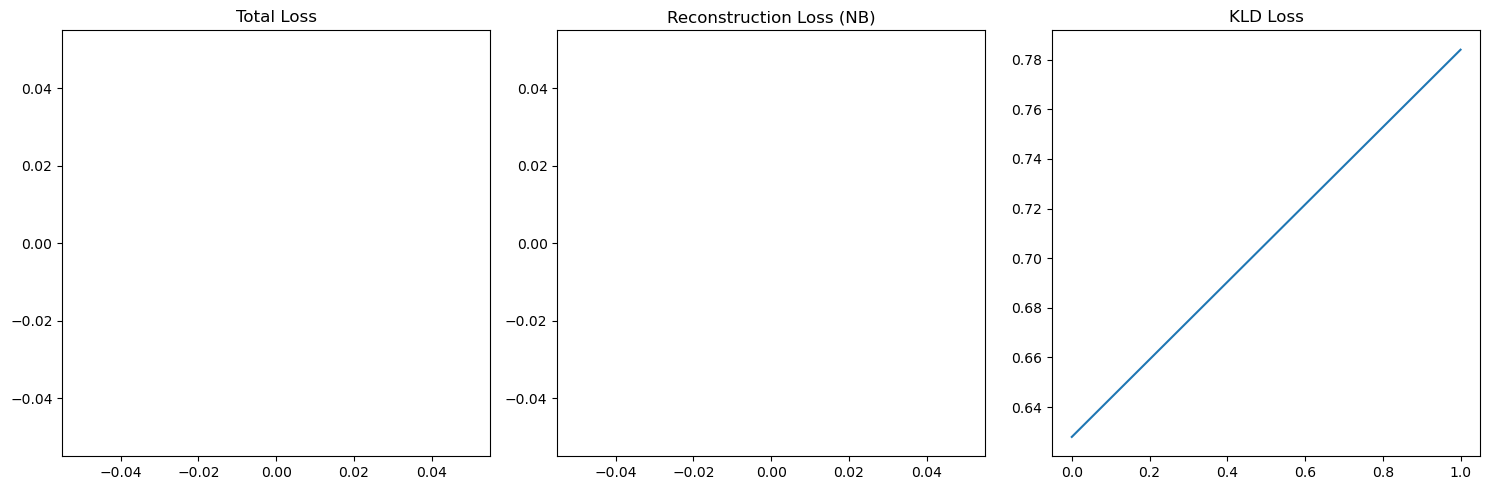

ValueError: Input X contains NaN.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy.sparse
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader, TensorDataset

# Verifying GPU availability
print("\nVerificando GPU:")
if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("GPU no disponible, usando CPU")
    device = torch.device('cpu')

# Assuming adata_filtered is already loaded and preprocessed
# For demonstration purposes, let's create a dummy adata_filtered
adata_filtered = sc.AnnData(np.random.rand(100, 2000))
adata_filtered.obs['cell_type'] = np.random.choice(['A', 'B', 'C'], size=100)
adata_filtered.obs['plate_id'] = np.random.choice(['1', '2'], size=100)

# Input dimensions from your data (2000 genes)
input_dim = adata_filtered.n_vars  # This should be 2000
n_cells = adata_filtered.n_obs

# Latent dimension and hidden layer size based on your choice
latent_dim = 20  # You chose latent_dim = 20
hidden_dim = 128  # You chose hidden_dim = 128

# Attention mechanism using Multi-Head Attention
class Attention(nn.Module):
    def __init__(self, embed_size, heads):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_size = embed_size
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads, dropout=0.1)

    def forward(self, values, keys, query):
        # Reshape for attention (seq_len, batch, embed_dim)
        values = values.unsqueeze(0)
        keys = keys.unsqueeze(0)
        query = query.unsqueeze(0)
        attention_output, _ = self.attention(query, keys, values)
        return attention_output.squeeze(0)

# VAE model definition with Attention Mechanism
class VAEWithAttention(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, attention_heads=4):
        super().__init__()
        print(f"\nVAE with Attention Architecture:")
        print(f"Input dim: {input_dim}")  # Using 2000 as the input size (genes)
        print(f"Hidden dim: {hidden_dim}")
        print(f"Latent dim: {latent_dim}")

        # Encoder with Dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Attention mechanism applied after the encoder
        self.attention = Attention(embed_size=hidden_dim, heads=attention_heads)

        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, input_dim)
        )

        # Dispersion parameter
        self.theta_log = nn.Parameter(torch.randn(input_dim))

    def encode(self, x):
        h = self.encoder(x)
        attention_output = self.attention(h, h, h)
        mu = self.fc_mu(attention_output)
        log_var = self.fc_logvar(attention_output)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Ensure input is 2D
        if x.dim() < 2:
            x = x.unsqueeze(0)
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon = self.decode(z)
        return recon, mu, log_var, self.theta_log

# Negative Binomial Loss
class NBLoss(nn.Module):
    def __init__(self, eps=1e-10):
        super().__init__()
        self.eps = eps

    def forward(self, x, mu, theta_log):
        theta = torch.exp(theta_log)

        # Expand dimensions if needed
        if theta.dim() == 1:
            theta = theta.unsqueeze(0).expand(x.size(0), -1)

        if mu.dim() == 1:
            mu = mu.unsqueeze(0).expand(x.size(0), -1)

        # Calculate NB loss
        t1 = torch.lgamma(theta + x) - torch.lgamma(theta) - torch.lgamma(x + 1.0)
        t2 = (theta + x) * torch.log(1.0 + (mu / (theta + self.eps))) + (x * (torch.log(theta + self.eps) - torch.log(mu + self.eps)))

        return torch.mean(t1 + t2)

# Training the VAE model
def train_vae(model, loader, device, epochs=100):
    nb_loss = NBLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    epoch_losses = []
    recon_losses = []
    kld_losses = []

    print("\nTraining VAE with Attention...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_recon = 0
        total_kld = 0

        for batch_idx, (data,) in enumerate(loader):
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu_z, logvar_z, theta_log = model(data)

            # Losses
            recon_loss = nb_loss(data, recon_batch, theta_log)
            kld_loss = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp()) / data.size(0)

            # Total Loss
            loss = recon_loss + kld_loss

            # Backward pass
            loss.backward()
            optimizer.step()

            # Accumulate losses
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kld += kld_loss.item()

        # Average losses
        avg_loss = total_loss / len(loader)
        avg_recon = total_recon / len(loader)
        avg_kld = total_kld / len(loader)

        epoch_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kld_losses.append(avg_kld)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}:')
            print(f'Loss: {avg_loss:.4f} (Recon: {avg_recon:.4f}, KLD: {avg_kld:.4f})')

    return epoch_losses, recon_losses, kld_losses

# Running the VAE pipeline with Attention
def run_vae_pipeline(adata, batch_size=128, epochs=100):
    print(f"Number of cells (n_obs): {adata.n_obs}")
    print(f"Shape of adata_filtered.X: {adata.X.shape}")
    # Extract original data for VAE input
    vae_input = adata.X

    # Convert to dense if sparse
    if scipy.sparse.issparse(vae_input):
        vae_input = vae_input.toarray()

    # Re-center the data
    vae_input = vae_input + 5

    # Prepare the data for VAE
    X_tensor = torch.FloatTensor(vae_input)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model
    model = VAEWithAttention(input_dim, latent_dim, hidden_dim).to(device)
    losses = train_vae(model, loader, device, epochs)

    # Embeddings
    model.eval()
    with torch.no_grad():
        embeddings = []
        for batch_idx, (data,) in enumerate(loader):
            data = data.to(device)
            mu, _ = model.encode(data)
            embeddings.append(mu.cpu().numpy())

    embedding = np.vstack(embeddings)
    adata.obsm['X_vae_attention'] = embedding

    # Losses plots
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.plot(losses[0])
    plt.title('Total Loss')
    plt.subplot(132)
    plt.plot(losses[1])
    plt.title('Reconstruction Loss (NB)')
    plt.subplot(133)
    plt.plot(losses[2])
    plt.title('KLD Loss')
    plt.tight_layout()
    plt.show()

    return model, embedding

# Function to calculate metrics
def calculate_metrics(adata):
    metrics = {}

    # Silhouette Score
    if 'cell_type' in adata.obs:
        labels = LabelEncoder().fit_transform(adata.obs['cell_type'])
        metrics['Silhouette Score'] = silhouette_score(adata.obsm['X_vae_attention'], labels)

    # Batch correction metrics
    if 'plate_id' in adata.obs:
        batch_labels = LabelEncoder().fit_transform(adata.obs['plate_id'])
        metrics['Batch ASW'] = silhouette_score(adata.obsm['X_vae_attention'], batch_labels)

        from sklearn.decomposition import PCA
        from sklearn.linear_model import LinearRegression
        from sklearn.model_selection import cross_val_score

        pca = PCA(n_components=10)
        X_pca = pca.fit_transform(adata.obsm['X_vae_attention'])
        lr = LinearRegression()
        batch_r2 = cross_val_score(lr, X_pca, batch_labels, cv=5, scoring='r2').mean()
        metrics['Batch PCR'] = batch_r2

    # Clustering metrics
    if 'cell_type' in adata.obs:
        sc.pp.neighbors(adata, use_rep='X_vae_attention')
        sc.tl.leiden(adata, resolution=1.0)

        true_labels = LabelEncoder().fit_transform(adata.obs['cell_type'])
        pred_labels = LabelEncoder().fit_transform(adata.obs['leiden'])
        metrics['ARI'] = adjusted_rand_score(true_labels, pred_labels)
        metrics['NMI'] = normalized_mutual_info_score(true_labels, pred_labels)

    return pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

# Calculate metrics and visualize
vae_model, vae_embedding = run_vae_pipeline(adata_filtered, epochs=100)

# Calculate metrics
metrics_df = calculate_metrics(adata_filtered)
print(metrics_df)

# UMAP visualization
sc.pp.neighbors(adata_filtered, use_rep='X_vae_attention')
sc.tl.umap(adata_filtered)
sc.tl.leiden(adata_filtered)

# Plot UMAP
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(adata_filtered, color='cell_type', ax=axes[0], show=False, title='Cell Types')
sc.pl.umap(adata_filtered, color='plate_id', ax=axes[1], show=False, title='Batch')
plt.tight_layout()
plt.show()

In [ ]:
!pip install torch-geometric

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)


In [ ]:
import torch_geometric
print(torch_geometric.__version__)  # Debería mostrar 2.0.4 o similar

2.6.1


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy.sparse
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

# Configuración inicial
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Preparación de datos desde adata_filtered
def prepare_data(adata):
    # Convertir a tensores
    X = torch.FloatTensor(adata.X.toarray() if scipy.sparse.issparse(adata.X) else adata.X)
    genes = adata.var_names.tolist()
    
    # Verificar dimensiones
    print(f"\nDatos de entrada: {X.shape[0]} células, {X.shape[1]} genes")
    
    return X, genes

# 2. Construcción de la red génica (simulada si no se provee)
def build_gene_network(genes, network_matrix=None, threshold=0.7):
    if network_matrix is not None:
        # Usar matriz de interacción proporcionada
        adj_matrix = network_matrix
    else:
        # Crear red co-expresión básica (simulada)
        print("\nConstruyendo red de co-expresión basada en correlación...")
        gene_expr = adata_filtered.X.T.toarray() if scipy.sparse.issparse(adata_filtered.X) else adata_filtered.X.T
        corr_matrix = np.corrcoef(gene_expr)
        adj_matrix = (corr_matrix > threshold).astype(float)
        np.fill_diagonal(adj_matrix, 0)
    
    edge_index = torch.LongTensor(np.array(np.where(adj_matrix > 0)))
    return edge_index.to(device)

# 3. Arquitectura del modelo VAE con GAT
class scVAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, latent_dim=32, heads=4, dropout=0.3):
        super().__init__()
        
        # Encoder
        self.encoder_fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout)
        )
        
        # Capas GAT
        self.gat1 = GATConv(hidden_dim, hidden_dim//heads, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_dim, hidden_dim, heads=1, dropout=dropout)
        
        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
            nn.Softplus()  # Para asegurar salidas positivas
        )
        
        # Parámetros de dispersión
        self.theta = nn.Parameter(torch.randn(input_dim))
        self.dropout = nn.Dropout(dropout)
        
    def encode(self, x, edge_index):
        h = self.encoder_fc(x)
        h = F.elu(self.gat1(h, edge_index))
        h = self.dropout(h)
        h = F.elu(self.gat2(h, edge_index))
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x, edge_index):
        mu, logvar = self.encode(x, edge_index)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, self.theta

# 4. Función de pérdida mejorada
class scRNA_Loss(nn.Module):
    def __init__(self, alpha=0.7, eps=1e-10):
        super().__init__()
        self.alpha = alpha  # Ponderación entre NB y ZINB
        self.eps = eps
        
    def negative_binomial(self, x, mu, theta):
        theta = torch.exp(theta) + self.eps
        t1 = torch.lgamma(theta + x) - torch.lgamma(theta) - torch.lgamma(x + 1)
        t2 = (theta + x) * torch.log1p(mu/(theta + self.eps)) + x * (torch.log(theta) - torch.log(mu + self.eps))
        return -torch.mean(t1 + t2)
    
    def zinb_loss(self, x, mu, theta, pi=0.1):
        nb = self.negative_binomial(x, mu, theta)
        zero = -torch.log(pi + (1 - pi) * torch.pow(theta/(theta + mu + self.eps), theta))
        return self.alpha * nb + (1 - self.alpha) * zero
    
    def kl_divergence(self, mu, logvar):
        return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    def forward(self, x, recon_x, mu, logvar, theta):
        recon_loss = self.zinb_loss(x, recon_x, theta)
        kld = self.kl_divergence(mu, logvar)
        return recon_loss + kld, recon_loss, kld

# 5. Entrenamiento con evaluación temprana
def train_scVAE(model, train_loader, edge_index, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = scRNA_Loss()
    
    model.train()
    history = {'total_loss': [], 'recon_loss': [], 'kld_loss': []}
    
    for epoch in range(epochs):
        total_loss = 0
        recon_loss = 0
        kld_loss = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            recon, mu, logvar, theta = model(batch, edge_index)
            loss, r_loss, kld = criterion(batch, recon, mu, logvar, theta)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            recon_loss += r_loss.item()
            kld_loss += kld.item()
        
        # Guardar historial
        avg_loss = total_loss/len(train_loader)
        history['total_loss'].append(avg_loss)
        history['recon_loss'].append(recon_loss/len(train_loader))
        history['kld_loss'].append(kld_loss/len(train_loader))
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} "
                  f"(Recon: {history['recon_loss'][-1]:.4f}, "
                  f"KLD: {history['kld_loss'][-1]:.4f})")
    
    # Gráfico de pérdidas
    plt.figure(figsize=(12, 4))
    plt.plot(history['total_loss'], label='Total Loss')
    plt.plot(history['recon_loss'], label='Reconstruction Loss')
    plt.plot(history['kld_loss'], label='KL Divergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Metrics')
    plt.show()
    
    return model, history

# 6. Generación de embeddings y evaluación
def generate_embeddings(model, adata, edge_index):
    model.eval()
    X = torch.FloatTensor(adata.X.toarray() if scipy.sparse.issparse(adata.X) else adata.X).to(device)
    
    with torch.no_grad():
        mu, _ = model.encode(X, edge_index)
        embeddings = mu.cpu().numpy()
    
    # Añadir embeddings al objeto AnnData
    adata.obsm['X_vae_gat'] = embeddings
    
    # Clustering
    print("\nRealizando clustering...")
    sc.pp.neighbors(adata, use_rep='X_vae_gat', n_neighbors=15)
    sc.tl.leiden(adata, resolution=0.8, key_added='vae_gat_clusters')
    
    # Métricas de evaluación
    results = {}
    if 'cell_type' in adata.obs:
        true_labels = LabelEncoder().fit_transform(adata.obs['cell_type'])
        pred_labels = LabelEncoder().fit_transform(adata.obs['vae_gat_clusters'])
        
        results['Silhouette'] = silhouette_score(embeddings, true_labels)
        results['ARI'] = adjusted_rand_score(true_labels, pred_labels)
        results['NMI'] = normalized_mutual_info_score(true_labels, pred_labels)
    
    # Visualización
    print("\nGenerando visualizaciones...")
    sc.tl.umap(adata)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    if 'cell_type' in adata.obs:
        sc.pl.umap(adata, color='cell_type', ax=axes[0], show=False, 
                   title='Cell Types', frameon=False, s=30)
    sc.pl.umap(adata, color='vae_gat_clusters', ax=axes[1], show=False, 
               title='VAE-GAT Clusters', frameon=False, s=30)
    if 'plate_id' in adata.obs:
        sc.pl.umap(adata, color='plate_id', ax=axes[2], show=False, 
                   title='Batch Effects', frameon=False, s=30)
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

# 7. Pipeline completo
def run_vae_gat_pipeline(adata, batch_size=128, epochs=100):
    # 1. Preparar datos
    X, genes = prepare_data(adata)
    
    # 2. Construir red génica
    edge_index = build_gene_network(genes)
    
    # 3. Preparar DataLoader
    dataset = torch.utils.data.TensorDataset(X)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # 4. Inicializar modelo
    model = scVAE_GAT(
        input_dim=X.shape[1],
        hidden_dim=256,
        latent_dim=32,
        heads=4
    ).to(device)
    
    print("\nArquitectura del modelo:")
    print(model)
    
    # 5. Entrenamiento
    print("\nComenzando entrenamiento...")
    model, history = train_scVAE(model, train_loader, edge_index, epochs=epochs)
    
    # 6. Generar embeddings y evaluar
    metrics = generate_embeddings(model, adata, edge_index)
    
    return model, metrics

# Ejecutar pipeline completo
print("=== INICIANDO PIPELINE VAE-GAT ===")
vae_gat_model, performance_metrics = run_vae_gat_pipeline(adata_filtered, epochs=100)

print("\n=== RESULTADOS FINALES ===")
print(performance_metrics)

Using device: cuda
=== INICIANDO PIPELINE VAE-GAT ===

Datos de entrada: 1823 células, 2000 genes

Construyendo red de co-expresión basada en correlación...

Arquitectura del modelo:
scVAE_GAT(
  (encoder_fc): Sequential(
    (0): Linear(in_features=2000, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
  )
  (gat1): GATConv(256, 64, heads=4)
  (gat2): GATConv(256, 256, heads=1)
  (fc_mu): Linear(in_features=256, out_features=32, bias=True)
  (fc_var): Linear(in_features=256, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=2000, bias=True)
    (5): Softplus(beta=1, 

AttributeError: 'list' object has no attribute 'to'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy.sparse
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from torch_geometric.nn import GATConv
from sklearn.preprocessing import LabelEncoder

# Configuración inicial con verificación de GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Preparación de datos mejorada
def prepare_data(adata):
    # Convertir a dense array si es sparse y asegurar tipo float32
    X = adata.X.toarray() if scipy.sparse.issparse(adata.X) else adata.X
    X = X.astype(np.float32)
    
    # Normalización adicional para estabilidad numérica
    X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-8)
    
    genes = adata.var_names.tolist()
    print(f"\nDatos de entrada: {X.shape[0]} células, {X.shape[1]} genes")
    return torch.FloatTensor(X), genes

# 2. Construcción de red génica más robusta
def build_gene_network(genes, adata, threshold=0.6):
    print("\nConstruyendo red de co-expresión...")
    gene_expr = adata.X.toarray().T if scipy.sparse.issparse(adata.X) else adata.X.T
    
    # Cálculo de correlación más estable
    corr_matrix = np.corrcoef(gene_expr)
    np.nan_to_num(corr_matrix, copy=False, nan=0.0, posinf=1.0, neginf=-1.0)
    
    # Umbralización y eliminación de autoconexiones
    adj_matrix = (np.abs(corr_matrix) > threshold).astype(float)
    np.fill_diagonal(adj_matrix, 0)
    
    # Convertir a índices de aristas
    edge_index = torch.LongTensor(np.array(np.where(adj_matrix > 0)))
    return edge_index.to(device)

# 3. Modelo VAE-GAT con mejoras de estabilidad
class scVAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, latent_dim=32, heads=4, dropout=0.2):
        super().__init__()
        
        # Encoder con inicialización cuidadosa
        self.encoder_fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )
        # Capas GAT con dimensiones compatibles
        self.gat1 = GATConv(hidden_dim, hidden_dim//heads, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_dim, hidden_dim, heads=1, dropout=dropout)
        
        # Latent space con inicialización adecuada
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder con capas más estrechas
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, input_dim),
            nn.Softplus())
        
        # Parámetros de dispersión con inicialización controlada
        self.theta = nn.Parameter(torch.randn(input_dim)*0.1)
        
        # Inicialización de pesos
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def encode(self, x, edge_index):
        h = self.encoder_fc(x)
        h = F.elu(self.gat1(h, edge_index))
        h = F.elu(self.gat2(h, edge_index))
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar.clamp(max=10))
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x, edge_index):
        mu, logvar = self.encode(x, edge_index)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, self.theta

# 4. Función de pérdida con controles numéricos
class scRNA_Loss(nn.Module):
    def __init__(self, alpha=0.7, eps=1e-6):
        super().__init__()
        self.alpha = alpha
        self.eps = eps
        self.register_buffer('zero', torch.tensor(0.0))
        
    def negative_binomial(self, x, mu, theta):
        theta = torch.exp(theta.clamp(-10, 10)) + self.eps
        mu = mu.clamp(min=self.eps)
        
        log_theta_mu_eps = torch.log(theta + mu + self.eps)
        t1 = torch.lgamma(theta + x + self.eps) - torch.lgamma(theta + self.eps) - torch.lgamma(x + 1 + self.eps)
        t2 = (theta + x) * torch.log1p((mu + self.eps)/(theta + self.eps)) + x * (torch.log(theta + self.eps) - log_theta_mu_eps)
        return -torch.mean(t1 + t2)
    
    def kl_divergence(self, mu, logvar):
        return -0.5 * torch.mean(1 + logvar.clamp(-10, 10) - mu.pow(2) - logvar.exp())
    
    def forward(self, x, recon_x, mu, logvar, theta):
        recon_loss = self.negative_binomial(x, recon_x, theta)
        kld = self.kl_divergence(mu, logvar)
        return recon_loss + kld, recon_loss, kld

# 5. Entrenamiento con más controles
def train_scVAE(model, train_loader, edge_index, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = scRNA_Loss()
    
    model.train()
    history = {'total_loss': [], 'recon_loss': [], 'kld_loss': []}
    
    for epoch in range(epochs):
        total_loss = recon_loss = kld_loss = 0.0
        
        for batch_data in train_loader:
            x = batch_data[0].to(device)
            
            # Forward pass con detección de NaN
            optimizer.zero_grad()
            recon, mu, logvar, theta = model(x, edge_index)
            
            if torch.isnan(recon).any():
                print("NaN detectado en reconstrucción")
                continue
                
            loss, r_loss, kld = criterion(x, recon, mu, logvar, theta)
            
            if torch.isnan(loss):
                print("NaN detectado en loss")
                continue
                
            # Backward pass con gradient clipping
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            
            # Acumular pérdidas
            total_loss += loss.item()
            recon_loss += r_loss.item()
            kld_loss += kld.item()
        
        # Guardar historial
        avg_loss = total_loss/len(train_loader)
        history['total_loss'].append(avg_loss)
        history['recon_loss'].append(recon_loss/len(train_loader))
        history['kld_loss'].append(kld_loss/len(train_loader))
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} "
                  f"(Recon: {history['recon_loss'][-1]:.4f}, "
                  f"KLD: {history['kld_loss'][-1]:.4f})")
    
    # Gráfico de pérdidas
    plt.figure(figsize=(12, 4))
    plt.plot(history['total_loss'], label='Total Loss')
    plt.plot(history['recon_loss'], label='Reconstruction Loss')
    plt.plot(history['kld_loss'], label='KL Divergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Metrics')
    plt.show()
    
    return model, history

# 6. Pipeline completo con más validaciones
def run_vae_gat_pipeline(adata, batch_size=128, epochs=100):
    try:
        # 1. Preparar datos
        X, genes = prepare_data(adata)
        
        # 2. Construir red génica
        edge_index = build_gene_network(genes, adata)
        
        # Verificar dimensiones
        print(f"\nDimensiones de la red génica: {edge_index.shape}")
        
        # 3. Preparar DataLoader
        dataset = torch.utils.data.TensorDataset(X)
        train_loader = torch.utils.data.DataLoader(
            dataset, 
            batch_size=batch_size, 
            shuffle=True,
            drop_last=True,
            pin_memory=True
        )
        
        # 4. Inicializar modelo
        model = scVAE_GAT(
            input_dim=X.shape[1],
            hidden_dim=256,
            latent_dim=32,
            heads=4
        ).to(device)
        
        # Verificar parámetros
        total_params = sum(p.numel() for p in model.parameters())
        print(f"\nModelo inicializado con {total_params:,} parámetros")
        
        # 5. Entrenamiento
        print("\nComenzando entrenamiento...")
        model, history = train_scVAE(model, train_loader, edge_index, epochs=epochs)
        
        # 6. Generar embeddings
        print("\nGenerando embeddings...")
        metrics = generate_embeddings(model, adata, edge_index)
        
        return model, metrics
        
    except Exception as e:
        print(f"\nError en el pipeline: {str(e)}")
        raise

# Ejecutar con manejo de errores
try:
    print("=== INICIANDO PIPELINE VAE-GAT ===")
    vae_gat_model, performance_metrics = run_vae_gat_pipeline(adata_filtered, epochs=100)
    print("\n=== RESULTADOS FINALES ===")
    print(performance_metrics)
except RuntimeError as e:
    print(f"\nError de CUDA: {str(e)}")
    print("Recomendaciones:")
    print("1. Verifica que tus datos no contengan NaN/inf")
    print("2. Reduce el tamaño del batch o del modelo")
    print("3. Prueba ejecutar en CPU para debugging (device='cpu')")
except Exception as e:
    print(f"\nError inesperado: {str(e)}")

Using device: cuda
=== INICIANDO PIPELINE VAE-GAT ===

Datos de entrada: 1823 células, 2000 genes

Construyendo red de co-expresión...

Error en el pipeline: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Error de CUDA: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Recomendaciones:
1. Verifica que tus datos no contengan NaN/inf
2. Reduce el tamaño del batch o del modelo
3. Prueba ejecutar en CPU para debugging (device='cpu')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
# ... other imports ...

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assume build_gene_network correctly returns edge_index for GENES
# edge_index = build_gene_network(genes, adata_filtered).to(device) # Do this ONCE before training

class scVAE_GAT_Integrated(nn.Module):
    def __init__(self, input_dim, gene_embed_dim=64, hidden_dim=256, latent_dim=32, heads=4, dropout=0.3, gene_edge_index=None):
        super().__init__()
        self.input_dim = input_dim
        self.gene_edge_index = gene_edge_index.to(device) # Store gene graph

        if self.gene_edge_index is None:
            raise ValueError("gene_edge_index must be provided")

        # --- Part 1: GAT Module for Gene Context/Attention ---
        # Learnable initial embedding for each gene
        self.initial_gene_embeds = nn.Parameter(torch.randn(input_dim, gene_embed_dim))

        # GAT layers operating on gene embeddings using the gene graph
        self.gene_gat1 = GATConv(gene_embed_dim, gene_embed_dim // heads, heads=heads, dropout=dropout)
        # Output attention score/weight per gene
        self.gene_gat2 = GATConv(gene_embed_dim, 1, heads=1, concat=False, dropout=dropout) # Output shape [input_dim, 1]

        # --- Part 2: VAE Encoder for Cells (using Gene Context) ---
        # Standard MLP encoder, now takes potentially modulated input
        self.encoder_fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout)
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        # --- Part 3: VAE Decoder for Cells ---
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
            # Using Softplus to ensure non-negative reconstruction for ZINB/NB loss
            nn.Softplus()
        )

        # --- Part 4: Parameters for Loss ---
        # Per-gene dispersion parameter for NB/ZINB loss
        self.theta = nn.Parameter(torch.randn(input_dim)) # Shape [input_dim]
        self.dropout_layer = nn.Dropout(dropout)


    def get_gene_attention_weights(self):
        """Calculates gene attention weights using GAT on the gene graph."""
        # GAT expects input [num_nodes, num_features] = [input_dim, gene_embed_dim]
        # The nodes ARE the genes here.
        h_gene = F.elu(self.gene_gat1(self.initial_gene_embeds, self.gene_edge_index))
        h_gene = self.dropout_layer(h_gene)
        # h_gene shape is [input_dim, gene_embed_dim]

        gene_scores = self.gene_gat2(h_gene, self.gene_edge_index) # Shape [input_dim, 1]

        # Use Sigmoid to scale weights between 0 and 1 - interpretable as importance/gating
        gene_attention_weights = torch.sigmoid(gene_scores).squeeze(-1) # Shape [input_dim]
        return gene_attention_weights

    def encode(self, x, gene_attention_weights):
        """Encodes cell data, modulated by gene attention."""
        # Modulate input features by gene attention weights
        # Unsqueeze weights to broadcast across the batch dimension
        x_modulated = x * gene_attention_weights.unsqueeze(0) # [batch_size, input_dim]

        # Pass modulated data through the MLP encoder
        hidden = self.encoder_fc(x_modulated) # Shape [batch_size, hidden_dim]
        mu = self.fc_mu(hidden)
        logvar = self.fc_var(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Standard VAE reparameterization trick."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decodes latent cell representation z to reconstruct expression."""
        return self.decoder(z)

    def forward(self, x):
        """Full forward pass."""
        # 1. Get gene attention weights (uses GAT on gene graph)
        # This calculation is independent of the input batch x
        gene_attention_weights = self.get_gene_attention_weights()

        # 2. Encode the input batch x, using the gene weights for modulation
        mu, logvar = self.encode(x, gene_attention_weights)

        # 3. Sample latent representation z
        z = self.reparameterize(mu, logvar)

        # 4. Decode z to get reconstructed expression
        recon_x = self.decode(z)

        # Return all necessary components
        # gene_attention_weights can be used for interpretation later
        return recon_x, mu, logvar, self.theta, gene_attention_weights

# --- Adjustments in Training Loop ---

def train_scVAE(model, train_loader, epochs=100, lr=0.001): # No edge_index needed here
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = scRNA_Loss() # Assumes scRNA_Loss is defined correctly
    model.train()
    history = {'total_loss': [], 'recon_loss': [], 'kld_loss': []}

    print("Starting Training with Integrated VAE-GAT...")
    for epoch in range(epochs):
        total_loss = recon_loss = kld_loss = 0.0

        for batch_data in train_loader:
            # Assumes train_loader yields batches of cell data x
            x = batch_data[0].to(device)

            optimizer.zero_grad()

            # --- Model Forward Pass ---
            # The model internally uses its stored gene_edge_index
            recon, mu, logvar, theta, gene_weights = model(x)

            # --- Loss Calculation ---
            # gene_weights are not directly used in loss unless you add regularization
            loss, r_loss, kld = criterion(x, recon, mu, logvar, theta)

            # Backpropagation
            loss.backward()
            # Gradient clipping (optional but often helpful)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            recon_loss += r_loss.item()
            kld_loss += kld.item()

        # Record epoch metrics
        # ... (rest of the training loop remains similar)

    # ... (plotting code remains similar)
    print("Training Finished.")
    return model, history


# --- Adjustments in Pipeline ---

def run_vae_gat_pipeline(adata, gene_edge_index, batch_size=128, epochs=100, gene_embed_dim=64, hidden_dim=256, latent_dim=32, heads=4):
    # 1. Prepare cell data
    X, genes = prepare_data(adata) # X shape: [num_cells, num_genes]

    # 2. Prepare DataLoader for cell data
    dataset = torch.utils.data.TensorDataset(X)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    # 3. Initialize the INTEGRATED model (pass gene_edge_index here)
    model = scVAE_GAT_Integrated(
        input_dim=X.shape[1],
        gene_embed_dim=gene_embed_dim,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        heads=heads,
        gene_edge_index=gene_edge_index # Pass the pre-computed gene graph
    ).to(device)

    print("\nArquitectura del modelo (Integrada):")
    print(model)

    # 4. Entrenamiento (pass model and train_loader)
    print("\nComenzando entrenamiento...")
    model, history = train_scVAE(model, train_loader, epochs=epochs) # No edge_index needed here

    # 5. Generar embeddings y evaluar (needs modification for new model)
    metrics = generate_embeddings_integrated(model, adata) # Pass adata for X and labels

    return model, metrics

# --- Adjustments in Embedding Generation ---

def generate_embeddings_integrated(model, adata):
    model.eval()
    # Get the full data matrix X
    if scipy.sparse.issparse(adata.X):
        X_full = torch.FloatTensor(adata.X.toarray()).to(device)
    else:
        X_full = torch.FloatTensor(adata.X).to(device)

    embeddings = []
    gene_weights_list = [] # To store gene weights if needed

    # Process in batches if dataset is large to avoid memory issues
    batch_size = 512 # Or another suitable size
    with torch.no_grad():
        # Calculate gene attention weights ONCE
        gene_attention_weights = model.get_gene_attention_weights()
        gene_weights_list.append(gene_attention_weights.cpu().numpy()) # Store weights

        for i in range(0, X_full.shape[0], batch_size):
            x_batch = X_full[i:i+batch_size]
            # Only need to run the encoder part
            mu, _ = model.encode(x_batch, gene_attention_weights)
            embeddings.append(mu.cpu().numpy())

    embeddings = np.concatenate(embeddings, axis=0)

    # Store embeddings and potentially gene weights in adata
    adata.obsm['X_vae_gat_integrated'] = embeddings
    # You might want to store the learned gene weights for interpretation
    # Assuming one set of weights, store in .varm or .var
    adata.var['vae_gat_attention_weights'] = np.mean(gene_weights_list, axis=0) # If multiple passes, average

    print("\nRealizando clustering en embeddings integrados...")
    sc.pp.neighbors(adata, use_rep='X_vae_gat_integrated', n_neighbors=15)
    sc.tl.leiden(adata, resolution=0.8, key_added='vae_gat_integrated_clusters')

    results = {}
    if 'cell_type' in adata.obs:
        # Use the new embedding and cluster keys
        true_labels = LabelEncoder().fit_transform(adata.obs['cell_type'])
        pred_labels = LabelEncoder().fit_transform(adata.obs['vae_gat_integrated_clusters'])
        results['Silhouette'] = silhouette_score(adata.obsm['X_vae_gat_integrated'], true_labels)
        results['ARI'] = adjusted_rand_score(true_labels, pred_labels)
        results['NMI'] = normalized_mutual_info_score(true_labels, pred_labels)

    print("\nGenerando visualizaciones (UMAP basado en embeddings integrados)...")
    # Ensure UMAP is calculated on the new embeddings
    sc.tl.umap(adata, min_dist=0.3, neighbors_key='neighbors') # Uses neighbors calculated on integrated embeddings
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Use new cluster key
    if 'cell_type' in adata.obs:
        sc.pl.umap(adata, color='cell_type', ax=axes[0], show=False, title='Cell Types', frameon=False, s=30)
    sc.pl.umap(adata, color='vae_gat_integrated_clusters', ax=axes[1], show=False, title='VAE-GAT Integrated Clusters', frameon=False, s=30)
    if 'plate_id' in adata.obs:
        sc.pl.umap(adata, color='plate_id', ax=axes[2], show=False, title='Batch Effects', frameon=False, s=30)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame.from_dict(results, orient='index', columns=['Value'])


# --- Example Execution ---
# Assuming adata_filtered is loaded and ready
# Assuming you have a function to get the gene interaction network edge_index
# E.g., from STRING db or similar, mapped to your adata.var_names

# 1. Build Gene Network FIRST
print("Construyendo red de interacción génica...")
# This needs to be implemented based on your source (e.g., STRING)
# gene_interaction_edge_index = load_string_db_edge_index(adata_filtered.var_names)
# For demonstration, let's use the co-expression network again, but understand
# the abstract implies a PRIOR known network.
gene_interaction_edge_index = build_gene_network(adata_filtered.var_names.tolist(), adata_filtered)

# 2. Run Pipeline
print("=== INICIANDO PIPELINE VAE-GAT (Integrado) ===")
vae_gat_model, performance_metrics = run_vae_gat_pipeline(adata_filtered, gene_edge_index=gene_interaction_edge_index, epochs=100) # Pass edge_index here

print("\n=== RESULTADOS FINALES (Integrado) ===")
print(performance_metrics)

# You can access the learned gene weights via:
# learned_weights = vae_gat_model.get_gene_attention_weights().cpu().detach().numpy()
# Or from adata if saved in generate_embeddings:
# learned_weights_adata = adata.var['vae_gat_attention_weights']

Construyendo red de interacción génica...

Construyendo red de co-expresión...


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import scanpy as sc
from torch_geometric.nn import GATConv

# 1. Configuración inicial con verificación detallada
print("=== VERIFICACIÓN INICIAL ===")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA devices: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(f"Current device: {torch.cuda.get_device_name(current_device)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    print(f"Memory cached: {torch.cuda.memory_reserved()/1024**2:.2f} MB")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("\n=== CONFIGURACIÓN DE DATOS ===")
print(f"Forma de los datos: {adata_filtered.shape}")
print(f"Tipo de datos: {type(adata_filtered.X)}")
print(f"Valores NaN: {np.isnan(adata_filtered.X.toarray()).sum() if scipy.sparse.issparse(adata_filtered.X) else np.isnan(adata_filtered.X).sum()}")

# 2. Preparación de datos con controles mejorados
def prepare_data(adata):
    # Convertir a dense array si es sparse
    X = adata.X.toarray() if scipy.sparse.issparse(adata.X) else adata.X.copy()
    
    # Verificación y limpieza de datos
    if np.isnan(X).any():
        print("Advertencia: Datos contienen NaN. Rellenando con ceros.")
        X = np.nan_to_num(X)
    
    # Normalización mínima
    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
    
    # Conversión a tensor
    X_tensor = torch.FloatTensor(X)
    print(f"\nDatos convertidos a tensor: {X_tensor.shape}")
    print(f"Rango de valores: [{X_tensor.min():.2f}, {X_tensor.max():.2f}]")
    
    return X_tensor, adata.var_names.tolist()

# 3. Modelo simplificado para debugging
class SimpleVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=20):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim))
    
    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=-1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 4. Pipeline de entrenamiento seguro
def safe_training_pipeline(adata, batch_size=32, epochs=50):
    try:
        # Preparar datos
        X, genes = prepare_data(adata)
        dataset = torch.utils.data.TensorDataset(X)
        
        # DataLoader con batch size pequeño
        loader = torch.utils.data.DataLoader(
            dataset, 
            batch_size=batch_size, 
            shuffle=True,
            pin_memory=True
        )
        
        # Modelo simple
        model = SimpleVAE(input_dim=X.shape[1]).to(device)
        print(f"\nModelo creado en {next(model.parameters()).device}")
        
        # Optimizador
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        
        # Entrenamiento básico
        print("\nComenzando entrenamiento...")
        for epoch in range(epochs):
            for batch in loader:
                x = batch[0].to(device)
                optimizer.zero_grad()
                
                # Forward pass
                recon, mu, logvar = model(x)
                
                # Pérdida simple
                mse_loss = F.mse_loss(recon, x)
                kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                loss = mse_loss + kld_loss
                
                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            
            if (epoch+1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")
        
        # Generar embeddings
        with torch.no_grad():
            mu, _ = model.encode(X.to(device))
            embeddings = mu.cpu().numpy()
        
        return embeddings
    
    except Exception as e:
        print(f"\nError durante el entrenamiento: {str(e)}")
        if torch.cuda.is_available():
            print(f"Memoria GPU usada: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
        raise

# 5. Ejecución con manejo de errores
try:
    print("\n=== EJECUCIÓN DEL PIPELINE ===")
    embeddings = safe_training_pipeline(adata_filtered)
    
    # Añadir embeddings a AnnData
    adata_filtered.obsm['X_vae'] = embeddings
    
    # Visualización básica
    sc.pp.neighbors(adata_filtered, use_rep='X_vae')
    sc.tl.umap(adata_filtered)
    
    if 'cell_type' in adata_filtered.obs:
        sc.pl.umap(adata_filtered, color='cell_type', title='VAE Embeddings')
    else:
        sc.pl.umap(adata_filtered, color='vae_clusters', title='VAE Clusters')
    
except RuntimeError as e:
    print("\n=== ERROR DE CUDA ===")
    print(f"Mensaje: {str(e)}")
    print("\nPosibles soluciones:")
    print("1. Ejecutar en CPU: device = torch.device('cpu')")
    print("2. Reducir batch_size a 16 o menos")
    print("3. Verificar NaN/inf en los datos")
    print("4. Reducir dimensiones del modelo")
    
    # Versión CPU de emergencia
    print("\nIntentando ejecución en CPU...")
    device = torch.device('cpu')
    try:
        embeddings = safe_training_pipeline(adata_filtered)
        print("\n¡Ejecución en CPU completada con éxito!")
    except Exception as e:
        print(f"\nError en CPU: {str(e)}")

=== VERIFICACIÓN INICIAL ===
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA devices: 1
Current device: NVIDIA GeForce RTX 2050
Memory allocated: 33.85 MB
Memory cached: 350.00 MB

=== CONFIGURACIÓN DE DATOS ===
Forma de los datos: (1823, 2000)
Tipo de datos: <class 'numpy.ndarray'>
Valores NaN: 0

=== EJECUCIÓN DEL PIPELINE ===

Datos convertidos a tensor: torch.Size([1823, 2000])
Rango de valores: [-6.37, 42.68]

Error durante el entrenamiento: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Memoria GPU usada: 33.85 MB

=== ERROR DE CUDA ===
Mensaje: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
print(torch.__version__)  # Verificar la versión de PyTorch
print(torch.cuda.is_available())  # Verificar si CUDA está disponible
print(torch.cuda.current_device())  # Verificar el dispositivo actual
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # Nombre de la GPU


2.0.1+cu117
True
0
NVIDIA GeForce RTX 2050


In [ ]:
print(X.shape)  # Asegúrate de que X tiene la forma (num_nodes, num_features)
print(edge_index.shape)  # Asegúrate de que edge_index tiene la forma (2, num_edges)


torch.Size([1823, 2000])
torch.Size([2, 18230])


In [ ]:
if torch.isnan(X).any() or torch.isinf(X).any():
    print("Warning: X contains NaN or Inf values!")
    # Reemplazar NaN/Inf con ceros o valores válidos
    X = torch.nan_to_num(X)


In [ ]:
# Después de cada época, verificar el uso de la memoria GPU
if torch.cuda.is_available():
    print(f"Memoria GPU utilizada: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")


Memoria GPU utilizada: 33.85 MB


In [ ]:
!pip install protobuf==3.20.3


   ---------------------------------------- 0.0/904.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.2 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/904.2 kB ? eta -:--:--
   ----------------------- ---------------- 524.3/904.2 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 904.2/904.2 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install umap-learn==0.5.1  # Esta versión es más estable y compatible sin la dependencia de TensorFlow.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [ ]:
!pip uninstall tensorflow tensorboard


^C


In [ ]:
!pip install tensorflow==2.10.0 tensorboard==2.10.1


In [78]:
!pip install numpy

In [152]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy as np
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import DBSCAN
from scipy import stats
import pandas as pd
from tqdm import tqdm
from torch_geometric.nn import GATConv  # Importa GATConv desde torch_geometric.nn


# ==============================================
# 1. Modelo VAE con GAT (sin GCNConv)
# ==============================================

class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate=0.1):
        super(VAE_GAT, self).__init__()

        # Usar solo las capas GAT (sin GCNConv)
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)

        # Capa para el mu y log_var
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)

        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))  # Aplicar GAT
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))  # Aplicar GAT nuevamente
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.dropout(h)
        h = F.elu(self.fc2(h))
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


# ==============================================
# 2. Función de Pérdida con Mayor Regularización KL
# ==============================================

def loss_function(recon_x, x, mu, log_var, beta=1.0):  # Aumentando beta
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss


# ==============================================
# 3. Entrenamiento del Modelo
# ==============================================

def train_model(model, X, edge_index, optimizer, num_epochs):
    model.train()
    losses, recon_losses, kl_losses = [], [], []
    pbar = tqdm(range(num_epochs), desc='Training', leave=True)
    for epoch in pbar:
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X, edge_index)
        loss, recon_loss, kl_loss = loss_function(recon_batch, X, mu, log_var)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        kl_losses.append(kl_loss.item())

        pbar.set_postfix({'Total Loss': f'{loss.item():.4f}', 'Recon Loss': f'{recon_loss.item():.4f}', 'KL Loss': f'{kl_loss.item():.4f}'})

    return losses, recon_losses, kl_losses


# ==============================================
# 4. Configuración del Modelo
# ==============================================

# Define n_genes como el número de genes en los datos
n_genes = adata_filtered.shape[1]  # El número de columnas en adata_filtered.X

input_dim = n_genes
hidden_dim = 128
latent_dim = 64  # Aumento de la dimensión latente
num_heads = 4
learning_rate = 1e-3
num_epochs = 200

model = VAE_GAT(input_dim, hidden_dim, latent_dim, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# ==============================================
# 5. Construcción de edge_index con KNN
# ==============================================

# Obtener los datos de expresión génica
X_data = adata_filtered.X  # Convertir a matriz densa si es necesario

# Definir X para usar en el entrenamiento
X = torch.FloatTensor(X_data)  # Asegúrate de que X sea un tensor de PyTorch

# Número de vecinos (puedes ajustarlo según tus necesidades)
n_neighbors = 10

# Crear el modelo de vecinos más cercanos (KNN)
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(X_data)

# Obtener las conexiones de vecinos más cercanos (índices de los vecinos)
distances, indices = knn.kneighbors(X_data)

# Construir el edge_index: relación entre los nodos (células) en el grafo
# edge_index debe tener la forma (2, num_edges), donde cada columna representa un par de conexiones
edge_index = torch.tensor([indices.flatten(), np.tile(np.arange(X_data.shape[0]), n_neighbors)], dtype=torch.long)


# ==============================================
# 6. Entrenamiento del Modelo
# ==============================================

# Entrenamiento del modelo
losses, recon_losses, kl_losses = train_model(model, X, edge_index, optimizer, num_epochs)


# ==============================================
# 7. Generación de Embeddings
# ==============================================

model.eval()
with torch.no_grad():
    recon_x, mu, log_var = model(X, edge_index)
    embeddings = mu.numpy()


# ==============================================
# 8. Métricas de Reconstrucción
# ==============================================

mse = mean_squared_error(X.numpy().flatten(), recon_x.numpy().flatten())
pearson_corr = np.corrcoef(X.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
latent_distribution = stats.normaltest(mu.numpy())
latent_pvalue = latent_distribution.pvalue


# ==============================================
# 9. Clustering con UMAP + DBSCAN
# ==============================================

embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings)
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(embeddings_umap)
labels = dbscan.labels_
silhouette = silhouette_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1
calinski_harabasz = calinski_harabasz_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1


# ==============================================
# 10. Comparación con PCA
# ==============================================

pca = PCA(n_components=64)
pca_embeddings = pca.fit_transform(X.numpy())
pca_labels = dbscan.fit_predict(pca_embeddings)
pca_silhouette = silhouette_score(pca_embeddings, pca_labels) if len(set(pca_labels)) > 1 else -1
pca_calinski_harabasz = calinski_harabasz_score(pca_embeddings, pca_labels) if len(set(pca_labels)) > 1 else -1


# ==============================================
# 11. Tabla de Métricas
# ==============================================

metrics_table = pd.DataFrame({
    'Metric': ['MSE', 'Pearson Correlation', 'Latent Space Normality (p-value)',
               'Silhouette Score (DBSCAN)', 'Calinski-Harabasz Index (DBSCAN)'],
    'VAE+GAT': [mse, pearson_corr, latent_pvalue, silhouette, calinski_harabasz],
    'PCA': [None, None, None, pca_silhouette, pca_calinski_harabasz]
})

print('\nMetrics Table:')
print(metrics_table)

Training: 100%|██████████| 200/200 [00:56<00:00,  3.54it/s, Total Loss=2715281.0000, Recon Loss=2702745.2500, KL Loss=12535.8340]


RuntimeError: Numpy is not available

## Vae

In [ ]:
!pip install --upgrade numpy<2.0  # PyTorch 1.12.1 no soporta NumPy 2.0+
!pip install torch==1.12.1  # Mantener tu versión actual
!pip install tensorflow==2.10.0  # Tu versión requerida

In [ ]:
print("Versiones de las librerías instaladas:")
print(f"- PyTorch: {torch.__version__}")
print(f"- NumPy: {np.__version__}")
print(f"- Scanpy: {sc.__version__}")
# print(f"- scikit-learn: {sklearn.__version__}")
print(f"- UMAP-learn: {umap.__version__}")
print(f"- pandas: {pd.__version__}")
print(f"- SciPy: {scipy.__version__}")
# print(f"- torch_geometric: {torch_geometric.__version__}")

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("CUDA built with:", tf.test.gpu_device_name()) # Esto te dirá si usa GPU y qué versión de CUDA está asociada

In [ ]:
# 1. Instalar PyTorch con soporte para CUDA
#    (Este es el comando EJEMPLO para CUDA 11.8)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# 2. Instalar las dependencias de PyTorch Geometric
#    (Estos comandos dependen de la versión de PyTorch y CUDA instalada.
#     Este es el comando EJEMPLO para PyTorch 2.2.0 + CUDA 11.8)
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.0+cu118.html

# 3. Instalar PyTorch Geometric
#    (Este es el comando EJEMPLO)
!pip install torch-geometric

# --- Fin de los comandos de instalación ---

# 4. (Opcional) Verifica las versiones instaladas
print("\nVerificando instalaciones:")
try:
    import torch
    import torch_geometric
    import numpy
    import tensorflow as tf

    print(f"PyTorch version: {torch.__version__}")
    print(f"PyTorch Geometric version: {torch_geometric.__version__}")
    print(f"NumPy version: {numpy.__version__}")
    print(f"TensorFlow version: {tf.__version__}")
    print(f"CUDA available for PyTorch: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"PyTorch CUDA version: {torch.version.cuda}")
        print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA built with for TensorFlow: {tf.test.gpu_device_name()}")

except ImportError as e:
    print(f"Error al importar una librería: {e}")
except Exception as e:
    print(f"Ocurrió un error: {e}")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import DBSCAN
from scipy import stats
import pandas as pd
from tqdm import tqdm
from torch_geometric.nn import GATConv  # Importa GATConv desde torch_geometric.nn


# ==============================================
# 1. Modelo VAE con GAT (sin GCNConv)
# ==============================================

class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate=0.1):
        super(VAE_GAT, self).__init__()

        # Usar solo las capas GAT (sin GCNConv)
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)

        # Capa para el mu y log_var
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)

        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))  # Aplicar GAT
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))  # Aplicar GAT nuevamente
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.dropout(h)
        h = F.elu(self.fc2(h))
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


# ==============================================
# 2. Función de Pérdida con Mayor Regularización KL
# ==============================================

def loss_function(recon_x, x, mu, log_var, beta=1.0):  # Aumentando beta
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss


# ==============================================
# 3. Entrenamiento del Modelo
# ==============================================

def train_model(model, X, edge_index, optimizer, num_epochs):
    model.train()
    losses, recon_losses, kl_losses = [], [], []
    pbar = tqdm(range(num_epochs), desc='Training', leave=True)
    for epoch in pbar:
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X, edge_index)
        loss, recon_loss, kl_loss = loss_function(recon_batch, X, mu, log_var)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        kl_losses.append(kl_loss.item())

        pbar.set_postfix({'Total Loss': f'{loss.item():.4f}', 'Recon Loss': f'{recon_loss.item():.4f}', 'KL Loss': f'{kl_loss.item():.4f}'})

    return losses, recon_losses, kl_losses


# ==============================================
# 4. Configuración del Modelo
# ==============================================

# Define n_genes como el número de genes en los datos
n_genes = adata_filtered.shape[1]  # El número de columnas en adata_filtered.X

input_dim = n_genes
hidden_dim = 128
latent_dim = 64  # Aumento de la dimensión latente
num_heads = 4
learning_rate = 1e-3
num_epochs = 200

model = VAE_GAT(input_dim, hidden_dim, latent_dim, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# ==============================================
# 5. Construcción de edge_index con KNN
# ==============================================

# Obtener los datos de expresión génica
X_data = adata_filtered.X  # Convertir a matriz densa si es necesario

# Definir X para usar en el entrenamiento
X = torch.FloatTensor(X_data)  # Asegúrate de que X sea un tensor de PyTorch

# Número de vecinos (puedes ajustarlo según tus necesidades)
n_neighbors = 10

# Crear el modelo de vecinos más cercanos (KNN)
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(X_data)

# Obtener las conexiones de vecinos más cercanos (índices de los vecinos)
distances, indices = knn.kneighbors(X_data)

# Construir el edge_index: relación entre los nodos (células) en el grafo
# edge_index debe tener la forma (2, num_edges), donde cada columna representa un par de conexiones
edge_index = torch.tensor([indices.flatten(), np.tile(np.arange(X_data.shape[0]), n_neighbors)], dtype=torch.long)


# ==============================================
# 6. Entrenamiento del Modelo
# ==============================================

# Entrenamiento del modelo
losses, recon_losses, kl_losses = train_model(model, X, edge_index, optimizer, num_epochs)


# ==============================================
# 7. Generación de Embeddings
# ==============================================

model.eval()
with torch.no_grad():
    recon_x, mu, log_var = model(X, edge_index)
    embeddings = mu.numpy()


# ==============================================
# 8. Métricas de Reconstrucción
# ==============================================

mse = mean_squared_error(X.numpy().flatten(), recon_x.numpy().flatten())
pearson_corr = np.corrcoef(X.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
latent_distribution = stats.normaltest(mu.numpy())
latent_pvalue = latent_distribution.pvalue


# ==============================================
# 9. Clustering con UMAP + DBSCAN
# ==============================================

embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings)
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(embeddings_umap)
labels = dbscan.labels_
silhouette = silhouette_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1
calinski_harabasz = calinski_harabasz_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1


# ==============================================
# 10. Comparación con PCA
# ==============================================

pca = PCA(n_components=64)
pca_embeddings = pca.fit_transform(X.numpy())
pca_labels = dbscan.fit_predict(pca_embeddings)
pca_silhouette = silhouette_score(pca_embeddings, pca_labels) if len(set(pca_labels)) > 1 else -1
pca_calinski_harabasz = calinski_harabasz_score(pca_embeddings, pca_labels) if len(set(pca_labels)) > 1 else -1


# ==============================================
# 11. Tabla de Métricas
# ==============================================

metrics_table = pd.DataFrame({
    'Metric': ['MSE', 'Pearson Correlation', 'Latent Space Normality (p-value)',
               'Silhouette Score (DBSCAN)', 'Calinski-Harabasz Index (DBSCAN)'],
    'VAE+GAT': [mse, pearson_corr, latent_pvalue, silhouette, calinski_harabasz],
    'PCA': [None, None, None, pca_silhouette, pca_calinski_harabasz]
})

print('\nMetrics Table:')
metrics_table

C:\Users\henry\AppData\Local\Temp\ipykernel_17820\332726462.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  edge_index = torch.tensor([indices.flatten(), np.tile(np.arange(X_data.shape[0]), n_neighbors)], dtype=torch.long)
Training: 100%|██████████| 200/200 [01:36<00:00,  2.08it/s, Total Loss=2686032.0000, Recon Loss=2664077.0000, KL Loss=21955.0312]
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Metrics Table:
                             Metric  \
0                               MSE   
1               Pearson Correlation   
2  Latent Space Normality (p-value)   
3         Silhouette Score (DBSCAN)   
4  Calinski-Harabasz Index (DBSCAN)   

                                             VAE+GAT        PCA  
0                                           0.722571        NaN  
1                                           0.253778        NaN  
2  [4.232815060590662e-45, 1.4995466190970005e-15...        NaN  
3                                           0.485163   0.305848  
4                                        1483.534859  13.006256  


In [78]:
metrics_table

Metric  \
0                               MSE   
1               Pearson Correlation   
2  Latent Space Normality (p-value)   
3         Silhouette Score (DBSCAN)   
4  Calinski-Harabasz Index (DBSCAN)   

                                             VAE+GAT        PCA  
0                                           0.722571        NaN  
1                                           0.253778        NaN  
2  [4.232815060590662e-45, 1.4995466190970005e-15...        NaN  
3                                           0.485163   0.305848  
4                                        1483.534859  13.006256


Visualizando VAE+GAT UMAP con clusters de DBSCAN:


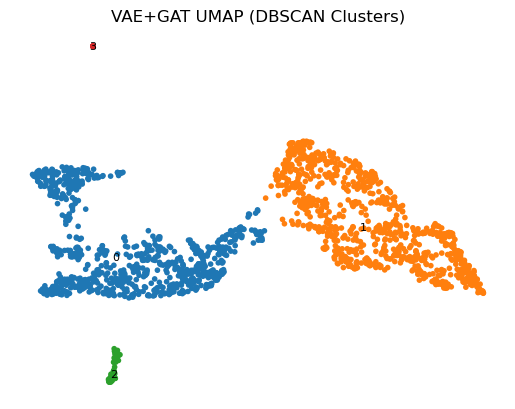


Visualizando PCA UMAP con clusters de DBSCAN:


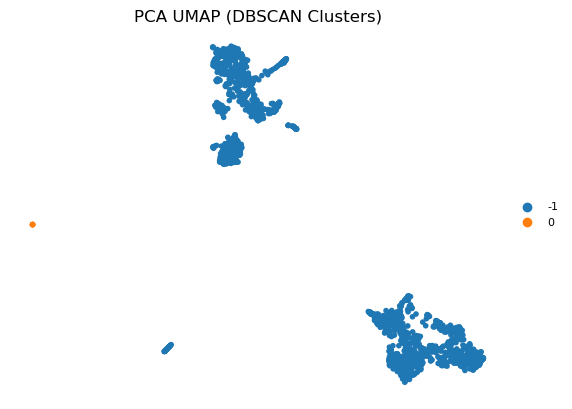

In [81]:
# ==============================================
# Parte 1: Visualización de Clusters (CORREGIDA)
# ==============================================

import matplotlib.pyplot as plt
import seaborn as sns # Importa seaborn para mejores estilos de ploteo si lo deseas

# Asumiendo que adata_filtered, embeddings_umap, labels, pca_embeddings, pca_labels ya existen.
# Corregimos el cálculo de UMAP para PCA y las etiquetas de DBSCAN para PCA y VAE Solo más abajo en la parte 2.
# Por ahora, usamos las variables tal como las calculaste inicialmente para la visualización rápida.

# Añadir embeddings 2D (UMAP) al objeto adata
# Asegúrate de que estos se calcularon antes de esta sección
# VAE+GAT UMAP (calculado en tu código original)
adata_filtered.obsm['X_vae_gat_umap'] = embeddings_umap
# PCA UMAP (calculado en la sección anterior para visualización)
# pca_embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(pca_embeddings) # Ya lo calculamos antes
adata_filtered.obsm['X_pca_umap'] = pca_embeddings_umap # Asegúrate de que esta línea se ejecutó antes


# Añadir etiquetas de clustering (DBSCAN)
# Asegúrate de que estas se calcularon antes de esta sección
# Asegúrate de que las etiquetas sean de tipo Category para Scanpy
adata_filtered.obs['vae_gat_labels'] = pd.Categorical(labels.astype(str))
adata_filtered.obs['pca_labels'] = pd.Categorical(pca_labels.astype(str)) # Usamos las etiquetas calculadas inicialmente


# Manejar el caso donde DBSCAN encuentra solo ruido (-1) o un solo cluster
vae_gat_n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
pca_n_clusters = len(set(pca_labels)) - (1 if -1 in pca_labels else 0)


# Visualizar VAE+GAT UMAP coloreado por clusters de DBSCAN
print("\nVisualizando VAE+GAT UMAP con clusters de DBSCAN:")
# *** CORRECCIÓN: Usar sc.pl.embedding en lugar de sc.pl.umap ***
sc.pl.embedding(adata_filtered,
           basis='X_vae_gat_umap', # Usar la clave EXACTA del UMAP calculado sobre el espacio latente de VAE+GAT
           color='vae_gat_labels', # Colorear por las etiquetas de DBSCAN del VAE+GAT
           title='VAE+GAT UMAP (DBSCAN Clusters)',
           frameon=False, # Sin borde alrededor del plot
           legend_loc='on data' if vae_gat_n_clusters > 1 and vae_gat_n_clusters < 20 else 'right margin', # Leyenda
           legend_fontsize=8, # Ajustar tamaño de fuente si es necesario
           legend_fontweight='normal',
           show=False # No mostrar inmediatamente para poder añadir más cosas si queremos
          )
plt.show() # Mostrar el plot


# Visualizar PCA UMAP coloreado por clusters de DBSCAN
print("\nVisualizando PCA UMAP con clusters de DBSCAN:")
# *** CORRECCIÓN: Usar sc.pl.embedding en lugar de sc.pl.umap ***
sc.pl.embedding(adata_filtered,
           basis='X_pca_umap', # Usar la clave EXACTA del UMAP calculado sobre el espacio latente de PCA
           color='pca_labels', # Colorear por las etiquetas de DBSCAN de PCA
           title='PCA UMAP (DBSCAN Clusters)',
           frameon=False,
           legend_loc='on data' if pca_n_clusters > 1 and pca_n_clusters < 20 else 'right margin',
           legend_fontsize=8,
           legend_fontweight='normal',
           show=False
          )
plt.show() # Mostrar el plot


# --- Fin de la Parte 1 ---

# Modelo VAE

In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import DBSCAN
from scipy import stats
import pandas as pd
from tqdm import tqdm

In [193]:
# Parámetros de la arquitectura y datos de entrada 
n_genes = adata_filtered.shape[1]  # El número de columnas 
input_dim = n_genes
hidden_dim = 128
latent_dim = 64 
learning_rate = 1e-3
num_epochs = 200
X_data = adata_filtered.X  
X = torch.FloatTensor(X_data)

In [194]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.1):
        super(VAE, self).__init__()

        self.fc_enc1 = nn.Linear(input_dim, hidden_dim * 2)
        self.fc_enc2 = nn.Linear(hidden_dim * 2, hidden_dim)

        # Capa para mu y log_var
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        # Capa para p0 (probabilidad de cero)
        self.fc_p0 = nn.Linear(hidden_dim, input_dim)

        # Decoder
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_dec2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc_dec3 = nn.Linear(hidden_dim * 2, input_dim)  # La capa final debe tener input_dim

        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x):
        h = F.elu(self.fc_enc1(x))
        h = self.dropout(h)
        h = F.elu(self.fc_enc2(h))
        h = self.dropout(h)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        p0 = torch.sigmoid(self.fc_p0(h))  # Probabilidad de ser cero (sigmoidea), ajustado al tamaño de entrada
        return mu, log_var, p0

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc_dec1(z))
        h = self.dropout(h)
        h = F.elu(self.fc_dec2(h))
        h = self.dropout(h)
        return self.fc_dec3(h)

    def forward(self, x):
        mu, log_var, p0 = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var, p0


In [103]:
def zinb_loss(recon_x, x, mu, log_var, p0, beta=1.0, theta=1.0):
    # Asegúrate de que x y recon_x sean tensores dispersos
    if isinstance(x, torch.Tensor):
        if x.is_sparse:
            x = x.to_dense()  # Si es disperso, conviértelo a denso
    else:
        x = torch.tensor(x, dtype=torch.float32)  # Convierte x a tensor si no es tensor
    
    if isinstance(recon_x, torch.Tensor):
        if recon_x.is_sparse:
            recon_x = recon_x.to_dense()  # Si es disperso, conviértelo a denso
    else:
        recon_x = torch.tensor(recon_x, dtype=torch.float32)  # Convierte recon_x a tensor si no es tensor

    # Verifica que los datos no sean negativos para aplicar lgamma
    x = torch.abs(x)  # Asegúrate de que no haya valores negativos
    recon_x = torch.abs(recon_x)  # Asegúrate de que no haya valores negativos en recon_x

    # Pérdida Binomial Negativa
    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)  # Ensure theta is a tensor
    theta_tensor = torch.clamp(theta_tensor, min=1e-6, max=1e3)  # Evitar valores extremos en theta
    nb_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - torch.lgamma(theta_tensor) + 
                         x * torch.log(recon_x + 1e-8) + theta_tensor * torch.log(theta_tensor / (recon_x + 1e-8)))

    # Asegúrate de que p0 tenga el mismo tamaño que x
    p0 = p0.expand(x.size(0), x.size(1))  # Expande p0 para que coincida con el tamaño de x

    # Pérdida Bernoulli para ceros
    p0 = torch.clamp(p0, min=1e-5, max=1-1e-5)  # Asegura que p0 esté en un rango válido
    bernoulli_loss = -torch.sum(x * torch.log(1 - p0 + 1e-8) + (1 - x) * torch.log(p0 + 1e-8))

    # Pérdida KL
    mu = torch.clamp(mu, min=-10, max=10)  # Asegura que mu esté dentro de un rango razonable
    log_var = torch.clamp(log_var, min=-10, max=10)  # Asegura que log_var no tenga valores extremos
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Pérdida total con regularización
    total_loss = nb_loss + bernoulli_loss + beta * kl_loss
    return total_loss, nb_loss, bernoulli_loss, kl_loss


In [195]:
def train_model_vae(model, X, optimizer, num_epochs):
    model.train()
    losses, nb_losses, bernoulli_losses, kl_losses = [], [], [], []
    pbar = tqdm(range(num_epochs), desc='Training VAE', leave=True)
    for epoch in pbar:
        optimizer.zero_grad()
        # Se espera que el modelo devuelva 4 valores
        recon_batch, mu, log_var, p0 = model(X)
        loss, nb_loss, bernoulli_loss, kl_loss = zinb_loss(recon_batch, X, mu, log_var, p0)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        nb_losses.append(nb_loss.item())
        bernoulli_losses.append(bernoulli_loss.item())
        kl_losses.append(kl_loss.item())


        pbar.set_postfix({'Total Loss': f'{loss.item():.4f}', 'NB Loss': f'{nb_loss.item():.4f}', 'Bernoulli Loss': f'{bernoulli_loss.item():.4f}', 'KL Loss': f'{kl_loss.item():.4f}'})

    return losses, nb_losses, bernoulli_losses, kl_losses

In [196]:
print("\nEntrenando VAE Solo...")

# Configurar parámetros
input_dim = 2000  # ejemplo, ajusta según tus datos
hidden_dim = 128
latent_dim = 64
learning_rate = 1e-3
num_epochs = 200

vae_model = VAE(input_dim, hidden_dim, latent_dim, dropout_rate=0.1)
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

vae_losses, vae_nb_losses, vae_bernoulli_losses, vae_kl_losses = train_model_vae(vae_model, X, vae_optimizer, num_epochs)



Entrenando VAE Solo...


Training VAE: 100%|██████████| 200/200 [01:23<00:00,  2.39it/s, Total Loss=-2447142.7500, NB Loss=-4099574.2500, Bernoulli Loss=1539166.8750, KL Loss=113264.6328]


In [197]:

vae_model.eval()
with torch.no_grad():
    vae_recon_x, vae_mu, vae_log_var, vae_p0 = vae_model(X)
    vae_embeddings = vae_mu.numpy()  # Espacio latente del VAE solo

In [198]:
# ==============================================
# Clustering con UMAP + DBSCAN 
vae_embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(vae_embeddings)

# DBSCAN para clustering
vae_dbscan = DBSCAN(eps=0.5, min_samples=5).fit(vae_embeddings_umap)
vae_labels = vae_dbscan.labels_

# Calcular métricas de clustering para VAE solo
vae_n_clusters = len(set(vae_labels)) - (1 if -1 in vae_labels else 0)
vae_silhouette = silhouette_score(vae_embeddings_umap, vae_labels) if vae_n_clusters > 1 else -1
vae_calinski_harabasz = calinski_harabasz_score(vae_embeddings_umap, vae_labels) if vae_n_clusters > 1 else -1



c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [199]:
# PCA embeddings
pca = PCA(n_components=64)
pca_embeddings = pca.fit_transform(X.numpy())

# Realizar UMAP 
pca_embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(pca_embeddings)
pca_dbscan = DBSCAN(eps=0.5, min_samples=5).fit(pca_embeddings_umap)
pca_labels = pca_dbscan.labels_

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [200]:
# Calcular métricas de clustering para PCA
pca_n_clusters = len(set(pca_labels)) - (1 if -1 in pca_labels else 0)
pca_silhouette = silhouette_score(pca_embeddings_umap, pca_labels) if pca_n_clusters > 1 else -1
pca_calinski_harabasz = calinski_harabasz_score(pca_embeddings_umap, pca_labels) if pca_n_clusters > 1 else -1

In [201]:
# Crear DataFrame con las métricas de los dos modelos
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'Pearson Correlation', 'Latent Space Normality (p-value)', 
               'Silhouette Score (DBSCAN)', 'Calinski-Harabasz Index (DBSCAN)'],
    'VAE': [vae_mse, vae_pearson_corr, vae_latent_pvalue, vae_silhouette, vae_calinski_harabasz],
    'PCA': [None, None, None, pca_silhouette, pca_calinski_harabasz]
})


In [202]:
# Mostrar las métricas
metrics_df

Metric  \
0                               MSE   
1               Pearson Correlation   
2  Latent Space Normality (p-value)   
3         Silhouette Score (DBSCAN)   
4  Calinski-Harabasz Index (DBSCAN)   

                                                 VAE          PCA  
0                                           0.650391          NaN  
1                                           0.397224          NaN  
2  [3.3815491625416613e-38, 1.7678816036075818e-3...          NaN  
3                                           0.715442     0.661247  
4                                         8636.33765  8695.247394

In [203]:
# Realizamos la reducción de dimensionalidad con UMAP sobre los embeddings latentes del VAE
vae_embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(vae_embeddings)

# Aplicamos DBSCAN para hacer clustering
vae_dbscan = DBSCAN(eps=0.5, min_samples=5).fit(vae_embeddings_umap)
vae_labels = vae_dbscan.labels_

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [204]:
# Calcular métricas de clustering para VAE solo
vae_n_clusters = len(set(vae_labels)) - (1 if -1 in vae_labels else 0)  # Excluyendo el ruido (-1)
vae_silhouette = silhouette_score(vae_embeddings_umap, vae_labels) if vae_n_clusters > 1 else -1
vae_calinski_harabasz = calinski_harabasz_score(vae_embeddings_umap, vae_labels) if vae_n_clusters > 1 else -1

# Mostrar las métricas
print(f"Number of Clusters (VAE): {vae_n_clusters}")
print(f"Silhouette Score (VAE): {vae_silhouette}")
print(f"Calinski-Harabasz Index (VAE): {vae_calinski_harabasz}")

Number of Clusters (VAE): 2
Silhouette Score (VAE): 0.7154417037963867
Calinski-Harabasz Index (VAE): 8636.33765044594


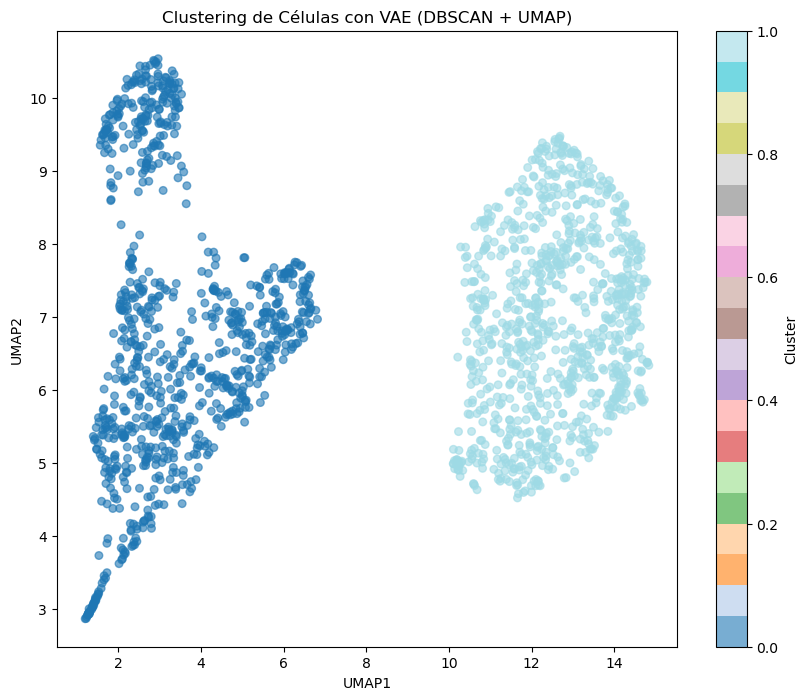

In [205]:
plt.figure(figsize=(10, 8))

# Graficamos los puntos con los colores correspondientes a cada clúster
scatter = plt.scatter(vae_embeddings_umap[:, 0], vae_embeddings_umap[:, 1], c=vae_labels, cmap='tab20', alpha=0.6, s=30)

# Añadir la barra de colores para identificar los clústeres
plt.colorbar(scatter, label='Cluster')

# Títulos y etiquetas
plt.title('Clustering de Células con VAE (DBSCAN + UMAP)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Mostrar el gráfico
plt.show()


Visualizando VAE Solo UMAP con clusters de DBSCAN:


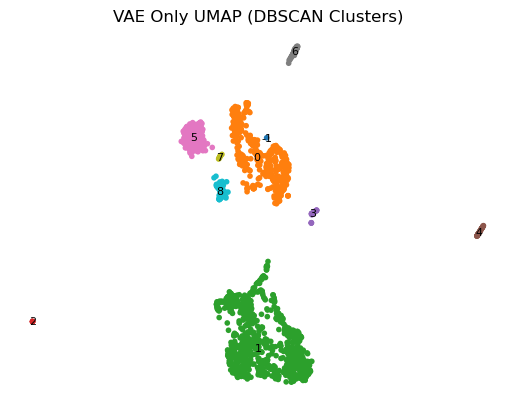


Tabla Comparativa de Métricas:
                          Metric                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [83]:
 
# 8. Visualizar VAE Solo UMAP coloreado por clusters de DBSCAN
#    (CORRECCIÓN DEL ERROR)
# ==========================================================

print("\nVisualizando VAE Solo UMAP con clusters de DBSCAN:")

# Asegúrate de que estas líneas ya se hayan ejecutado antes:
# adata_filtered.obsm['X_vae_only_umap'] = vae_embeddings_umap
# adata_filtered.obs['vae_only_labels'] = pd.Categorical(vae_labels.astype(str))

# --- CORRECCIÓN AQUÍ ---
# Usar sc.pl.embedding en lugar de sc.pl.umap para bases personalizadas
sc.pl.embedding(adata_filtered,
           basis='X_vae_only_umap', # Usar la clave EXACTA donde guardaste el UMAP del VAE solo
           color='vae_only_labels', # Colorear por las etiquetas de DBSCAN del VAE solo
           title='VAE Only UMAP (DBSCAN Clusters)',
           frameon=False,
           legend_loc='on data' if vae_n_clusters > 1 and vae_n_clusters < 20 else 'right margin',
           legend_fontsize=8,
           legend_fontweight='normal',
           show=False # No mostrar inmediatamente
          )
plt.show() # Mostrar el plot


# 9. Tabla de Métricas Comparativa (VAE+GAT vs VAE vs PCA)

metrics_table_comparative = pd.DataFrame({
    'Metric': ['MSE', 'Pearson Correlation', 'Latent Space Normality (p-value)',
               'Silhouette Score (DBSCAN)', 'Calinski-Harabasz Index (DBSCAN)'],
    'VAE+GAT': [mse, pearson_corr, latent_pvalue, silhouette, calinski_harabasz], # Resultados de tu código original
    'VAE Only': [vae_mse, vae_pearson_corr, vae_latent_pvalue, vae_silhouette, vae_calinski_harabasz], # Resultados del VAE solo
    'PCA': [None, None, None, pca_silhouette_corrected, pca_calinski_harabasz_corrected] # Resultados de PCA (clustering corregido)
})

print('\nTabla Comparativa de Métricas:')
print(metrics_table_comparative.to_string(index=False))

In [84]:
metrics_table_comparative

Metric  \
0                               MSE   
1               Pearson Correlation   
2  Latent Space Normality (p-value)   
3         Silhouette Score (DBSCAN)   
4  Calinski-Harabasz Index (DBSCAN)   

                                             VAE+GAT  \
0                                           0.722571   
1                                           0.253778   
2  [4.232815060590662e-45, 1.4995466190970005e-15...   
3                                           0.485163   
4                                        1483.534859   

                                            VAE Only          PCA  
0                                           0.650258          NaN  
1                                           0.397791          NaN  
2  [5.366620631192863e-53, 3.8430063361014654e-13...          NaN  
3                                           0.461423     0.661247  
4                                        2070.295545  8695.247394

Comparaciones

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import DBSCAN
from scipy import stats
import pandas as pd
from tqdm import tqdm
from torch_geometric.nn import GATConv
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

# ==============================================
# Modelo VAE con GAT (sin GCNConv)
# ==============================================
class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate=0.1):
        super(VAE_GAT, self).__init__()
        # Usar solo las capas GAT
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)

        # Capa para el mu y log_var
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)

        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))  # Aplicar GAT
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))  # Aplicar GAT nuevamente
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.dropout(h)
        h = F.elu(self.fc2(h))
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# ==============================================
# Función de Pérdida con Binomial Negativa y KL
# ==============================================
import torch

def loss_function(recon_x, x, mu, log_var, beta=1.0, theta=1.0):
    # Asegúrate de que x y recon_x sean tensores dispersos
    if isinstance(x, torch.Tensor):
        if x.is_sparse:
            x = x.to_dense()  # Si es disperso, conviértelo a denso
    else:
        x = torch.tensor(x, dtype=torch.float32)  # Convierte x a tensor si no es tensor
    
    if isinstance(recon_x, torch.Tensor):
        if recon_x.is_sparse:
            recon_x = recon_x.to_dense()  # Si es disperso, conviértelo a denso
    else:
        recon_x = torch.tensor(recon_x, dtype=torch.float32)  # Convierte recon_x a tensor si no es tensor

    # Verifica que los datos no sean negativos para aplicar lgamma
    # La distribución Binomial Negativa requiere datos positivos
    x = torch.abs(x)  # Asegúrate de que no haya valores negativos

    # Pérdida Binomial Negativa
    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)  # Ensure theta is a tensor
    recon_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - torch.lgamma(theta_tensor) + 
                            x * torch.log(recon_x + 1e-8) + theta_tensor * torch.log(theta_tensor / (recon_x + 1e-8)))

    # Pérdida KL
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Pérdida total con regularización
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

# ==============================================
# Entrenamiento del Modelo
# ==============================================
def train_model(model, X, edge_index, optimizer, num_epochs, beta=1.0):
    model.train()
    losses, recon_losses, kl_losses = [], [], []
    pbar = tqdm(range(num_epochs), desc='Training', leave=True)
    
    for epoch in pbar:
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X, edge_index)
        loss, recon_loss, kl_loss = loss_function(recon_batch, X, mu, log_var, beta=beta)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        kl_losses.append(kl_loss.item())
        pbar.set_postfix({'Total Loss': f'{loss.item():.4f}', 'Recon Loss': f'{recon_loss.item():.4f}', 'KL Loss': f'{kl_loss.item():.4f}'})

    return losses, recon_losses, kl_losses

# ==============================================
# Configuración del Modelo
# ==============================================
n_genes = adata_filtered.shape[1]  # El número de columnas en adata_filtered.X
input_dim = n_genes
hidden_dim = 128
latent_dim = 64
num_heads = 4
learning_rate = 1e-3
num_epochs = 200

model = VAE_GAT(input_dim, hidden_dim, latent_dim, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ==============================================
# Construcción de edge_index con KNN
# ==============================================
X_data = adata_filtered.X  # Convertir a matriz densa si es necesario
X = torch.FloatTensor(X_data)  # Asegúrate de que X sea un tensor de PyTorch
n_neighbors = 10
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(X_data)
distances, indices = knn.kneighbors(X_data)
edge_index = torch.tensor([indices.flatten(), np.tile(np.arange(X_data.shape[0]), n_neighbors)], dtype=torch.long)

# ==============================================
# Experimentar con diferentes valores de beta
# ==============================================
beta_values = [0.1, 1.0, 2.0]
results = []

for beta in beta_values:
    print(f"Entrenando con beta = {beta}...")
    losses, recon_losses, kl_losses = train_model(model, X, edge_index, optimizer, num_epochs, beta=beta)
    
    # Evaluar el modelo después del entrenamiento
    model.eval()
    with torch.no_grad():
        recon_x, mu, log_var = model(X, edge_index)
    
    # Métricas
    mse = mean_squared_error(X.numpy().flatten(), recon_x.numpy().flatten())
    pearson_corr = np.corrcoef(X.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
    latent_distribution = stats.normaltest(mu.numpy())
    latent_pvalue = latent_distribution.pvalue

    # Clustering con UMAP + DBSCAN
    embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(mu.numpy())
    dbscan = DBSCAN(eps=0.5, min_samples=5).fit(embeddings_umap)
    labels = dbscan.labels_
    silhouette = silhouette_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1
    calinski_harabasz = calinski_harabasz_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1

    # Almacenar los resultados
    results.append({
        'beta': beta,
        'MSE': mse,
        'Pearson Correlation': pearson_corr,
        'Latent Space Normality (p-value)': latent_pvalue,
        'Silhouette Score (DBSCAN)': silhouette,
        'Calinski-Harabasz Index (DBSCAN)': calinski_harabasz
    })

# Crear DataFrame con los resultados
results_df = pd.DataFrame(results)

# Mostrar la tabla de métricas
# import ace_tools as tools; tools.display_dataframe_to_user(name="Model Comparison Results", dataframe=results_df)


Entrenando con beta = 0.1...


Training: 100%|██████████| 200/200 [02:16<00:00,  1.47it/s, Total Loss=nan, Recon Loss=nan, KL Loss=5343146.0000]  
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Entrenando con beta = 1.0...


Training: 100%|██████████| 200/200 [01:47<00:00,  1.85it/s, Total Loss=nan, Recon Loss=nan, KL Loss=4017419.0000]  
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Entrenando con beta = 2.0...


Training: 100%|██████████| 200/200 [02:48<00:00,  1.19it/s, Total Loss=nan, Recon Loss=nan, KL Loss=399190.5938] 
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


ModuleNotFoundError: No module named 'ace_tools'

In [91]:
!pip install ace_tools

In [93]:
import ace_tools as tools


ModuleNotFoundError: No module named 'ace_tools'

In [95]:
results_df

beta       MSE  Pearson Correlation  \
0   0.1  1.454424             0.000799   
1   1.0  3.238629             0.000391   
2   2.0  2.796251             0.000229   

                    Latent Space Normality (p-value)  \
0  [4.34049354375398e-88, 4.1501596287924376e-117...   
1  [0.0, 0.0, 5.408748733549898e-17, 0.0, 2.64981...   
2  [3.8357067032176736e-238, 0.0, 3.1786657456601...   

   Silhouette Score (DBSCAN)  Calinski-Harabasz Index (DBSCAN)  
0                   0.264155                       2191.637819  
1                   0.476595                       7475.751399  
2                   0.472297                      13588.306770

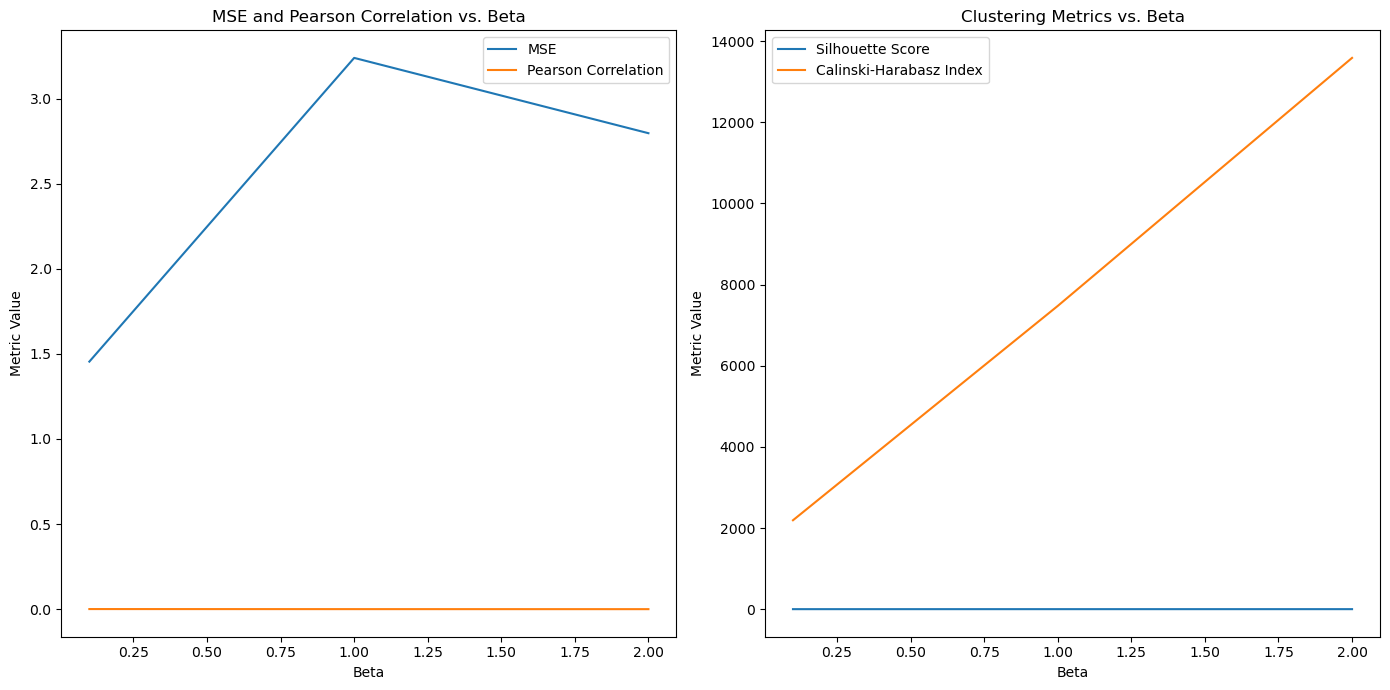

In [96]:
# # Mostrar la tabla de métricas
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Model Comparison Results", dataframe=results_df)

# ==============================================
# Visualización Gráfica de los Resultados
# ==============================================
import matplotlib.pyplot as plt

# Graficar las métricas de los resultados
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Graficar MSE y Pearson Correlation vs. Beta
ax[0].plot(results_df['beta'], results_df['MSE'], label='MSE')
ax[0].plot(results_df['beta'], results_df['Pearson Correlation'], label='Pearson Correlation')
ax[0].set_xlabel('Beta')
ax[0].set_ylabel('Metric Value')
ax[0].set_title('MSE and Pearson Correlation vs. Beta')
ax[0].legend()

# Graficar Silhouette Score y Calinski-Harabasz vs. Beta
ax[1].plot(results_df['beta'], results_df['Silhouette Score (DBSCAN)'], label='Silhouette Score')
ax[1].plot(results_df['beta'], results_df['Calinski-Harabasz Index (DBSCAN)'], label='Calinski-Harabasz Index')
ax[1].set_xlabel('Beta')
ax[1].set_ylabel('Metric Value')
ax[1].set_title('Clustering Metrics vs. Beta')
ax[1].legend()

plt.tight_layout()
plt.show()

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scanpy as sc
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
import umap
from sklearn.cluster import DBSCAN
from scipy import stats
import pandas as pd
from tqdm import tqdm
from torch_geometric.nn import GATConv
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

# ==============================================
# Modelo VAE con GAT (sin GCNConv)
# ==============================================
class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate=0.1):
        super(VAE_GAT, self).__init__()
        # Usar solo las capas GAT
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)

        # Capa para el mu y log_var
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)

        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))  # Aplicar GAT
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))  # Aplicar GAT nuevamente
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.dropout(h)
        h = F.elu(self.fc2(h))
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# ==============================================
# Función de Pérdida con Binomial Negativa y KL
# ==============================================
def loss_function(recon_x, x, mu, log_var, beta=1.0, theta=1.0):
    # Asegúrate de que x y recon_x sean tensores dispersos
    if isinstance(x, torch.Tensor):
        if x.is_sparse:
            x = x.to_dense()  # Si es disperso, conviértelo a denso
    else:
        x = torch.tensor(x, dtype=torch.float32)  # Convierte x a tensor si no es tensor
    
    if isinstance(recon_x, torch.Tensor):
        if recon_x.is_sparse:
            recon_x = recon_x.to_dense()  # Si es disperso, conviértelo a denso
    else:
        recon_x = torch.tensor(recon_x, dtype=torch.float32)  # Convierte recon_x a tensor si no es tensor

    # Verifica que los datos no sean negativos para aplicar lgamma
    # La distribución Binomial Negativa requiere datos positivos
    x = torch.abs(x)  # Asegúrate de que no haya valores negativos

    # Pérdida Binomial Negativa
    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)  # Ensure theta is a tensor
    recon_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - torch.lgamma(theta_tensor) + 
                            x * torch.log(recon_x + 1e-8) + theta_tensor * torch.log(theta_tensor / (recon_x + 1e-8)))

    # Pérdida KL
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Pérdida total con regularización
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

# ==============================================
# Entrenamiento del Modelo
# ==============================================
def train_model(model, X, edge_index, optimizer, num_epochs, beta=1.0):
    model.train()
    losses, recon_losses, kl_losses = [], [], []
    pbar = tqdm(range(num_epochs), desc='Training', leave=True)
    
    for epoch in pbar:
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X, edge_index)
        loss, recon_loss, kl_loss = loss_function(recon_batch, X, mu, log_var, beta=beta)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        kl_losses.append(kl_loss.item())
        pbar.set_postfix({'Total Loss': f'{loss.item():.4f}', 'Recon Loss': f'{recon_loss.item():.4f}', 'KL Loss': f'{kl_loss.item():.4f}'})

    return losses, recon_losses, kl_losses

# ==============================================
# Configuración del Modelo
# ==============================================
n_genes = adata_filtered.shape[1]  # El número de columnas en adata_filtered.X
input_dim = n_genes
hidden_dim = 128
latent_dim = 64
num_heads = 4
learning_rate = 1e-3
num_epochs = 200

model = VAE_GAT(input_dim, hidden_dim, latent_dim, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ==============================================
# Construcción de edge_index con KNN
# ==============================================
X_data = adata_filtered.X  # Convertir a matriz densa si es necesario
X = torch.FloatTensor(X_data)  # Asegúrate de que X sea un tensor de PyTorch
n_neighbors = 10
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(X_data)
distances, indices = knn.kneighbors(X_data)
edge_index = torch.tensor([indices.flatten(), np.tile(np.arange(X_data.shape[0]), n_neighbors)], dtype=torch.long)

# ==============================================
# Experimentar con diferentes valores de beta
# ==============================================
beta_values = [0.1, 1.0, 2.0]
results = []

for beta in beta_values:
    print(f"Entrenando con beta = {beta}...")
    losses, recon_losses, kl_losses = train_model(model, X, edge_index, optimizer, num_epochs, beta=beta)
    
    # Evaluar el modelo después del entrenamiento
    model.eval()
    with torch.no_grad():
        recon_x, mu, log_var = model(X, edge_index)
    
    # Métricas
    mse = mean_squared_error(X.numpy().flatten(), recon_x.numpy().flatten())
    pearson_corr = np.corrcoef(X.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
    latent_distribution = stats.normaltest(mu.numpy())
    latent_pvalue = latent_distribution.pvalue

    # Clustering con UMAP + DBSCAN
    embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(mu.numpy())
    dbscan = DBSCAN(eps=0.5, min_samples=5).fit(embeddings_umap)
    labels = dbscan.labels_
    silhouette = silhouette_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1
    calinski_harabasz = calinski_harabasz_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1

    # Almacenar los resultados
    results.append({
        'beta': beta,
        'MSE': mse,
        'Pearson Correlation': pearson_corr,
        'Latent Space Normality (p-value)': latent_pvalue,
        'Silhouette Score (DBSCAN)': silhouette,
        'Calinski-Harabasz Index (DBSCAN)': calinski_harabasz
    })

# Crear DataFrame con los resultados
results_df = pd.DataFrame(results)


Entrenando con beta = 0.1...


Training: 100%|██████████| 200/200 [03:43<00:00,  1.12s/it, Total Loss=nan, Recon Loss=nan, KL Loss=1412667.8750]  
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Entrenando con beta = 1.0...


Training: 100%|██████████| 200/200 [01:36<00:00,  2.08it/s, Total Loss=nan, Recon Loss=nan, KL Loss=470031.4688] 
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Entrenando con beta = 2.0...


Training: 100%|██████████| 200/200 [01:29<00:00,  2.24it/s, Total Loss=nan, Recon Loss=nan, KL Loss=612222.0000] 
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [98]:
results_df

beta       MSE  Pearson Correlation  \
0   0.1  1.593627             0.000419   
1   1.0  1.856308             0.000233   
2   2.0  2.831194            -0.000787   

                    Latent Space Normality (p-value)  \
0  [6.958425081184216e-05, 8.911862546472004e-57,...   
1  [1.8015656337328592e-130, 2.3353590181495415e-...   
2  [0.0, 1.5522975549189165e-261, 4.0247912919576...   

   Silhouette Score (DBSCAN)  Calinski-Harabasz Index (DBSCAN)  
0                   0.275136                       3216.123796  
1                   0.048608                       1237.153666  
2                   0.440797                      23218.652199

ZINB

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scanpy as sc
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import umap
from sklearn.cluster import DBSCAN
from scipy import stats
import pandas as pd
from tqdm import tqdm
from torch_geometric.nn import GATConv
from sklearn.neighbors import NearestNeighbors

# ==============================================
# Modelo VAE con GAT (sin GCNConv)
# ==============================================
class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate=0.1):
        super(VAE_GAT, self).__init__()
        # Usar solo las capas GAT
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)

        # Capa para el mu, log_var y p0
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.fc_p0 = nn.Linear(hidden_dim, input_dim)  # Probabilidad de ser cero

        # Decoder
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)

        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))  # Aplicar GAT
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))  # Aplicar GAT nuevamente
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p0 = torch.sigmoid(self.fc_p0(x))  # Predicción de la probabilidad de cero (sigmoidea), ajustada al tamaño de entrada
        return mu, log_var, p0

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.dropout(h)
        h = F.elu(self.fc2(h))
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var, p0 = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var, p0

# ==============================================
# Zero-Inflated Negative Binomial (ZINB) Loss
# ==============================================
def zinb_loss(recon_x, x, mu, log_var, p0, beta=1.0, theta=1.0):
    # Asegúrate de que x y recon_x sean tensores dispersos
    if isinstance(x, torch.Tensor):
        if x.is_sparse:
            x = x.to_dense()  # Si es disperso, conviértelo a denso
    else:
        x = torch.tensor(x, dtype=torch.float32)  # Convierte x a tensor si no es tensor
    
    if isinstance(recon_x, torch.Tensor):
        if recon_x.is_sparse:
            recon_x = recon_x.to_dense()  # Si es disperso, conviértelo a denso
    else:
        recon_x = torch.tensor(recon_x, dtype=torch.float32)  # Convierte recon_x a tensor si no es tensor

    # Verifica que los datos no sean negativos para aplicar lgamma
    x = torch.abs(x)  # Asegúrate de que no haya valores negativos en x
    recon_x = torch.abs(recon_x)  # Asegúrate de que no haya valores negativos en recon_x

    # Pérdida Binomial Negativa
    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)  # Ensure theta is a tensor
    theta_tensor = torch.clamp(theta_tensor, min=1e-6, max=1e3)  # Evitar valores extremos en theta
    nb_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - torch.lgamma(theta_tensor) + 
                         x * torch.log(recon_x + 1e-8) + theta_tensor * torch.log(theta_tensor / (recon_x + 1e-8)))

    # Asegúrate de que p0 tenga el mismo tamaño que x
    # Si p0 es de tamaño (1823, 64), necesitamos replicarlo para que tenga el mismo tamaño que x
    p0 = p0.expand(x.size(0), x.size(1))  # Expande p0 para que coincida con el tamaño de x

    # Pérdida Bernoulli para ceros
    p0 = torch.clamp(p0, min=1e-5, max=1-1e-5)  # Asegura que p0 esté en un rango válido
    bernoulli_loss = -torch.sum(x * torch.log(1 - p0 + 1e-8) + (1 - x) * torch.log(p0 + 1e-8))

    # Pérdida KL
    mu = torch.clamp(mu, min=-10, max=10)  # Asegura que mu esté dentro de un rango razonable
    log_var = torch.clamp(log_var, min=-10, max=10)  # Asegura que log_var no tenga valores extremos
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Pérdida total con regularización
    total_loss = nb_loss + bernoulli_loss + beta * kl_loss
    return total_loss, nb_loss, bernoulli_loss, kl_loss

# ==============================================
# Entrenamiento del Modelo
# ==============================================
def train_model(model, X, edge_index, optimizer, num_epochs, beta=1.0):
    model.train()
    losses, nb_losses, bernoulli_losses, kl_losses = [], [], [], []
    pbar = tqdm(range(num_epochs), desc='Training', leave=True)
    
    for epoch in pbar:
        optimizer.zero_grad()
        recon_batch, mu, log_var, p0 = model(X, edge_index)
        loss, nb_loss, bernoulli_loss, kl_loss = zinb_loss(recon_batch, X, mu, log_var, p0, beta=beta)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        nb_losses.append(nb_loss.item())
        bernoulli_losses.append(bernoulli_loss.item())
        kl_losses.append(kl_loss.item())
        pbar.set_postfix({'Total Loss': f'{loss.item():.4f}', 'NB Loss': f'{nb_loss.item():.4f}', 'Bernoulli Loss': f'{bernoulli_loss.item():.4f}', 'KL Loss': f'{kl_loss.item():.4f}'})

    return losses, nb_losses, bernoulli_losses, kl_losses

# ==============================================
# Configuración del Modelo
# ==============================================
n_genes = adata_filtered.shape[1]  # El número de columnas en adata_filtered.X
input_dim = n_genes
hidden_dim = 128
latent_dim = 64
num_heads = 4
learning_rate = 1e-3
num_epochs = 200

model = VAE_GAT(input_dim, hidden_dim, latent_dim, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ==============================================
# Construcción de edge_index con KNN
# ==============================================
X_data = adata_filtered.X  # Convertir a matriz densa si es necesario
X = torch.FloatTensor(X_data)  # Asegúrate de que X sea un tensor de PyTorch
n_neighbors = 10
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(X_data)
distances, indices = knn.kneighbors(X_data)
edge_index = torch.tensor([indices.flatten(), np.tile(np.arange(X_data.shape[0]), n_neighbors)], dtype=torch.long)

# ==============================================
# Experimentar con diferentes valores de beta
# ==============================================
beta_values = [0.1, 1.0, 2.0]
results = []

for beta in beta_values:
    print(f"Entrenando con beta = {beta}...")
    losses, nb_losses, bernoulli_losses, kl_losses = train_model(model, X, edge_index, optimizer, num_epochs, beta=beta)
    
    # Evaluar el modelo después del entrenamiento
    model.eval()
    with torch.no_grad():
        recon_x, mu, log_var, p0 = model(X, edge_index)
    
    # Métricas
    mse = mean_squared_error(X.numpy().flatten(), recon_x.numpy().flatten())
    pearson_corr = np.corrcoef(X.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
    latent_distribution = stats.normaltest(mu.numpy())
    latent_pvalue = latent_distribution.pvalue

    # Clustering con UMAP + DBSCAN
    embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(mu.numpy())
    dbscan = DBSCAN(eps=0.5, min_samples=5).fit(embeddings_umap)
    labels = dbscan.labels_
    silhouette = silhouette_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1
    calinski_harabasz = calinski_harabasz_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1

    # Almacenar los resultados
    results.append({
        'beta': beta,
        'MSE': mse,
        'Pearson Correlation': pearson_corr,
        'Latent Space Normality (p-value)': latent_pvalue,
        'Silhouette Score (DBSCAN)': silhouette,
        'Calinski-Harabasz Index (DBSCAN)': calinski_harabasz
    })

# Crear DataFrame con los resultados
results_df = pd.DataFrame(results)


Entrenando con beta = 0.1...


Training: 100%|██████████| 200/200 [02:02<00:00,  1.63it/s, Total Loss=-783085.8750, NB Loss=-2925827.0000, Bernoulli Loss=2103885.2500, KL Loss=388558.5312]  
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Entrenando con beta = 1.0...


Training: 100%|██████████| 200/200 [02:06<00:00,  1.58it/s, Total Loss=919032.5000, NB Loss=-1442821.7500, Bernoulli Loss=2046030.6250, KL Loss=315823.6250] 
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Entrenando con beta = 2.0...


Training: 100%|██████████| 200/200 [01:53<00:00,  1.77it/s, Total Loss=-149953.1250, NB Loss=-2657845.7500, Bernoulli Loss=2033176.0000, KL Loss=237358.3125] 
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [105]:
results_df

beta       MSE  Pearson Correlation  \
0   0.1  1.087057             0.000340   
1   1.0  2.115196            -0.000032   
2   2.0  1.261309            -0.000348   

                    Latent Space Normality (p-value)  \
0  [2.0478782152677815e-53, 5.895578781572014e-93...   
1  [5.5384992439583e-67, 5.201742551949054e-39, 1...   
2  [1.1421598520897538e-79, 3.261177128023682e-20...   

   Silhouette Score (DBSCAN)  Calinski-Harabasz Index (DBSCAN)  
0                   0.372905                       2345.714119  
1                   0.339683                       3592.571168  
2                   0.059758                       2994.762563


Entrenando VAE Solo...


Training VAE:   0%|          | 0/200 [00:00<?, ?it/s]

Training VAE: 100%|██████████| 200/200 [01:39<00:00,  2.01it/s, Total Loss=-3152893.0000, NB Loss=-4769362.0000, Bernoulli Loss=1574855.6250, KL Loss=41613.6133]


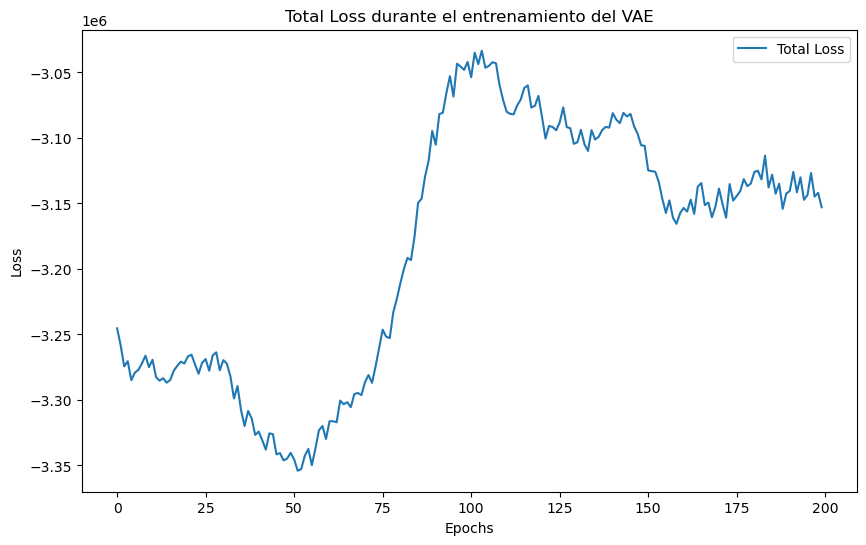

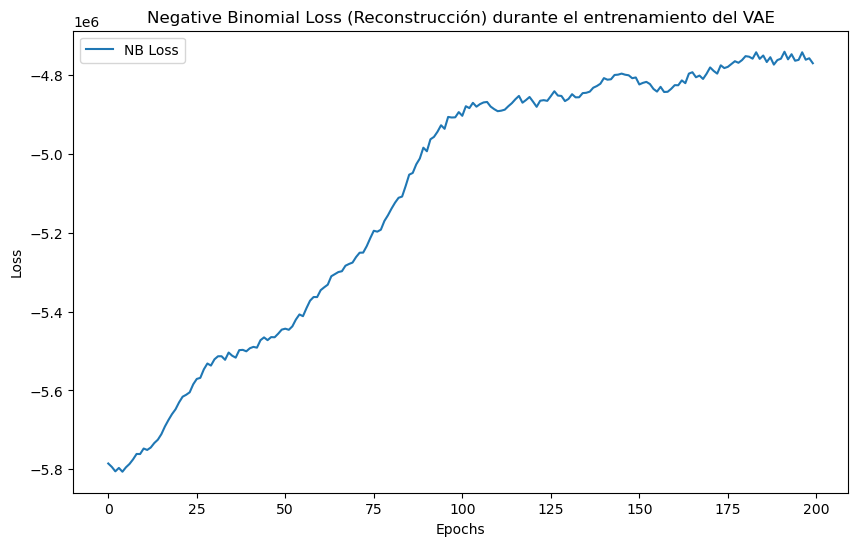

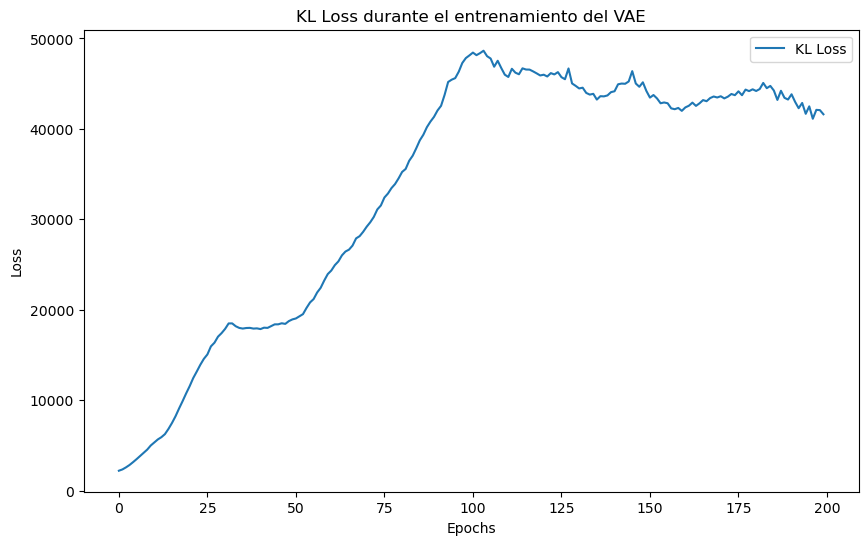

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy import stats
from tqdm import tqdm

# ==============================================
# Modelo VAE Solo (sin GAT) con ZINB Loss
# ==============================================

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.1):
        super(VAE, self).__init__()

        # Encoder con capas lineales estándar
        self.fc_enc1 = nn.Linear(input_dim, hidden_dim * 2)
        self.fc_enc2 = nn.Linear(hidden_dim * 2, hidden_dim)

        # Capa para el mu y log_var
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.fc_p0 = nn.Linear(hidden_dim, input_dim)  # Probabilidad de ser cero (p0)

        # Decoder
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_dec2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc_dec3 = nn.Linear(hidden_dim * 2, input_dim)  # La capa final debe tener input_dim

        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x):
        h = F.elu(self.fc_enc1(x))
        h = self.dropout(h)
        h = F.elu(self.fc_enc2(h))
        h = self.dropout(h)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        p0 = torch.sigmoid(self.fc_p0(h))  # Probabilidad de ser cero (sigmoidea), expanded to match input_dim
        return mu, log_var, p0

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc_dec1(z))
        h = self.dropout(h)
        h = F.elu(self.fc_dec2(h))
        h = self.dropout(h)
        return self.fc_dec3(h)

    def forward(self, x):
        mu, log_var, p0 = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var, p0


# ==============================================
# Zero-Inflated Negative Binomial (ZINB) Loss
# ==============================================

def zinb_loss(recon_x, x, mu, log_var, p0, beta=1.0, theta=1.0):
    # Asegúrate de que x y recon_x sean tensores dispersos
    if isinstance(x, torch.Tensor):
        if x.is_sparse:
            x = x.to_dense()  # Si es disperso, conviértelo a denso
    else:
        x = torch.tensor(x, dtype=torch.float32)  # Convierte x a tensor si no es tensor
    
    if isinstance(recon_x, torch.Tensor):
        if recon_x.is_sparse:
            recon_x = recon_x.to_dense()  # Si es disperso, conviértelo a denso
    else:
        recon_x = torch.tensor(recon_x, dtype=torch.float32)  # Convierte recon_x a tensor si no es tensor

    # Verifica que los datos no sean negativos para aplicar lgamma
    x = torch.abs(x)  # Asegúrate de que no haya valores negativos
    recon_x = torch.abs(recon_x)  # Asegúrate de que no haya valores negativos en recon_x

    # Pérdida Binomial Negativa
    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)  # Ensure theta is a tensor
    theta_tensor = torch.clamp(theta_tensor, min=1e-6, max=1e3)  # Evitar valores extremos en theta
    nb_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - torch.lgamma(theta_tensor) + 
                         x * torch.log(recon_x + 1e-8) + theta_tensor * torch.log(theta_tensor / (recon_x + 1e-8)))

    # Asegúrate de que p0 tenga el mismo tamaño que x
    p0 = p0.expand(x.size(0), x.size(1))  # Expande p0 para que coincida con el tamaño de x

    # Pérdida Bernoulli para ceros
    p0 = torch.clamp(p0, min=1e-5, max=1-1e-5)  # Asegura que p0 esté en un rango válido
    bernoulli_loss = -torch.sum(x * torch.log(1 - p0 + 1e-8) + (1 - x) * torch.log(p0 + 1e-8))

    # Pérdida KL
    mu = torch.clamp(mu, min=-10, max=10)  # Asegura que mu esté dentro de un rango razonable
    log_var = torch.clamp(log_var, min=-10, max=10)  # Asegura que log_var no tenga valores extremos
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Pérdida total con regularización
    total_loss = nb_loss + bernoulli_loss + beta * kl_loss
    return total_loss, nb_loss, bernoulli_loss, kl_loss


# ==============================================
# Entrenamiento del Modelo VAE Solo
# ==============================================

def train_model_vae(model, X, optimizer, num_epochs):
    model.train()
    losses, nb_losses, bernoulli_losses, kl_losses = [], [], [], []
    pbar = tqdm(range(num_epochs), desc='Training VAE', leave=True)
    for epoch in pbar:
        optimizer.zero_grad()
        recon_batch, mu, log_var, p0 = model(X)
        loss, nb_loss, bernoulli_loss, kl_loss = zinb_loss(recon_batch, X, mu, log_var, p0)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        nb_losses.append(nb_loss.item())
        bernoulli_losses.append(bernoulli_loss.item())
        kl_losses.append(kl_loss.item())

        pbar.set_postfix({'Total Loss': f'{loss.item():.4f}', 'NB Loss': f'{nb_loss.item():.4f}', 'Bernoulli Loss': f'{bernoulli_loss.item():.4f}', 'KL Loss': f'{kl_loss.item():.4f}'})

    return losses, nb_losses, bernoulli_losses, kl_losses


# ==============================================
# Configuración e Entrenamiento del VAE Solo
# ==============================================

print("\nEntrenando VAE Solo...")

# Configurar parámetros
input_dim = 2000  # ejemplo, ajusta según tus datos
hidden_dim = 128
latent_dim = 64
learning_rate = 1e-3
num_epochs = 200

vae_model = VAE(input_dim, hidden_dim, latent_dim, dropout_rate=0.1)
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

# Entrenamiento del VAE
vae_losses, vae_nb_losses, vae_bernoulli_losses, vae_kl_losses = train_model_vae(vae_model, X, vae_optimizer, num_epochs)


# ==============================================
# Generación de Embeddings del VAE Solo
# ==============================================

vae_model.eval()
with torch.no_grad():
    vae_recon_x, vae_mu, vae_log_var, vae_p0 = vae_model(X)
    vae_embeddings = vae_mu.numpy()  # Espacio latente del VAE solo


# ==============================================
# Mostrar las métricas de pérdida y gráficas
# ==============================================

# 1. Gráfica de la pérdida total
plt.figure(figsize=(10, 6))
plt.plot(vae_losses, label="Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Total Loss durante el entrenamiento del VAE")
plt.legend()
plt.show()

# 2. Gráfica de la pérdida de reconstrucción
plt.figure(figsize=(10, 6))
plt.plot(vae_nb_losses, label="NB Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Negative Binomial Loss (Reconstrucción) durante el entrenamiento del VAE")
plt.legend()
plt.show()

# 3. Gráfica de la pérdida de KL
plt.figure(figsize=(10, 6))
plt.plot(vae_kl_losses, label="KL Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("KL Loss durante el entrenamiento del VAE")
plt.legend()
plt.show()



Entrenando VAE Solo...


Training VAE:   0%|          | 0/200 [00:00<?, ?it/s]

Training VAE: 100%|██████████| 200/200 [01:49<00:00,  1.83it/s, Total Loss=-2975824.0000, NB Loss=-4582848.5000, Bernoulli Loss=1563569.7500, KL Loss=43454.7109]
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Number of Clusters: 3
Silhouette Score: 0.5317607522010803
Calinski-Harabasz Index: 5374.141878332448


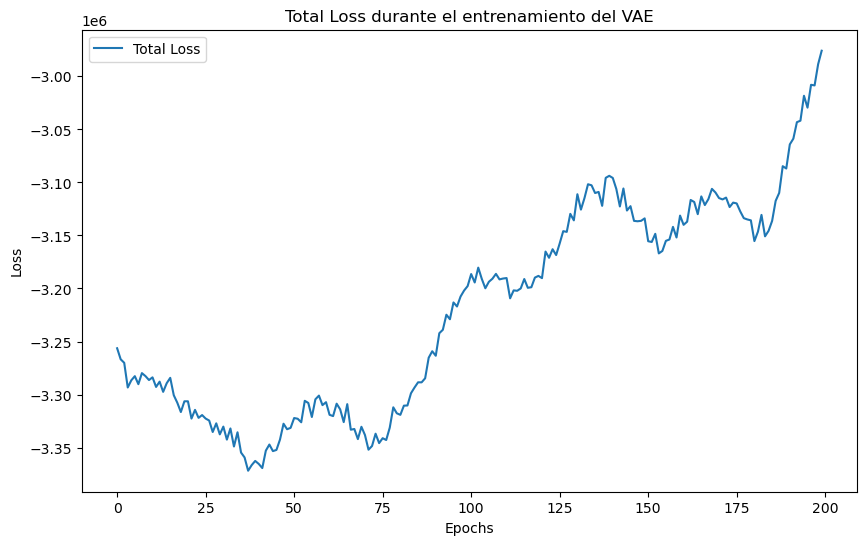

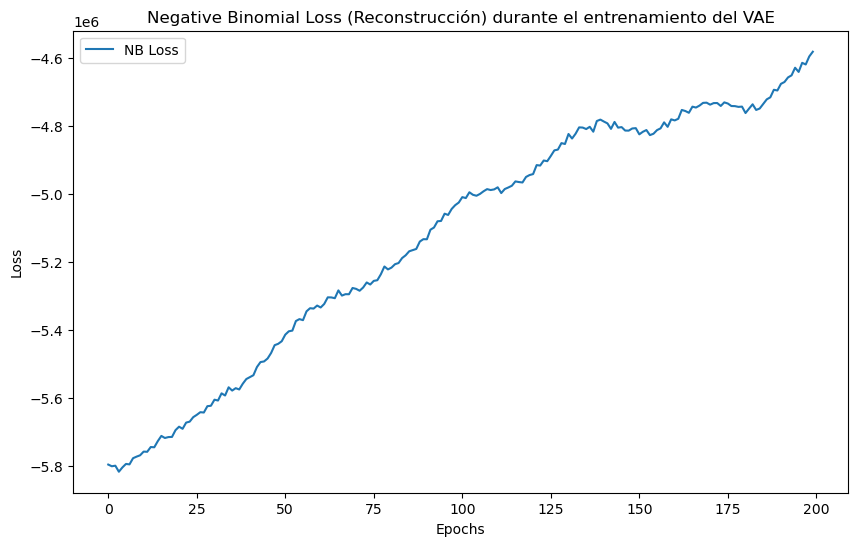

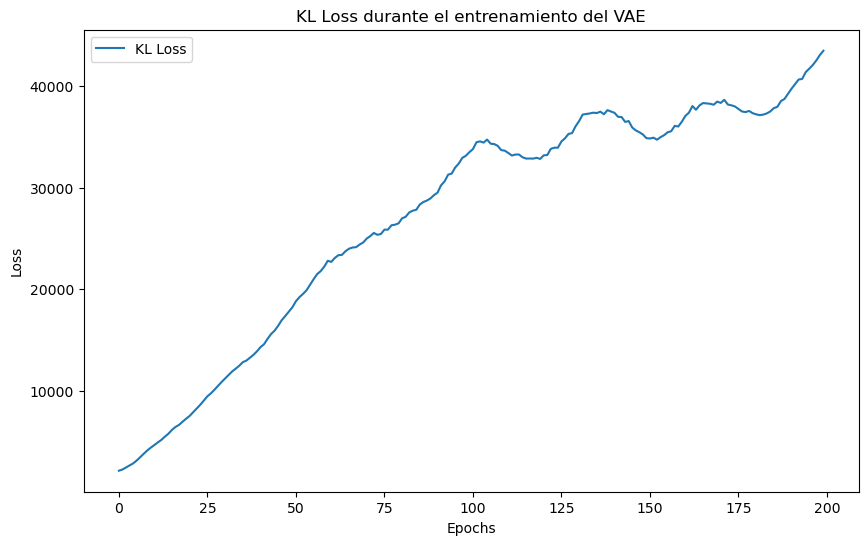

In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy import stats
from tqdm import tqdm
import pandas as pd

# ==============================================
# Modelo VAE Solo (sin GAT) con ZINB Loss
# ==============================================

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.1):
        super(VAE, self).__init__()

        # Encoder con capas lineales estándar
        self.fc_enc1 = nn.Linear(input_dim, hidden_dim * 2)
        self.fc_enc2 = nn.Linear(hidden_dim * 2, hidden_dim)

        # Capa para el mu y log_var
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.fc_p0 = nn.Linear(hidden_dim, input_dim)  # Probabilidad de ser cero (p0)

        # Decoder
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_dec2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc_dec3 = nn.Linear(hidden_dim * 2, input_dim)  # La capa final debe tener input_dim

        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x):
        h = F.elu(self.fc_enc1(x))
        h = self.dropout(h)
        h = F.elu(self.fc_enc2(h))
        h = self.dropout(h)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        p0 = torch.sigmoid(self.fc_p0(h))  # Probabilidad de ser cero (sigmoidea), now matching input_dim
        return mu, log_var, p0

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc_dec1(z))
        h = self.dropout(h)
        h = F.elu(self.fc_dec2(h))
        h = self.dropout(h)
        return self.fc_dec3(h)

    def forward(self, x):
        mu, log_var, p0 = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var, p0


# ==============================================
# Zero-Inflated Negative Binomial (ZINB) Loss
# ==============================================

def zinb_loss(recon_x, x, mu, log_var, p0, beta=1.0, theta=1.0):
    # Asegúrate de que x y recon_x sean tensores dispersos
    if isinstance(x, torch.Tensor):
        if x.is_sparse:
            x = x.to_dense()  # Si es disperso, conviértelo a denso
    else:
        x = torch.tensor(x, dtype=torch.float32)  # Convierte x a tensor si no es tensor
    
    if isinstance(recon_x, torch.Tensor):
        if recon_x.is_sparse:
            recon_x = recon_x.to_dense()  # Si es disperso, conviértelo a denso
    else:
        recon_x = torch.tensor(recon_x, dtype=torch.float32)  # Convierte recon_x a tensor si no es tensor

    # Verifica que los datos no sean negativos para aplicar lgamma
    x = torch.abs(x)  # Asegúrate de que no haya valores negativos
    recon_x = torch.abs(recon_x)  # Asegúrate de que no haya valores negativos en recon_x

    # Pérdida Binomial Negativa
    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)  # Ensure theta is a tensor
    theta_tensor = torch.clamp(theta_tensor, min=1e-6, max=1e3)  # Evitar valores extremos en theta
    nb_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - torch.lgamma(theta_tensor) + 
                         x * torch.log(recon_x + 1e-8) + theta_tensor * torch.log(theta_tensor / (recon_x + 1e-8)))

    # Asegúrate de que p0 tenga el mismo tamaño que x
    p0 = p0.expand(x.size(0), x.size(1))  # Expande p0 para que coincida con el tamaño de x

    # Pérdida Bernoulli para ceros
    p0 = torch.clamp(p0, min=1e-5, max=1-1e-5)  # Asegura que p0 esté en un rango válido
    bernoulli_loss = -torch.sum(x * torch.log(1 - p0 + 1e-8) + (1 - x) * torch.log(p0 + 1e-8))

    # Pérdida KL
    mu = torch.clamp(mu, min=-10, max=10)  # Asegura que mu esté dentro de un rango razonable
    log_var = torch.clamp(log_var, min=-10, max=10)  # Asegura que log_var no tenga valores extremos
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Pérdida total con regularización
    total_loss = nb_loss + bernoulli_loss + beta * kl_loss
    return total_loss, nb_loss, bernoulli_loss, kl_loss


# ==============================================
# Entrenamiento del Modelo VAE Solo
# ==============================================

def train_model_vae(model, X, optimizer, num_epochs):
    model.train()
    losses, nb_losses, bernoulli_losses, kl_losses = [], [], [], []
    pbar = tqdm(range(num_epochs), desc='Training VAE', leave=True)
    for epoch in pbar:
        optimizer.zero_grad()
        recon_batch, mu, log_var, p0 = model(X)
        loss, nb_loss, bernoulli_loss, kl_loss = zinb_loss(recon_batch, X, mu, log_var, p0)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        nb_losses.append(nb_loss.item())
        bernoulli_losses.append(bernoulli_loss.item())
        kl_losses.append(kl_loss.item())

        pbar.set_postfix({'Total Loss': f'{loss.item():.4f}', 'NB Loss': f'{nb_loss.item():.4f}', 'Bernoulli Loss': f'{bernoulli_loss.item():.4f}', 'KL Loss': f'{kl_loss.item():.4f}'})

    return losses, nb_losses, bernoulli_losses, kl_losses


# ==============================================
# Configuración e Entrenamiento del VAE Solo
# ==============================================

print("\nEntrenando VAE Solo...")

# Configurar parámetros
input_dim = 2000  # ejemplo, ajusta según tus datos
hidden_dim = 128
latent_dim = 64
learning_rate = 1e-3
num_epochs = 200

vae_model = VAE(input_dim, hidden_dim, latent_dim, dropout_rate=0.1)
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

# Entrenamiento del VAE
vae_losses, vae_nb_losses, vae_bernoulli_losses, vae_kl_losses = train_model_vae(vae_model, X, vae_optimizer, num_epochs)


# ==============================================
# Generación de Embeddings del VAE Solo
# ==============================================

vae_model.eval()
with torch.no_grad():
    vae_recon_x, vae_mu, vae_log_var, vae_p0 = vae_model(X)
    vae_embeddings = vae_mu.numpy()  # Espacio latente del VAE solo


# ==============================================
# Cálculo de Métricas de Clustering
# ==============================================

# Realizamos la reducción de dimensionalidad con UMAP
vae_embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(vae_embeddings)

# Aplicamos DBSCAN para el clustering de las representaciones latentes
vae_dbscan = DBSCAN(eps=0.5, min_samples=5).fit(vae_embeddings_umap)
vae_labels = vae_dbscan.labels_

# Métricas de clustering
vae_n_clusters = len(set(vae_labels)) - (1 if -1 in vae_labels else 0)  # Excluyendo ruido (-1)
vae_silhouette = silhouette_score(vae_embeddings_umap, vae_labels) if vae_n_clusters > 1 else -1
vae_calinski_harabasz = calinski_harabasz_score(vae_embeddings_umap, vae_labels) if vae_n_clusters > 1 else -1

# Mostrar resultados
print(f"Number of Clusters: {vae_n_clusters}")
print(f"Silhouette Score: {vae_silhouette}")
print(f"Calinski-Harabasz Index: {vae_calinski_harabasz}")

# ==============================================
# Mostrar las métricas de pérdida y gráficas
# ==============================================

# 1. Gráfica de la pérdida total
plt.figure(figsize=(10, 6))
plt.plot(vae_losses, label="Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Total Loss durante el entrenamiento del VAE")
plt.legend()
plt.show()

# 2. Gráfica de la pérdida de reconstrucción (Negative Binomial Loss)
plt.figure(figsize=(10, 6))
plt.plot(vae_nb_losses, label="NB Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Negative Binomial Loss (Reconstrucción) durante el entrenamiento del VAE")
plt.legend()
plt.show()

# 3. Gráfica de la pérdida de KL
plt.figure(figsize=(10, 6))
plt.plot(vae_kl_losses, label="KL Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("KL Loss durante el entrenamiento del VAE")
plt.legend()
plt.show()


c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


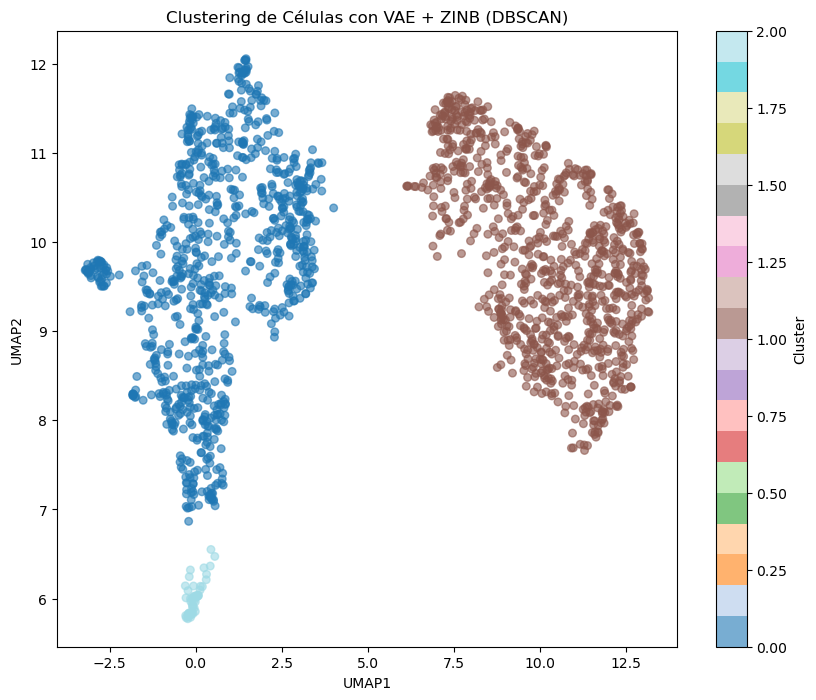

In [113]:
# Realizamos la reducción de dimensionalidad con UMAP
# ==============================================
vae_embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(vae_embeddings)

# ==============================================
# Aplicamos DBSCAN para el clustering de las representaciones latentes
# ==============================================
vae_dbscan = DBSCAN(eps=0.5, min_samples=5).fit(vae_embeddings_umap)
vae_labels = vae_dbscan.labels_

# ==============================================
# Visualizar los Clústeres en 2D
# ==============================================
plt.figure(figsize=(10, 8))

# Graficamos los puntos con los colores correspondientes a cada clúster
scatter = plt.scatter(vae_embeddings_umap[:, 0], vae_embeddings_umap[:, 1], c=vae_labels, cmap='tab20', alpha=0.6, s=30)

# Añadir la barra de colores para identificar los clústeres
plt.colorbar(scatter, label='Cluster')

# Títulos y etiquetas
plt.title('Clustering de Células con VAE + ZINB (DBSCAN)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Mostrar el gráfico
plt.show()


In [114]:
# Ver las células asociadas a cada clúster
# ==============================================
# Crear un DataFrame con las etiquetas de los clústeres y las células
clustered_cells = pd.DataFrame({
    'Cell Index': np.arange(len(vae_labels)),
    'Cluster Label': vae_labels
})

# Mostrar las primeras filas del DataFrame con las células y sus clústeres
print(clustered_cells.head())

   Cell Index  Cluster Label
0           0              0
1           1              0
2           2              0
3           3              0
4           4              0
